# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
import imageio
imageio.plugins.ffmpeg.download()

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


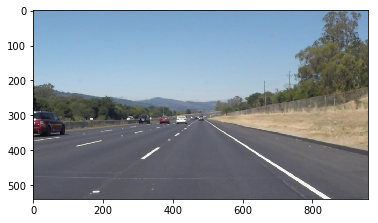

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [325]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def getSlope(x1, y1, x2, y2):
    return ((y2-y1)/(x2-x1))

def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
     
    selectedLines = np.copy(lines)
    #print (lines.shape)
    #print (lines)
    
    
    
    for fstLine, sndLine in zip(lines, lines[1:]):
        #print (type(fstLine))
        #print (str(fstLine) + ", " + str(sndLine))
        for x1,y1,x2,y2 in fstLine:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #selectedLines = np.concatenate(selectedLines, fstLine)
            slope = getSlope(x1, y1, x2, y2)            
            for x3,y3,x4,y4 in sndLine:                             

                errorSlope = 0.02
                
                auxSlope = getSlope(x1, y1, x3, y3)                
                if (auxSlope < slope + errorSlope and auxSlope > slope - errorSlope):
                    #cv2.line(img, (x1, y1), (x3, y3), color, thickness)
                    auxLine = np.array([[x1, y1, x3, y3]], ndmin=3)
                    selectedLines = np.append(selectedLines,auxLine, axis=0)
                auxSlope = getSlope(x1, y1, x4, y4)                
                if (auxSlope < slope + errorSlope and auxSlope > slope - errorSlope):
                    #cv2.line(img, (x1, y1), (x4, y4), color, thickness)
                    auxLine = np.array([[x1, y1, x4, y4]], ndmin=3)
                    selectedLines = np.append(selectedLines,auxLine, axis=0)
                auxSlope = getSlope(x2, y2, x3, y3)                
                if (auxSlope < slope + errorSlope and auxSlope > slope - errorSlope):
                    #cv2.line(img, (x2, y2), (x3, y3), color, thickness)
                    auxLine = np.array([[x2, y2, x3, y3]], ndmin=3)
                    selectedLines = np.append(selectedLines,auxLine, axis=0)
                auxSlope = getSlope(x2, y2, x4, y4)                
                if (auxSlope < slope + errorSlope and auxSlope > slope - errorSlope):
                    #cv2.line(img, (x2, y2), (x4, y4), color, thickness)
                    auxLine = np.array([[x2, y2, x4, y4]], ndmin=3)
                    selectedLines = np.append(selectedLines,auxLine, axis=0)
                    
    #for line in selectedLines:      
        #for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
     
    #print (lines.shape)
    #print (cv2.linestr(type(lines)) + " hahaha")
    #auxLine = np.array([[1, 2, 3, 4]], ndmin=3)
    #lines = np.append(lines,auxLine, axis=0)
    #print (np.append(lines, np.atleast_3d(auxLine), axis=0).shape)
    #print (auxLine.shape)
    #print (auxLine)
    
    #print (selectedLines.shape)
    #print (selectedLines)
    
    #print (selectedLines)
    #Draw Last line
    #for x1,y1,x2,y2 in lines[len(lines)-1]:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #selectedLines.append([x1,y1,x2,y2])
    
    #Find y_max of left and right line lanes
    xCenter = img.shape[1]/2
    leftYMax = rightYMax = 0
    leftXWithYMax = rightXWithYMax = 0
    leftIMax = rightIMax = leftJMax = rightJMax = 0
    leftLines = rightLines = np.empty([0, 1, 4], dtype=np.uint32)
    j = k = 0
    for i in range(len(selectedLines)): 
        auxLine = np.array(selectedLines[i], ndmin=3)
        for x1,y1,x2,y2 in selectedLines[i]:
            #print(str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2))
            if x1 < xCenter:
                leftLines = np.append(leftLines, auxLine, axis=0)
                if (y1 > leftYMax):
                    leftYMax = y1
                    leftIMax = j
                    leftJMax = 0 
                    leftXWithYMax = x1
                if (y2 > leftYMax):
                    leftYMax = y2
                    leftIMax = j
                    leftJMax = 1
                    leftXWithYMax = x2
                j = j + 1
            else:
                rightLines = np.append(rightLines, auxLine, axis=0)
                if (y1 > rightYMax):
                    rightYMax = y1
                    rightIMax = k
                    rightJMax = 0
                    rightXWithYMax = y1
                if (y2 > rightYMax):
                    rightYMax = y2
                    rightIMax = k
                    rightJMax = 1
                    rightXWithYMax = y2
                k = k + 1
    
    print("leftYMax = " + str(leftYMax) + " leftIMax = " + str(leftIMax) + " leftJMax = " + str(leftJMax))
    print("rightYMax = " + str(rightYMax) + " rightIMax = " + str(rightIMax) + " rightJMax = " + str(rightJMax))                
    print("XCenter: " + str(xCenter))
    print("XCenter: " + str(xCenter))
    #print(leftLines)
    #print(rightLines)
    
    leftSlopes = rightSlopes = np.empty([0], dtype=np.float32)
    leftXs = leftYs = np.empty([0], dtype=np.float32)
    rightXs = rightYs = np.empty([0], dtype=np.float32)
    
    for line in leftLines:    
        for x1,y1,x2,y2 in line:
            #print(str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2) + " " + str(color) + " " + str(thickness))
            leftSlopes = np.append(leftSlopes, getSlope(x1, y1, x2, y2))
            leftXs = np.append(leftXs, [[x1], [x2]])
            leftYs = np.append(leftYs, [[y1], [y2]])
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    lmedianX = np.median(leftXs)
    lmedianY = np.median(leftYs)
    lMaxY = img.shape[0]
    leftSlope = np.median(leftSlopes)
    lMaxX = ((lMaxY - lmedianY) / leftSlope) + lmedianX
    lMinY = math.floor( 3*img.shape[0]/5)
    lMinX = math.floor( ((lMinY - lmedianY) / leftSlope) + lmedianX)
        

    
    print("LeftXs = " + str(leftXs) + " MedianX = " + str(lmedianX))
    print("LeftYs = " + str(leftYs) + " MedianY = " + str(lmedianY))
    for line in rightLines:    
        for x1,y1,x2,y2 in line:
            rightSlopes = np.append(rightSlopes, getSlope(x1, y1, x2, y2))
            #cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness)
            rightXs = np.append(rightXs, [[x1], [x2]])
            rightYs = np.append(rightYs, [[y1], [y2]])
            
    print(leftSlopes)
    print(rightSlopes)
    
    rmedianX = np.median(rightXs)
    rmedianY = np.median(rightYs)
    rMaxY = img.shape[0]
    rightSlope = np.median(rightSlopes)
    rMaxX = ((rMaxY - rmedianY) / rightSlope) + rmedianX
    rMinY = math.floor( 3*img.shape[0]/5)
    rMinX = math.floor( ((rMinY - rmedianY) / rightSlope) + rmedianX)
    
    print(leftSlope)
    print(rightSlope)
    
    #Trace lines with slopes and YMax and XMax
    # y = mx + b
    #deltaX = len(leftSlopes)*15
    
    
    #Left Line
    cv2.line(img, (math.floor(lmedianX), math.floor(lmedianY)), (math.floor(lMaxX), math.floor(lMaxY)), [0, 255, 0], thickness)
    cv2.line(img, (math.floor(lmedianX), math.floor(lmedianY)), (lMinX, lMinY), [0, 255, 0], thickness)
        
    #Right Line
    cv2.line(img, (math.floor(rmedianX), math.floor(rmedianY)), (math.floor(rMaxX), math.floor(rMaxY)), [0, 0, 255], thickness)
    cv2.line(img, (math.floor(rmedianX), math.floor(rmedianY)), (rMinX, rMinY), [0, 0, 255], thickness)
    
    
    #for line in selectedLines:    
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                       
                       
    #for line in selectedLines:      
        #print (line)
        #for x1,y1,x2,y2 in line:
    #for line in lines:              
        #for x1,y1,x2,y2 in line:
            #if (x1 < img.shape[0]/2 and x2 < img.shape[1]/2) or (x1 > img.shape[0]/2 and x2 > img.shape[1]/2):
            #    cv2.line(img, (x1, y1), (math.floor((x1+x2)/2), math.floor((y1+y2)/2)), color, thickness)
            #else:
            #    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #cv2.line(img, (x1, y1), (math.floor((x1+x2)/2), math.floor((y1+y2)/2)), color, thickness)
            #cv2.line(img, (math.floor((x1+x2)/2), math.floor((y1+y2)/2)), (math.floor(x2+(x2-x1)/(y2-y1)), math.floor(y2+(y2-y1)/(x2-x1))), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

leftYMax = 522 leftIMax = 5 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 319.  363.  310.  356.  320.  350.  437.  464.  433.  459.  164.  190.
  310.  355.  433.  456.  333.  357.  433.  457.  318.  362.  320.  437.
  320.  464.  350.  437.  350.  464.  433.  190.  459.  190.  310.  433.] MedianX = 356.5
LeftYs = [ 425.  394.  423.  392.  424.  402.  339.  320.  339.  320.  522.  520.
  422.  392.  338.  321.  408.  392.  340.  323.  425.  394.  424.  339.
  424.  320.  402.  339.  402.  320.  339.  520.  320.  520.  422.  338.] MedianY = 393.0
[-0.70454545 -0.67391304 -0.73333333 -0.7037037  -0.73076923 -0.07692308
 -0.66666667 -0.73913043 -0.66666667 -0.70833333 -0.70454545 -0.72649573
 -0.72222222 -0.72413793 -0.71929825 -0.74485597 -0.74349442 -0.68292683]
[ 0.66060606  0.6196319   0.62151394  0.66666667  0.66037736  0.62162162
  0.62096774  0.6625      0.68181818  0.66776316  0.61842105  0.6217765
  0.62244898  0.66197183  0.65

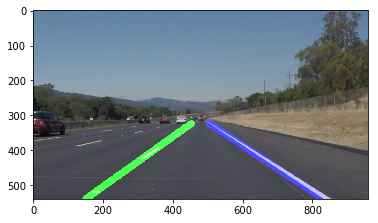

In [326]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def findLaneLines(img):
    clonedImage = np.copy(img) #Copy the image
    grayImage = grayscale(img) #Apply grayscale
    blurred_image = gaussian_blur(grayImage, 3) #Apply gaussian blur
    edges = canny(blurred_image, 70, 180) #Apply canny function
    imshape = edges.shape
    vertices = np.array([[(60,imshape[0]),(imshape[1]/2 - 30, imshape[0]/2 + 50), (imshape[1]/2 + 30, imshape[0]/2 + 50), (imshape[1]-60,imshape[0])]], dtype=np.int32) #Declare vertices 
    selectedEdges = region_of_interest(edges, vertices)
    lines = hough_lines(selectedEdges, 1, np.pi/720, 15, 20, 10) #Apply Hough Transform
    #lines = hough_lines(selectedEdges, 1, np.pi/720, 15, 200, 150) #Apply Hough Transform - Gambiarra
    #image = draw_lines(clonedImage, lines, [255, 0, 0], 2)
    image = weighted_img(lines, clonedImage, α=0.8, β=1., λ=0.)        
    return image


#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

resultImage = findLaneLines(image)

#plotting
plt.imshow(resultImage, cmap='gray')
#plt.imshow(image, cmap='gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [66]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = findLaneLines(img)    
    return result

Let's try the one with the solid white lane on the right first ...

In [327]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

leftYMax = 515 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 187.  302.  203.  311.  188.  299.  200.  232.  418.  460.  416.  454.
  419.  457.  429.  459.  278.  310.  201.  231.  265.  307.  200.  418.
  200.  460.  232.  418.  232.  460.  201.  265.  201.  307.  231.  265.
  231.  307.] MedianX = 288.5
LeftYs = [ 513.  430.  514.  432.  512.  431.  515.  491.  350.  320.  348.  321.
  349.  320.  342.  320.  458.  433.  515.  492.  466.  434.  515.  350.
  515.  320.  491.  350.  491.  320.  515.  466.  515.  434.  492.  466.
  492.  434.] MedianY = 446.0
[-0.72173913 -0.75925926 -0.72972973 -0.75       -0.71428571 -0.71052632
 -0.76315789 -0.73333333 -0.78125    -0.76666667 -0.76190476 -0.75688073
 -0.75       -0.75806452 -0.75       -0.765625   -0.76415094 -0.76470588
 -0.76315789]
[ 0.60445682  0.63556851  0.60714286  0.63492063  0.62903226  0.63709677
  0.63690476  0.63888889  0.60526316  0.59833795  0.64615385  0

  1%|          | 2/222 [00:00<00:11, 19.51it/s]

leftYMax = 515 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 187.  302.  203.  311.  188.  299.  200.  232.  418.  460.  416.  454.
  419.  457.  429.  459.  278.  310.  201.  231.  265.  307.  200.  418.
  200.  460.  232.  418.  232.  460.  201.  265.  201.  307.  231.  265.
  231.  307.] MedianX = 288.5
LeftYs = [ 513.  430.  514.  432.  512.  431.  515.  491.  350.  320.  348.  321.
  349.  320.  342.  320.  458.  433.  515.  492.  466.  434.  515.  350.
  515.  320.  491.  350.  491.  320.  515.  466.  515.  434.  492.  466.
  492.  434.] MedianY = 446.0
[-0.72173913 -0.75925926 -0.72972973 -0.75       -0.71428571 -0.71052632
 -0.76315789 -0.73333333 -0.78125    -0.76666667 -0.76190476 -0.75688073
 -0.75       -0.75806452 -0.75       -0.765625   -0.76415094 -0.76470588
 -0.76315789]
[ 0.60445682  0.63556851  0.60714286  0.63492063  0.62903226  0.63709677
  0.63690476  0.63888889  0.60526316  0.59833795  0.64615385  0

  3%|▎         | 6/222 [00:00<00:09, 22.38it/s]

leftYMax = 389 leftIMax = 0 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 365.  389.  360.  383.  360.  386.  406.  427.  440.  461.  404.  426.
  367.  388.  404.  425.  438.  458.  407.  427.  369.  389.] MedianX = 404.0
LeftYs = [ 389.  372.  387.  371.  388.  370.  358.  343.  335.  320.  358.  342.
  389.  373.  357.  342.  335.  321.  358.  344.  388.  373.] MedianY = 358.0
[-0.70833333 -0.69565217 -0.69230769 -0.71428571 -0.71428571 -0.72727273
 -0.76190476 -0.71428571 -0.7        -0.7        -0.75      ]
[ 0.6300578   0.60055096  0.63247863  0.63380282  0.63333333  0.59722222
  0.60416667  0.6         0.6374269   0.63054187  0.62650602  0.63188406
  0.63111111  0.60137457  0.60082305  0.60055096  0.6       ]
-0.714285714286
0.626506024096
leftYMax = 395 leftIMax = 1 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 351.  379.  358.  384.  357.  384.  351.  380.  439.  461.  400. 

  4%|▍         | 9/222 [00:00<00:09, 22.48it/s]

leftYMax = 403 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 347.  377.  339.  373.  396.  454.  416.  459.  414.  453.  429.  456.
  349.  372.  412.  438.  339.  374.  352.  376.  349.  412.  349.  438.
  372.  412.  372.  438.] MedianX = 386.5
LeftYs = [ 403.  380.  401.  378.  363.  321.  352.  320.  352.  326.  340.  321.
  394.  378.  350.  332.  402.  378.  400.  381.  394.  350.  394.  332.
  378.  350.  378.  332.] MedianY = 370.5
[-0.76666667 -0.67647059 -0.72413793 -0.74418605 -0.66666667 -0.7037037
 -0.69565217 -0.69230769 -0.68571429 -0.79166667 -0.6984127  -0.69662921
 -0.7        -0.6969697 ]
[ 0.62711864  0.60055096  0.6         0.61818182  0.625       0.625
  0.60344828  0.60209424  0.63917526]
-0.697691197691
0.618181818182
leftYMax = 488 leftIMax = 7 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 413.  459.  326.  364.  333.  370.  409.  456.  410.  455

  6%|▌         | 13/222 [00:00<00:08, 24.25it/s]

leftYMax = 515 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 198.  307.  183.  283.  183.  297.  201.  307.  416.  460.  406.  465.
  419.  459.  419.  464.  266.  300.  406.  455.  199.  223.  183.  296.
  201.  416.  201.  460.  307.  416.  307.  460.] MedianX = 307.0
LeftYs = [ 515.  433.  515.  444.  513.  433.  514.  434.  351.  320.  361.  320.
  350.  321.  353.  321.  454.  432.  360.  325.  514.  496.  514.  434.
  514.  351.  514.  320.  434.  351.  434.  320.] MedianY = 433.0
[-0.75229358 -0.71       -0.70175439 -0.75471698 -0.70454545 -0.69491525
 -0.725      -0.71111111 -0.64705882 -0.71428571 -0.75       -0.7079646
 -0.75813953 -0.74903475 -0.76146789 -0.74509804]
[ 0.61484099  0.65298507  0.65517241  0.65454545  0.61904762  0.61437908
  0.61904762  0.65467626  0.65217391  0.6122449   0.61616162  0.61002786
  0.65555556  0.65517241  0.65591398  0.65517241  0.6635514   0.66049383
  0.625       0.62672811  0.6

  8%|▊         | 17/222 [00:00<00:07, 25.92it/s]

[-0.66666667 -0.72727273 -0.68       -0.68965517 -0.7826087  -0.69565217
 -0.66666667 -0.67368421 -0.67142857]
[ 0.66060606  0.62463343  0.625       0.66163142  0.6677116   0.61      ]
-0.68
0.642803030303
leftYMax = 392 leftIMax = 5 leftJMax = 0
rightYMax = 539 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 360.  384.  404.  425.  350.  380.  403.  425.  401.  423.  357.  384.
  350.  377.  437.  457.  350.  425.  401.  357.  423.  357.] MedianX = 392.5
LeftYs = [ 391.  374.  358.  343.  391.  371.  358.  342.  358.  341.  392.  372.
  390.  372.  334.  320.  391.  342.  358.  392.  341.  392.] MedianY = 364.5
[-0.70833333 -0.71428571 -0.66666667 -0.72727273 -0.77272727 -0.74074074
 -0.66666667 -0.7        -0.65333333 -0.77272727 -0.77272727]
[ 0.62536023  0.65558912  0.65584416  0.65697674  0.62598425  0.62376238
  0.65714286  0.61581921  0.65730337  0.65662651  0.65359477  0.66477273
  0.66060606  0.66455696  0.63829787  0.62931034  0.63157895]
-0.714285714286


  9%|▉         | 21/222 [00:00<00:07, 27.62it/s]


0.657407407407
leftYMax = 486 leftIMax = 7 leftJMax = 0
rightYMax = 539 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 326.  366.  337.  370.  434.  458.  334.  370.  438.  463.  434.  456.
  326.  363.  214.  236.  434.  455.  436.  457.  334.  438.  334.  463.
  370.  438.  370.  463.  326.  214.  363.  214.] MedianX = 370.0
LeftYs = [ 411.  384.  411.  387.  337.  321.  412.  386.  337.  320.  336.  320.
  410.  385.  486.  485.  338.  324.  335.  320.  412.  337.  412.  320.
  386.  337.  386.  320.  410.  486.  385.  486.] MedianY = 385.0
[-0.675      -0.72727273 -0.66666667 -0.72222222 -0.68       -0.72727273
 -0.67567568 -0.04545455 -0.66666667 -0.71428571 -0.72115385 -0.71317829
 -0.72058824 -0.70967742 -0.67857143 -0.67785235]
[ 0.62837838  0.66058394  0.66025641  0.63101604  0.63492063  0.65942029
  0.66666667  0.61316872  0.67346939  0.65662651  0.65340909]
-0.694838709677
0.656626506024
leftYMax = 425 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMa

 11%|█         | 24/222 [00:00<00:07, 27.79it/s]

leftYMax = 479 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 244.  327.  232.  319.  234.  316.  419.  457.  410.  462.  420.  454.
  397.  461.  248.  324.  424.  452.  246.  280.  420.  456.  234.  419.
  234.  457.  316.  419.  316.  457.  248.  424.  248.  452.  424.  246.
  452.  246.  452.  280.  246.  420.  246.  456.  280.  420.  280.  456.] MedianX = 403.5
LeftYs = [ 479.  419.  476.  417.  474.  418.  347.  320.  356.  320.  348.  324.
  367.  321.  477.  422.  347.  326.  477.  452.  347.  321.  474.  347.
  474.  320.  418.  347.  418.  320.  477.  347.  477.  326.  347.  477.
  326.  477.  326.  452.  477.  347.  477.  321.  452.  347.  452.  321.] MedianY = 361.5
[-0.72289157 -0.67816092 -0.68292683 -0.71052632 -0.69230769 -0.70588235
 -0.71875    -0.72368421 -0.75       -0.73529412 -0.72222222 -0.68648649
 -0.69058296 -0.68932039 -0.69503546 -0.73863636 -0.74019608 -0.73033708
 -0.73300971 -0.73255814 -0.74

 12%|█▏        | 27/222 [00:00<00:07, 27.36it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 182.  289.  140.  277.  415.  456.  163.  246.  146.  191.  245.  278.
  418.  462.  414.  457.  162.  211.  235.  289.  190.  243.  140.  192.
  433.  461.  415.  163.  415.  246.  456.  163.  456.  246.  245.  462.
  278.  462.  457.  162.  457.  211.  162.  289.  211.  289.] MedianX = 261.5
LeftYs = [ 525.  447.  538.  445.  352.  322.  539.  477.  536.  505.  468.  445.
  352.  320.  351.  320.  538.  502.  486.  445.  505.  469.  539.  504.
  340.  320.  352.  539.  352.  477.  322.  539.  322.  477.  468.  320.
  445.  320.  320.  538.  320.  502.  538.  445.  502.  445.] MedianY = 457.5
[-0.72897196 -0.67883212 -0.73170732 -0.74698795 -0.68888889 -0.6969697
 -0.72727273 -0.72093023 -0.73469388 -0.75925926 -0.67924528 -0.67307692
 -0.71428571 -0.74206349 -0.73964497 -0.74061433 -0.73809524 -0.68202765
 -0.67934783 -0.73898305 -0.7398374  -0.73228346 -0.730

 14%|█▍        | 31/222 [00:01<00:06, 28.45it/s]

leftYMax = 395 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 358.  385.  438.  462.  352.  382.  352.  378.  360.  385.  402.  425.
  401.  424.  354.  379.  358.  438.  358.  462.  385.  438.] MedianX = 385.0
LeftYs = [ 395.  375.  336.  320.  395.  374.  394.  375.  395.  376.  361.  345.
  361.  344.  393.  375.  395.  336.  395.  320.  375.  336.] MedianY = 375.0
[-0.74074074 -0.66666667 -0.7        -0.73076923 -0.76       -0.69565217
 -0.73913043 -0.72       -0.7375     -0.72115385 -0.73584906]
[ 0.65991903  0.625       0.67647059  0.62264151  0.6779661   0.62068966
  0.66242038  0.625       0.6875      0.66883117  0.62028986  0.61044177
  0.61408451  0.61538462]
-0.730769230769
0.625
leftYMax = 459 leftIMax = 9 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 341.  373.  349.  379.  436.  456.  341.  370.  346.  379.  438.  461.
  435.  455.  402.  423.  437.  460.  2

 16%|█▌        | 35/222 [00:01<00:06, 29.65it/s]

LeftXs = [ 411.  453.  337.  371.  412.  460.  410.  454.  328.  366.  410.  459.
  333.  371.  328.  364.  217.  241.  410.  434.  411.  337.  411.  371.
  453.  337.  453.  371.  410.  328.  410.  366.  454.  328.  454.  366.
  328.  410.  328.  459.  366.  459.] MedianX = 390.5
LeftYs = [ 355.  323.  411.  386.  355.  320.  352.  320.  410.  384.  353.  320.
  412.  385.  409.  384.  484.  483.  354.  337.  355.  411.  355.  386.
  323.  411.  323.  386.  352.  410.  352.  384.  320.  410.  320.  384.
  410.  353.  410.  320.  384.  320.] MedianY = 369.5
[-0.76190476 -0.73529412 -0.72916667 -0.72727273 -0.68421053 -0.67346939
 -0.71052632 -0.69444444 -0.04166667 -0.70833333 -0.75675676 -0.775
 -0.75862069 -0.76829268 -0.70731707 -0.72727273 -0.71428571 -0.72727273
 -0.69512195 -0.6870229  -0.68817204]
[ 0.65267176  0.61890244  0.64930556  0.64516129  0.62057878  0.625
  0.61290323  0.64556962  0.66666667  0.60322581  0.65465465  0.65562914]
-0.714285714286
0.645365455288
leftYMax = 

 17%|█▋        | 38/222 [00:01<00:06, 29.33it/s]

leftYMax = 509 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 207.  311.  192.  302.  206.  312.  192.  298.  406.  458.  390.  442.
  394.  459.  428.  455.  458.  390.] MedianX = 390.0
LeftYs = [ 509.  432.  507.  430.  509.  430.  506.  432.  358.  320.  369.  330.
  371.  320.  341.  321.  320.  369.] MedianY = 370.0
[-0.74038462 -0.7        -0.74528302 -0.69811321 -0.73076923 -0.75
 -0.78461538 -0.74074074 -0.72058824]
[ 0.625       0.65        0.625       0.65168539  0.62222222  0.65384615
  0.63636364  0.65909091  0.64893617  0.60888889]
-0.740384615385
0.642649903288
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 146.  280.  167.  290.  414.  458.  414.  462.  415.  457.  444.  464.
  147.  240.  225.  291.  216.  255.  211.  281.  388.  429.  177.  200.
  211.  429.  281.  429.  388.  177.  388.  200.  429.  177.  429.  200.] MedianX = 

 19%|█▉        | 42/222 [00:01<00:06, 29.09it/s]

leftYMax = 400 leftIMax = 5 leftJMax = 0
rightYMax = 538 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 416.  457.  414.  453.  343.  375.  353.  379.  343.  372.  350.  379.
  397.  447.  411.  437.  413.  456.  397.  437.] MedianX = 404.0
LeftYs = [ 351.  321.  351.  320.  399.  376.  399.  378.  398.  377.  400.  377.
  362.  324.  349.  331.  351.  320.  362.  331.] MedianY = 356.5
[-0.73170732 -0.79487179 -0.71875    -0.80769231 -0.72413793 -0.79310345
 -0.76       -0.69230769 -0.72093023 -0.775     ]
[ 0.625       0.63125     0.66101695  0.63793103  0.66101695  0.63451777
  0.61702128  0.62962963  0.61904762  0.64864865  0.66666667  0.62285714
  0.62258065  0.64864865  0.63837638  0.64285714]
-0.745853658537
0.63622440049
leftYMax = 409 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0


 20%|██        | 45/222 [00:01<00:06, 26.39it/s]

LeftXs = [ 330.  365.  338.  372.  435.  455.  329.  367.  436.  456.  337.  367.
  329.  364.  348.  370.] MedianX = 366.0
LeftYs = [ 407.  382.  409.  383.  335.  320.  409.  381.  335.  321.  409.  386.
  407.  382.  402.  385.] MedianY = 384.0
[-0.71428571 -0.76470588 -0.75       -0.73684211 -0.7        -0.76666667
 -0.71428571 -0.77272727]
[ 0.63137255  0.67118644  0.67193676  0.63636364  0.67058824  0.63358779
  0.62941176  0.63043478  0.62025316  0.62874251  0.67460317  0.66891892
  0.68548387]
-0.743421052632
0.636363636364
leftYMax = 515 leftIMax = 6 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 324.  364.  314.  360.  322.  364.  432.  452.  434.  455.  432.  454.
  174.  200.  432.  453.  322.  432.  322.  452.  364.  452.] MedianX = 398.0
LeftYs = [ 420.  389.  418.  387.  420.  388.  334.  320.  336.  322.  336.  320.
  515.  513.  335.  320.  420.  334.  420.  320.  388.  320.] MedianY = 361.5
[-0.775      -0.67391304 -0

 22%|██▏       | 48/222 [00:01<00:07, 23.64it/s]

leftYMax = 501 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 215.  313.  213.  313.  197.  303.  414.  453.  418.  455.  242.  299.
  404.  455.  200.  240.  198.  302.  242.  404.  242.  455.  299.  455.] MedianX = 302.5
LeftYs = [ 500.  427.  501.  425.  499.  425.  347.  320.  348.  321.  467.  427.
  356.  320.  498.  470.  498.  425.  467.  356.  467.  320.  427.  320.] MedianY = 426.0
[-0.74489796 -0.76       -0.69811321 -0.69230769 -0.72972973 -0.70175439
 -0.70588235 -0.7        -0.70192308 -0.68518519 -0.69014085 -0.68589744]
[ 0.6300578   0.66666667  0.63128492  0.66816143  0.66666667  0.66666667
  0.63333333  0.66666667  0.62464183  0.66071429  0.66216216]
-0.700877192982
0.662162162162
leftYMax = 539 leftIMax = 6 leftJMax = 0
rightYMax = 539 rightIMax = 5 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 184.  283.  161.  292.  140.  259.  184.  292.  430.  455.  424.  452.
  140.  189.  412.  448.  160. 

 23%|██▎       | 51/222 [00:01<00:07, 21.62it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 372.  392.  158.  232.  138.  218.  137.  219.  367.  389.  366.  388.
  407.  427.  157.  232.  410.  442.  406.  426.  184.  232.  153.  199.
  138.  219.  218.  137.  137.  367.  137.  389.  219.  367.  219.  389.] MedianX = 232.0
LeftYs = [ 380.  366.  539.  483.  537.  482.  538.  482.  379.  364.  378.  364.
  354.  341.  538.  482.  351.  329.  353.  339.  520.  484.  528.  496.
  537.  482.  482.  538.  538.  379.  538.  364.  482.  379.  482.  364.] MedianY = 482.0
[-0.7        -0.75675676 -0.6875     -0.68292683 -0.68181818 -0.63636364
 -0.65       -0.74666667 -0.6875     -0.7        -0.75       -0.69565217
 -0.67901235 -0.69135802 -0.69130435 -0.69047619 -0.69594595 -0.69411765]
[ 0.63662791  0.67137809  0.632       0.67375887  0.63663664  0.66666667
  0.63636364  0.67741935  0.62686567  0.67687075  0.62647059  0.62300319]
-0.691331186259
0.6366322718

 24%|██▍       | 54/222 [00:02<00:08, 20.40it/s]

leftYMax = 539 leftIMax = 6 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 136.  169.  363.  387.  156.  185.  358.  382.  364.  387.  403.  453.
  135.  170.  361.  383.  156.  185.  439.  459.  359.  381.  404.  425.
  136.  363.  136.  387.  169.  363.  169.  387.  363.  156.  363.  185.
  387.  156.  387.  185.  403.  135.  403.  170.  453.  135.  453.  170.
  135.  361.  135.  383.  170.  361.  170.  383.  156.  439.  156.  459.
  185.  439.  185.  459.] MedianX = 361.0
LeftYs = [ 537.  515.  386.  368.  538.  517.  384.  368.  386.  370.  356.  321.
  539.  515.  383.  368.  539.  518.  333.  320.  383.  368.  356.  342.
  537.  386.  537.  368.  515.  386.  515.  368.  386.  538.  386.  517.
  368.  538.  368.  517.  356.  539.  356.  515.  321.  539.  321.  515.
  539.  383.  539.  368.  515.  383.  515.  368.  539.  333.  539.  320.
  518.  333.  518.  320.] MedianY = 386.0
[-0.66666667 -0.75       -0.72413793 -0.66666667 -0.6

 26%|██▌       | 57/222 [00:02<00:08, 19.21it/s]

leftYMax = 515 leftIMax = 9 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 316.  358.  307.  353.  327.  351.  306.  352.  432.  461.  431.  455.
  430.  457.  433.  462.  313.  354.  170.  196.  434.  461.] MedianX = 356.0
LeftYs = [ 422.  392.  421.  390.  406.  390.  421.  390.  339.  320.  337.  320.
  339.  320.  339.  320.  423.  394.  515.  511.  339.  321.] MedianY = 390.0
[-0.71428571 -0.67391304 -0.66666667 -0.67391304 -0.65517241 -0.70833333
 -0.7037037  -0.65517241 -0.70731707 -0.15384615 -0.66666667]
[ 0.62643678  0.65989848  0.65806452  0.6244898   0.65454545  0.6641791
  0.65340909  0.66163142]
-0.673913043478
0.656304985337
leftYMax = 438 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 286.  342.  412.  463.  293.  347.  399.  457.  399.  455.  401.  460.
  285.  341.  296.  347.  402.  453.  412.  293.  412.  347.  463.  293.
  463.  347.  293.  457.  296. 

 28%|██▊       | 63/222 [00:02<00:09, 17.66it/s]

leftYMax = 476 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 238.  320.  226.  313.  240.  321.  417.  457.  226.  315.  393.  462.
  407.  427.  406.  461.  226.  393.  226.  462.  315.  462.  407.  461.
  427.  461.] MedianX = 399.5
LeftYs = [ 476.  418.  474.  416.  476.  418.  346.  320.  475.  416.  366.  320.
  355.  342.  355.  320.  475.  366.  475.  320.  416.  320.  355.  320.
  342.  320.] MedianY = 360.5
[-0.70731707 -0.66666667 -0.71604938 -0.65       -0.66292135 -0.66666667
 -0.65       -0.63636364 -0.65269461 -0.65677966 -0.65306122 -0.64814815
 -0.64705882]
[ 0.63313609  0.66768293  0.66556291  0.63380282  0.63076923  0.66666667
  0.62571429  0.66261398  0.67109635  0.67391304]
-0.65306122449
0.664088447835
leftYMax = 507 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 181.  294.  195.  303.  181.  296.  417.  462.  244.  303.  413.  461.
  197

 29%|██▉       | 65/222 [00:02<00:09, 16.98it/s]


rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 151.  215.  368.  391.  150.  190.  151.  215.  438.  461.  365.  386.
  405.  456.  405.  462.  171.  202.  371.  391.  436.  459.  365.  385.
  132.  161.  406.  426.  405.  426.  436.  456.  151.  368.  368.  150.
  368.  190.  391.  150.  391.  190.  365.  405.  365.  456.  386.  456.
  405.  171.  405.  202.  462.  171.  462.  202.] MedianX = 378.0
LeftYs = [ 539.  492.  383.  368.  526.  499.  538.  491.  336.  321.  381.  367.
  355.  321.  357.  320.  511.  491.  382.  369.  336.  321.  380.  367.
  538.  518.  357.  344.  356.  342.  333.  320.  539.  383.  383.  526.
  383.  499.  368.  526.  368.  499.  381.  355.  381.  321.  367.  321.
  357.  511.  357.  491.  320.  511.  320.  491.] MedianY = 374.5
[-0.734375   -0.65217391 -0.675      -0.734375   -0.65217391 -0.66666667
 -0.66666667 -0.64912281 -0.64516129 -0.65       -0.65217391 -0.65
 -0.68965517 -0.65       -0.66666667 -0.65       -0

 31%|███       | 69/222 [00:03<00:10, 14.26it/s]

leftYMax = 479 leftIMax = 9 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 332.  365.  322.  361.  336.  358.  328.  365.  406.  453.  407.  451.
  408.  459.  406.  454.  322.  360.  211.  231.  407.  458.  322.  211.
  360.  211.] MedianX = 360.5
LeftYs = [ 408.  384.  408.  382.  397.  383.  409.  383.  354.  322.  351.  321.
  354.  320.  353.  320.  407.  382.  479.  478.  354.  320.  407.  479.
  382.  479.] MedianY = 382.5
[-0.72727273 -0.66666667 -0.63636364 -0.7027027  -0.68085106 -0.68181818
 -0.66666667 -0.6875     -0.65789474 -0.05       -0.66666667 -0.64864865
 -0.65100671]
[ 0.6379822   0.66981132  0.66842105  0.63636364  0.63636364  0.66666667
  0.63636364  0.62831858  0.62790698  0.63179916]
-0.666666666667
0.636363636364
leftYMax = 420 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 404.  451.  406.  458.  315.  357.  306.  350.  402.  450.  324.  357.
  43

 32%|███▏      | 72/222 [00:03<00:09, 15.89it/s]

leftYMax = 449 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 272.  335.  394.  451.  261.  328.  261.  329.  273.  335.  287.  333.
  400.  452.  408.  447.  420.  445.  409.  452.  394.  261.  394.  328.
  451.  261.  451.  328.  261.  329.  328.  261.] MedianX = 334.0
LeftYs = [ 449.  405.  360.  322.  447.  404.  448.  404.  449.  406.  438.  406.
  361.  324.  352.  325.  346.  330.  352.  323.  360.  447.  360.  404.
  322.  447.  322.  404.  447.  404.  404.  448.] MedianY = 404.0
[-0.6984127  -0.66666667 -0.64179104 -0.64705882 -0.69354839 -0.69565217
 -0.71153846 -0.69230769 -0.64       -0.6744186  -0.65413534 -0.66666667
 -0.65789474 -0.66666667 -0.63235294 -0.65671642]
[ 0.64356436  0.68012422  0.64102564  0.67826087  0.67924528  0.64814815
  0.63722397]
-0.666666666667
0.648148148148
leftYMax = 470 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 229

 34%|███▍      | 76/222 [00:03<00:10, 14.42it/s]

leftYMax = 539 leftIMax = 9 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 123.  245.  142.  256.  371.  392.  212.  255.  439.  460.  406.  426.
  179.  217.  169.  242.  419.  455.  123.  176.  143.  193.  230.  256.
  438.  459.  212.  439.  212.  460.  255.  439.  255.  460.  169.  419.
  169.  455.  242.  419.  242.  455.  230.  438.  230.  459.  256.  438.
  256.  459.] MedianX = 256.0
LeftYs = [ 538.  459.  538.  460.  375.  362.  491.  461.  334.  320.  353.  340.
  512.  486.  507.  460.  346.  321.  539.  504.  538.  504.  477.  459.
  334.  320.  491.  334.  491.  320.  461.  334.  461.  320.  507.  346.
  507.  321.  460.  346.  460.  321.  477.  334.  477.  320.  459.  334.
  459.  320.] MedianY = 459.0
[-0.64754098 -0.68421053 -0.61904762 -0.69767442 -0.66666667 -0.65
 -0.68421053 -0.64383562 -0.69444444 -0.66037736 -0.68       -0.69230769
 -0.66666667 -0.69162996 -0.68951613 -0.69021739 -0.68780488 -0.644
 -0.65034965 -0

 36%|███▋      | 81/222 [00:03<00:08, 16.30it/s]


LeftYs = [ 389.  372.  390.  374.  392.  373.  390.  372.  359.  344.  335.  320.
  335.  321.  359.  335.  359.  320.  344.  335.  344.  320.] MedianY = 351.5
[-0.62962963 -0.69565217 -0.7037037  -0.64285714 -0.65217391 -0.65217391
 -0.66666667 -0.64864865 -0.65       -0.64285714 -0.64864865]
[ 0.6509434   0.68770764  0.64971751  0.65909091  0.67857143  0.6875
  0.64705882  0.68292683  0.65625     0.64197531  0.6870229   0.68691589
  0.68553459  0.68518519]
-0.65
0.68074912892
leftYMax = 400 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 7 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 335.  366.  342.  371.  407.  452.  339.  365.  409.  451.  425.  458.
  410.  457.  333.  363.  391.  434.] MedianX = 399.0
LeftYs = [ 397.  377.  399.  378.  350.  320.  400.  382.  352.  321.  341.  320.
  352.  321.  398.  378.  363.  333.] MedianY = 357.5
[-0.64516129 -0.72413793 -0.66666667 -0.69230769 -0.73809524 -0.63636364
 -0.65957447 -0.66666667 -0.69767442]
[ 0.69395018  0.68

 37%|███▋      | 83/222 [00:03<00:09, 14.95it/s]

leftYMax = 432 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 396.  449.  282.  340.  399.  452.  292.  344.  304.  345.  410.  458.
  396.  450.  316.  337.  409.  451.  396.  282.  449.  282.  449.  340.
  399.  292.  399.  344.  452.  292.  452.  344.  292.  345.  304.  458.
  345.  458.] MedianX = 370.5
LeftYs = [ 356.  322.  430.  394.  359.  322.  432.  397.  423.  396.  350.  320.
  357.  322.  408.  395.  350.  322.  356.  430.  322.  430.  322.  394.
  359.  432.  359.  397.  322.  432.  322.  397.  432.  396.  423.  320.
  396.  320.] MedianY = 376.5
[-0.64150943 -0.62068966 -0.69811321 -0.67307692 -0.65853659 -0.625
 -0.64814815 -0.61904762 -0.66666667 -0.64912281 -0.64670659 -0.66055046
 -0.68224299 -0.69090909 -0.6875     -0.69444444 -0.67924528 -0.66883117
 -0.67256637]
[ 0.70096463  0.65753425  0.66009852  0.65517241  0.67857143  0.70588235
  0.71428571  0.7027027   0.65        0.71003717  0.7012987   0.7016

 40%|████      | 89/222 [00:04<00:07, 18.70it/s]

leftYMax = 498 leftIMax = 7 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 182.  292.  197.  290.  201.  302.  182.  294.  411.  452.  413.  451.
  399.  453.  194.  225.  412.  451.  194.  412.  194.  451.  225.  412.
  225.  451.] MedianX = 298.0
LeftYs = [ 495.  424.  497.  433.  495.  425.  496.  424.  347.  320.  349.  324.
  356.  320.  498.  477.  349.  323.  498.  349.  498.  323.  477.  349.
  477.  323.] MedianY = 424.0
[-0.64545455 -0.68817204 -0.69306931 -0.64285714 -0.65853659 -0.65789474
 -0.66666667 -0.67741935 -0.66666667 -0.68348624 -0.68093385 -0.68449198
 -0.68141593]
[ 0.66229508  0.70344828  0.70048309  0.70037453  0.66129032  0.58333333
  0.68        0.69565217  0.70175439  0.65273312  0.71428571]
-0.677419354839
0.695652173913
leftYMax = 537 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 137.  281.  122.  270.  202.  273.  140.  281.  123.  168.  421

 41%|████▏     | 92/222 [00:04<00:08, 15.08it/s]

leftYMax = 401 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 409.  457.  334.  369.  340.  372.  409.  462.  411.  437.  427.  463.
  342.  367.  409.  456.  409.  334.  457.  334.  457.  369.] MedianX = 409.0
LeftYs = [ 351.  320.  399.  378.  401.  380.  352.  320.  354.  337.  342.  320.
  401.  384.  353.  321.  351.  399.  320.  399.  320.  378.] MedianY = 352.5
[-0.64583333 -0.6        -0.65625    -0.60377358 -0.65384615 -0.61111111
 -0.68       -0.68085106 -0.64       -0.64227642 -0.65909091]
[ 0.66507177  0.71103896  0.70652174  0.68907563  0.71212121  0.68181818
  0.68571429  0.66115702  0.66666667  0.71428571  0.68571429  0.65833333
  0.66261398  0.70833333  0.70779221  0.7173913   0.72101449  0.66533865
  0.65740741  0.66564417  0.65979381]
-0.645833333333
0.685714285714
leftYMax = 410 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 321.  358.  329.

 42%|████▏     | 94/222 [00:04<00:08, 15.24it/s]

leftYMax = 421 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 305.  349.  312.  356.  403.  458.  305.  352.  416.  463.  324.  356.
  404.  434.  415.  457.  423.  445.  318.  355.  403.  305.  403.  352.
  458.  305.  458.  352.] MedianX = 379.5
LeftYs = [ 419.  390.  421.  390.  356.  320.  420.  389.  350.  320.  414.  392.
  358.  339.  349.  322.  342.  327.  418.  392.  356.  420.  356.  389.
  320.  420.  320.  389.] MedianY = 373.5
[-0.65909091 -0.70454545 -0.65454545 -0.65957447 -0.63829787 -0.6875
 -0.63333333 -0.64285714 -0.68181818 -0.7027027  -0.65306122 -0.64705882
 -0.65359477 -0.6509434 ]
[ 0.6622807   0.71518987  0.71689498  0.72307692  0.66666667  0.66451613
  0.71014493  0.66666667  0.72131148  0.68085106  0.67068273  0.67708333
  0.6744186   0.65048544  0.66972477  0.65891473]
-0.654070112894
0.672550667787
leftYMax = 433 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 5 rightJMax = 1
XCenter: 48

 44%|████▎     | 97/222 [00:04<00:07, 17.39it/s]

leftYMax = 532 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 413.  456.  146.  285.  132.  279.  133.  275.  415.  452.  148.  284.
  236.  265.  413.  454.  133.  415.  133.  452.  275.  415.  275.  452.
  415.  284.  452.  148.  452.  284.  236.  413.  236.  454.  265.  454.] MedianX = 284.0
LeftYs = [ 347.  320.  532.  438.  529.  436.  528.  437.  350.  324.  532.  440.
  461.  443.  348.  322.  528.  350.  528.  324.  437.  350.  437.  324.
  350.  440.  324.  532.  324.  440.  461.  348.  461.  322.  443.  322.] MedianY = 437.0
[-0.62790698 -0.67625899 -0.63265306 -0.64084507 -0.7027027  -0.67647059
 -0.62068966 -0.63414634 -0.63120567 -0.63949843 -0.62142857 -0.63841808
 -0.6870229  -0.68421053 -0.69047619 -0.63841808 -0.63761468 -0.64021164]
[ 0.68512111  0.71803279  0.71854305  0.68518519  0.67741935  0.70833333
  0.675       0.67457627]
-0.638958255849
0.685153146226


 46%|████▌     | 102/222 [00:05<00:08, 14.13it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 116.  248.  137.  259.  137.  259.  117.  249.  422.  460.  410.  431.
  375.  395.  410.  430.  378.  398.  136.  167.  117.  422.  117.  460.
  249.  422.  249.  460.  460.  410.] MedianX = 376.5
LeftYs = [ 538.  454.  538.  454.  539.  455.  539.  454.  343.  320.  351.  339.
  374.  360.  350.  337.  375.  362.  538.  517.  539.  343.  539.  320.
  454.  343.  454.  320.  320.  351.] MedianY = 374.5
[-0.63636364 -0.68852459 -0.68852459 -0.64393939 -0.60526316 -0.57142857
 -0.7        -0.65       -0.65       -0.67741935 -0.64262295 -0.63848397
 -0.6416185  -0.63507109 -0.62      ]
[ 0.68327402  0.71803279  0.71854305  0.68041237  0.66666667  0.7         0.68
  0.68        0.67384615  0.72635135  0.66666667  0.67283951]
-0.64262295082
0.680206185567
leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480

 47%|████▋     | 105/222 [00:05<00:07, 15.39it/s]


LeftYs = [ 338.  320.  336.  320.  409.  385.  410.  384.  410.  385.  338.  322.
  407.  392.  320.  409.  320.  385.  409.  384.] MedianY = 384.5
[-0.62068966 -0.64       -0.66666667 -0.68421053 -0.71428571 -0.66666667
 -0.71428571 -0.65925926 -0.65656566 -0.65789474]
[ 0.67384615  0.70353982  0.70093458  0.67114094  0.6875      0.67625899
  0.67142857  0.66666667  0.7         0.65530303  0.70491803  0.69897959
  0.72222222  0.65555556  0.66261398  0.65660377  0.69354839  0.68159204
  0.6870229 ]
-0.662962962963
0.681592039801
leftYMax = 508 leftIMax = 10 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 320.  363.  419.  460.  311.  358.  409.  466.  406.  460.  415.  464.
  318.  355.  328.  362.  426.  456.  407.  437.  177.  197.  320.  419.
  363.  419.  419.  311.  460.  311.] MedianX = 406.5
LeftYs = [ 420.  389.  348.  322.  418.  389.  356.  320.  354.  320.  352.  320.
  413.  390.  415.  391.  343.  322.  356.  334.  508.  5

 50%|████▉     | 110/222 [00:05<00:06, 16.24it/s]

leftYMax = 447 leftIMax = 4 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 268.  337.  268.  336.  285.  341.  425.  463.  279.  341.  401.  459.
  414.  457.  402.  459.  398.  434.  268.  336.  337.  268.  285.  425.
  285.  463.  341.  425.  341.  463.  279.  401.  279.  459.  341.  401.
  341.  459.] MedianX = 341.0
LeftYs = [ 446.  402.  445.  402.  444.  405.  345.  320.  447.  403.  361.  321.
  350.  320.  360.  320.  359.  335.  446.  402.  402.  445.  444.  345.
  444.  320.  405.  345.  405.  320.  447.  361.  447.  321.  403.  361.
  403.  321.] MedianY = 402.0
[-0.63768116 -0.63235294 -0.69642857 -0.65789474 -0.70967742 -0.68965517
 -0.69767442 -0.70175439 -0.66666667 -0.64705882 -0.62318841 -0.70714286
 -0.69662921 -0.71428571 -0.69672131 -0.70491803 -0.7        -0.7
 -0.69491525]
[ 0.70305677  0.67175573  0.672       0.70238095  0.66666667  0.69491525
  0.7         0.7         0.67605634  0.7124183   0.66666667  0.668711

 51%|█████     | 113/222 [00:05<00:06, 17.51it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 133.  223.  154.  234.  411.  454.  154.  231.  410.  460.  444.  465.
  373.  394.  370.  392.  153.  181.  157.  202.  173.  220.  411.  154.
  411.  231.  454.  154.  454.  231.  444.  373.  465.  373.  465.  394.] MedianX = 373.0
LeftYs = [ 538.  479.  539.  481.  355.  325.  538.  483.  355.  320.  334.  320.
  381.  366.  379.  364.  538.  518.  523.  493.  511.  480.  355.  538.
  355.  483.  325.  538.  325.  483.  334.  381.  320.  381.  320.  366.] MedianY = 381.0
[-0.65555556 -0.725      -0.69767442 -0.71428571 -0.7        -0.66666667
 -0.71428571 -0.68181818 -0.71428571 -0.66666667 -0.65957447 -0.71206226
 -0.71111111 -0.71       -0.70852018 -0.66197183 -0.66304348 -0.64788732]
[ 0.70545455  0.66768293  0.70305677  0.7037037   0.7027027   0.6626506
  0.65789474  0.6875      0.66216216  0.71103896  0.65991903  0.66028708
  0.66060606  0.6609589 ]
-0.6

 53%|█████▎    | 117/222 [00:06<00:06, 15.20it/s]


[-0.66666667 -0.7        -0.65384615 -0.65625    -0.69565217 -0.71428571
 -0.64       -0.66666667 -0.64      ]
[ 0.69230769  0.65993266  0.68627451  0.69387755  0.65517241  0.69230769
  0.68421053  0.66101695  0.65625     0.70758123  0.68556701  0.68531469]
-0.666666666667
0.685440847812
leftYMax = 406 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 329.  369.  436.  458.  337.  372.  336.  369.  441.  462.  437.  464.
  344.  366.  436.  456.  438.  461.  436.  372.  458.  337.  458.  372.
  336.  441.  336.  462.  369.  441.  369.  462.  344.  436.  344.  456.
  366.  456.] MedianX = 436.0
LeftYs = [ 404.  379.  336.  320.  406.  382.  406.  383.  333.  320.  336.  320.
  394.  380.  334.  321.  337.  322.  336.  382.  320.  406.  320.  382.
  406.  333.  406.  320.  383.  333.  383.  320.  394.  334.  394.  321.
  380.  321.] MedianY = 336.5
[-0.625      -0.72727273 -0.68571429 -0.6969697  -0.61904762 -0.59259259
 -0.63

 54%|█████▎    | 119/222 [00:06<00:06, 15.96it/s]

leftYMax = 429 leftIMax = 1 leftJMax = 0
rightYMax = 538 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 296.  350.  302.  354.  404.  460.  324.  347.  409.  463.  331.  354.
  305.  343.  405.  458.  417.  451.  426.  458.  302.  460.  404.  324.
  404.  347.  460.  324.  460.  347.  354.  305.  305.  458.  343.  458.] MedianX = 354.0
LeftYs = [ 426.  391.  429.  394.  356.  320.  407.  392.  357.  320.  409.  393.
  428.  402.  356.  322.  349.  327.  341.  320.  429.  320.  356.  407.
  356.  392.  320.  407.  320.  392.  393.  428.  428.  322.  402.  322.] MedianY = 391.5
[-0.64814815 -0.67307692 -0.64285714 -0.65217391 -0.68518519 -0.69565217
 -0.68421053 -0.64150943 -0.64705882 -0.65625    -0.68987342 -0.6375
 -0.63157895 -0.63970588 -0.63716814 -0.71428571 -0.69281046 -0.69565217]
[ 0.68064516  0.6534296   0.65454545  0.65753425  0.66666667  0.65686275
  0.67961165  0.66666667  0.65625     0.65432099  0.64705882  0.66666667
  0.67142857  0.64835165  0.63888

 55%|█████▌    | 123/222 [00:06<00:06, 16.18it/s]

leftYMax = 528 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 152.  284.  166.  295.  168.  295.  416.  461.  152.  249.  161.  286.
  419.  467.  421.  461.  418.  462.  445.  466.  168.  416.  168.  461.
  295.  416.  295.  461.  467.  421.] MedianX = 416.0
LeftYs = [ 526.  436.  528.  436.  528.  438.  351.  320.  525.  459.  520.  435.
  352.  320.  350.  321.  350.  320.  334.  320.  528.  351.  528.  320.
  438.  351.  438.  320.  320.  350.] MedianY = 351.5
[-0.68181818 -0.71317829 -0.70866142 -0.68888889 -0.68041237 -0.68
 -0.66666667 -0.725      -0.68181818 -0.66666667 -0.71370968 -0.70989761
 -0.71900826 -0.71084337 -0.65217391]
[ 0.62886598  0.67424242  0.67398119  0.62903226  0.62585034  0.66666667
  0.62992126  0.62857143  0.68196721  0.64705882  0.62307692  0.63054187
  0.64285714  0.640553    0.64285714  0.63662791  0.63754045]
-0.688888888889
0.637540453074
leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax

 57%|█████▋    | 127/222 [00:06<00:07, 12.86it/s]

leftYMax = 392 leftIMax = 3 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 439.  460.  357.  385.  441.  465.  363.  388.  440.  464.  439.  461.
  405.  427.  362.  388.  357.  441.  357.  465.  385.  441.  385.  465.
  441.  363.  441.  388.  465.  363.  465.  388.] MedianX = 433.0
LeftYs = [ 334.  320.  390.  372.  337.  320.  392.  375.  336.  320.  335.  320.
  360.  346.  392.  374.  390.  337.  390.  320.  372.  337.  372.  320.
  337.  392.  337.  375.  320.  392.  320.  375.] MedianY = 341.5
[-0.66666667 -0.64285714 -0.70833333 -0.68       -0.66666667 -0.68181818
 -0.63636364 -0.69230769 -0.63095238 -0.64814815 -0.625      -0.65
 -0.70512821 -0.71698113 -0.70588235 -0.71428571]
[ 0.62989324  0.65625     0.64        0.65656566  0.62878788  0.63768116
  0.65789474  0.64864865  0.65116279  0.61931818  0.66784452  0.63507109
  0.63013699  0.63265306  0.62926829  0.66346154  0.65986395  0.66666667
  0.6614786 ]
-0.673333333333
0.64

 59%|█████▊    | 130/222 [00:06<00:06, 14.81it/s]

leftYMax = 408 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 5 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 335.  370.  341.  372.  398.  460.  416.  457.  334.  368.  415.  461.
  418.  466.  414.  440.  443.  467.  334.  461.  368.  461.] MedianX = 415.5
LeftYs = [ 406.  382.  408.  386.  367.  320.  355.  325.  406.  383.  355.  320.
  354.  320.  353.  334.  337.  320.  406.  320.  383.  320.] MedianY = 354.5
[-0.68571429 -0.70967742 -0.75806452 -0.73170732 -0.67647059 -0.76086957
 -0.70833333 -0.73076923 -0.70833333 -0.67716535 -0.67741935]
[ 0.62285714  0.65465465  0.65454545  0.62264151  0.62424242  0.65873016
  0.65686275  0.61581921  0.6625      0.6525974   0.65217391]
-0.708333333333
0.652597402597
leftYMax = 418 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 328.  369.  320.  362.  331.  369.  320.  363.  410.  461.  414.  459.
  413.  467.  410.  466.  439.  460.  320.  361.  412.  432.  431. 

 61%|██████    | 135/222 [00:07<00:05, 14.96it/s]

leftYMax = 493 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 215.  302.  227.  322.  215.  312.  394.  463.  254.  322.  411.  465.
  411.  450.  230.  262.] MedianX = 317.0
LeftYs = [ 492.  432.  493.  424.  491.  424.  368.  320.  475.  426.  359.  321.
  358.  331.  492.  469.] MedianY = 425.0
[-0.68965517 -0.72631579 -0.69072165 -0.69565217 -0.72058824 -0.7037037
 -0.69230769 -0.71875   ]
[ 0.65231788  0.61691542  0.61818182  0.64705882  0.62264151  0.60869565
  0.61538462  0.61184211  0.64827586  0.64814815  0.66037736  0.66666667
  0.65460526  0.656     ]
-0.699677938808
0.647603485839
leftYMax = 528 leftIMax = 5 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 180.  303.  419.  466.  164.  294.  164.  290.  394.  433.  178.  233.
  201.  295.  220.  301.  419.  164.  419.  294.  466.  164.  466.  294.
  164.  290.  294.  164.] MedianX = 294.0
LeftYs = [ 527.  438.  3

 62%|██████▏   | 138/222 [00:07<00:04, 17.50it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 160.  249.  141.  238.  161.  248.  141.  230.  175.  249.  212.  235.
  376.  396.  414.  456.  433.  455.  212.  376.  212.  396.  235.  376.
  235.  396.] MedianX = 243.0
LeftYs = [ 538.  474.  538.  472.  539.  475.  539.  478.  529.  475.  489.  473.
  377.  363.  354.  323.  339.  323.  489.  377.  489.  363.  473.  377.
  473.  363.] MedianY = 473.0
[-0.71910112 -0.68041237 -0.73563218 -0.68539326 -0.72972973 -0.69565217
 -0.7        -0.73809524 -0.72727273 -0.68292683 -0.68478261 -0.68085106
 -0.68322981]
[ 0.65465465  0.62068966  0.65656566  0.62121212  0.62081784  0.65714286
  0.65584416  0.66666667  0.625       0.6259542   0.66666667  0.66285714]
-0.695652173913
0.655249405249
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 161.  209.  369.  392.  160.  209.  141.  198.  411

 64%|██████▍   | 143/222 [00:07<00:05, 15.08it/s]

leftYMax = 430 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 307.  356.  314.  361.  316.  362.  307.  335.  438.  466.  333.  355.
  436.  456.  436.  467.  436.  462.  436.  461.  314.  362.  307.  438.
  307.  466.  335.  438.  335.  466.  333.  436.  333.  456.  355.  436.
  355.  456.] MedianX = 362.0
LeftYs = [ 428.  395.  430.  397.  430.  397.  429.  410.  341.  321.  410.  395.
  340.  326.  341.  320.  339.  320.  338.  320.  430.  397.  429.  341.
  429.  321.  410.  341.  410.  321.  410.  340.  410.  326.  395.  340.
  395.  326.] MedianY = 395.0
[-0.67346939 -0.70212766 -0.7173913  -0.67857143 -0.71428571 -0.68181818
 -0.7        -0.67741935 -0.73076923 -0.72       -0.6875     -0.67175573
 -0.67924528 -0.66990291 -0.67938931 -0.67961165 -0.68292683 -0.67901235
 -0.68316832]
[ 0.62080537  0.65934066  0.62051282  0.66019417  0.63636364  0.66666667
  0.61764706  0.62068966  0.65882353  0.64        0.61875     0

 66%|██████▌   | 147/222 [00:07<00:04, 15.68it/s]

leftYMax = 490 leftIMax = 5 leftJMax = 0
rightYMax = 539 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 239.  325.  224.  317.  425.  468.  411.  463.  271.  325.  224.  319.
  398.  457.  434.  466.  241.  323.  238.  259.  426.  451.  283.  314.
  224.  425.  224.  468.  317.  468.  463.  271.  463.  325.  434.  241.
  434.  323.  466.  241.  466.  323.] MedianX = 325.0
LeftYs = [ 489.  424.  488.  423.  351.  320.  358.  320.  464.  423.  490.  422.
  370.  325.  344.  320.  488.  426.  489.  473.  351.  333.  446.  424.
  488.  351.  488.  320.  423.  320.  320.  464.  320.  423.  344.  488.
  344.  426.  320.  488.  320.  426.] MedianY = 423.0
[-0.75581395 -0.69892473 -0.72093023 -0.73076923 -0.75925926 -0.71578947
 -0.76271186 -0.75       -0.75609756 -0.76190476 -0.72       -0.70967742
 -0.68159204 -0.68852459 -0.68211921 -0.75       -0.74637681 -0.74611399
 -0.73873874 -0.74666667 -0.74125874]
[ 0.61931818  0.65384615  0.61764706  0.65671642  0.62051282  0.

 68%|██████▊   | 152/222 [00:08<00:04, 14.97it/s]

leftYMax = 539 leftIMax = 8 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 371.  395.  170.  217.  151.  205.  377.  398.  169.  215.  376.  398.
  412.  432.  176.  200.  151.  206.  371.  392.  413.  461.  378.  398.
  170.  198.  151.  377.  151.  398.  205.  377.  205.  398.] MedianX = 371.0
LeftYs = [ 384.  367.  538.  503.  538.  501.  385.  369.  538.  504.  385.  368.
  356.  341.  520.  503.  539.  501.  383.  368.  356.  322.  385.  370.
  539.  518.  538.  385.  538.  369.  501.  385.  501.  369.] MedianY = 385.0
[-0.70833333 -0.74468085 -0.68518519 -0.76190476 -0.73913043 -0.77272727
 -0.75       -0.70833333 -0.69090909 -0.71428571 -0.70833333 -0.75       -0.75
 -0.67699115 -0.68421053 -0.6744186  -0.68393782]
[ 0.6023622   0.64222874  0.64666667  0.60824742  0.57407407  0.63934426
  0.59793814  0.64        0.58823529  0.59633028  0.60055096]
-0.708333333333
0.602362204724
leftYMax = 392 leftIMax = 0 leftJMax = 0
rightYMax 

 70%|███████   | 156/222 [00:08<00:04, 15.42it/s]

leftYMax = 429 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 311.  359.  414.  465.  423.  461.  320.  365.  310.  358.  330.  364.
  411.  460.  431.  464.  413.  459.  411.  441.  423.  320.  423.  365.
  461.  320.  461.  365.  459.  411.] MedianX = 412.0
LeftYs = [ 427.  393.  358.  320.  349.  320.  429.  394.  427.  393.  422.  395.
  356.  320.  344.  320.  355.  321.  357.  335.  349.  429.  349.  394.
  320.  429.  320.  394.  321.  357.] MedianY = 356.5
[-0.70833333 -0.74509804 -0.76315789 -0.77777778 -0.70833333 -0.79411765
 -0.73469388 -0.72727273 -0.73913043 -0.73333333 -0.77669903 -0.77586207
 -0.77304965 -0.77083333 -0.75      ]
[ 0.64094955  0.6212766   0.64341085  0.64397906  0.62037037  0.625
  0.64705882  0.6         0.65762712  0.60580913]
-0.75
0.632974777448
leftYMax = 445 leftIMax = 9 leftJMax = 0
rightYMax = 539 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 289.  349.  422.  

 71%|███████   | 158/222 [00:08<00:04, 12.92it/s]


rightYMax = 538 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 227.  322.  251.  327.  263.  321.  239.  307.  279.  329.  426.  460.
  405.  464.  400.  459.  399.  434.  435.  458.  426.  457.  229.  261.
  279.  426.  279.  460.  329.  426.  329.  460.] MedianX = 364.0
LeftYs = [ 487.  419.  481.  422.  460.  419.  489.  437.  460.  421.  347.  320.
  365.  320.  363.  320.  365.  340.  341.  323.  345.  322.  486.  463.
  460.  347.  460.  320.  421.  347.  421.  320.] MedianY = 392.0
[-0.71578947 -0.77631579 -0.70689655 -0.76470588 -0.78       -0.79411765
 -0.76271186 -0.72881356 -0.71428571 -0.7826087  -0.74193548 -0.71875
 -0.76870748 -0.77348066 -0.7628866  -0.77099237]
[ 0.60687023  0.64855072  0.60759494  0.62745098  0.63492063  0.6
  0.64583333  0.6         0.63157895  0.60606061  0.5942623   0.6097561
  0.625       0.62264151]
-0.763796240146
0.616198803497
leftYMax = 526 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 4

 72%|███████▏  | 160/222 [00:08<00:04, 13.85it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 156.  277.  175.  289.  157.  264.  421.  460.  181.  290.  421.  463.
  421.  465.  390.  410.  228.  282.  175.  217.  257.  279.  181.  421.
  181.  463.  290.  421.  290.  463.  421.  390.  465.  390.] MedianX = 290.0
LeftYs = [ 538.  450.  539.  451.  538.  461.  349.  320.  535.  452.  351.  322.
  350.  320.  371.  359.  486.  449.  538.  506.  465.  450.  535.  351.
  535.  322.  452.  351.  452.  322.  350.  371.  320.  371.] MedianY = 449.5
[-0.72727273 -0.77192982 -0.71962617 -0.74358974 -0.76146789 -0.69047619
 -0.68181818 -0.6        -0.68518519 -0.76190476 -0.68181818 -0.76666667
 -0.75531915 -0.77099237 -0.75144509 -0.67741935 -0.68      ]
[ 0.64        0.60655738  0.60416667  0.63291139  0.58695652  0.63414634
  0.63265306  0.64383562  0.63829787  0.59615385  0.64285714  0.64044944
  0.6         0.65338645  0.61818182  0.62937063  0.625       0.6

 74%|███████▍  | 165/222 [00:09<00:03, 15.91it/s]


rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 445.  467.  360.  388.  423.  462.  368.  394.  362.  389.  371.  393.
  446.  468.  360.  423.] MedianX = 393.5
LeftYs = [ 337.  320.  396.  376.  352.  320.  397.  377.  397.  376.  394.  376.
  337.  320.  396.  352.] MedianY = 376.0
[-0.77272727 -0.71428571 -0.82051282 -0.76923077 -0.77777778 -0.81818182
 -0.77272727 -0.6984127 ]
[ 0.58730159  0.61694915  0.61797753  0.61        0.59111111  0.58730159
  0.61290323  0.5915493   0.59090909  0.62222222  0.60377358  0.5754717
  0.61486486  0.62030075  0.61253561  0.61354582]
-0.772727272727
0.611267806268
leftYMax = 406 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 8 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 358.  388.  350.  382.  356.  388.  442.  463.  442.  462.  443.  468.
  349.  377.  444.  467.] MedianX = 415.0
LeftYs = [ 406.  382.  405.  381.  406.  381.  337.  320.  336.  320.  337.  320.
  404.  384.  338.  321.] Media

 77%|███████▋  | 170/222 [00:09<00:03, 14.75it/s]

leftYMax = 445 leftIMax = 3 leftJMax = 0
rightYMax = 538 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 439.  468.  440.  471.  301.  354.  309.  363.  301.  356.  437.  464.
  437.  464.  439.  459.  442.  466.  301.  324.  311.  349.  333.  363.
  440.  301.  440.  354.  471.  301.  471.  354.  442.  301.  442.  324.
  466.  301.  466.  324.] MedianX = 400.0
LeftYs = [ 342.  321.  342.  320.  443.  403.  445.  404.  444.  402.  340.  320.
  342.  323.  338.  323.  338.  320.  442.  425.  444.  415.  426.  403.
  342.  443.  342.  403.  320.  443.  320.  403.  338.  442.  338.  425.
  320.  442.  320.  425.] MedianY = 372.0
[-0.72413793 -0.70967742 -0.75471698 -0.75925926 -0.76363636 -0.74074074
 -0.7037037  -0.75       -0.75       -0.73913043 -0.76315789 -0.76666667
 -0.72661871 -0.70930233 -0.72352941 -0.70940171 -0.73758865 -0.73728814
 -0.73939394 -0.73943662]
[ 0.57272727  0.60110803  0.6013289   0.57142857  0.6039604   0.57142857
  0.56456456  0.5987055   0

 77%|███████▋  | 172/222 [00:09<00:03, 15.64it/s]

leftYMax = 539 leftIMax = 8 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 194.  273.  176.  261.  422.  465.  418.  463.  421.  464.  418.  461.
  193.  270.  421.  454.  176.  201.  194.  273.  177.  243.  213.  255.
  176.  422.  176.  465.  261.  465.  193.  421.  193.  454.  270.  454.
  177.  255.] MedianX = 270.0
LeftYs = [ 538.  475.  538.  474.  356.  322.  354.  320.  356.  320.  356.  324.
  538.  477.  353.  328.  539.  520.  539.  476.  537.  487.  511.  479.
  538.  356.  538.  322.  474.  322.  538.  353.  538.  328.  477.  328.
  537.  479.] MedianY = 475.5
[-0.79746835 -0.75294118 -0.79069767 -0.75555556 -0.8372093  -0.74418605
 -0.79220779 -0.75757576 -0.76       -0.79746835 -0.75757576 -0.76190476
 -0.7398374  -0.74740484 -0.74509804 -0.81140351 -0.8045977  -0.80978261
 -0.74358974]
[ 0.57234727  0.6056338   0.57575758  0.60727273  0.57894737  0.56994819
  0.60309278  0.5625      0.56060606  0.57029178]
-0.76
0.57405

 79%|███████▉  | 176/222 [00:09<00:03, 14.05it/s]

leftYMax = 398 leftIMax = 4 leftJMax = 0
rightYMax = 539 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 443.  463.  363.  390.  371.  394.  410.  432.  369.  391.  365.  391.
  411.  432.  409.  430.  423.  464.  443.  363.  463.  363.  463.  390.
  365.  432.] MedianX = 409.5
LeftYs = [ 335.  320.  396.  376.  397.  378.  362.  346.  398.  380.  395.  376.
  363.  347.  362.  345.  352.  320.  335.  396.  320.  396.  320.  376.
  395.  347.] MedianY = 362.5
[-0.75       -0.74074074 -0.82608696 -0.72727273 -0.81818182 -0.73076923
 -0.76190476 -0.80952381 -0.7804878  -0.7625     -0.76       -0.76712329
 -0.71641791]
[ 0.60142349  0.57142857  0.57718121  0.58227848  0.58267717  0.6
  0.58181818  0.57777778  0.59459459  0.6         0.61538462  0.60445682
  0.60883281  0.57223796  0.57234727  0.59615385  0.58        0.57933579
  0.57768924  0.57936508  0.5755814   0.57859532  0.56804734]
-0.761904761905
0.58
leftYMax = 406 leftIMax = 1 leftJMax = 0
rightYMax = 538 rig

 82%|████████▏ | 182/222 [00:10<00:02, 15.71it/s]

leftYMax = 443 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 414.  469.  307.  359.  415.  464.  315.  366.  306.  340.  411.  458.
  412.  461.  436.  460.  319.  366.  412.  442.  414.  307.  414.  359.
  469.  307.  469.  359.  307.  415.  307.  464.  415.  315.  415.  366.
  464.  315.  464.  366.] MedianX = 412.0
LeftYs = [ 361.  320.  440.  401.  361.  320.  443.  402.  441.  416.  361.  323.
  361.  321.  344.  324.  441.  403.  359.  335.  361.  440.  361.  401.
  320.  440.  320.  401.  440.  361.  440.  320.  361.  443.  361.  402.
  320.  443.  320.  402.] MedianY = 361.0
[-0.74545455 -0.75       -0.83673469 -0.80392157 -0.73529412 -0.80851064
 -0.81632653 -0.83333333 -0.80851064 -0.8        -0.73831776 -0.72727273
 -0.74074074 -0.73636364 -0.73148148 -0.76433121 -0.82       -0.83673469
 -0.82550336 -0.83673469]
[ 0.609319    0.58302583  0.58152174  0.60674157  0.57471264  0.60227273
  0.60479042  0.6         0

 83%|████████▎ | 184/222 [00:10<00:02, 13.89it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 200.  306.  181.  275.  180.  297.  210.  306.  423.  463.  274.  303.
  423.  457.  426.  465.  252.  294.  424.  462.  181.  206.  200.  230.
  274.  457.] MedianX = 295.5
LeftYs = [ 539.  451.  538.  466.  538.  449.  529.  450.  351.  322.  478.  454.
  350.  323.  352.  321.  482.  450.  352.  320.  539.  520.  538.  513.
  478.  323.] MedianY = 452.5
[-0.83018868 -0.76595745 -0.76068376 -0.82291667 -0.725      -0.82758621
 -0.79411765 -0.79487179 -0.76190476 -0.84210526 -0.76       -0.83333333
 -0.84699454]
[ 0.60416667  0.57399103  0.61016949  0.56521739  0.61256545  0.59459459
  0.60655738  0.56521739  0.60714286  0.61111111  0.58974359  0.6036036
  0.6       ]
-0.794871794872
0.603603603604
leftYMax = 539 leftIMax = 9 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 420.  453.  422.  463.  181.  266.  200

 85%|████████▍ | 188/222 [00:10<00:02, 14.53it/s]

leftYMax = 389 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 373.  395.  379.  400.  435.  458.  415.  436.  414.  459.  434.  462.
  373.  396.] MedianX = 414.5
LeftYs = [ 387.  370.  389.  372.  342.  325.  358.  342.  358.  321.  342.  320.
  388.  370.] MedianY = 358.0
[-0.77272727 -0.80952381 -0.73913043 -0.76190476 -0.82222222 -0.78571429
 -0.7826087 ]
[ 0.58585859  0.61589404  0.59016393  0.61452514  0.58181818  0.59459459
  0.6196319   0.61333333  0.59090909  0.57785467  0.57703081  0.571875
  0.56890459  0.57333333  0.57100592]
-0.782608695652
0.585858585859
leftYMax = 396 leftIMax = 1 leftJMax = 0
rightYMax = 538 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 410.  461.  371.  395.  364.  391.  370.  394.  412.  433.  364.  388.
  410.  433.  413.  463.  370.  412.  394.  412.] MedianX = 402.5
LeftYs = [ 359.  320.  396.  377.  395.  375.  396.  376.  361.  345.  394.  375.
  361.  344.  35

 86%|████████▌ | 190/222 [00:10<00:02, 15.53it/s]

leftYMax = 412 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 349.  382.  340.  377.  341.  375.  348.  378.  347.  379.  377.  341.] MedianX = 362.0
LeftYs = [ 412.  385.  410.  383.  409.  383.  412.  387.  412.  386.  383.  409.] MedianY = 398.0
[-0.81818182 -0.72972973 -0.76470588 -0.83333333 -0.8125     -0.72222222]
[ 0.59607843  0.56179775  0.59558824  0.59493671  0.60465116  0.57692308
  0.55882353  0.55958549  0.5606469   0.5979021   0.59878419  0.59903382
  0.6         0.59133127  0.59259259  0.59289617  0.59411765]
-0.788602941176
0.594117647059
leftYMax = 529 leftIMax = 7 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 333.  373.  325.  368.  420.  459.  417.  457.  325.  369.  414.  450.
  414.  453.  184.  209.  416.  449.  343.  366.  343.  374.  325.  459.
  368.  459.] MedianX = 373.5
LeftYs = [ 422.  389.  419.  387.  352.  320.  353.  320.  420.  387.  351

 87%|████████▋ | 193/222 [00:10<00:01, 16.76it/s]

leftYMax = 486 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 250.  333.  263.  342.  262.  341.  250.  334.  431.  467.  418.  465.
  403.  436.  407.  456.  404.  449.  265.  308.] MedianX = 372.5
LeftYs = [ 483.  420.  486.  422.  486.  422.  484.  420.  349.  321.  359.  320.
  366.  339.  367.  325.  367.  330.  485.  450.] MedianY = 393.5
[-0.75903614 -0.81012658 -0.81012658 -0.76190476 -0.77777778 -0.82978723
 -0.81818182 -0.85714286 -0.82222222 -0.81395349]
[ 0.56066946  0.5867052   0.58928571  0.55113636  0.58940397  0.56
  0.45833333  0.58490566  0.54929577  0.55405405  0.55313351  0.5952381
  0.59047619  0.59477124  0.59331476  0.60416667]
-0.812040035325
0.585805431345
leftYMax = 520 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 221.  325.  205.  318.  399.  466.  205.  281.  284.  315.  416.  461.
  401.  467.  425.  462.  222.  325.  425.  465. 

 89%|████████▊ | 197/222 [00:11<00:01, 14.98it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 10 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 198.  277.  178.  266.  198.  277.  181.  265.  447.  470.  449.  473.
  196.  263.  247.  275.  419.  445.  420.  454.  419.  446.  181.  447.
  181.  470.  265.  447.  247.  419.  247.  445.  275.  419.  275.  445.] MedianX = 277.0
LeftYs = [ 539.  475.  538.  472.  538.  474.  537.  473.  336.  321.  336.  320.
  524.  473.  498.  475.  355.  336.  354.  328.  354.  333.  537.  336.
  537.  321.  473.  336.  498.  355.  498.  336.  475.  355.  475.  336.] MedianY = 472.5
[-0.81012658 -0.75       -0.81012658 -0.76190476 -0.65217391 -0.66666667
 -0.76119403 -0.82142857 -0.73076923 -0.76470588 -0.77777778 -0.7556391
 -0.74740484 -0.75274725 -0.83139535 -0.81818182 -0.83333333 -0.81764706]
[ 0.60384615  0.57605178  0.60553633  0.57009346  0.6056338   0.57731959
  0.61111111  0.6         0.56363636  0.60869565  0.57725948  0.61591696
  0.61818182  0.60755814  0.6

 91%|█████████ | 202/222 [00:11<00:01, 16.15it/s]

leftYMax = 397 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 369.  395.  408.  461.  445.  468.  370.  395.  363.  384.  411.  431.
  362.  387.  442.  462.  369.  461.  395.  461.] MedianX = 401.5
LeftYs = [ 397.  375.  361.  320.  336.  320.  397.  377.  395.  379.  362.  346.
  397.  377.  336.  320.  397.  320.  375.  320.] MedianY = 368.5
[-0.84615385 -0.77358491 -0.69565217 -0.8        -0.76190476 -0.8        -0.8
 -0.8        -0.83695652 -0.83333333]
[ 0.59442724  0.57103064  0.59493671  0.59090909  0.57083333  0.56862745
  0.59459459  0.56097561  0.60298507  0.56396867  0.59565217  0.59392265
  0.59722222  0.59313725  0.55970149  0.56684492  0.56561086]
-0.8
0.590909090909
leftYMax = 406 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 359.  388.  352.  384.  443.  467.  352.  372.  441.  464.  358.  383.
  429.  463.  360.  389.  419.  454.  405.  427.

 92%|█████████▏| 204/222 [00:11<00:01, 14.54it/s]

leftYMax = 460 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 293.  355.  281.  343.  407.  439.  300.  355.  410.  459.  319.  347.
  420.  460.  414.  453.  419.  449.  319.  420.  319.  460.  347.  420.
  347.  460.] MedianX = 408.5
LeftYs = [ 460.  410.  459.  410.  360.  335.  454.  409.  362.  322.  430.  408.
  352.  320.  360.  329.  352.  328.  430.  352.  430.  320.  408.  352.
  408.  320.] MedianY = 361.0
[-0.80645161 -0.79032258 -0.78125    -0.81818182 -0.81632653 -0.78571429
 -0.8        -0.79487179 -0.8        -0.77227723 -0.78014184 -0.76712329
 -0.77876106]
[ 0.56353591  0.5890411   0.59078591  0.55752212  0.57777778  0.56603774
  0.59558824  0.58798283  0.5915493   0.57142857]
-0.790322580645
0.582880305198
leftYMax = 485 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 436.  461.  248.  333.  262.  343.  264.  343.  249.  311.  441.  465.
  43

 95%|█████████▍| 210/222 [00:11<00:00, 19.25it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 176.  269.  208.  280.  175.  268.  197.  266.  422.  464.  196.  228.
  250.  280.  176.  235.  242.  262.  196.  280.  176.  262.] MedianX = 246.0
LeftYs = [ 538.  468.  530.  470.  538.  468.  539.  481.  351.  320.  538.  512.
  496.  471.  539.  494.  487.  472.  538.  471.  539.  472.] MedianY = 490.5
[-0.75268817 -0.83333333 -0.75268817 -0.84057971 -0.73809524 -0.8125
 -0.83333333 -0.76271186 -0.75       -0.79761905 -0.77906977]
[ 0.58689459  0.58783784  0.57894737  0.58404558  0.59121622]
-0.779069767442
0.586894586895
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 199.  245.  178.  231.  178.  228.  199.  245.  418.  460.  419.  461.
  415.  458.  420.  461.  199.  418.  199.  460.  245.  418.  245.  460.
  418.  461.  460.  419.] MedianX = 418.0
LeftYs = [ 538.  499.  539.  

 96%|█████████▌| 213/222 [00:12<00:00, 18.44it/s]

LeftXs = [ 418.  461.  349.  381.  340.  376.  442.  464.  360.  381.  341.  375.
  444.  470.  441.  462.  402.  427.  461.  349.  340.  464.] MedianX = 410.0
LeftYs = [ 356.  321.  414.  388.  412.  385.  339.  321.  404.  387.  411.  385.
  339.  320.  339.  321.  368.  348.  321.  414.  412.  321.] MedianY = 362.0
[-0.81395349 -0.8125     -0.75       -0.81818182 -0.80952381 -0.76470588
 -0.73076923 -0.85714286 -0.8        -0.83035714 -0.73387097]
[ 0.57746479  0.55409836  0.57758621  0.57333333  0.58823529  0.55696203
  0.57522124  0.55223881  0.5828877   0.59245283  0.59197324]
-0.809523809524
0.577464788732
leftYMax = 427 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 439.  464.  442.  470.  325.  366.  335.  374.  441.  465.  324.  363.
  332.  374.  439.  461.  324.  346.  444.  468.  333.  362.  442.  325.
  470.  325.] MedianX = 374.0
LeftYs = [ 341.  320.  341.  321.  425.  392.  427.  392.  341.  323.  425.  39

 99%|█████████▊| 219/222 [00:12<00:00, 18.05it/s]

leftYMax = 488 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 264.  339.  248.  329.  271.  330.  260.  291.  437.  469.  434.  465.
  435.  467.  436.  468.  287.  321.  248.  304.  267.  323.  434.  459.
  267.  434.] MedianX = 329.5
LeftYs = [ 486.  422.  486.  421.  468.  421.  488.  462.  345.  321.  342.  320.
  345.  320.  345.  320.  467.  438.  485.  440.  483.  435.  343.  325.
  483.  343.] MedianY = 421.5
[-0.85333333 -0.80246914 -0.79661017 -0.83870968 -0.75       -0.70967742
 -0.78125    -0.78125    -0.85294118 -0.80357143 -0.85714286 -0.72
 -0.83832335]
[ 0.55242967  0.5826087   0.55350554  0.58169935  0.5826087   0.54545455
  0.54761905  0.55421687  0.54644809  0.56302521]
-0.802469135802
0.553861201263
leftYMax = 522 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 219.  323.  203.  306.  203.  269.  423.  465.  233.  312.  425.  448.
  436.  46

100%|█████████▉| 221/222 [00:12<00:00, 17.36it/s]



0.568808359271
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 195.  239.  195.  239.  419.  467.  178.  223.  378.  398.  415.  461.
  175.  211.  430.  464.  414.  462.  418.  453.  181.  226.  195.  419.
  195.  467.  239.  419.  239.  467.  178.  378.  178.  398.  223.  378.
  223.  398.  415.  175.  415.  211.  461.  175.  461.  211.] MedianX = 378.0
LeftYs = [ 538.  502.  539.  503.  357.  320.  535.  501.  382.  368.  357.  322.
  538.  511.  348.  321.  357.  320.  357.  329.  533.  500.  539.  357.
  539.  320.  503.  357.  503.  320.  535.  382.  535.  368.  501.  382.
  501.  368.  357.  538.  357.  511.  322.  538.  322.  511.] MedianY = 382.0
[-0.81818182 -0.81818182 -0.77083333 -0.75555556 -0.7        -0.76086957
 -0.75       -0.79411765 -0.77083333 -0.8        -0.73333333 -0.8125
 -0.80514706 -0.81111111 -0.80263158 -0.765      -0.75909091 -0.76774194
 -0.76       -0.75416667 -0.75490196 -0.75

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [68]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [328]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 497 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 105.  433.  125.  453.  104.  221.  383.  444.  431.  457.  124.  371.
  422.  459.  367.  415.  128.  343.  105.  453.] MedianX = 377.0
LeftYs = [ 538.  339.  538.  329.  538.  467.  375.  336.  340.  320.  538.  381.
  345.  322.  380.  351.  537.  400.  538.  329.] MedianY = 377.5
[-0.60670732 -0.63719512 -0.60683761 -0.63934426 -0.76923077 -0.63562753
 -0.62162162 -0.60416667 -0.6372093  -0.60057471]
[ 0.70103093  0.6728972   0.70707071  0.66666667  0.68181818  0.6746988
  0.71428571  0.68627451  0.67391304  0.7260274   0.71836735  0.65680473
  0.66269841  0.65625   ]
-0.628624575993
0.678258488499
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 4/682 [00:00<00:20, 32.49it/s]

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 497 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 105.  433.  125.  453.  104.  221.  383.  444.  431.  457.  124.  371.
  422.  459.  367.  415.  128.  343.  105.  453.] MedianX = 377.0
LeftYs = [ 538.  339.  538.  329.  538.  467.  375.  336.  340.  320.  538.  381.
  345.  322.  380.  351.  537.  400.  538.  329.] MedianY = 377.5
[-0.60670732 -0.63719512 -0.60683761 -0.63934426 -0.76923077 -0.63562753
 -0.62162162 -0.60416667 -0.6372093  -0.60057471]
[ 0.70103093  0.6728972   0.70707071  0.66666667  0.68181818  0.6746988
  0.71428571  0.68627451  0.67391304  0.7260274   0.71836735  0.65680473
  0.66269841  0.65625   ]
-0.628624575993
0.678258488499
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 535 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 106.  437.  125.  439.  251.  448.  183.  417.  127.  249.  105.  295.
  432.  461.  421.  458.  106.  439.  251.  417.  432.  421.  461. 

  2%|▏         | 11/682 [00:00<00:20, 31.96it/s]


[ 0.73076923  0.63333333  0.67857143  0.63636364  0.69354839  0.67857143
  0.7027027   0.67857143  0.66666667  0.625     ]
-0.662601626016
0.678571428571
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 467 rightIMax = 9 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 120.  392.  140.  442.  119.  405.  403.  439.  401.  447.  287.  400.
  400.  429.  174.  283.  393.  414.  120.  442.  140.  405.  401.  287.
  447.  287.  174.  393.  174.  414.] MedianX = 396.5
LeftYs = [ 538.  368.  538.  338.  538.  359.  359.  336.  365.  334.  442.  367.
  361.  343.  515.  443.  366.  353.  538.  338.  538.  359.  365.  442.
  334.  442.  515.  366.  515.  353.] MedianY = 366.0
[-0.625      -0.66225166 -0.62587413 -0.63888889 -0.67391304 -0.66371681
 -0.62068966 -0.66055046 -0.61904762 -0.62111801 -0.6754717  -0.6754386
 -0.675      -0.6803653  -0.675     ]
[ 0.6969697   0.59259259  0.62068966  0.68571429  0.67741935  0.59090909
  0.6875      0.68965517  0.67647059  0.05        0.7   

  3%|▎         | 19/682 [00:00<00:19, 33.58it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 516 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 127.  371.  147.  426.  410.  434.  127.  256.  379.  431.  363.  414.
  148.  202.  206.  324.  251.  349.  426.  453.  379.  435.  351.  387.
  432.  454.  201.  274.  127.  426.  431.  363.  148.  324.] MedianX = 363.0
LeftYs = [ 538.  382.  539.  349.  359.  343.  539.  457.  375.  341.  386.  353.
  538.  501.  500.  420.  460.  397.  344.  320.  380.  342.  394.  371.
  340.  320.  491.  445.  538.  349.  341.  386.  538.  420.] MedianY = 386.0
[-0.63934426 -0.68100358 -0.66666667 -0.63565891 -0.65384615 -0.64705882
 -0.68518519 -0.6779661  -0.64285714 -0.88888889 -0.67857143 -0.63888889
 -0.90909091 -0.63013699 -0.63210702 -0.66176471 -0.67045455]
[ 0.62790698  0.66666667  0.62068966  0.66666667  0.62903226  0.6875
  0.67567568  0.63      ]
-0.661764705882
0.648333333333
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1


  3%|▎         | 23/682 [00:00<00:19, 33.92it/s]


[ 0.68181818  0.65        0.59090909  0.59090909  0.65789474  0.65625
  0.65384615  0.63636364  0.66666667  0.1         0.67857143  0.68      ]
-0.673076923077
0.655048076923
leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 515 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 219.  413.  154.  424.  133.  392.  151.  201.  133.  217.  369.  422.
  425.  454.  373.  395.  250.  422.  420.  453.  219.  424.  154.  392.
  250.  420.] MedianX = 382.5
LeftYs = [ 480.  351.  538.  347.  538.  366.  539.  504.  539.  483.  380.  344.
  346.  320.  386.  367.  469.  348.  349.  320.  480.  347.  538.  366.
  469.  349.] MedianY = 373.5
[-0.66494845 -0.70740741 -0.66409266 -0.7        -0.66666667 -0.67924528
 -0.89655172 -0.86363636 -0.70348837 -0.87878788 -0.64878049 -0.72268908
 -0.70588235]
[ 0.63265306  0.64        0.62264151 -0.04166667  0.64705882  0.71428571
  0.04        0.64444444  0.65333333  0.62962963  0.65079365  0.63809524]
-0.703488372093
0.639047619048
l

  4%|▍         | 27/682 [00:00<00:19, 33.69it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 9 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 158.  397.  138.  389.  138.  292.  294.  401.  159.  366.  405.  452.
  427.  450.  394.  455.  413.  442.  302.  395.  138.  294.  138.  401.
  292.  401.] MedianX = 391.5
LeftYs = [ 538.  369.  538.  370.  539.  436.  433.  361.  539.  392.  363.  323.
  341.  320.  371.  320.  352.  326.  436.  370.  539.  433.  539.  361.
  436.  361.] MedianY = 370.5
[-0.70711297 -0.66932271 -0.66883117 -0.6728972  -0.71014493 -0.85106383
 -0.91304348 -0.83606557 -0.89655172 -0.70967742 -0.67948718 -0.67680608
 -0.68807339]
[ 0.6031746   0.63758389  0.59146341  0.64102564  0.61904762  0.6
  0.63636364  0.63414634  0.6122449   0.64      ]
-0.707112970711
0.626596980256


  5%|▍         | 31/682 [00:00<00:19, 33.59it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 159.  385.  139.  399.  159.  331.  139.  383.  415.  446.  398.  454.
  294.  400.  393.  416.  426.  448.  413.  450.  390.  414.  139.  415.] MedianX = 398.5
LeftYs = [ 538.  378.  538.  362.  539.  417.  539.  374.  350.  322.  368.  320.
  441.  366.  365.  349.  341.  321.  356.  324.  374.  354.  539.  350.] MedianY = 365.5
[-0.7079646  -0.67692308 -0.70930233 -0.67622951 -0.90322581 -0.85714286
 -0.70754717 -0.69565217 -0.90909091 -0.86486486 -0.83333333 -0.68478261]
[ 0.59701493  0.63414634  0.6         0.59090909  0.65        0.63414634
  0.57142857  0.6         0.6         0.63157895  0.64052288  0.63768116
  0.63909774  0.63671875  0.64727273  0.65354331]
-0.708633463676
0.634146341463
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 140.  397.  160.  393.  167.  374.  160. 

  6%|▌         | 39/682 [00:01<00:19, 33.56it/s]

-0.740157480315
0.603448275862
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 441 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 166.  355.  172.  383.  342.  410.  166.  222.  356.  452.  156.  228.
  367.  436.  146.  176.  352.  374.  242.  313.  395.  439.  323.  354.
  240.  325.  299.  392.  172.  342.  172.  410.  156.  436.  228.  436.
  240.  392.] MedianX = 333.5
LeftYs = [ 539.  399.  521.  372.  400.  351.  538.  497.  398.  320.  532.  481.
  390.  334.  538.  517.  401.  383.  484.  431.  363.  326.  422.  399.
  474.  414.  431.  365.  521.  400.  521.  351.  532.  334.  481.  334.
  474.  365.] MedianY = 407.5
[-0.74074074 -0.70616114 -0.72058824 -0.73214286 -0.8125     -0.70833333
 -0.8115942  -0.7        -0.81818182 -0.74647887 -0.84090909 -0.74193548
 -0.70588235 -0.70967742 -0.71176471 -0.71428571 -0.70714286 -0.70673077
 -0.71710526]
[ 0.640625    0.60294118  0.6         0.64705882  0.62711864]
-0.717105263158
0.627118644068
leftYMax = 5

  6%|▋         | 43/682 [00:01<00:20, 31.39it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 165.  388.  144.  377.  144.  391.  165.  306.  372.  411.  399.  450.
  368.  401.  414.  434.  392.  422.  382.  411.  402.  423.  299.  365.
  450.  401.  382.  423.  411.  423.] MedianX = 395.5
LeftYs = [ 538.  371.  539.  374.  538.  363.  539.  434.  376.  348.  362.  320.
  385.  360.  344.  329.  361.  339.  375.  351.  359.  341.  439.  389.
  320.  360.  375.  341.  351.  341.] MedianY = 361.5
[-0.74887892 -0.70815451 -0.70850202 -0.74468085 -0.71794872 -0.82352941
 -0.75757576 -0.75       -0.73333333 -0.82758621 -0.85714286 -0.75757576
 -0.81632653 -0.82926829 -0.83333333]
[ 0.5974026   0.61971831  0.625       0.59090909  0.625       0.625
  0.62068966  0.55        0.58        0.61722488  0.61921708  0.61621622
  0.61867704]
-0.757575757576
0.618677042802
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 538 rightIMax = 2 rightJMax = 1
XCenter: 480

  7%|▋         | 47/682 [00:01<00:24, 26.41it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 514 rightIMax = 7 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 165.  353.  145.  346.  329.  402.  254.  384.  145.  306.  393.  452.
  167.  307.  377.  451.  343.  444.  367.  443.  347.  394.  145.  329.
  145.  402.  167.  377.] MedianX = 346.5
LeftYs = [ 539.  399.  538.  397.  408.  356.  472.  375.  539.  426.  368.  320.
  538.  434.  380.  320.  399.  323.  382.  324.  402.  367.  538.  408.
  538.  356.  538.  380.] MedianY = 399.0
[-0.74468085 -0.70149254 -0.71232877 -0.74615385 -0.70186335 -0.81355932
 -0.74285714 -0.81081081 -0.75247525 -0.76315789 -0.74468085 -0.70652174
 -0.70817121 -0.75238095]
[ 0.59090909  0.57142857  0.63265306  0.62162162  0.63888889  0.58333333
 -0.03448276  0.27272727  0.56666667  0.63829787  0.25        0.625       0.6
  0.60176991  0.5828877   0.58278146  0.64285714  0.64444444]
-0.744680851064
0.595454545455
leftYMax = 539 leftIMax = 12 leftJMax = 0
rightYMax = 435 rightIMax = 0 rig

  8%|▊         | 53/682 [00:01<00:27, 23.05it/s]

leftYMax = 539 leftIMax = 5 leftJMax = 0
rightYMax = 471 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 145.  418.  369.  447.  211.  420.  166.  250.  400.  438.  145.  387.
  224.  307.  384.  415.  302.  439.  188.  257.  165.  194.  396.  423.
  145.  447.  369.  211.  447.  211.  302.  188.  302.  257.  439.  188.
  439.  257.  257.  165.  165.  423.  194.  423.] MedianX = 302.0
LeftYs = [ 538.  343.  384.  324.  505.  346.  538.  474.  355.  327.  539.  366.
  495.  431.  367.  345.  435.  331.  522.  469.  538.  516.  358.  339.
  538.  324.  384.  505.  324.  505.  435.  522.  435.  469.  331.  522.
  331.  469.  469.  538.  538.  339.  516.  339.] MedianY = 435.0
[-0.71428571 -0.76923077 -0.76076555 -0.76190476 -0.73684211 -0.71487603
 -0.77108434 -0.70967742 -0.75912409 -0.76811594 -0.75862069 -0.7037037
 -0.70860927 -0.76582278 -0.76694915 -0.76315789 -0.75555556 -0.76095618
 -0.75824176 -0.75       -0.77131783 -0.77292576]
[ 0.59183673  0.62765957  0.6

  8%|▊         | 56/682 [00:02<00:32, 19.03it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 142.  389.  182.  450.  142.  409.  239.  438.  162.  249.  336.  420.
  395.  429.  143.  189.  292.  436.  422.  445.  232.  258.  142.  450.
  389.  450.  182.  409.  142.  438.] MedianX = 362.5
LeftYs = [ 539.  366.  525.  323.  538.  351.  483.  333.  539.  474.  402.  343.
  360.  336.  537.  505.  444.  335.  340.  323.  487.  487.  539.  323.
  366.  323.  525.  351.  538.  333.] MedianY = 384.0
[-0.70040486 -0.75373134 -0.70037453 -0.75376884 -0.74712644 -0.70238095
 -0.70588235 -0.69565217 -0.75694444 -0.73913043  0.         -0.7012987
 -0.70491803 -0.76651982 -0.69256757]
[ 0.61363636  0.56603774  0.63265306  0.62162162  0.59259259  0.65384615
  0.57142857  0.57894737  0.61363636  0.61111111  0.57692308  0.6
  0.63050847  0.63178295  0.63081395  0.63192182  0.63013699  0.62
  0.63888889  0.61904762  0.6031746   0.6         0.578125    0.61643836
  0.6

  9%|▉         | 62/682 [00:02<00:30, 20.24it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 426 rightIMax = 7 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 160.  443.  140.  413.  373.  430.  140.  249.  408.  441.  160.  295.
  297.  428.  325.  367.  349.  417.  160.  413.  140.  408.  140.  441.
  249.  408.  249.  441.  160.  297.  160.  428.  295.  428.  325.  417.] MedianX = 337.0
LeftYs = [ 539.  329.  538.  348.  375.  335.  539.  463.  350.  326.  538.  438.
  438.  341.  410.  381.  392.  345.  539.  348.  539.  350.  539.  326.
  463.  350.  463.  326.  538.  438.  538.  341.  438.  341.  410.  345.] MedianY = 401.0
[-0.74204947 -0.6959707  -0.70175439 -0.69724771 -0.72727273 -0.74074074
 -0.74045802 -0.69047619 -0.69117647 -0.75494071 -0.70522388 -0.7076412
 -0.71069182 -0.71354167 -0.72992701 -0.73507463 -0.72932331 -0.70652174]
[ 0.60377358  0.67391304  0.62962963  0.66666667  0.625       0.6
  0.63636364  0.60377358  0.63636364  0.63888889  0.65740741  0.68518519
  0.66233766  0.68      ]
-0.71211674

 10%|▉         | 66/682 [00:02<00:28, 21.42it/s]


[ 0.59731544  0.62162162  0.61428571  0.6         0.59036145  0.62222222
  0.54545455  0.55        0.62790698  0.59821429  0.63333333  0.62585034
  0.60992908  0.60833333  0.60995851]
-0.696589446589
0.609929078014
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 538 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 136.  420.  156.  435.  300.  441.  142.  404.  395.  432.  190.  413.
  156.  239.  417.  438.  420.  446.  136.  435.  413.  156.  413.  239.] MedianX = 408.5
LeftYs = [ 539.  343.  539.  336.  434.  331.  535.  355.  360.  334.  515.  353.
  538.  478.  344.  329.  346.  327.  539.  336.  353.  538.  353.  478.] MedianY = 354.0
[-0.69014085 -0.72759857 -0.73049645 -0.6870229  -0.7027027  -0.7264574
 -0.72289157 -0.71428571 -0.73076923 -0.67892977 -0.71984436 -0.7183908 ]
[ 0.6         0.62393162  0.62608696  0.6         0.7         0.60416667
  0.58333333  0.58333333  0.6031746   0.71428571  0.63478261  0.61538462
  0.59315589  0.59414226  0.59197

 10%|█         | 69/682 [00:02<00:37, 16.42it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 538 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 138.  416.  158.  390.  141.  393.  301.  436.  395.  433.  158.  224.
  421.  452.  425.  447.  286.  418.  227.  308.  141.  436.] MedianX = 391.5
LeftYs = [ 539.  347.  539.  371.  537.  364.  434.  336.  361.  334.  538.  490.
  346.  323.  339.  323.  445.  350.  488.  430.  537.  336.] MedianY = 367.5
[-0.69064748 -0.72413793 -0.68650794 -0.72592593 -0.71052632 -0.72727273
 -0.74193548 -0.72727273 -0.71969697 -0.71604938 -0.68135593]
[ 0.69230769  0.63636364  0.63636364  0.5862069   0.59259259  0.67857143
  0.67307692  0.55555556  0.66666667  0.65        0.66666667  0.33333333
  0.67567568]
-0.719696969697
0.65
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 394 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 246.  402.  158.  407.  138.  271.  157.  433.  366.  418.  397.  430.
  419.  449.  202.  364.  138.  433.  271.  433.] Me

 10%|█         | 71/682 [00:02<00:39, 15.61it/s]

leftYMax = 539 leftIMax = 10 leftJMax = 0
rightYMax = 476 rightIMax = 8 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 158.  413.  140.  321.  361.  443.  258.  435.  317.  407.  139.  249.
  157.  425.  423.  454.  413.  444.  256.  370.  138.  176.  140.  443.
  321.  443.  157.  423.  157.  454.] MedianX = 341.0
LeftYs = [ 538.  354.  536.  413.  391.  331.  457.  333.  417.  354.  537.  463.
  538.  345.  345.  322.  348.  326.  468.  386.  539.  513.  536.  331.
  413.  331.  538.  345.  538.  322.] MedianY = 402.0
[-0.72156863 -0.67955801 -0.73170732 -0.70056497 -0.7        -0.67272727
 -0.72014925 -0.74193548 -0.70967742 -0.71929825 -0.68421053 -0.67656766
 -0.67213115 -0.72556391 -0.72727273]
[ 0.67346939  0.62        0.58536585  0.5952381   0.61538462  0.64864865
  0.59090909  0.5952381   0.04761905  0.6875      0.61038961]
-0.709677419355
0.61038961039
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 502 rightIMax = 5 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
Le

 11%|█         | 76/682 [00:03<00:41, 14.71it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 468 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 138.  279.  280.  449.  197.  247.  346.  452.  400.  456.  158.  215.
  220.  250.  238.  318.  157.  182.  330.  389.  198.  327.  394.  450.
  337.  407.  335.  358.  138.  449.  279.  449.  449.  197.  449.  247.
  456.  158.  456.  215.] MedianX = 322.5
LeftYs = [ 539.  444.  452.  327.  511.  474.  398.  320.  363.  321.  539.  497.
  495.  472.  482.  423.  538.  520.  409.  366.  497.  411.  364.  322.
  411.  359.  405.  388.  539.  327.  444.  327.  327.  511.  327.  474.
  321.  539.  321.  497.] MedianY = 417.0
[-0.67375887 -0.73964497 -0.74       -0.73584906 -0.75       -0.73684211
 -0.76666667 -0.7375     -0.72       -0.72881356 -0.66666667 -0.75
 -0.74285714 -0.73913043 -0.68167203 -0.68823529 -0.73015873 -0.72772277
 -0.73154362 -0.73029046]
[ 0.59615385  0.63855422  0.58888889  0.66666667  0.65384615  0.59340659
  0.68571429  0.64285714  0.66666

 12%|█▏        | 82/682 [00:03<00:32, 18.60it/s]

LeftXs = [ 157.  420.  240.  410.  169.  433.  137.  221.  157.  207.  388.  450.
  187.  355.  416.  446.  139.  233.  423.  453.  365.  443.  428.  448.
  157.  410.  240.  169.  240.  433.  410.  169.  157.  388.  157.  450.
  207.  388.  207.  450.  388.  187.  450.  187.] MedianX = 360.0
LeftYs = [ 539.  349.  470.  352.  518.  335.  539.  481.  538.  502.  371.  326.
  518.  397.  346.  325.  538.  473.  345.  323.  388.  332.  337.  323.
  539.  352.  470.  518.  470.  335.  352.  518.  538.  371.  538.  326.
  502.  371.  502.  326.  371.  518.  326.  518.] MedianY = 392.5
[-0.72243346 -0.69411765 -0.69318182 -0.69047619 -0.72       -0.72580645
 -0.7202381  -0.7        -0.69148936 -0.73333333 -0.71794872 -0.7
 -0.73913043 -0.67605634 -0.69948187 -0.68879668 -0.72294372 -0.72354949
 -0.72375691 -0.72427984 -0.73134328 -0.73003802]
[ 0.64772727  0.61320755  0.625       0.65151515  0.67346939  0.63636364
  0.66666667  0.65517241  0.60416667  0.65217391  0.6031746   0.63636364
  0.

 13%|█▎        | 87/682 [00:03<00:33, 17.64it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 509 rightIMax = 11 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 155.  445.  133.  301.  297.  447.  205.  329.  349.  440.  397.  456.
  153.  218.  283.  442.  133.  297.  133.  447.  301.  447.] MedianX = 301.0
LeftYs = [ 538.  329.  539.  424.  428.  323.  491.  405.  393.  329.  363.  320.
  539.  492.  445.  331.  539.  428.  539.  323.  424.  323.] MedianY = 424.0
[-0.72068966 -0.68452381 -0.7        -0.69354839 -0.7032967  -0.72881356
 -0.72307692 -0.71698113 -0.67682927 -0.68789809 -0.69178082]
[ 0.62264151  0.68        0.7         0.64814815  0.66666667  0.60869565
  0.06896552  0.66666667  0.69230769  0.65        0.63636364  0.05
  0.65686275  0.64814815  0.65384615  0.64814815  0.67901235  0.68852459
  0.68224299  0.68965517  0.65625     0.66666667]
-0.7
0.656556372549
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 437 rightIMax = 10 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  450.  132.  4

 13%|█▎        | 90/682 [00:03<00:32, 18.44it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 474 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 150.  445.  130.  436.  150.  393.  388.  442.  130.  190.  278.  402.
  364.  450.  150.  436.] MedianX = 376.0
LeftYs = [ 538.  329.  539.  332.  539.  367.  364.  327.  538.  497.  440.  356.
  386.  325.  538.  332.] MedianY = 376.5
[-0.70847458 -0.67647059 -0.70781893 -0.68518519 -0.68333333 -0.67741935
 -0.70930233 -0.72027972]
[ 0.61616162  0.68181818  0.70588235  0.68333333  0.67391304  0.69444444
  0.69047619  0.61956522  0.69354839  0.625       0.625       0.62295082]
-0.696502057613
0.677865612648
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 502 rightIMax = 8 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 149.  444.  129.  312.  330.  441.  168.  389.  271.  450.  414.  447.
  129.  373.  128.  151.] MedianX = 321.0
LeftYs = [ 539.  330.  539.  417.  405.  328.  526.  370.  452.  325.  346.  323.
  538.  375.  538.  523.] MedianY = 411

 13%|█▎        | 92/682 [00:04<00:36, 16.30it/s]


rightYMax = 539 rightIMax = 9 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 133.  297.  152.  455.  202.  446.  220.  444.  307.  437.  247.  269.
  134.  180.  410.  439.  154.  297.  387.  422.  133.  455.  297.  455.
  152.  446.  134.  439.  439.  154.  439.  297.  154.  387.  154.  422.] MedianX = 297.0
LeftYs = [ 538.  428.  539.  324.  493.  327.  492.  333.  423.  334.  472.  471.
  537.  506.  358.  337.  538.  437.  369.  345.  538.  324.  428.  324.
  539.  327.  537.  337.  337.  538.  337.  437.  538.  369.  538.  345.] MedianY = 428.0
[-0.67073171 -0.70957096 -0.68032787 -0.70982143 -0.68461538 -0.04545455
 -0.67391304 -0.72413793 -0.70629371 -0.68571429 -0.66459627 -0.65822785
 -0.72108844 -0.6557377  -0.70526316 -0.70422535 -0.72532189 -0.72014925]
[ 0.61904762  0.59090909  0.61        0.63        0.63636364  0.66666667
  0.62790698  0.6122449   0.61904762  0.63461538  0.7         0.61111111
  0.60909091  0.609375    0.61073826  0.65217391  0.64835165  0.62162

 14%|█▍        | 95/682 [00:04<00:35, 16.63it/s]

[ 0.67741935  0.63333333  0.65306122  0.66666667  0.64516129  0.7         0.66
  0.66666667  0.65        0.65168539  0.65        0.64705882  0.64285714
  0.69047619  0.69298246  0.71875   ]
-0.667953667954
0.656530612245
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 406 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 156.  445.  159.  435.  191.  424.  137.  437.  136.  178.  430.  462.
  220.  302.  156.  180.  429.  450.  156.  435.  445.  159.  159.  424.
  191.  137.  191.  437.  424.  137.  136.  430.  136.  462.  178.  430.
  178.  462.  302.  156.  302.  180.] MedianX = 205.5
LeftYs = [ 539.  334.  537.  342.  503.  346.  539.  336.  538.  510.  340.  320.
  495.  437.  538.  521.  345.  330.  539.  342.  334.  537.  537.  346.
  503.  539.  503.  336.  346.  539.  538.  340.  538.  320.  510.  340.
  510.  320.  437.  538.  437.  521.] MedianY = 499.0
[-0.70934256 -0.70652174 -0.67381974 -0.67666667 -0.66666667 -0.625
 -0.70731707 -0.70833333 -0.7142

 15%|█▍        | 100/682 [00:04<00:38, 15.01it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 485 rightIMax = 9 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 156.  441.  205.  455.  136.  223.  172.  374.  296.  431.  319.  444.
  157.  238.  155.  181.  395.  434.  136.  175.  156.  455.  172.  431.
  296.  444.  155.  395.  155.  434.  181.  395.  181.  434.] MedianX = 267.0
LeftYs = [ 526.  332.  505.  325.  539.  480.  528.  383.  432.  340.  424.  334.
  538.  480.  538.  520.  370.  342.  538.  512.  526.  325.  528.  340.
  432.  334.  538.  370.  538.  342.  520.  370.  520.  342.] MedianY = 456.0
[-0.68070175 -0.72       -0.67816092 -0.71782178 -0.68148148 -0.72
 -0.71604938 -0.69230769 -0.71794872 -0.66666667 -0.6722408  -0.72586873
 -0.66216216 -0.7        -0.70250896 -0.70093458 -0.70355731]
[ 0.58536585  0.68292683  0.7027027   0.69387755  0.68        0.6744186
  0.5952381   0.66666667  0.66666667 -0.0952381   0.58        0.58241758
  0.6744186   0.68292683  0.66666667  0.68292683  0.71875   ]
-0.7009345

 15%|█▍        | 102/682 [00:04<00:43, 13.28it/s]

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 470 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 135.  412.  155.  439.  321.  400.  156.  283.  366.  427.  431.  454.
  414.  437.  138.  261.  204.  308.  135.  439.  366.  454.] MedianX = 366.0
LeftYs = [ 538.  353.  538.  337.  422.  366.  538.  449.  383.  342.  342.  325.
  350.  334.  537.  455.  504.  431.  538.  337.  383.  325.] MedianY = 383.0
[-0.66787004 -0.70774648 -0.70886076 -0.7007874  -0.67213115 -0.73913043
 -0.69565217 -0.66666667 -0.70192308 -0.66118421 -0.65909091]
[ 0.66666667  0.61904762  0.62352941  0.67391304  0.63218391  0.65517241
  0.69230769  0.66666667  0.61594203  0.61883408  0.61458333  0.61878453
  0.65853659  0.65714286  0.63636364]
-0.695652173913
0.636363636364
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 496 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 155.  449.  135.  420.  135.  393.  167.  435.  407.  433.  155.  195.
  438.  460.  155.

 15%|█▌        | 104/682 [00:05<00:44, 12.87it/s]


[ 0.64285714  0.625       0.62411348  0.63636364  0.65765766  0.61428571
  0.64705882  0.61538462  0.63333333]
-0.714285714286
0.633333333333
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 538 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  432.  134.  417.  154.  303.  430.  450.  382.  426.  288.  394.
  239.  390.  135.  226.  133.  155.  410.  433.  154.  417.  154.  430.
  154.  450.  303.  430.  303.  450.  239.  135.  390.  135.  390.  226.] MedianX = 303.0
LeftYs = [ 539.  342.  538.  349.  538.  433.  342.  328.  372.  342.  445.  370.
  469.  368.  537.  476.  538.  523.  357.  341.  539.  349.  538.  342.
  538.  328.  433.  342.  433.  328.  469.  537.  368.  537.  368.  476.] MedianY = 433.0
[-0.70863309 -0.66784452 -0.70469799 -0.7        -0.68181818 -0.70754717
 -0.66887417 -0.67032967 -0.68181818 -0.69565217 -0.72243346 -0.71014493
 -0.70945946 -0.71653543 -0.71428571 -0.65384615 -0.6627451  -0.65853659]
[ 0.62222222  0.6119403   0.6532

 16%|█▌        | 109/682 [00:05<00:47, 12.14it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 539 rightIMax = 8 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 204.  420.  213.  421.  153.  446.  413.  436.  133.  227.  154.  259.
  294.  401.  423.  452.  426.  448.  433.  454.  195.  212.  387.  424.
  215.  277.  133.  158.  213.  446.  421.  153.  215.  133.  277.  133.
  277.  158.] MedianX = 277.0
LeftYs = [ 492.  346.  497.  350.  538.  331.  350.  334.  539.  475.  525.  454.
  432.  360.  347.  326.  340.  325.  339.  324.  527.  506.  368.  343.
  484.  442.  538.  521.  497.  331.  350.  538.  484.  538.  442.  538.
  442.  521.] MedianY = 442.0
[-0.67592593 -0.70673077 -0.70648464 -0.69565217 -0.68085106 -0.67619048
 -0.6728972  -0.72413793 -0.68181818 -0.71428571 -1.23529412 -0.67567568
 -0.67741935 -0.68       -0.71244635 -0.70149254 -0.65853659 -0.66666667
 -0.66386555]
[ 0.62711864  0.64        0.55555556  0.65957447  0.61538462  0.61702128
  0.64102564  0.6875      0.65957447  0.65384615  0.65217391  0

 16%|█▋        | 111/682 [00:05<00:53, 10.59it/s]

leftYMax = 539 leftIMax = 7 leftJMax = 0
rightYMax = 441 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 157.  398.  425.  451.  174.  414.  136.  196.  269.  398.  266.  412.
  408.  443.  157.  301.  178.  262.  379.  441.  437.  458.  145.  211.
  414.  442.  404.  428.  157.  425.  157.  451.  437.  145.  437.  211.
  458.  145.  458.  211.] MedianX = 398.0
LeftYs = [ 538.  369.  347.  329.  514.  352.  538.  498.  451.  364.  461.  358.
  355.  331.  539.  438.  511.  454.  381.  337.  334.  320.  533.  488.
  355.  336.  358.  342.  538.  347.  538.  329.  334.  533.  334.  488.
  320.  533.  320.  488.] MedianY = 366.5
[-0.70124481 -0.69230769 -0.675      -0.66666667 -0.6744186  -0.70547945
 -0.68571429 -0.70138889 -0.67857143 -0.70967742 -0.66666667 -0.68181818
 -0.67857143 -0.66666667 -0.71268657 -0.71088435 -0.68150685 -0.68141593
 -0.68051118 -0.68016194]
[ 0.68        0.65789474  0.68        0.70491803  0.61666667  0.68571429
  0.7         0.68292683  0

 17%|█▋        | 115/682 [00:06<00:52, 10.78it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 479 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 137.  388.  288.  379.  158.  307.  339.  426.  137.  397.  364.  456.
  405.  462.  395.  439.  243.  325.  427.  458.  435.  463.  164.  244.
  413.  444.  371.  411.  137.  379.  288.  158.  379.  158.  379.  307.
  158.  339.  158.  426.  307.  426.] MedianX = 375.0
LeftYs = [ 539.  371.  447.  381.  539.  432.  411.  346.  538.  364.  393.  324.
  363.  320.  364.  334.  479.  419.  341.  320.  341.  320.  533.  478.
  351.  330.  381.  354.  539.  381.  447.  539.  381.  539.  381.  432.
  539.  411.  539.  346.  432.  346.] MedianY = 381.0
[-0.66932271 -0.72527473 -0.71812081 -0.74712644 -0.66923077 -0.75
 -0.75438596 -0.68181818 -0.73170732 -0.67741935 -0.75       -0.6875
 -0.67741935 -0.675      -0.65289256 -0.70769231 -0.71493213 -0.70833333
 -0.70718232 -0.72014925 -0.72268908]
[ 0.6185567   0.65555556  0.60638298  0.66666667  0.63043478  0.65789474
 

 17%|█▋        | 119/682 [00:06<00:43, 13.04it/s]


rightYMax = 539 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 136.  392.  377.  463.  321.  443.  157.  391.  390.  426.  136.  371.
  421.  458.  441.  462.  157.  205.  411.  444.  254.  278.  136.  463.
  392.  463.  377.  321.  377.  443.  463.  321.  321.  157.  321.  391.
  443.  157.  443.  391.  157.  444.  205.  444.] MedianX = 390.5
LeftYs = [ 538.  367.  382.  320.  422.  335.  539.  373.  367.  343.  539.  382.
  345.  320.  335.  320.  538.  504.  352.  330.  469.  469.  538.  320.
  367.  320.  382.  422.  382.  335.  320.  422.  422.  539.  422.  373.
  335.  539.  335.  373.  538.  330.  504.  330.] MedianY = 373.0
[-0.66796875 -0.72093023 -0.71311475 -0.70940171 -0.66666667 -0.66808511
 -0.67567568 -0.71428571 -0.70833333 -0.66666667  0.         -0.66666667
 -0.66197183 -0.71428571 -0.71212121 -0.71830986 -0.71341463 -0.7
 -0.71328671 -0.73076923 -0.72473868 -0.72803347]
[ 0.61538462  0.60759494  0.66037736  0.6460177   0.66037736  0.7         0

 18%|█▊        | 122/682 [00:06<00:37, 14.95it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 455 rightIMax = 7 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 191.  459.  227.  463.  348.  458.  381.  451.  138.  208.  289.  464.
  271.  418.  170.  245.  162.  298.  159.  228.  191.  463.  227.  458.
  138.  464.  208.  464.] MedianX = 280.0
LeftYs = [ 504.  320.  491.  320.  396.  320.  378.  328.  539.  491.  447.  320.
  450.  349.  518.  466.  537.  439.  539.  489.  504.  320.  491.  320.
  539.  320.  491.  320.] MedianY = 448.5
[-0.68656716 -0.72457627 -0.69090909 -0.71428571 -0.68571429 -0.72571429
 -0.68707483 -0.69333333 -0.72058824 -0.72463768 -0.67647059 -0.74025974
 -0.67177914 -0.66796875]
[ 0.62264151  0.63829787  0.58333333  0.62857143  0.66666667  0.64150943
  0.58974359  0.          0.8         0.60377358  0.66666667  0.66666667
  0.68571429  0.63157895]
-0.692121212121
0.634938409854
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 478 rightIMax = 9 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
L

 19%|█▊        | 127/682 [00:06<00:34, 16.04it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 453 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 145.  461.  205.  466.  264.  448.  271.  460.  141.  204.  163.  250.
  187.  296.  235.  367.  162.  261.  145.  466.  205.  448.  466.  264.
  264.  460.] MedianX = 264.0
LeftYs = [ 537.  320.  509.  320.  465.  331.  450.  320.  539.  496.  538.  476.
  509.  434.  486.  391.  538.  468.  537.  320.  509.  331.  320.  465.
  465.  320.] MedianY = 465.0
[-0.68670886 -0.72413793 -0.72826087 -0.68783069 -0.68253968 -0.71264368
 -0.68807339 -0.71969697 -0.70707071 -0.67601246 -0.73251029 -0.71782178
 -0.73979592]
[ 0.67741935  0.66666667  0.65625     0.5942029   0.68292683  0.60714286
  0.67391304  0.58333333  0.73333333  0.66666667  0.59183673  0.69291339
  0.68393782  0.6870229   0.64705882  0.59793814  0.61352657  0.59638554]
-0.712643678161
0.661458333333
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 474 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCen

 19%|█▉        | 129/682 [00:06<00:35, 15.47it/s]

leftYMax = 539 leftIMax = 5 leftJMax = 0
rightYMax = 539 rightIMax = 10 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 143.  461.  164.  467.  349.  466.  253.  407.  426.  461.  164.  261.
  377.  433.  143.  467.] MedianX = 392.0
LeftYs = [ 538.  321.  538.  320.  404.  320.  464.  359.  344.  320.  539.  469.
  378.  340.  538.  320.] MedianY = 368.5
[-0.68238994 -0.71947195 -0.71794872 -0.68181818 -0.68571429 -0.72164948
 -0.67857143 -0.67283951]
[ 0.64754098  0.60465116  0.65217391  0.66666667  0.68        0.67924528
  0.65217391  0.65384615  0.6         0.6043956   0.625       0.66666667
  0.61403509  0.6097561   0.61064426  0.60778443  0.65454545  0.65625
  0.58860759  0.59437751  0.58695652  0.59388646  0.60377358  0.60769231
  0.6         0.61538462]
-0.684052111411
0.612339672711
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 9 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 142.  461.  164.  444.  164.  466.  187.  462.  143.  283.  163. 

 20%|█▉        | 133/682 [00:07<00:39, 13.92it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 394 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 142.  462.  163.  467.  145.  414.  409.  461.  342.  449.  168.  286.
  142.  467.  163.  414.] MedianX = 375.5
LeftYs = [ 538.  320.  539.  320.  537.  354.  356.  320.  409.  332.  536.  451.
  538.  320.  539.  354.] MedianY = 382.5
[-0.68125    -0.72039474 -0.6802974  -0.69230769 -0.71962617 -0.72033898
 -0.67076923 -0.73705179]
[ 0.66666667  0.6         0.65384615  0.5862069   0.65        0.65217391
  0.61904762  0.66666667  0.6         0.65116279  0.67857143  0.65486726
  0.6746988   0.57142857  0.64835165  0.64705882  0.64864865  0.64772727
  0.65853659  0.65048544  0.66101695  0.65        0.67058824  0.66972477]
-0.705966930266
0.650824113795
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 401 rightIMax = 5 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 142.  461.  163.  467.  216.  462.  142.  293.  332.  466.  163.  321.
  142.  467.  163

 20%|██        | 137/682 [00:07<00:39, 13.87it/s]

LeftXs = [ 164.  467.  143.  414.  142.  461.  165.  225.  370.  441.  419.  444.
  164.  414.  143.  461.  414.  142.  414.  461.] MedianX = 414.0
LeftYs = [ 538.  320.  539.  354.  538.  321.  538.  495.  389.  338.  349.  332.
  538.  354.  539.  321.  354.  538.  354.  321.] MedianY = 354.0
[-0.71947195 -0.68265683 -0.68025078 -0.71666667 -0.71830986 -0.68       -0.736
 -0.68553459 -0.67647059 -0.70212766]
[ 0.61363636  0.64285714  0.62790698  0.64912281  0.65217391  0.64285714
  0.63636364 -0.1         0.63414634  0.6         0.61764706  0.0952381
  0.6036036   0.60645161  0.65714286  0.64864865  0.65217391  0.63716814
  0.64516129  0.63636364  0.64179104  0.6         0.60402685  0.6
  0.60465116  0.61627907  0.61594203]
-0.693831125385
0.627906976744
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 527 rightIMax = 13 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 143.  427.  163.  468.  143.  463.  305.  440.  189.  399.  422.  462.
  142.  176.  143.  468.  189.  462

 21%|██        | 141/682 [00:07<00:36, 14.91it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 461 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 144.  421.  164.  467.  392.  463.  164.  245.  292.  390.  446.  468.
  366.  441.  395.  462.  144.  467.] MedianX = 393.5
LeftYs = [ 538.  349.  538.  320.  368.  320.  539.  481.  438.  371.  336.  320.
  392.  338.  366.  321.  538.  320.] MedianY = 367.0
[-0.68231047 -0.71947195 -0.67605634 -0.71604938 -0.68367347 -0.72727273
 -0.72       -0.67164179 -0.6749226 ]
[ 0.65333333  0.60759494  0.66153846  0.61038961  0.64285714  0.64788732
  0.59090909  0.62857143  0.60869565  0.65454545  0.64        0.63414634
  0.60714286  0.65517241  0.62424242  0.62176166  0.62096774  0.61842105]
-0.683673469388
0.626406926407
leftYMax = 539 leftIMax = 8 leftJMax = 0
rightYMax = 483 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 166.  441.  244.  388.  142.  462.  163.  260.  318.  466.  443.  466.
  172.  293.  400.  444.  163.  306.  166.  388.  244.

 21%|██▏       | 146/682 [00:07<00:30, 17.55it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 143.  462.  433.  466.  163.  438.  144.  259.  181.  466.  273.  402.
  439.  460.  374.  435.  143.  165.  143.  433.  143.  466.  433.  163.
  466.  163.  144.  466.  259.  466.  374.  143.  374.  165.  435.  143.
  435.  165.] MedianX = 374.0
LeftYs = [ 539.  320.  345.  321.  539.  340.  538.  459.  527.  320.  451.  362.
  337.  322.  380.  338.  538.  523.  539.  345.  539.  321.  345.  539.
  321.  539.  538.  320.  459.  320.  380.  538.  380.  523.  338.  538.
  338.  523.] MedianY = 380.0
[-0.68652038 -0.72727273 -0.72363636 -0.68695652 -0.72631579 -0.68992248
 -0.71428571 -0.68852459 -0.68181818 -0.66896552 -0.6749226  -0.71851852
 -0.71947195 -0.67701863 -0.67149758 -0.68398268 -0.68421053 -0.68493151
 -0.68518519]
[ 0.61061947  0.6372549   0.60169492  0.59322034  0.56521739  0.61904762
  0.6744186   0.64        0.56060606  0.57142857  0.625       0

 22%|██▏       | 148/682 [00:08<00:35, 15.23it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 479 rightIMax = 10 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 164.  429.  173.  415.  343.  461.  425.  466.  142.  230.  420.  458.
  142.  190.  162.  268.  399.  434.  209.  321.  308.  421.  331.  414.
  439.  465.  142.  420.  142.  458.  230.  420.  230.  458.] MedianX = 371.0
LeftYs = [ 538.  346.  518.  351.  402.  320.  350.  321.  539.  478.  349.  323.
  538.  505.  539.  462.  368.  343.  506.  425.  426.  347.  416.  356.
  341.  322.  539.  349.  539.  323.  478.  349.  478.  323.] MedianY = 385.0
[-0.7245283  -0.69008264 -0.69491525 -0.70731707 -0.69318182 -0.68421053
 -0.6875     -0.72641509 -0.71428571 -0.72321429 -0.69911504 -0.72289157
 -0.73076923 -0.68345324 -0.6835443  -0.67894737 -0.67982456]
[ 0.65789474  0.5952381   0.59459459  0.65        0.6122449   0.60655738
  0.64285714  0.625       0.65        0.62222222 -0.1         0.64130435
  0.64393939  0.6626506 ]
-0.694915254237
0.633152173913
leftYMa

 22%|██▏       | 152/682 [00:08<00:34, 15.33it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 451 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 162.  377.  201.  461.  141.  265.  184.  407.  417.  466.  364.  422.
  371.  414.  432.  457.  418.  448.  197.  334.  142.  164.  149.  184.
  336.  356.  162.  461.  377.  461.  201.  141.  461.  141.  461.  265.] MedianX = 360.0
LeftYs = [ 539.  382.  497.  321.  538.  455.  524.  361.  356.  320.  393.  351.
  381.  352.  346.  328.  351.  331.  500.  408.  538.  524.  533.  510.
  405.  407.  539.  321.  382.  321.  497.  538.  321.  538.  321.  455.] MedianY = 399.0
[-0.73023256 -0.67692308 -0.66935484 -0.7309417  -0.73469388 -0.72413793
 -0.6744186  -0.72       -0.66666667 -0.67153285 -0.63636364 -0.65714286
  0.1        -0.72909699 -0.72619048 -0.68333333 -0.678125   -0.68367347]
[ 0.6056338   0.58666667  0.62686567  0.56603774  0.56818182  0.64615385
  0.6         0.625       0.59090909  0.61764706  0.6         0.66666667
  0.62676056  0.62679426  0.6

 23%|██▎       | 156/682 [00:08<00:33, 15.86it/s]


XCenter: 480.0
XCenter: 480.0
LeftXs = [ 164.  405.  143.  452.  438.  460.  413.  466.  430.  465.  164.  201.
  373.  420.  143.  286.  336.  420.  192.  397.  314.  373.  164.  452.
  405.  452.  164.  373.  164.  420.  201.  373.  201.  420.  143.  336.
  143.  420.  286.  420.] MedianX = 373.0
LeftYs = [ 539.  364.  538.  329.  338.  323.  360.  322.  349.  323.  538.  511.
  388.  354.  539.  442.  406.  350.  519.  370.  421.  382.  539.  329.
  364.  329.  538.  388.  538.  354.  511.  388.  511.  354.  539.  406.
  539.  350.  442.  350.] MedianY = 388.0
[-0.72614108 -0.6763754  -0.68181818 -0.71698113 -0.74285714 -0.72972973
 -0.72340426 -0.67832168 -0.66666667 -0.72682927 -0.66101695 -0.72916667
 -0.74468085 -0.71770335 -0.71875    -0.71511628 -0.71689498 -0.68911917
 -0.68231047 -0.68656716]
[ 0.60526316  0.62237762  0.62727273  0.59649123  0.57142857  0.60273973
  0.55555556  0.64        0.64102564  0.57142857  0.60240964  0.59259259
  0.62820513  0.62037037  0.62758621  

 23%|██▎       | 158/682 [00:08<00:39, 13.10it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 397 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 358.  452.  148.  386.  168.  414.  419.  452.  410.  473.  249.  393.
  148.  274.  397.  430.  352.  406.  434.  468.  168.  255.  358.  148.
  452.  148.  452.  386.  148.  414.  352.  434.  352.  468.  406.  434.
  406.  468.] MedianX = 401.5
LeftYs = [ 396.  332.  539.  376.  539.  362.  360.  336.  366.  320.  479.  376.
  538.  452.  375.  351.  400.  363.  344.  320.  538.  475.  396.  539.
  332.  539.  332.  376.  539.  362.  400.  344.  400.  320.  363.  344.
  363.  320.] MedianY = 370.5
[-0.68085106 -0.68487395 -0.7195122  -0.72727273 -0.73015873 -0.71527778
 -0.68253968 -0.72727273 -0.68518519 -0.70588235 -0.72413793 -0.68095238
 -0.68092105 -0.66666667 -0.66541353 -0.68292683 -0.68965517 -0.67857143
 -0.69354839]
[ 0.58823529  0.53333333  0.5862069   0.5         0.57575758  0.54054054
  0.60869565  0.59183673  0.59055118]
-0.685185185185
0.5862068

 23%|██▎       | 160/682 [00:09<00:41, 12.60it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 412 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 171.  412.  151.  387.  412.  468.  375.  474.  373.  469.  171.  249.
  151.  348.  452.  474.  356.  395.  411.  451.  170.  394.  151.  452.
  151.  474.] MedianX = 390.5
LeftYs = [ 538.  365.  539.  377.  362.  322.  392.  321.  388.  320.  539.  483.
  538.  403.  336.  320.  399.  372.  367.  338.  538.  377.  538.  336.
  538.  320.] MedianY = 377.0
[-0.71784232 -0.68644068 -0.71428571 -0.71717172 -0.70833333 -0.71794872
 -0.68527919 -0.72727273 -0.69230769 -0.725      -0.71875    -0.67109635
 -0.6749226 ]
[ 0.575       0.61363636  0.63157895  0.58823529  0.61111111  0.578125
  0.57142857  0.5625      0.57894737  0.56842105  0.57037037]
-0.714285714286
0.578125
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 497 rightIMax = 8 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 172.  474.  153.  385.  153.  455.  452.  473.  413.  442.  209.  392.


 24%|██▍       | 165/682 [00:09<00:34, 14.94it/s]

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 447 rightIMax = 8 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  438.  175.  379.  424.  448.  317.  474.  444.  468.  400.  452.
  155.  256.  216.  404.  174.  334.] MedianX = 389.5
LeftYs = [ 538.  344.  538.  389.  353.  336.  435.  320.  338.  321.  376.  337.
  538.  469.  495.  367.  538.  421.] MedianY = 382.5
[-0.68309859 -0.73039216 -0.70833333 -0.73248408 -0.70833333 -0.75
 -0.68316832 -0.68085106 -0.73125   ]
[ 0.57377049  0.63461538  0.59615385  0.55072464  0.54545455  0.57142857
  0.55555556  0.61538462  0.59016393  0.53571429  0.54761905  0.56
  0.63768116  0.62631579  0.63953488  0.62318841  0.53658537]
-0.708333333333
0.573770491803
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 464 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  435.  174.  379.  155.  332.  327.  462.  414.  448.  397.  447.
  366.  423.  450.  473.  433.  468.  174.  300.  310.  395.  248.  352.
  174

 24%|██▍       | 167/682 [00:09<00:33, 15.47it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 174.  451.  155.  323.  216.  442.  176.  429.  321.  419.  155.  237.
  174.  309.  368.  418.  428.  450.  426.  452.  321.  155.  419.  155.
  419.  237.] MedianX = 322.0
LeftYs = [ 539.  337.  539.  422.  497.  340.  538.  354.  425.  357.  538.  481.
  538.  440.  393.  358.  349.  333.  355.  336.  425.  538.  357.  538.
  357.  481.] MedianY = 423.5
[-0.72924188 -0.69642857 -0.69469027 -0.72727273 -0.69387755 -0.69512195
 -0.72592593 -0.7        -0.72727273 -0.73076923 -0.68072289 -0.68560606
 -0.68131868]
[ 0.6056338   0.58        0.5704698   0.6056338   0.57142857  0.57142857
  0.52380952  0.55        0.4         0.57971014  0.58139535  0.40740741
  0.575       0.57843137  0.57894737  0.62454874  0.55813953  0.55660377
  0.57798165  0.57714286  0.57839721  0.57786885]
-0.696428571429
0.577505854801
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 53

 25%|██▌       | 171/682 [00:09<00:37, 13.78it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 393 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 158.  286.  178.  436.  158.  418.  404.  430.  330.  395.  439.  465.
  401.  448.  416.  443.  180.  210.  436.  468.  179.  330.  445.  468.
  338.  410.  158.  436.  178.  418.  430.  330.  330.  439.  330.  465.
  395.  439.] MedianX = 407.0
LeftYs = [ 538.  449.  538.  349.  539.  358.  367.  349.  420.  375.  345.  325.
  374.  339.  358.  339.  536.  536.  343.  321.  537.  426.  336.  320.
  422.  369.  538.  349.  538.  358.  349.  420.  420.  345.  420.  325.
  375.  345.] MedianY = 368.0
[-0.6953125  -0.73255814 -0.69615385 -0.69230769 -0.69230769 -0.76923077
 -0.74468085 -0.7037037   0.         -0.6875     -0.73509934 -0.69565217
 -0.73611111 -0.67985612 -0.75       -0.71       -0.68807339 -0.7037037
 -0.68181818]
[ 0.57142857  0.61538462  0.5625      0.62068966  0.6         0.55555556
  0.63636364  0.55172414  0.55555556  0.6         0.57777778  0.

 26%|██▌       | 175/682 [00:10<00:36, 13.78it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 426 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 223.  436.  181.  372.  187.  284.  335.  420.  161.  245.  308.  415.
  393.  446.  303.  374.  442.  462.  428.  456.  181.  230.  377.  430.
  161.  182.  181.  377.  181.  430.  230.  430.] MedianX = 353.5
LeftYs = [ 496.  344.  538.  398.  521.  452.  424.  361.  539.  479.  437.  360.
  380.  340.  448.  396.  338.  323.  353.  332.  539.  503.  392.  353.
  538.  523.  539.  392.  539.  353.  503.  353.] MedianY = 411.0
[-0.71361502 -0.73298429 -0.71134021 -0.74117647 -0.71428571 -0.71962617
 -0.75471698 -0.73239437 -0.75       -0.75       -0.73469388 -0.73584906
 -0.71428571 -0.75       -0.74698795 -0.75      ]
[ 0.6         0.5915493   0.58823529  0.60526316  0.59090909  0.6
  0.62745098  0.58974359  0.58064516  0.56        0.61290323  0.6031746
  0.59887006  0.60377358  0.5890411   0.58558559  0.58389262  0.58870968
  0.58333333  0.58709677]
-0.7352714

 26%|██▌       | 178/682 [00:10<00:31, 16.01it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 473 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 185.  464.  165.  423.  272.  438.  400.  442.  445.  465.  177.  398.
  429.  460.  363.  435.  185.  209.  444.  464.  214.  330.  185.  423.] MedianX = 411.5
LeftYs = [ 539.  325.  539.  353.  474.  346.  369.  338.  339.  324.  531.  372.
  347.  324.  396.  344.  538.  520.  335.  320.  518.  429.  539.  353.] MedianY = 361.0
[-0.76702509 -0.72093023 -0.77108434 -0.73809524 -0.75       -0.71945701
 -0.74193548 -0.72222222 -0.75       -0.75       -0.76724138 -0.78151261]
[ 0.5625      0.61627907  0.57731959  0.51851852  0.55357143  0.6119403
  0.54166667  0.53333333  0.609375    0.63414634  0.52380952  0.55813953
  0.55747126  0.56462585  0.56457565  0.56967213  0.61290323  0.60240964
  0.61170213  0.60544218]
-0.75
0.567148990744
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 500 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 374

 27%|██▋       | 182/682 [00:10<00:33, 14.86it/s]

leftYMax = 539 leftIMax = 6 leftJMax = 0
rightYMax = 539 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 280.  466.  174.  455.  214.  352.  295.  428.  436.  464.  192.  234.
  171.  260.  344.  461.  192.  266.  430.  461.  433.  467.  225.  250.
  280.  455.  344.  192.  461.  192.  461.  266.  192.  430.  192.  461.
  266.  430.  266.  461.  433.  225.  467.  225.] MedianX = 319.5
LeftYs = [ 471.  323.  537.  329.  522.  413.  449.  350.  342.  321.  538.  505.
  539.  473.  421.  328.  539.  480.  347.  324.  349.  322.  513.  512.
  471.  329.  421.  539.  328.  539.  328.  480.  539.  347.  539.  324.
  480.  347.  480.  324.  349.  513.  322.  513.] MedianY = 435.0
[-0.79569892 -0.74021352 -0.78985507 -0.7443609  -0.75       -0.78571429
 -0.74157303 -0.79487179 -0.7972973  -0.74193548 -0.79411765 -0.04
 -0.81142857 -0.77631579 -0.78438662 -0.77948718 -0.80672269 -0.79925651
 -0.81097561 -0.8        -0.78846154 -0.7892562 ]
[ 0.51724138  0.57692308  0.530612

 27%|██▋       | 185/682 [00:10<00:31, 15.93it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 495 rightIMax = 10 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 285.  461.  194.  461.  173.  288.  369.  425.  361.  464.  225.  294.
  271.  310.  194.  253.  350.  461.  175.  196.  350.  464.  197.  345.
  350.  197.  350.  345.  464.  197.  464.  345.] MedianX = 345.0
LeftYs = [ 457.  323.  539.  328.  539.  453.  395.  352.  406.  324.  501.  449.
  467.  437.  538.  491.  409.  324.  537.  521.  415.  325.  536.  419.
  415.  536.  415.  419.  325.  536.  325.  419.] MedianY = 419.0
[-0.76136364 -0.79026217 -0.74782609 -0.76785714 -0.7961165  -0.75362319
 -0.76923077 -0.79661017 -0.76576577 -0.76190476 -0.78947368 -0.79054054
 -0.79084967 -0.8        -0.79026217 -0.78991597]
[ 0.52        0.54347826  0.54901961  0.51851852  0.53061224  0.51612903
  0.54901961  0.50793651  0.51724138  0.55555556 -0.0952381   0.52631579
  0.54135338  0.53658537  0.54761905  0.53913043  0.56410256  0.55952381]
-0.789694825299
0.53785790

 28%|██▊       | 189/682 [00:10<00:36, 13.41it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 466 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 174.  409.  306.  463.  194.  443.  173.  420.  417.  464.  394.  433.
  194.  248.  174.  463.  409.  463.] MedianX = 409.0
LeftYs = [ 538.  364.  451.  325.  539.  340.  538.  355.  356.  321.  374.  345.
  538.  495.  538.  325.  364.  325.] MedianY = 364.0
[-0.74042553 -0.80254777 -0.79919679 -0.74089069 -0.74468085 -0.74358974
 -0.7962963  -0.73702422 -0.72222222]
[ 0.56321839  0.53846154  0.55681818  0.53333333  0.55932203  0.55357143
  0.55882353  0.51724138  0.57407407  0.55555556  0.53370787  0.5210084
  0.53358209  0.52631579]
-0.74358974359
0.546016483516
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 489 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 194.  461.  173.  403.  231.  417.  194.  321.  364.  446.  419.  464.
  389.  464.  422.  464.] MedianX = 410.0
LeftYs = [ 539.  327.  539.  368.  495.  357.  538.  437.  396

 28%|██▊       | 192/682 [00:11<00:32, 15.31it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 5 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 174.  463.  194.  461.  194.  411.  408.  463.  248.  419.  174.  228.
  193.  322.  411.  444.  408.  248.  463.  248.  419.  174.  419.  228.] MedianX = 365.0
LeftYs = [ 539.  321.  538.  326.  539.  367.  362.  320.  484.  355.  538.  497.
  538.  436.  365.  339.  362.  484.  320.  484.  355.  538.  355.  497.] MedianY = 401.5
[-0.75432526 -0.79400749 -0.79262673 -0.76363636 -0.75438596 -0.75925926
 -0.79069767 -0.78787879 -0.7625     -0.7627907  -0.74693878 -0.7434555 ]
[ 0.51612903  0.52941176  0.5         0.53459119  0.57522124  0.57446809
  0.54545455  0.55        0.57142857  0.54545455  0.51612903  0.55
  0.55172414  0.52985075  0.53225806  0.52978056  0.53177258  0.5862069
  0.59116022  0.58249158  0.58545455  0.5320197   0.53612167  0.53305785
  0.59090909  0.58461538  0.50588235  0.51428571  0.5         0.51351351]
-0.762645348837
0.535356433986
left

 29%|██▊       | 196/682 [00:11<00:33, 14.36it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 399 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 191.  373.  171.  381.  191.  461.  235.  399.  392.  462.  411.  456.
  172.  308.  378.  440.  414.  456.  171.  461.  381.  461.  172.  378.
  172.  440.  308.  440.] MedianX = 381.0
LeftYs = [ 539.  395.  538.  382.  538.  323.  490.  368.  372.  320.  362.  328.
  538.  437.  383.  337.  355.  324.  538.  323.  382.  323.  538.  383.
  538.  337.  437.  337.] MedianY = 382.0
[-0.79120879 -0.74285714 -0.7962963  -0.74390244 -0.74285714 -0.75555556
 -0.74264706 -0.74193548 -0.73809524 -0.74137931 -0.7375     -0.75242718
 -0.75       -0.75757576]
[ 0.52380952  0.5483871   0.52631579  0.55172414  0.55555556  0.52777778
  0.57142857  0.57575758  0.53571429  0.5625      0.57246377]
-0.743379790941
0.551724137931
leftYMax = 538 leftIMax = 1 leftJMax = 0
rightYMax = 459 rightIMax = 9 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 293.  457.  191.  461.  192

 29%|██▉       | 200/682 [00:11<00:32, 14.98it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 513 rightIMax = 7 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 171.  376.  191.  459.  328.  462.  379.  461.  435.  456.  372.  430.
  247.  367.  191.  241.  233.  330.  173.  235.  171.  459.  376.  459.
  191.  462.  372.  247.  430.  247.  367.  191.  367.  241.  330.  173.
  330.  235.] MedianX = 330.0
LeftYs = [ 538.  386.  539.  326.  421.  322.  382.  321.  346.  329.  394.  348.
  495.  400.  538.  498.  493.  421.  536.  490.  538.  326.  386.  326.
  539.  322.  394.  495.  348.  495.  400.  538.  400.  498.  421.  536.
  421.  490.] MedianY = 421.0
[-0.74146341 -0.79477612 -0.73880597 -0.74390244 -0.80952381 -0.79310345
 -0.79166667 -0.8        -0.74226804 -0.74193548 -0.73611111 -0.72289157
 -0.80073801 -0.808      -0.80327869 -0.78409091 -0.77777778 -0.73248408
 -0.72631579]
[ 0.58490566  0.52941176  0.52631579  0.57142857  0.52459016  0.56756757
  0.58181818 -0.03571429  0.55263158  0.57894737  0.54545455  0

 30%|██▉       | 204/682 [00:11<00:33, 14.29it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 504 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 167.  461.  187.  460.  167.  417.  412.  456.  201.  323.  333.  419.
  400.  447.  167.  460.  201.  333.  201.  419.  323.  419.] MedianX = 366.5
LeftYs = [ 539.  320.  538.  323.  538.  352.  363.  327.  528.  432.  422.  355.
  366.  331.  539.  323.  528.  422.  528.  355.  432.  355.] MedianY = 394.0
[-0.74489796 -0.78754579 -0.744      -0.81818182 -0.78688525 -0.77906977
 -0.74468085 -0.73720137 -0.8030303  -0.79357798 -0.80208333]
[ 0.59615385  0.58064516  0.55454545  0.55813953  0.576       0.53846154
  0.56        0.55        0.56        0.58333333  0.54961832  0.56481481
  0.59459459  0.58709677  0.5915493   0.57785467  0.57827476  0.57954545
  0.57986111]
-0.786885245902
0.57785467128
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 166.  460.  187.  415.  413.  458.  378. 

 30%|███       | 206/682 [00:12<00:35, 13.34it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 187.  417.  167.  453.  187.  403.  259.  359.  416.  439.  167.  261.
  353.  460.  423.  465.  166.  381.  399.  425.  411.  442.  187.  453.
  353.  465.] MedianX = 401.0
LeftYs = [ 539.  358.  538.  326.  538.  368.  469.  395.  360.  341.  539.  469.
  401.  322.  355.  320.  538.  379.  373.  352.  359.  336.  539.  326.
  401.  320.] MedianY = 370.5
[-0.78695652 -0.74125874 -0.78703704 -0.74       -0.82608696 -0.74468085
 -0.73831776 -0.83333333 -0.73953488 -0.80769231 -0.74193548 -0.80075188
 -0.72321429]
[ 0.60714286  0.55555556  0.60273973  0.54054054  0.54166667  0.60606061
  0.55882353  0.5         0.54545455  0.5         0.56        0.57692308
  0.55882353  0.6         0.59090909  0.58983051  0.59689922  0.5923913
  0.59818731  0.5631068   0.57303371  0.5620438   0.56910569  0.59930314
  0.6         0.59936909  0.6       ]
-0.744680851064
0.57692307

 30%|███       | 208/682 [00:12<00:39, 12.00it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 405 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 163.  460.  184.  453.  183.  451.  436.  462.  163.  238.  195.  363.
  393.  439.  257.  398.  293.  443.  183.  234.  163.  453.  184.  451.
  453.  183.] MedianX = 328.0
LeftYs = [ 538.  322.  537.  330.  538.  333.  339.  320.  539.  484.  514.  392.
  372.  338.  480.  372.  444.  335.  539.  500.  538.  330.  537.  333.
  330.  538.] MedianY = 418.0
[-0.72727273 -0.76951673 -0.76492537 -0.73076923 -0.73333333 -0.72619048
 -0.73913043 -0.76595745 -0.72666667 -0.76470588 -0.71724138 -0.76404494
 -0.77037037]
[ 0.56923077  0.53968254  0.55263158  0.55555556  0.54285714  0.55555556
  0.56        0.53731343]
-0.739130434783
0.554093567251
leftYMax = 539 leftIMax = 5 leftJMax = 0
rightYMax = 412 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 161.  439.  182.  453.  176.  446.  201.  403.  443.  466.  162.  222.
  397.  423.  186.  225.  42

 31%|███       | 213/682 [00:12<00:32, 14.33it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 538 rightIMax = 8 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 242.  465.  160.  459.  182.  312.  160.  255.  381.  437.  402.  447.
  179.  232.  382.  450.  219.  323.  242.  459.  160.  381.  160.  437.
  255.  381.  255.  437.] MedianX = 317.5
LeftYs = [ 492.  320.  539.  322.  537.  437.  538.  469.  380.  339.  370.  335.
  538.  498.  385.  332.  496.  420.  492.  322.  538.  380.  538.  339.
  469.  380.  469.  339.] MedianY = 428.5
[-0.77130045 -0.72575251 -0.76923077 -0.72631579 -0.73214286 -0.77777778
 -0.75471698 -0.77941176 -0.73076923 -0.78341014 -0.71493213 -0.71841155
 -0.70634921 -0.71428571]
[ 0.54098361  0.58181818  0.60784314  0.61702128  0.55172414  0.56756757
  0.60344828  0.63888889 -0.07692308  0.58333333  0.64        0.38461538
  0.63636364  0.55371901  0.53030303  0.54945055  0.53543307  0.6097561
  0.61176471  0.61111111  0.61344538  0.55882353  0.55384615  0.55625
  0.55284553  0.55555556  0.561

 32%|███▏      | 215/682 [00:12<00:38, 12.26it/s]


-0.754166666667
0.565942028986
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 526 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 178.  446.  157.  428.  177.  450.  180.  437.  404.  458.  363.  394.
  178.  428.] MedianX = 399.0
LeftYs = [ 538.  336.  538.  346.  538.  332.  521.  339.  362.  324.  393.  371.
  538.  346.] MedianY = 366.5
[-0.75373134 -0.70848708 -0.75457875 -0.70817121 -0.7037037  -0.70967742
 -0.768     ]
[ 0.56818182  0.6         0.56451613  0.59574468  0.5         0.56097561
  0.57575758  0.56756757  0.55813953  0.58461538  0.57142857  0.65        0.5625
  0.55263158  0.55555556  0.55191257  0.55642023  0.55357143  0.55882353
  0.5704918   0.56491228  0.57058824  0.565625    0.57219251  0.57718121
  0.56928839  0.5720524 ]
-0.709677419355
0.567567567568
leftYMax = 539 leftIMax = 2 leftJMax = 0

 32%|███▏      | 217/682 [00:12<00:34, 13.59it/s]


rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 171.  350.  308.  458.  176.  447.  179.  402.  355.  436.  155.  241.
  404.  452.  155.  197.  171.  308.  171.  458.  350.  458.  436.  155.] MedianX = 329.0
LeftYs = [ 528.  400.  431.  322.  539.  334.  537.  369.  398.  339.  539.  477.
  366.  329.  538.  508.  528.  431.  528.  322.  400.  322.  339.  539.] MedianY = 415.5
[-0.7150838  -0.72666667 -0.75645756 -0.75336323 -0.72839506 -0.72093023
 -0.77083333 -0.71428571 -0.7080292  -0.71777003 -0.72222222 -0.71174377]
[ 0.57638889  0.59701493  0.60344828  0.54545455  0.54166667  0.57352941
  0.57142857  0.56        0.56521739  0.55        0.58333333  0.57446809
  0.56097561  0.61923077  0.57534247  0.57692308  0.57446809  0.575
  0.56962025  0.57219251  0.56976744  0.57211538  0.57333333  0.56842105
  0.57692308  0.56944444  0.57370518  0.57619048  0.5738255   0.57587549]
-0.72157622739
0.573617295524
leftYMax = 539 leftIMax = 2 leftJMax = 0
ri

 33%|███▎      | 222/682 [00:13<00:31, 14.41it/s]


rightYMax = 402 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 152.  302.  369.  420.  174.  451.  257.  383.  419.  457.  173.  287.
  251.  341.  289.  443.  218.  288.  379.  425.  341.  383.  424.  453.
  152.  369.  152.  420.  302.  420.  369.  174.  420.  174.  257.  419.
  257.  457.  218.  379.  218.  425.  288.  379.  288.  425.] MedianX = 355.0
LeftYs = [ 539.  433.  388.  349.  539.  330.  466.  377.  350.  323.  538.  453.
  470.  406.  453.  337.  493.  443.  379.  347.  415.  383.  347.  328.
  539.  388.  539.  349.  433.  349.  388.  539.  349.  539.  466.  350.
  466.  323.  493.  379.  493.  347.  443.  379.  443.  347.] MedianY = 397.0
[-0.70666667 -0.76470588 -0.75451264 -0.70634921 -0.71052632 -0.74561404
 -0.71111111 -0.75324675 -0.71428571 -0.69565217 -0.76190476 -0.65517241
 -0.69585253 -0.70895522 -0.71186441 -0.77435897 -0.77235772 -0.71604938
 -0.715      -0.70807453 -0.70531401 -0.7032967  -0.70072993]
[ 0.60606061  0.57142857  0.625 

 33%|███▎      | 224/682 [00:13<00:35, 12.94it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 525 rightIMax = 10 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 172.  444.  206.  434.  173.  299.  154.  249.  360.  458.  247.  365.
  151.  221.  401.  453.  363.  445.  410.  458.  151.  195.  172.  434.
  154.  360.  154.  458.  249.  360.  249.  458.  410.  151.  410.  195.
  458.  151.  458.  195.] MedianX = 329.5
LeftYs = [ 539.  336.  501.  340.  538.  444.  537.  470.  392.  323.  484.  396.
  539.  489.  367.  328.  396.  335.  356.  322.  538.  507.  539.  340.
  537.  392.  537.  323.  470.  392.  470.  323.  356.  538.  356.  507.
  322.  538.  322.  507.] MedianY = 420.0
[-0.74632353 -0.70614035 -0.74603175 -0.70526316 -0.70408163 -0.74576271
 -0.71428571 -0.75       -0.74390244 -0.70833333 -0.70454545 -0.75954198
 -0.7038835  -0.70394737 -0.7027027  -0.70334928 -0.7027027  -0.70232558
 -0.70358306 -0.70342205]
[ 0.57377049  0.57407407  0.59183673  0.62162162  0.60784314  0.55
  0.59649123  0.55555556  0.5641

 33%|███▎      | 227/682 [00:13<00:32, 13.82it/s]


LeftYs = [ 539.  402.  539.  337.  538.  352.  406.  332.  378.  337.  352.  322.
  524.  414.  335.  321.  537.  501.  402.  347.  539.  337.  402.  337.
  539.  352.] MedianY = 390.0
[-0.7025641  -0.74814815 -0.70188679 -0.74747475 -0.70689655 -0.69767442
 -0.74324324 -0.7        -0.75       -0.69620253 -0.69655172 -0.68421053
 -0.76326531]
[ 0.58974359  0.61333333  0.6         0.58571429  0.61904762  0.61333333
  0.59259259  0.5862069   0.65517241  0.5862069   0.55        0.61038961
  0.61403509  0.61135371  0.61375661  0.59701493  0.58695652  0.59313725
  0.58641975  0.63565891  0.62745098  0.62962963  0.61038961  0.62
  0.61135371  0.61714286]
-0.702564102564
0.61087166109
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 482 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 153.  341.  173.  286.  221.  448.  317.  437.  179.  455.  155.  247.
  394.  443.  271.  315.  153.  184.  306.  392.  334.  391.  221.  437.
  155.  394.  155.  443.  247.  394.  247.

 34%|███▎      | 229/682 [00:13<00:38, 11.82it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 151.  444.  171.  453.  337.  432.  171.  221.  208.  271.  273.  419.
  434.  460.  167.  286.  281.  332.  393.  442.  171.  271.  167.  281.
  167.  332.] MedianX = 281.0
LeftYs = [ 539.  331.  539.  328.  408.  341.  538.  501.  512.  465.  462.  353.
  338.  320.  528.  444.  446.  410.  374.  337.  538.  465.  528.  446.
  528.  410.] MedianY = 446.0
[-0.70989761 -0.74822695 -0.70526316 -0.74       -0.74603175 -0.74657534
 -0.69230769 -0.70588235 -0.70588235 -0.75510204 -0.73       -0.71929825
 -0.71515152]
[ 0.57258065  0.61403509  0.6         0.61607143  0.39393939  0.6
  0.66666667  0.56521739  0.57407407  0.57142857  0.57575758  0.57142857
  0.58333333  0.59090909  0.61538462  0.61349693  0.61454545  0.61538462
  0.61568627  0.59401709  0.59027778  0.5917603   0.59        0.58798283
  0.58962264  0.58381503  0.58278146  0.58371041  0.58291457]
-0.71929

 34%|███▍      | 233/682 [00:14<00:32, 13.73it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 391 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 169.  451.  175.  389.  203.  368.  244.  410.  169.  221.  380.  432.
  408.  442.  149.  242.  423.  460.  370.  435.  169.  389.  203.  410.] MedianX = 375.0
LeftYs = [ 538.  329.  519.  371.  512.  390.  470.  356.  539.  500.  376.  340.
  356.  332.  538.  473.  351.  320.  390.  342.  538.  371.  512.  356.] MedianY = 383.0
[-0.74113475 -0.69158879 -0.73939394 -0.68674699 -0.75       -0.69230769
 -0.70588235 -0.69892473 -0.83783784 -0.73846154 -0.75909091 -0.75362319]
[ 0.58695652  0.60714286  0.55319149  0.57692308  0.57692308  0.5625
  0.59259259  0.6         0.64285714  0.57142857  0.5952381   0.59821429
  0.54166667]
-0.738927738928
0.586956521739
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 398 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 147.  440.  168.  438.  148.  425.  183.  318.  280.  444.  147.  438.
  168.  42

 34%|███▍      | 235/682 [00:14<00:36, 12.19it/s]

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 515 rightIMax = 9 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 147.  430.  167.  394.  256.  433.  169.  287.  148.  348.  389.  449.
  386.  439.  433.  460.  295.  401.  386.  460.] MedianX = 387.5
LeftYs = [ 538.  343.  538.  374.  473.  345.  537.  452.  538.  401.  376.  332.
  373.  336.  339.  320.  437.  364.  373.  320.] MedianY = 373.5
[-0.68904594 -0.72246696 -0.72316384 -0.72033898 -0.685      -0.73333333
 -0.69811321 -0.7037037  -0.68867925 -0.71621622]
[ 0.57692308  0.56140351  0.56603774  0.63043478  0.625       0.56716418
  0.57142857  0.57575758  0.60869565 -0.08        0.57264957  0.57058824
  0.57522124  0.6097561   0.61403509  0.64423077  0.57352941  0.57317073
  0.57971014  0.57731959  0.55769231  0.56060606  0.55555556]
-0.70995995996
0.573529411765
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 437 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 145.  426.  165.  440.  373. 

 35%|███▌      | 240/682 [00:14<00:29, 15.17it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 452 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 164.  449.  144.  435.  258.  438.  144.  269.  164.  192.  255.  425.
  165.  285.  419.  439.  164.  435.  165.  419.  165.  439.  285.  439.] MedianX = 277.0
LeftYs = [ 539.  330.  539.  337.  471.  339.  538.  452.  538.  518.  463.  345.
  538.  450.  348.  334.  539.  337.  538.  348.  538.  334.  450.  334.] MedianY = 451.0
[-0.73333333 -0.69415808 -0.73333333 -0.688      -0.71428571 -0.69411765
 -0.73333333 -0.7        -0.74538745 -0.7480315  -0.74452555 -0.75324675]
[ 0.57971014  0.61111111  0.5890411   0.6         0.61702128  0.56363636
  0.59090909  0.58823529  0.57692308  0.61904762  0.61818182  0.61792453
  0.63694268  0.56493506  0.56818182  0.56565657  0.57024793  0.58156028
  0.57943925  0.58282209  0.58139535]
-0.733333333333
0.58282208589
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 472 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter

 35%|███▌      | 242/682 [00:14<00:34, 12.81it/s]


[ 0.57142857  0.584       0.624       0.58139535  0.57142857  0.55555556
  0.57692308  0.52173913  0.62698413  0.57142857  0.52        0.57777778
  0.55        0.58682635  0.58561644  0.5890411   0.58671587  0.57453416
  0.57859532  0.57486631  0.57834758  0.56976744  0.57823129  0.56994819
  0.57738095]
-0.720238095238
0.577380952381
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 144.  403.  165.  452.  164.  423.  221.  434.  416.  443.  164.  237.
  429.  460.  437.  459.  433.  458.  144.  452.  403.  452.] MedianX = 426.0
LeftYs = [ 539.  362.  538.  329.  524.  347.  498.  344.  351.  332.  538.  485.
  341.  320.  335.  320.  342.  323.  539.  329.  362.  329.] MedianY = 345.5
[-0.68339768 -0.728223   -0.68339768 -0.72300469 -0.7037037  -0.7260274
 -0.67741935 -0.68181818 -0.76       -0.68181818 -0.67346939]
[ 0.62222222  0.58163265  0.61764706  0.54545455  0.58333333  0.58333333
  0.57142857  0.5454

 36%|███▌      | 245/682 [00:14<00:29, 14.78it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 538 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 164.  417.  143.  370.  146.  427.  163.  431.  409.  439.  325.  411.
  415.  457.  421.  460.  433.  459.  228.  252.  143.  427.  370.  146.
  370.  427.  146.  431.] MedianX = 410.0
LeftYs = [ 539.  356.  539.  383.  537.  344.  538.  345.  356.  335.  415.  356.
  356.  325.  347.  320.  338.  320.  493.  494.  539.  344.  383.  537.
  383.  344.  537.  345.] MedianY = 356.0
[-0.72332016 -0.68722467 -0.68683274 -0.72014925 -0.7        -0.68604651
 -0.73809524 -0.69230769 -0.69230769  0.04166667 -0.68661972 -0.6875
 -0.68421053 -0.67368421]
[ 0.60869565  0.58333333  0.57142857  0.55        0.625       0.57777778
  0.60869565  0.58333333  0.57692308  0.4375      0.6         0.64516129
  0.56666667  0.62790698  0.59677419  0.58333333  0.58078603  0.58249158
  0.58029197  0.44        0.44444444]
-0.687362334802
0.582491582492
leftYMax = 539 leftIMax = 2 leftJMa

 37%|███▋      | 249/682 [00:15<00:27, 15.62it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 417 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 433.  453.  143.  325.  165.  431.  352.  460.  165.  406.  145.  356.
  413.  455.  311.  350.  370.  440.  403.  444.  348.  375.  143.  431.
  165.  460.] MedianX = 372.5
LeftYs = [ 343.  329.  538.  415.  538.  346.  398.  320.  539.  365.  538.  395.
  358.  327.  425.  398.  386.  335.  366.  336.  400.  381.  538.  346.
  538.  320.] MedianY = 383.5
[-0.7        -0.67582418 -0.72180451 -0.72222222 -0.7219917  -0.67772512
 -0.73809524 -0.69230769 -0.72857143 -0.73170732 -0.7037037  -0.66666667
 -0.73898305]
[ 0.54716981  0.46478873  0.60869565  0.60869565  0.58333333  0.60869565
  0.54545455  0.57692308  0.58064516  0.53846154  0.62222222  0.59574468]
-0.721804511278
0.581989247312
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 428 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 165.  421.  143.  403.  143.  384.  164.  320.  416

 37%|███▋      | 251/682 [00:15<00:35, 12.13it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 458 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 164.  422.  143.  384.  143.  362.  142.  203.  165.  369.  371.  409.
  400.  420.  396.  439.  411.  440.  433.  459.  434.  454.  373.  395.
  164.  384.  371.  420.  411.  459.] MedianX = 395.5
LeftYs = [ 538.  352.  538.  375.  539.  391.  538.  497.  538.  392.  383.  357.
  362.  349.  370.  339.  354.  334.  338.  320.  343.  326.  389.  371.
  538.  375.  383.  349.  354.  320.] MedianY = 370.5
[-0.72093023 -0.67634855 -0.67579909 -0.67213115 -0.71568627 -0.68421053
 -0.65       -0.72093023 -0.68965517 -0.69230769 -0.85       -0.81818182
 -0.74090909 -0.69387755 -0.70833333]
[ 0.62025316  0.58823529  0.62025316  0.59459459  0.48275862  0.59259259
  0.58571429  0.61538462  0.59615385  0.58333333  0.6         0.61702128
  0.61818182  0.63013699  0.59459459  0.58823529  0.59116022  0.58709677
  0.57978723  0.57432432  0.58018868  0.5755814 ]
-0.69387755102

 37%|███▋      | 255/682 [00:15<00:29, 14.26it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 509 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 167.  453.  164.  382.  359.  429.  216.  396.  413.  459.  150.  234.
  382.  454.  167.  222.  402.  438.  272.  393.  145.  181.  422.  457.
  167.  382.  402.  272.  438.  272.  272.  145.  272.  181.  393.  145.
  393.  181.] MedianX = 315.5
LeftYs = [ 539.  329.  527.  377.  392.  343.  504.  372.  353.  321.  536.  478.
  381.  328.  538.  498.  361.  336.  452.  369.  539.  514.  351.  325.
  539.  377.  361.  452.  336.  452.  452.  539.  452.  514.  369.  539.
  369.  514.] MedianY = 422.0
[-0.73426573 -0.68807339 -0.7        -0.73333333 -0.69565217 -0.69047619
 -0.73611111 -0.72727273 -0.69444444 -0.68595041 -0.69444444 -0.74285714
 -0.75348837 -0.7        -0.69879518 -0.68503937 -0.68131868 -0.68548387
 -0.68396226]
[ 0.59124088  0.61363636  0.61538462  0.58252427  0.58730159  0.58333333
  0.59259259  0.6         0.575       0.61904762  0.58522727  0

 38%|███▊      | 257/682 [00:15<00:29, 14.28it/s]


XCenter: 480.0
LeftXs = [ 191.  433.  171.  456.  308.  459.  150.  198.  185.  247.  215.  339.
  170.  210.  232.  382.  153.  201.  366.  454.  434.  458.  191.  456.
  171.  459.  339.  170.  339.  210.  382.  153.  382.  201.] MedianX = 239.5
LeftYs = [ 511.  340.  539.  326.  428.  321.  538.  505.  515.  471.  507.  415.
  538.  509.  483.  377.  537.  503.  393.  327.  338.  321.  511.  326.
  539.  321.  415.  538.  415.  509.  377.  537.  377.  503.] MedianY = 477.0
[-0.70661157 -0.74736842 -0.70860927 -0.6875     -0.70967742 -0.74193548
 -0.725      -0.70666667 -0.70833333 -0.75       -0.70833333 -0.69811321
 -0.75694444 -0.72781065 -0.72868217 -0.69868996 -0.6961326 ]
[ 0.57142857  0.53846154  0.5862069   0.58333333  0.625       0.51851852
  0.61904762  0.53846154  0.54545455  0.65        0.54166667  0.64
  0.56521739 -0.1         0.63333333  0.64351852  0.63461538  0.6440678 ]
-0.708609271523
0.584770114943
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 393 rightIMa

 38%|███▊      | 261/682 [00:16<00:29, 14.20it/s]

LeftYs = [ 539.  325.  539.  322.  369.  327.  395.  327.  538.  490.  538.  508.
  340.  320.  530.  434.  538.  473.  501.  326.  539.  322.  538.  340.
  538.  320.  508.  340.  508.  320.  340.  530.  340.  434.  320.  530.
  320.  434.] MedianY = 434.0
[-0.75352113 -0.70684039 -0.76363636 -0.70833333 -0.70588235 -0.75
 -0.71428571 -0.70588235 -0.75581395 -0.75431034 -0.75874126 -0.76447876
 -0.75958188 -0.76712329 -0.7611336  -0.71428571 -0.72307692 -0.71428571
 -0.72151899]
[ 0.54545455  0.63333333  0.52380952  0.53488372  0.50769231  0.57575758
  0.64285714  0.53846154  0.51612903  0.51219512]
-0.75
0.536672629696
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 407 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 152.  459.  172.  456.  172.  454.  152.  427.  428.  458.  345.  388.
  152.  456.  172.  454.  456.  172.] MedianX = 407.5
LeftYs = [ 538.  321.  538.  326.  539.  328.  539.  344.  342.  321.  408.  376.
  538.  326.  538.  328.  326.  539.] 

 39%|███▊      | 263/682 [00:16<00:28, 14.59it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 440 rightIMax = 9 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 151.  459.  174.  455.  171.  273.  427.  458.  404.  451.  412.  454.
  151.  409.  202.  374.  151.  455.  171.  427.  171.  458.  273.  427.
  273.  458.] MedianX = 406.5
LeftYs = [ 538.  322.  537.  328.  539.  462.  343.  322.  360.  327.  359.  329.
  539.  358.  516.  387.  538.  328.  539.  343.  539.  322.  462.  343.
  462.  322.] MedianY = 359.5
[-0.7012987  -0.74377224 -0.75490196 -0.67741935 -0.70212766 -0.71428571
 -0.70155039 -0.75       -0.69078947 -0.765625   -0.75609756 -0.77272727
 -0.75675676]
[ 0.625       0.62        0.59677419  0.51851852  0.51851852  0.59459459
  0.60377358  0.57142857  0.61538462  0.62068966  0.64285714  0.609375
  0.6031746   0.57575758]
-0.743772241993
0.60347409404
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 455 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 149.  459.  169.  453.  169. 

 39%|███▉      | 267/682 [00:16<00:28, 14.56it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 504 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 167.  456.  147.  460.  168.  453.  147.  422.  424.  460.  167.  460.] MedianX = 423.0
LeftYs = [ 538.  326.  538.  321.  538.  329.  539.  348.  345.  320.  538.  321.] MedianY = 346.5
[-0.73356401 -0.69329073 -0.73333333 -0.69454545 -0.69444444 -0.74061433]
[ 0.62820513  0.57843137  0.62393162  0.58974359  0.56603774  0.51612903
  0.56        0.57777778  0.63333333  0.60606061  0.58        0.63207547
  0.58333333  0.57923497  0.57627119  0.57638889  0.57360406  0.55670103
  0.56441718  0.55870445  0.56481481  0.56701031  0.56375839  0.56621005
  0.56321839  0.55932203]
-0.713939393939
0.574937623677
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 169.  453.  148.  444.  168.  457.  148.  460.  320.  405.  422.  460.
  168.  460.] MedianX = 413.5
LeftYs = [ 539.  330.  539.  333.  53

 40%|███▉      | 272/682 [00:16<00:27, 14.71it/s]

[-0.72764228 -0.69083969 -0.73493976 -0.68910256 -0.72592593 -0.68627451
 -0.6744186  -0.73684211 -0.72727273 -0.74688797 -0.68729642 -0.75      ]
[ 0.51724138  0.52777778  0.57142857  0.55882353  0.51515152  0.58064516
  0.56521739  0.64285714  0.54545455  0.54166667  0.51515152  0.50793651
  0.515625    0.51086957  0.57370518  0.57192982  0.57399103  0.57198444
  0.57771261  0.576       0.63106796  0.625       0.63247863]
-0.726599326599
0.571428571429
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 397 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 237.  455.  149.  461.  405.  461.  169.  460.  222.  414.  149.  205.
  396.  419.  237.  461.  149.  405.  149.  461.  461.  405.] MedianX = 405.0
LeftYs = [ 490.  330.  539.  323.  361.  322.  539.  325.  489.  356.  538.  499.
  355.  356.  490.  323.  539.  361.  539.  322.  323.  361.] MedianY = 361.0
[-0.73394495 -0.69230769 -0.69642857 -0.73539519 -0.69270833 -0.69642857
  0.04347826 -0.74553571 -0.69531

 40%|████      | 274/682 [00:16<00:27, 14.81it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 412 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 201.  455.  152.  408.  172.  326.  396.  461.  264.  442.  152.  238.
  151.  187.  407.  433.  354.  413.  201.  408.  172.  461.  264.  152.
  264.  238.  442.  152.  442.  238.  151.  407.  151.  433.  187.  433.] MedianX = 264.0
LeftYs = [ 518.  330.  539.  361.  538.  425.  368.  323.  460.  337.  538.  478.
  538.  513.  365.  346.  406.  362.  518.  361.  538.  323.  460.  538.
  460.  478.  337.  538.  337.  478.  538.  365.  538.  346.  513.  346.] MedianY = 460.0
[-0.74015748 -0.6953125  -0.73376623 -0.69230769 -0.69101124 -0.69767442
 -0.69444444 -0.73076923 -0.74576271 -0.75845411 -0.74394464 -0.69642857
 -0.69230769 -0.69310345 -0.69117647 -0.67578125 -0.68085106 -0.67886179]
[ 0.53521127  0.52173913  0.55555556  0.60526316  0.53571429  0.56521739
  0.54545455  0.625       0.56521739  0.6         0.55462185  0.54545455
  0.55319149  0.52941176  0.5

 41%|████      | 278/682 [00:17<00:28, 14.10it/s]

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 450 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 152.  400.  199.  456.  172.  309.  163.  461.  395.  450.  154.  381.
  379.  407.  378.  409.  418.  452.  381.  434.  313.  399.  152.  456.
  154.  407.  379.  560.  407.  560.  434.  313.] MedianX = 397.0
LeftYs = [ 538.  366.  519.  329.  538.  437.  530.  323.  368.  330.  538.  380.
  366.  365.  363.  363.  358.  333.  384.  345.  436.  372.  538.  329.
  538.  365.  366.  359.  365.  359.  345.  436.] MedianY = 366.0
[-0.69354839 -0.73929961 -0.73722628 -0.69463087 -0.69090909 -0.69603524
 -0.03571429  0.         -0.73529412 -0.73584906 -0.74418605 -0.6875
 -0.68379447 -0.03867403 -0.03921569 -0.75206612]
[ 0.60344828  0.58333333  0.49425287  0.60784314  0.51351351  0.57746479
  0.51470588  0.5915493   0.52173913]
-0.69408962979
0.577464788732
leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 469 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 4

 41%|████      | 280/682 [00:17<00:30, 13.12it/s]

leftYMax = 539 leftIMax = 9 leftJMax = 0
rightYMax = 531 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 157.  460.  224.  438.  151.  190.  170.  198.  353.  455.  360.  391.
  192.  237.  382.  453.  360.  414.  151.  209.  363.  411.  266.  387.
  181.  214.  296.  316.  238.  307.  157.  438.] MedianX = 301.5
LeftYs = [ 535.  323.  501.  342.  538.  511.  538.  519.  406.  329.  372.  371.
  522.  491.  377.  327.  374.  374.  539.  498.  397.  361.  460.  375.
  530.  508.  447.  447.  490.  438.  535.  342.] MedianY = 447.0
[-0.69966997 -0.74299065 -0.69230769 -0.67857143 -0.75490196 -0.03225806
 -0.68888889 -0.70422535  0.         -0.70689655 -0.75       -0.70247934
 -0.66666667  0.         -0.75362319 -0.68683274]
[ 0.57419355  0.62376238  0.55555556  0.57692308  0.62222222  0.6
  0.55102041  0.55        0.62068966  0.61666667  0.63157895  0.57142857
  0.54545455  0.55932203  0.54248366  0.55987055  0.60147601  0.60422961
  0.60264901  0.59770115  0.6054421

 41%|████▏     | 283/682 [00:17<00:27, 14.40it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 174.  454.  154.  459.  154.  448.  336.  401.  349.  372.  360.  416.
  404.  450.  174.  264.  427.  448.  362.  390.  174.  459.] MedianX = 381.0
LeftYs = [ 539.  331.  539.  325.  538.  332.  388.  388.  385.  385.  400.  359.
  369.  335.  538.  471.  353.  337.  392.  372.  539.  325.] MedianY = 385.0
[-0.74285714 -0.70163934 -0.70068027  0.          0.         -0.73214286
 -0.73913043 -0.74444444 -0.76190476 -0.71428571 -0.75087719]
[ 0.6097561   0.56521739  0.57142857  0.54901961  0.55555556  0.6097561
  0.58333333  0.57142857  0.57692308  0.56410256  0.61538462  0.52173913
  0.57142857  0.57692308  0.56521739  0.56        0.55523256  0.55298013
  0.55641026  0.5545977   0.55882353  0.55754476  0.55704698  0.55587393
  0.58163265  0.58064516  0.58730159  0.58426966  0.59375     0.59016393
  0.51515152  0.52755906  0.51315789  0.52884615  0.56497175  0.56

 43%|████▎     | 290/682 [00:17<00:25, 15.39it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 497 rightIMax = 9 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 153.  377.  173.  397.  174.  454.  154.  255.  429.  458.  283.  328.
  398.  444.  367.  402.  346.  371.  343.  369.  405.  450.  288.  332.
  293.  363.  209.  391.  382.  408.  173.  454.  397.  174.  397.  454.
  154.  429.  154.  458.  255.  429.  255.  458.  444.  367.  209.  382.
  209.  408.] MedianX = 370.0
LeftYs = [ 539.  380.  538.  371.  539.  329.  538.  466.  344.  323.  414.  413.
  367.  334.  388.  363.  411.  411.  413.  414.  367.  333.  411.  411.
  439.  389.  500.  370.  378.  359.  538.  329.  371.  539.  371.  329.
  538.  344.  538.  323.  466.  344.  466.  323.  334.  388.  500.  378.
  500.  359.] MedianY = 388.0
[-0.70982143 -0.74553571 -0.75       -0.71287129 -0.72413793 -0.02222222
 -0.7173913  -0.71428571  0.          0.03846154 -0.75555556  0.
 -0.71428571 -0.71428571 -0.73076923 -0.74377224 -0.75336323 -0.73684211
 -0.70545455

 43%|████▎     | 294/682 [00:18<00:29, 12.97it/s]

leftYMax = 539 leftIMax = 9 leftJMax = 0
rightYMax = 539 rightIMax = 5 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  434.  203.  334.  225.  436.  352.  427.  153.  203.  176.  223.
  398.  444.  158.  288.  415.  456.  176.  200.  246.  269.  352.  153.
  427.  153.  427.  203.] MedianX = 257.5
LeftYs = [ 538.  342.  517.  421.  500.  345.  401.  348.  538.  503.  538.  503.
  372.  338.  535.  444.  355.  326.  539.  521.  486.  486.  401.  538.
  348.  538.  348.  503.] MedianY = 486.0
[-0.7        -0.73282443 -0.73459716 -0.70666667 -0.7        -0.74468085
 -0.73913043 -0.7        -0.70731707 -0.75        0.         -0.68844221
 -0.69343066 -0.69196429]
[ 0.61904762  0.56521739  0.61627907  0.5754717   0.56521739  0.57575758
  0.63157895  0.58333333  0.58064516  0.63157895  0.54285714  0.55        0.53125
  0.57142857  0.59090909  0.62711864  0.63157895  0.57065217  0.57142857
  0.57241379  0.57303371  0.57587549  0.57586207  0.57692308  0.57677903]
-0.703333333333
0

 44%|████▍     | 299/682 [00:18<00:30, 12.52it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 493 rightIMax = 8 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 174.  424.  246.  430.  154.  254.  384.  440.  160.  286.  326.  406.
  418.  443.  394.  455.  433.  454.  182.  273.  175.  197.  154.  204.
  174.  430.  394.  433.] MedianX = 355.0
LeftYs = [ 538.  353.  474.  344.  539.  467.  382.  340.  535.  445.  419.  362.
  356.  337.  369.  326.  341.  322.  532.  464.  539.  522.  538.  502.
  538.  344.  369.  341.] MedianY = 400.5
[-0.74       -0.70652174 -0.72       -0.75       -0.71428571 -0.7125     -0.76
 -0.70491803 -0.9047619  -0.74725275 -0.77272727 -0.72       -0.7578125
 -0.71794872]
[ 0.56521739  0.58695652  0.60869565  0.58974359  0.57575758  0.57142857
  0.59090909  0.58928571 -0.09090909  0.56521739  0.61764706]
-0.73
0.586956521739
leftYMax = 538 leftIMax = 1 leftJMax = 0
rightYMax = 430 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 211.  411.  175.  439.  154.  329.  174.  26

 44%|████▍     | 302/682 [00:18<00:26, 14.25it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 445 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  369.  384.  448.  175.  377.  155.  395.  350.  423.  360.  425.
  434.  457.  213.  366.  393.  431.  416.  439.  186.  220.  154.  384.
  154.  448.  369.  448.  384.  175.  448.  175.] MedianX = 380.5
LeftYs = [ 539.  390.  383.  334.  539.  390.  538.  371.  409.  355.  395.  349.
  340.  323.  510.  398.  371.  344.  360.  340.  530.  505.  539.  383.
  539.  334.  390.  334.  383.  539.  334.  539.] MedianY = 386.5
[-0.69302326 -0.765625   -0.73762376 -0.69583333 -0.73972603 -0.70769231
 -0.73913043 -0.73202614 -0.71052632 -0.86956522 -0.73529412 -0.67826087
 -0.69727891 -0.70886076 -0.74641148 -0.75091575]
[ 0.58333333  0.56363636  0.55223881  0.58        0.56521739  0.59459459
  0.58        0.58823529  0.55813953  0.575       0.57894737]
-0.733660130719
0.578947368421
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 462 rightIMax = 1 rightJMax 

 45%|████▍     | 304/682 [00:19<00:29, 12.62it/s]


-0.740740740741
0.603448275862
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 153.  421.  173.  442.  233.  428.  414.  437.  173.  213.  153.  208.
  212.  345.  326.  418.  434.  455.  335.  404.  153.  442.  212.  326.
  212.  418.  345.  418.  326.  455.] MedianX = 340.0
LeftYs = [ 539.  349.  539.  336.  495.  348.  353.  336.  538.  508.  538.  499.
  498.  404.  416.  351.  337.  324.  411.  362.  539.  336.  498.  416.
  498.  351.  404.  351.  416.  324.] MedianY = 407.5
[-0.70895522 -0.75464684 -0.75384615 -0.73913043 -0.75       -0.70909091
 -0.70676692 -0.70652174 -0.61904762 -0.71014493 -0.70242215 -0.71929825
 -0.71359223 -0.7260274  -0.71317829]
[ 0.59322034  0.63636364  0.63768116  0.60869565  0.6         0.62        0.65
  0.59322034  0.56862745  0.65853659  0.62        0.62962963  0.62068966
  0.66666667  0.62616822  0.63247863  0.63829787  0.63366337  0.6381323
  0.58333333  0.61728395  0

 45%|████▌     | 309/682 [00:19<00:24, 15.43it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 393 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 381.  428.  173.  441.  151.  409.  171.  240.  238.  428.  151.  281.
  431.  456.  359.  396.  425.  456.  433.  454.  300.  417.  173.  409.
  171.  428.  240.  428.  151.  431.  151.  456.] MedianX = 402.5
LeftYs = [ 376.  342.  538.  336.  538.  357.  539.  487.  490.  347.  539.  448.
  338.  320.  393.  367.  343.  321.  341.  325.  433.  351.  538.  357.
  539.  347.  487.  347.  539.  338.  539.  320.] MedianY = 362.0
[-0.72340426 -0.75373134 -0.70155039 -0.75362319 -0.75263158 -0.7        -0.72
 -0.7027027  -0.70967742 -0.76190476 -0.7008547  -0.76694915 -0.74708171
 -0.74468085 -0.71785714 -0.71803279]
[ 0.64        0.57142857  0.58181818  0.58064516  0.58695652  0.61111111
  0.58333333  0.6         0.56451613  0.57692308  0.58333333]
-0.72170212766
0.583333333333
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 399 rightIMax = 1 rightJMax = 1
XCe

 46%|████▌     | 314/682 [00:19<00:24, 15.19it/s]

leftYMax = 539 leftIMax = 8 leftJMax = 0
rightYMax = 439 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 330.  427.  145.  402.  166.  378.  257.  403.  339.  410.  427.  455.
  418.  450.  393.  421.  145.  224.  412.  437.  166.  214.  430.  454.
  393.  145.  393.  224.  421.  145.  421.  224.] MedianX = 393.0
LeftYs = [ 418.  346.  538.  361.  538.  384.  471.  365.  404.  355.  340.  321.
  352.  328.  366.  346.  539.  485.  352.  334.  539.  504.  342.  324.
  366.  539.  366.  485.  346.  539.  346.  485.] MedianY = 366.0
[-0.74226804 -0.68871595 -0.72641509 -0.7260274  -0.69014085 -0.67857143
 -0.75       -0.71428571 -0.6835443  -0.72       -0.72916667 -0.75
 -0.69758065 -0.70414201 -0.69927536 -0.70558376]
[ 0.57894737  0.62068966  0.5862069   0.57627119  0.58928571  0.59259259
  0.57142857  0.6         0.62790698  0.58536585  0.61538462  0.63888889
  0.61702128  0.63076923  0.5862069   0.58706468  0.59302326  0.5915493
  0.5739645   0.57432432  0.5765306

 46%|████▋     | 317/682 [00:19<00:22, 16.51it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 507 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 145.  410.  280.  453.  235.  330.  324.  450.  166.  223.  186.  252.
  147.  205.  412.  455.  241.  394.  388.  419.  425.  455.  338.  407.
  222.  289.  145.  453.  410.  453.  235.  324.  235.  450.  330.  450.
  450.  166.  450.  223.  407.  222.] MedianX = 330.0
LeftYs = [ 539.  355.  456.  326.  489.  418.  424.  329.  538.  496.  524.  475.
  537.  497.  352.  322.  474.  367.  370.  348.  342.  321.  414.  362.
  498.  448.  539.  326.  355.  326.  489.  424.  489.  329.  418.  329.
  329.  538.  329.  496.  362.  498.] MedianY = 418.0
[-0.69433962 -0.75144509 -0.74736842 -0.75396825 -0.73684211 -0.74242424
 -0.68965517 -0.69767442 -0.69934641 -0.70967742 -0.7        -0.75362319
 -0.74626866 -0.69155844 -0.6744186  -0.73033708 -0.74418605 -0.74166667
 -0.73591549 -0.73568282 -0.73513514]
[ 0.58333333  0.62711864  0.57647059  0.63247863  0.56410256  0.

 47%|████▋     | 320/682 [00:19<00:21, 16.91it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 398 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 189.  416.  151.  414.  146.  196.  166.  209.  201.  388.  398.  450.
  242.  385.  167.  216.  394.  454.  420.  447.  380.  443.  419.  452.
  189.  414.  151.  196.  414.  146.  414.  196.  450.  242.  385.  167.
  385.  216.] MedianX = 382.5
LeftYs = [ 523.  355.  536.  352.  539.  504.  538.  507.  502.  371.  367.  329.
  485.  379.  539.  502.  365.  323.  346.  327.  381.  335.  351.  327.
  523.  352.  536.  504.  352.  539.  352.  504.  329.  485.  379.  539.
  379.  502.] MedianY = 380.0
[-0.74008811 -0.69961977 -0.7        -0.72093023 -0.70053476 -0.73076923
 -0.74125874 -0.75510204 -0.7        -0.7037037  -0.73015873 -0.72727273
 -0.76       -0.71111111 -0.69776119 -0.69724771 -0.75       -0.73394495
 -0.72781065]
[ 0.52941176  0.58064516  0.53968254  0.56363636  0.55357143  0.55
  0.54166667]
-0.727272727273
0.55
leftYMax = 539 leftIMax = 1 leftJM

 48%|████▊     | 324/682 [00:20<00:28, 12.55it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 510 rightIMax = 8 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 145.  360.  165.  449.  166.  363.  375.  451.  362.  454.  408.  453.
  145.  208.  331.  396.  145.  449.  360.  449.  165.  363.  449.  166.
  449.  363.  408.  145.  453.  145.  453.  208.  145.  331.  145.  396.
  208.  396.] MedianX = 362.5
LeftYs = [ 538.  390.  538.  330.  539.  394.  383.  327.  387.  323.  354.  323.
  539.  496.  409.  364.  538.  330.  390.  330.  538.  394.  330.  539.
  330.  394.  354.  539.  323.  539.  323.  496.  539.  409.  539.  364.
  496.  364.] MedianY = 392.0
[-0.68837209 -0.73239437 -0.73604061 -0.73684211 -0.69565217 -0.68888889
 -0.68253968 -0.69230769 -0.68421053 -0.6741573  -0.72727273 -0.7385159
 -0.74418605 -0.70342205 -0.7012987  -0.70612245 -0.69892473 -0.69721116
 -0.70212766]
[ 0.59183673  0.56603774  0.60869565  0.56603774  0.58181818  0.61111111
  0.59677419  0.57142857 -0.13043478  0.62068966  0.59615385  0.

 48%|████▊     | 326/682 [00:20<00:25, 13.80it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 455 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 223.  454.  166.  452.  250.  362.  336.  446.  147.  235.  166.  246.
  210.  266.  416.  448.  145.  186.  271.  453.  191.  240.  223.  452.
  336.  147.  336.  235.  446.  147.  446.  235.  145.  453.  186.  453.
  271.  191.  453.  191.  453.  240.] MedianX = 248.0
LeftYs = [ 486.  323.  539.  327.  478.  395.  406.  328.  538.  476.  538.  479.
  495.  455.  355.  331.  539.  510.  453.  325.  508.  473.  486.  327.
  406.  538.  406.  476.  328.  538.  328.  476.  539.  325.  510.  325.
  453.  508.  325.  508.  325.  473.] MedianY = 473.0
[-0.70562771 -0.74125874 -0.74107143 -0.70909091 -0.70454545 -0.7375
 -0.71428571 -0.75       -0.70731707 -0.7032967  -0.71428571 -0.69432314
 -0.6984127  -0.69306931 -0.70234114 -0.7014218  -0.69480519 -0.6928839
 -0.6875     -0.69847328 -0.69483568]
[ 0.6122449   0.60273973  0.55555556  0.57142857  0.58490566  0.5625


 48%|████▊     | 330/682 [00:20<00:25, 13.85it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 8 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 165.  448.  145.  452.  171.  298.  284.  419.  282.  451.  414.  445.
  145.  217.  362.  446.  284.  451.  145.  362.  145.  446.  217.  362.
  217.  446.] MedianX = 330.0
LeftYs = [ 539.  331.  539.  326.  535.  442.  451.  352.  443.  326.  357.  334.
  538.  488.  387.  329.  451.  326.  538.  387.  538.  329.  488.  387.
  488.  329.] MedianY = 414.5
[-0.73498233 -0.69381107 -0.73228346 -0.73333333 -0.69230769 -0.74193548
 -0.69444444 -0.69047619 -0.74850299 -0.69585253 -0.69435216 -0.69655172
 -0.69432314]
[ 0.578125    0.60833333  0.56521739  0.57142857  0.56521739  0.6
  0.5826087   0.45        0.61111111  0.61904762  0.60784314  0.58673469
  0.56334232  0.585209  ]
-0.695852534562
0.583908849434
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 165.  448.  143.  453.  143.  452

 49%|████▊     | 332/682 [00:20<00:27, 12.89it/s]

leftYMax = 539 leftIMax = 8 leftJMax = 0
rightYMax = 396 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 140.  452.  228.  449.  160.  290.  372.  445.  162.  196.  335.  364.
  343.  439.  191.  280.  140.  179.  174.  404.  140.  449.  228.  160.
  228.  290.  449.  160.  449.  290.  372.  162.  372.  196.  445.  162.
  445.  196.  335.  439.  140.  404.  179.  404.] MedianX = 290.0
LeftYs = [ 538.  324.  488.  328.  538.  444.  385.  332.  538.  513.  410.  389.
  399.  333.  515.  451.  539.  512.  514.  356.  538.  328.  488.  538.
  488.  444.  328.  538.  328.  444.  385.  538.  385.  513.  332.  538.
  332.  513.  410.  333.  539.  356.  512.  356.] MedianY = 444.0
[-0.68589744 -0.7239819  -0.72307692 -0.7260274  -0.73529412 -0.72413793
 -0.6875     -0.71910112 -0.69230769 -0.68695652 -0.67961165 -0.73529412
 -0.70967742 -0.7266436  -0.72955975 -0.72857143 -0.72727273 -0.72791519
 -0.72690763 -0.74038462 -0.69318182 -0.69333333]
[ 0.57575758  0.61290323  0.

 49%|████▉     | 336/682 [00:21<00:24, 13.98it/s]


rightYMax = 413 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 159.  448.  139.  453.  158.  324.  139.  452.  364.  446.  138.  306.
  159.  453.  139.  446.] MedianX = 315.0
LeftYs = [ 539.  331.  538.  324.  538.  419.  539.  326.  392.  333.  538.  424.
  539.  324.  539.  333.] MedianY = 421.5
[-0.71972318 -0.68152866 -0.71686747 -0.68051118 -0.7195122  -0.67857143
 -0.73129252 -0.67100977]
[ 0.6         0.55555556  0.48484848  0.41071429  0.6097561   0.54545455
  0.40740741  0.54545455  0.56756757  0.46511628  0.55555556  0.55555556
  0.46511628  0.47368421  0.41463415  0.56        0.5617284 ]
-0.69919806615
0.545454545455
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 508 rightIMax = 9 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 137.  451.  159.  447.  348.  452.  376.  447.  138.  239.  421.  452.
  137.  447.] MedianX = 398.5
LeftYs = [ 538.  328.  538.  332.  396.  327.  384.  333.  538.  471.  347.  326.
  538.  332.] MedianY = 365.5
[

 50%|████▉     | 339/682 [00:21<00:21, 16.16it/s]


LeftYs = [ 538.  335.  538.  328.  438.  348.  537.  354.  401.  339.  395.  329.
  452.  438.  345.  326.  538.  505.  538.  328.  538.  438.  538.  348.
  328.  438.] MedianY = 419.5
[-0.70731707 -0.66666667 -0.66666667 -0.70656371 -0.70454545 -0.66666667
 -0.66666667 -0.67857143 -0.66       -0.71428571 -0.66225166 -0.66433566
 -0.67073171]
[ 0.5915493   0.6         0.6         0.60810811  0.51282051  0.45901639
  0.6         0.43333333  0.59016393  0.5942029   0.54545455  0.61734694
  0.58974359  0.49425287]
-0.666666666667
0.5908566151
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 472 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 136.  452.  157.  444.  263.  450.  136.  334.  156.  446.  157.  236.
  383.  441.  136.  444.] MedianX = 298.5
LeftYs = [ 539.  326.  538.  335.  454.  328.  538.  405.  538.  333.  539.  483.
  379.  338.  539.  335.] MedianY = 429.5
[-0.67405063 -0.70731707 -0.67379679 -0.67171717 -0.70689655 -0.70886076
 -0.70689655 -0.6

 50%|█████     | 343/682 [00:21<00:25, 13.50it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 136.  431.  157.  443.  350.  439.  157.  291.  394.  450.  138.  288.
  291.  392.  238.  263.  136.  443.  394.  138.  394.  288.  450.  138.
  450.  288.] MedianX = 291.0
LeftYs = [ 538.  342.  539.  336.  403.  340.  538.  443.  366.  329.  537.  438.
  436.  369.  482.  482.  538.  336.  366.  537.  366.  438.  329.  537.
  329.  438.] MedianY = 437.0
[-0.66440678 -0.70979021 -0.70786517 -0.70895522 -0.66071429 -0.66
 -0.66336634  0.         -0.65798046 -0.66796875 -0.67924528 -0.66666667
 -0.67283951]
[ 0.58947368  0.62790698  0.59340659  0.44615385  0.6         0.625       0.6
  0.66666667  0.65        0.625       0.68181818  0.61904762  0.51612903
  0.59574468  0.60089686  0.59872611  0.63333333  0.62765957  0.63157895
  0.62704918]
-0.666666666667
0.622023809524
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 13 rightJMax = 1
XCente

 51%|█████     | 347/682 [00:21<00:25, 13.23it/s]

leftYMax = 539 leftIMax = 8 leftJMax = 0
rightYMax = 403 rightIMax = 8 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 156.  436.  169.  380.  354.  412.  136.  340.  382.  448.  341.  438.
  159.  282.  431.  451.  157.  194.  284.  315.  138.  195.  156.  380.
  341.  159.  438.  159.  438.  282.  157.  284.  157.  315.  194.  284.
  194.  315.] MedianX = 284.0
LeftYs = [ 538.  342.  516.  377.  393.  355.  538.  404.  374.  330.  408.  340.
  537.  451.  341.  321.  539.  513.  448.  428.  538.  500.  538.  377.
  408.  537.  340.  537.  340.  451.  539.  448.  539.  428.  513.  448.
  513.  428.] MedianY = 448.0
[-0.7        -0.65876777 -0.65517241 -0.65686275 -0.66666667 -0.70103093
 -0.69918699 -1.         -0.7027027  -0.64516129 -0.66666667 -0.71875
 -0.70879121 -0.70609319 -0.71153846 -0.71653543 -0.70253165 -0.72222222
 -0.70247934]
[ 0.57575758  0.66666667  0.50980392  0.46341463  0.61764706  0.51020408
  0.65217391  0.62068966  0.66666667  0.6       ]
-0.702479338843


 51%|█████▏    | 350/682 [00:22<00:21, 15.20it/s]


rightYMax = 538 rightIMax = 9 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 170.  446.  160.  358.  156.  429.  139.  233.  237.  415.  358.  436.
  428.  451.  433.  451.  138.  174.  160.  429.  358.  156.  358.  429.] MedianX = 358.0
LeftYs = [ 518.  332.  538.  399.  539.  348.  538.  475.  474.  354.  397.  342.
  343.  327.  344.  320.  538.  514.  538.  348.  399.  539.  399.  348.] MedianY = 399.0
[-0.67391304 -0.7020202  -0.6996337  -0.67021277 -0.6741573  -0.70512821
 -0.69565217 -1.33333333 -0.66666667 -0.7063197  -0.69306931 -0.71830986]
[ 0.56896552  0.63461538  0.59090909  0.57142857  0.59615385  0.64705882
  0.62162162  0.59090909  0.57142857 -0.11111111  0.62096774  0.6375      0.625
  0.63636364  0.60465116  0.64761905  0.66176471  0.6474359   0.65546218]
-0.697642936773
0.621621621622
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 449 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 139.  415.  160.  438.  290.  445.  478.  545.  29

 52%|█████▏    | 354/682 [00:22<00:21, 15.12it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 139.  423.  213.  434.  175.  311.  159.  242.  364.  426.  141.  249.
  421.  442.  414.  449.  159.  215.  139.  192.  318.  408.  139.  434.
  159.  364.  159.  426.  242.  426.] MedianX = 280.0
LeftYs = [ 539.  347.  501.  342.  528.  430.  539.  479.  394.  349.  537.  464.
  347.  335.  354.  323.  538.  498.  538.  502.  419.  358.  539.  342.
  539.  394.  539.  349.  479.  349.] MedianY = 447.0
[-0.67605634 -0.71945701 -0.72058824 -0.72289157 -0.72580645 -0.67592593
 -0.57142857 -0.88571429 -0.71428571 -0.67924528 -0.67777778 -0.66779661
 -0.70731707 -0.71161049 -0.70652174]
[ 0.63779528  0.6         0.6         0.5971223   0.63779528  0.58
  0.61904762  0.57142857  0.60714286  0.57142857  0.54166667  0.62962963
  0.57692308  0.60344828  0.60273973  0.4         0.62108262  0.6223565
  0.6122449   0.6048951   0.61417323  0.60526316  0.62443439  0.6374269

 52%|█████▏    | 358/682 [00:22<00:21, 15.06it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 402 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 159.  419.  139.  180.  337.  417.  181.  360.  263.  407.  424.  450.
  411.  449.  138.  182.  420.  452.  159.  402.  158.  274.  183.  204.
  206.  255.  139.  337.  139.  417.  180.  337.  180.  417.  337.  181.
  417.  181.  263.  424.  159.  274.  402.  158.  402.  274.] MedianX = 274.0
LeftYs = [ 538.  354.  539.  511.  405.  351.  509.  391.  454.  359.  350.  326.
  356.  322.  538.  509.  353.  323.  539.  367.  538.  456.  507.  493.
  493.  461.  539.  405.  539.  351.  511.  405.  511.  351.  405.  509.
  351.  509.  454.  350.  539.  456.  367.  538.  367.  456.] MedianY = 455.0
[-0.70769231 -0.68292683 -0.675      -0.65921788 -0.65972222 -0.92307692
 -0.89473684 -0.65909091 -0.9375     -0.70781893 -0.70689655 -0.66666667
 -0.65306122 -0.67676768 -0.67625899 -0.67515924 -0.67510549 -0.66666667
 -0.66949153 -0.64596273 -0.72173913 -0.70081967 -0.69

 53%|█████▎    | 362/682 [00:22<00:22, 14.04it/s]

-0.69696969697
0.57621707901
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 446 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 135.  382.  155.  367.  392.  438.  375.  446.  408.  447.  135.  396.
  478.  542.  157.  228.  404.  425.  328.  377.  337.  371.  361.  400.
  155.  392.  425.  377.] MedianX = 379.5
LeftYs = [ 539.  375.  538.  391.  373.  336.  385.  329.  356.  323.  538.  365.
  320.  349.  538.  489.  359.  341.  417.  383.  411.  388.  388.  362.
  538.  373.  341.  383.] MedianY = 379.0
[-0.66396761 -0.69339623 -0.80434783 -0.78873239 -0.84615385 -0.66283525
  0.453125   -0.69014085 -0.85714286 -0.69387755 -0.67647059 -0.66666667
 -0.69620253 -0.875     ]
[ 0.62745098  0.5625      0.59701493  0.57894737  0.625       0.55
  0.53846154  0.          0.62068966  0.          0.59615385  0.56756757
  0.57674419  0.57352941  0.53503185  0.53672316]
-0.693636888718
0.570548489666
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 464 rightIMax = 

 53%|█████▎    | 364/682 [00:23<00:22, 14.24it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 488 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 159.  392.  138.  404.  268.  381.  389.  416.  478.  512.  138.  264.
  241.  397.  417.  446.  429.  452.  161.  233.  390.  410.] MedianX = 391.0
LeftYs = [ 538.  373.  539.  359.  452.  376.  374.  354.  320.  337.  538.  453.
  479.  369.  353.  323.  344.  321.  536.  485.  368.  354.] MedianY = 371.0
[-0.70815451 -0.67669173 -0.67256637 -0.74074074  0.5        -0.67460317
 -0.70512821 -1.03448276 -1.         -0.70833333 -0.7       ]
[ 0.64583333  0.62745098  0.64285714  0.49253731  0.53333333  0.61627907
  0.53571429  0.63265306  0.09375    -0.13043478  0.08920188  0.08979592]
-0.705128205128
0.534523809524
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 521 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 160.  400.  140.  387.  139.  403.  398.  449.  478.  515.  160.  386.
  422.  448.  389.  412.  477.  513.  415.  445.  273. 

 54%|█████▍    | 368/682 [00:23<00:21, 14.63it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 538 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 163.  401.  180.  362.  147.  393.  477.  544.  207.  379.  381.  424.
  142.  187.  419.  443.  379.  409.  430.  450.  164.  246.  403.  429.
  479.  527.  165.  199.  180.  147.  180.  393.  362.  147.  477.  544.
  207.  381.  207.  424.  142.  443.  164.  403.  164.  429.  246.  403.
  246.  429.] MedianX = 380.0
LeftYs = [ 539.  366.  514.  390.  536.  367.  320.  352.  508.  383.  380.  348.
  538.  508.  346.  332.  376.  355.  337.  325.  538.  478.  363.  344.
  320.  343.  537.  512.  514.  536.  514.  367.  390.  536.  320.  351.
  508.  380.  508.  348.  538.  332.  538.  363.  538.  344.  478.  363.
  478.  344.] MedianY = 380.0
[-0.72689076 -0.68131868 -0.68699187  0.47761194 -0.72674419 -0.74418605
 -0.66666667 -0.58333333 -0.7        -0.6        -0.73170732 -0.73076923
  0.47916667 -0.73529412 -0.66666667 -0.69014085 -0.67906977  0.46268657
 -0.

 54%|█████▍    | 370/682 [00:23<00:20, 15.47it/s]

rightYMax = 467 rightIMax = 6 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 162.  391.  141.  362.  194.  373.  353.  407.  161.  242.  417.  452.
  141.  163.  386.  416.  162.  320.  332.  373.  386.  162.  416.  162.
  162.  332.  162.  373.] MedianX = 332.0
LeftYs = [ 539.  372.  539.  388.  516.  386.  393.  355.  538.  480.  352.  321.
  538.  523.  369.  348.  525.  418.  408.  380.  369.  525.  348.  525.
  525.  408.  525.  380.] MedianY = 408.0
[-0.72925764 -0.68325792 -0.72625698 -0.7037037  -0.71604938 -0.88571429
 -0.68181818 -0.7        -0.67721519 -0.68292683 -0.69642857 -0.69685039
 -0.68823529 -0.68720379]
[ 0.53030303  0.59459459  0.52        0.5         0.54411765  0.525      -0.1875
  0.54545455  0.525       0.52413793]
-0.696639482565
0.525
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 417 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 163.  353.  256.  423.  142.  227.  314.  366.  368.  426.  247.  295.
  284.  380.  199.  32

 55%|█████▍    | 374/682 [00:23<00:22, 13.90it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 443 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 204.  441.  174.  260.  262.  419.  250.  416.  143.  226.  163.  231.
  240.  314.  142.  179.  393.  424.  164.  199.  416.  453.  297.  373.
  197.  260.  224.  266.  418.  443.  174.  262.  174.  419.  260.  419.
  164.  416.  164.  453.  199.  416.  199.  453.  416.  297.  416.  373.
  453.  297.  453.  373.  224.  443.  266.  443.] MedianX = 281.5
LeftYs = [ 510.  333.  518.  458.  458.  346.  477.  353.  539.  481.  539.  489.
  473.  420.  538.  513.  364.  342.  538.  512.  347.  320.  433.  378.
  515.  468.  484.  454.  350.  331.  518.  458.  518.  346.  458.  346.
  538.  347.  538.  320.  512.  347.  512.  320.  347.  433.  347.  378.
  320.  433.  320.  378.  484.  331.  454.  331.] MedianY = 443.5
[-0.74683544 -0.69767442 -0.7133758  -0.74698795 -0.69879518 -0.73529412
 -0.71621622 -0.67567568 -0.70967742 -0.74285714 -0.72972973 -0.72368421
 -0.7

 55%|█████▌    | 378/682 [00:24<00:22, 13.56it/s]

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 140.  396.  184.  445.  141.  411.  161.  290.  405.  436.  374.  420.
  305.  422.  418.  453.  419.  447.  140.  445.  396.  445.  161.  405.
  161.  436.] MedianX = 405.0
LeftYs = [ 538.  362.  522.  329.  537.  351.  538.  443.  354.  332.  376.  344.
  434.  347.  344.  320.  348.  327.  538.  329.  362.  329.  538.  354.
  538.  332.] MedianY = 354.0
[-0.6875     -0.7394636  -0.68888889 -0.73643411 -0.70967742 -0.69565217
 -0.74358974 -0.68571429 -0.75       -0.6852459  -0.67346939 -0.75409836
 -0.74909091]
[ 0.63768116  0.62857143  0.59047619  0.63043478  0.57142857  0.59090909
  0.58333333  0.60526316  0.55        0.53125     0.59459459  0.6
  0.58139535  0.63934426  0.64189189  0.63862928  0.63986014  0.61290323
  0.61818182  0.59633028  0.59602649  0.59615385  0.59587021  0.59166667
  0.59010601  0.59069767  0.58914729]
-0.709677419355
0.596026490066
l

 56%|█████▌    | 382/682 [00:24<00:20, 14.40it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 392 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 137.  419.  158.  437.  136.  182.  157.  337.  137.  434.  429.  451.
  416.  450.  356.  439.   80.  101.  410.  432.  179.  199.  323.  393.
  137.  437.  157.  434.   80.  410.   80.  432.  101.  410.  101.  432.] MedianX = 346.5
LeftYs = [ 539.  345.  539.  336.  538.  507.  538.  408.  538.  334.  336.  324.
  350.  325.  394.  334.  533.  521.  350.  335.  523.  523.  412.  364.
  539.  336.  538.  334.  533.  350.  533.  335.  521.  350.  521.  335.] MedianY = 401.0
[-0.68794326 -0.72759857 -0.67391304 -0.72222222 -0.68686869 -0.54545455
 -0.73529412 -0.72289157 -0.57142857 -0.68181818  0.         -0.68571429
 -0.67666667 -0.73646209 -0.55454545 -0.5625     -0.55339806 -0.56193353]
[ 0.6         0.54098361  0.5862069   0.59090909  0.62962963  0.58333333
  0.55        0.58333333  0.58947368  0.59166667  0.54081633  0.5511811
  0.54054054  0.56060606  0.63

 56%|█████▋    | 384/682 [00:24<00:22, 13.41it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 416 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 158.  447.  180.  245.  137.  178.  269.  420.  210.  308.  242.  443.
  158.  262.  404.  454.  137.  256.  380.  424.  426.  455.  280.  349.
  245.  137.  137.  269.  137.  420.  178.  269.  178.  420.  210.  443.
  137.  380.  137.  424.  256.  380.  256.  424.] MedianX = 265.5
LeftYs = [ 539.  329.  508.  464.  539.  511.  450.  346.  489.  422.  479.  333.
  538.  463.  356.  322.  538.  457.  373.  343.  340.  320.  442.  394.
  464.  539.  539.  450.  539.  346.  511.  450.  511.  346.  489.  333.
  538.  373.  538.  343.  457.  373.  457.  343.] MedianY = 453.5
[-0.7266436  -0.67692308 -0.68292683 -0.68874172 -0.68367347 -0.72636816
 -0.72115385 -0.68       -0.68067227 -0.68181818 -0.68965517 -0.69565217
 -0.69444444 -0.67424242 -0.6819788  -0.67032967 -0.68181818 -0.6695279
 -0.67901235 -0.67944251 -0.67741935 -0.67857143]
[ 0.5952381   0.56140351  0.5

 57%|█████▋    | 388/682 [00:24<00:19, 14.90it/s]

[-0.66803279 -0.70995671 -0.66666667 -0.81818182 -0.79069767 -0.67346939
 -0.71052632 -0.71052632 -0.68085106 -0.66666667 -0.80952381 -0.70454545
 -0.6496063  -0.65703971 -0.65350877 -0.8       ]
[ 0.58730159  0.61403509  0.6440678   0.63333333  0.64705882  0.60465116
  0.53571429  0.65384615  0.6         0.64        0.63636364  0.576
  0.57978723  0.61344538  0.62359551  0.61290323  0.62809917  0.63358779
  0.63636364  0.63380282  0.63809524  0.54320988  0.54716981  0.59322034
  0.59550562]
-0.692698259188
0.614035087719
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 457 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 199.  421.  156.  395.  134.  335.  336.  450.  386.  436.  416.  455.
  318.  421.  134.  179.  405.  451.  156.  181.  162.  300.  134.  405.
  134.  451.  179.  405.  179.  451.  405.  156.  405.  181.  451.  156.
  451.  181.  156.  300.  181.  162.  181.  300.] MedianX = 300.0
LeftYs = [ 496.  345.  539.  368.  539.  403.  409.  327.  368.

 57%|█████▋    | 390/682 [00:24<00:23, 12.68it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 173.  439.  209.  448.  254.  426.  133.  231.  154.  290.  435.  455.
  284.  441.  155.  283.  154.  204.  173.  448.  254.  133.  426.  133.
  426.  231.] MedianX = 254.0
LeftYs = [ 512.  331.  500.  328.  458.  341.  538.  472.  539.  441.  333.  321.
  447.  334.  524.  437.  538.  502.  512.  328.  458.  538.  341.  538.
  341.  472.] MedianY = 458.0
[-0.68045113 -0.71966527 -0.68023256 -0.67346939 -0.72058824 -0.6
 -0.71974522 -0.6796875  -0.72       -0.66909091 -0.66115702 -0.67235495
 -0.67179487]
[ 0.6025641   0.64814815  0.62758621  0.63120567  0.6         0.59722222
  0.53125     0.6         0.6         0.54545455  0.6         0.63157895
  0.59259259  0.60096154  0.58441558  0.60164835  0.59354839  0.63380282
  0.625       0.65104167  0.64264264  0.65017668  0.60211268  0.6011236
  0.6025641   0.60130719  0.58528428  0.5917603   0.58760108  0.5929203

 57%|█████▋    | 392/682 [00:25<00:21, 13.65it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 172.  437.  197.  450.  133.  232.  154.  209.  174.  277.  302.  447.
  371.  457.  133.  185.  273.  369.  222.  243.  172.  450.  174.  302.
  174.  447.  277.  447.] MedianX = 258.0
LeftYs = [ 513.  334.  509.  327.  539.  472.  538.  499.  525.  451.  435.  330.
  378.  320.  538.  503.  446.  381.  490.  491.  513.  327.  525.  435.
  525.  330.  451.  330.] MedianY = 461.5
[-0.6754717  -0.71936759 -0.67676768 -0.70909091 -0.7184466  -0.72413793
 -0.6744186  -0.67307692 -0.67708333  0.04761905 -0.66906475 -0.703125
 -0.71428571 -0.71176471]
[ 0.60493827  0.5862069   0.64383562  0.55882353  0.56521739  0.63333333
  0.56521739  0.58333333  0.63235294  0.65217391  0.6         0.59090909
  0.6         0.64285714  0.6         0.60714286  0.60956175  0.6066482
  0.60843373  0.55555556  0.55752212  0.55357143  0.55696203  0.64102564
  0.58108108  0.58510638  0.58

 58%|█████▊    | 398/682 [00:25<00:19, 14.78it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 414 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 133.  336.  154.  452.  133.  429.  205.  445.  401.  457.  335.  370.
  154.  300.  328.  436.  133.  452.  336.  452.  154.  429.  205.  457.] MedianX = 336.0
LeftYs = [ 539.  403.  539.  326.  538.  340.  503.  332.  358.  320.  409.  384.
  538.  434.  407.  335.  539.  326.  403.  326.  539.  340.  503.  320.] MedianY = 403.0
[-0.66995074 -0.7147651  -0.66891892 -0.7125     -0.67857143 -0.71428571
 -0.71232877 -0.66666667 -0.6677116  -0.6637931  -0.72363636 -0.72619048]
[ 0.6031746   0.60606061  0.6097561   0.61538462  0.61904762  0.58730159
  0.62745098  0.64        0.58823529]
-0.695450097847
0.609756097561
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 425 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 132.  433.  153.  453.  154.  380.  217.  441.  369.  449.  132.  196.
  388.  444.  421.  457.  137.  167.  180.  312.  435. 

 59%|█████▊    | 400/682 [00:25<00:17, 15.74it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 475 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 152.  330.  130.  393.  192.  371.  344.  455.  313.  458.  130.  180.
  376.  447.  414.  451.  152.  194.  179.  253.  345.  367.  152.  393.
  192.  344.  192.  455.  371.  455.  344.  458.] MedianX = 344.0
LeftYs = [ 539.  412.  539.  364.  511.  384.  404.  324.  418.  320.  538.  505.
  382.  331.  351.  323.  538.  508.  507.  458.  403.  387.  539.  364.
  511.  404.  511.  324.  384.  324.  404.  320.] MedianY = 404.0
[-0.71348315 -0.66539924 -0.70949721 -0.72072072 -0.67586207 -0.66
 -0.71830986 -0.75675676 -0.71428571 -0.66216216 -0.72727273 -0.72614108
 -0.70394737 -0.71102662 -0.71428571 -0.73684211]
[ 0.6626506   0.61797753  0.61538462  0.62222222  0.60377358  0.66
  0.59259259  0.66666667  0.66666667  0.66666667  0.61904762  0.62921348
  0.6043956   0.59259259  0.64705882]
-0.713884430177
0.622222222222
leftYMax = 539 leftIMax = 4 leftJMax = 0
rig

 59%|█████▉    | 404/682 [00:25<00:18, 15.15it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 539 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 188.  406.  149.  428.  148.  444.  321.  437.  128.  293.  128.  184.
  428.  453.  435.  456.  431.  451.  296.  347.  188.  428.  148.  437.
  321.  128.  437.  128.  437.  293.] MedianX = 334.0
LeftYs = [ 500.  357.  538.  346.  538.  334.  412.  335.  539.  430.  538.  501.
  340.  326.  335.  323.  342.  328.  429.  395.  500.  346.  538.  335.
  412.  539.  335.  539.  335.  430.] MedianY = 403.5
[-0.6559633  -0.68817204 -0.68918919 -0.6637931  -0.66060606 -0.66071429
 -0.56       -0.57142857 -0.7        -0.66666667 -0.64166667 -0.70242215
 -0.65803109 -0.66019417 -0.65972222]
[ 0.62195122  0.66666667  0.66101695  0.66216216  0.62686567  0.60606061
  0.578125    0.66666667  0.6         0.58181818  0.66666667  0.60526316
  0.61029412  0.60557769  0.68        0.62105263  0.62557078  0.62215909
  0.62587413  0.61538462  0.57317073  0.59433962]
-0.66060606060

 60%|█████▉    | 408/682 [00:26<00:19, 13.87it/s]

leftYMax = 538 leftIMax = 1 leftJMax = 0
rightYMax = 414 rightIMax = 9 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 250.  444.  150.  447.  153.  437.  202.  316.  130.  218.  306.  421.
  165.  241.  395.  449.  129.  161.  149.  174.  150.  437.  447.  153.
  316.  130.  316.  218.] MedianX = 229.5
LeftYs = [ 461.  330.  538.  332.  537.  340.  492.  416.  538.  480.  424.  347.
  516.  465.  368.  330.  538.  517.  538.  521.  538.  340.  332.  537.
  416.  538.  416.  480.] MedianY = 472.5
[-0.67525773 -0.69360269 -0.69366197 -0.66666667 -0.65909091 -0.66956522
 -0.67105263 -0.7037037  -0.65625    -0.68       -0.68989547 -0.69727891
 -0.65591398 -0.65306122]
[ 0.61538462  0.65        0.67647059  0.6557377   0.625       0.68571429
  0.64285714  0.65        0.61702128  0.66666667  0.6036036   0.60666667
  0.66037736  0.66428571  0.625       0.62931034  0.63571429]
-0.673155181769
0.642857142857
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 424 rightIMax = 1 rightJMax

 60%|██████    | 412/682 [00:26<00:17, 15.21it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 452 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 150.  410.  168.  445.  436.  458.  132.  276.  152.  448.  288.  421.
  411.  439.  152.  202.  423.  443.  384.  422.  150.  445.  168.  436.
  168.  458.  436.  132.  436.  276.  458.  132.  458.  276.  152.  423.
  152.  443.  202.  423.  202.  443.] MedianX = 410.5
LeftYs = [ 527.  355.  528.  334.  335.  320.  538.  443.  539.  331.  435.  347.
  353.  334.  538.  503.  344.  331.  371.  346.  527.  334.  528.  335.
  528.  320.  335.  538.  335.  443.  320.  538.  320.  443.  538.  344.
  538.  331.  503.  344.  503.  331.] MedianY = 354.0
[-0.66153846 -0.70036101 -0.68181818 -0.65972222 -0.7027027  -0.66165414
 -0.67857143 -0.7        -0.65       -0.65789474 -0.65423729 -0.72014925
 -0.71724138 -0.66776316 -0.675      -0.66871166 -0.67582418 -0.71586716
 -0.71134021 -0.71945701 -0.71369295]
[ 0.66153846  0.62745098  0.59574468  0.61363636  0.66        0.

 61%|██████    | 417/682 [00:26<00:16, 16.27it/s]

leftYMax = 538 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 11 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 164.  407.  152.  447.  153.  440.  131.  434.  436.  458.  414.  448.
  428.  454.  164.  447.  152.  440.  447.  153.] MedianX = 431.0
LeftYs = [ 517.  356.  538.  331.  538.  337.  538.  337.  334.  321.  354.  330.
  340.  325.  517.  331.  538.  337.  331.  538.] MedianY = 338.5
[-0.66255144 -0.70169492 -0.70034843 -0.66336634 -0.59090909 -0.70588235
 -0.57692308 -0.65724382 -0.69791667 -0.70408163]
[ 0.60869565  0.61458333  0.65833333  0.6         0.61538462  0.54545455
  0.66666667  0.60344828  0.625       0.59183673  0.6         0.65714286
  0.6         0.60869565  0.6         0.60869565  0.57142857  0.60176991
  0.6         0.60162602  0.6         0.61678832  0.61504425  0.61445783
  0.61267606  0.59602649  0.59541985  0.595       0.59444444  0.61931818
  0.61445783  0.61488673  0.61363636  0.61398176]
-0.68064150165
0.608695652174
leftYMax = 539 leftI

 61%|██████▏   | 419/682 [00:26<00:17, 15.10it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 402 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 133.  426.  154.  441.  380.  445.  154.  455.  207.  394.  134.  195.
  133.  154.  435.  455.  133.  441.  154.  445.  133.  435.  133.  455.
  154.  435.  154.  455.] MedianX = 293.5
LeftYs = [ 539.  345.  539.  338.  375.  331.  538.  327.  491.  367.  538.  497.
  538.  524.  337.  323.  539.  338.  539.  331.  538.  337.  538.  323.
  524.  337.  524.  323.] MedianY = 433.0
[-0.66211604 -0.70034843 -0.67692308 -0.70099668 -0.6631016  -0.67213115
 -0.66666667 -0.7        -0.6525974  -0.71477663 -0.66556291 -0.66770186
 -0.66548043 -0.66777409]
[ 0.625       0.61403509  0.57142857  0.53846154  0.63333333  0.61290323
  0.58823529  0.57142857  0.61702128  0.57777778  0.57657658  0.57142857
  0.57142857]
-0.667737974866
0.577777777778
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 411 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 13

 62%|██████▏   | 424/682 [00:27<00:15, 16.99it/s]


rightYMax = 533 rightIMax = 8 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 156.  443.  136.  421.  391.  436.  156.  282.  433.  462.  419.  448.
  209.  373.  318.  413.  156.  421.  156.  462.] MedianX = 402.0
LeftYs = [ 538.  337.  538.  349.  368.  338.  539.  451.  339.  320.  353.  333.
  491.  382.  426.  359.  538.  349.  539.  320.] MedianY = 363.5
[-0.70034843 -0.66315789 -0.66666667 -0.6984127  -0.65517241 -0.68965517
 -0.66463415 -0.70526316 -0.71320755 -0.71568627]
[ 0.64705882  0.58333333  0.64150943  0.59322034  0.64864865  0.59459459
  0.61764706  0.64705882 -0.12        0.64516129  0.61111111  0.65384615
  0.6         0.59230769  0.62937063  0.66666667  0.63333333  0.66037736
  0.61290323  0.61538462]
-0.694033935413
0.623508844097
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 448 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 155.  355.  134.  431.  320.  439.  135.  373.  294.  394.  416.  436.
  386.  452.  435.  459.  236.  3

 62%|██████▏   | 426/682 [00:27<00:17, 14.36it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 526 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  434.  134.  417.  157.  358.  154.  233.  345.  439.  360.  436.
  237.  358.  402.  452.  430.  453.  133.  158.  438.  461.  154.  417.
  154.  439.  133.  438.  158.  438.] MedianX = 359.0
LeftYs = [ 539.  343.  539.  351.  524.  391.  538.  483.  398.  335.  394.  341.
  482.  397.  364.  329.  340.  324.  538.  522.  338.  321.  539.  351.
  538.  335.  538.  338.  522.  338.] MedianY = 392.5
[-0.7        -0.66431095 -0.66169154 -0.69620253 -0.67021277 -0.69736842
 -0.70247934 -0.7        -0.69565217 -0.64       -0.73913043 -0.7148289
 -0.7122807  -0.6557377  -0.65714286]
[ 0.60273973  0.65178571  0.64444444  0.625       0.66        0.65
  0.66666667  0.73333333  0.65789474  0.6         0.64705882  0.60416667
  0.60606061  0.64285714  0.65420561  0.66816143  0.66831683  0.66666667
  0.66666667  0.58571429]
-0.696202531646
0.650892857143
leftYMax = 539

 63%|██████▎   | 428/682 [00:27<00:17, 14.31it/s]


rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 160.  416.  156.  394.  136.  285.  156.  440.  364.  437.  397.  456.
  418.  449.  355.  446.  364.  456.] MedianX = 395.5
LeftYs = [ 523.  352.  539.  372.  538.  439.  538.  339.  386.  337.  368.  326.
  349.  328.  398.  334.  386.  326.] MedianY = 370.0
[-0.66796875 -0.70168067 -0.66442953 -0.70070423 -0.67123288 -0.71186441
 -0.67741935 -0.7032967  -0.65217391]
[ 0.59259259  0.61111111  0.64285714  0.65686275  0.625       0.64
  0.65217391  0.57142857  0.64935065  0.60606061  0.5862069   0.65306122
  0.65625     0.5625      0.61363636  0.65581395  0.65615142  0.65895954
  0.65818182  0.6745098   0.60429448  0.60606061  0.60445682  0.60606061
  0.58064516  0.57575758  0.63961039  0.64855072  0.64117647  0.64935065]
-0.677419354839
0.639805194805
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 431.  458.  156.  429.  1

 63%|██████▎   | 433/682 [00:27<00:14, 16.69it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 410 rightIMax = 9 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 156.  441.  135.  412.  155.  455.  178.  419.  405.  438.  422.  460.
  136.  212.  135.  165.  364.  427.  156.  412.  135.  455.  412.  455.
  155.  419.  405.  460.  438.  460.  136.  165.  212.  135.  212.  165.] MedianX = 384.5
LeftYs = [ 539.  337.  539.  354.  538.  326.  509.  349.  357.  335.  345.  320.
  538.  487.  538.  518.  385.  343.  539.  354.  539.  326.  354.  326.
  538.  349.  357.  320.  335.  320.  538.  518.  487.  538.  487.  518.] MedianY = 371.0
[-0.70877193 -0.66787004 -0.70666667 -0.66390041 -0.66666667 -0.65789474
 -0.67105263 -0.66666667 -0.66666667 -0.72265625 -0.665625   -0.65116279
 -0.71590909 -0.67272727 -0.68181818 -0.68965517 -0.66233766 -0.65957447]
[ 0.66666667  0.64444444  0.71428571  0.62857143  0.625       0.57142857
  0.61904762  0.61818182  0.68965517  0.63414634  0.62962963  0.64044944
  0.66129032  0.63636364  0.6

 64%|██████▍   | 438/682 [00:27<00:13, 17.69it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 463 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 165.  448.  132.  433.  154.  455.  414.  459.  132.  200.  213.  412.
  165.  433.  132.  213.  132.  412.  200.  412.] MedianX = 213.0
LeftYs = [ 531.  331.  539.  338.  538.  325.  350.  320.  538.  493.  486.  353.
  531.  338.  538.  486.  538.  353.  493.  353.] MedianY = 486.0
[-0.70671378 -0.66777409 -0.7076412  -0.66666667 -0.66176471 -0.66834171
 -0.72014925 -0.64197531 -0.66071429 -0.66037736]
[ 0.61971831  0.63953488  0.64788732  0.60416667  0.63076923  0.62857143
  0.64285714  0.64473684  0.61818182  0.65714286  0.61538462  0.6056338
  0.61842105  0.61783439  0.65730337  0.66447368  0.657277    0.6631016 ]
-0.667220376523
0.635152057245
leftYMax = 538 leftIMax = 1 leftJMax = 0
rightYMax = 487 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 161.  447.  133.  408.  153.  198.  132.  170.  155.  324.  418.  460.
  362.  416.  410. 

 65%|██████▍   | 440/682 [00:28<00:14, 16.97it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 12 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  452.  132.  429.  152.  317.  132.  249.  328.  401.  407.  459.
  285.  435.  427.  452.  248.  268.  433.  454.  328.  459.  401.  459.] MedianX = 401.0
LeftYs = [ 538.  327.  539.  340.  538.  422.  538.  460.  409.  360.  354.  320.
  446.  340.  340.  323.  471.  471.  340.  325.  409.  320.  360.  320.] MedianY = 360.0
[-0.70805369 -0.67003367 -0.7030303  -0.66666667 -0.67123288 -0.65384615
 -0.70666667 -0.68        0.         -0.71428571 -0.67938931 -0.68965517]
[ 0.61333333  0.65116279  0.60869565  0.65517241  0.62135922  0.6         0.6
  0.62068966  0.6         0.65        0.6744186   0.67346939  0.64864865
  0.65        0.65587045  0.66071429  0.65465465  0.65806452  0.60526316
  0.61538462  0.60344828  0.60606061  0.60335196  0.60377358  0.60576923
  0.60638298  0.65986395  0.65861027  0.65714286  0.65602837  0.66030534
  0.66115702  0.6588628

 65%|██████▌   | 445/682 [00:28<00:14, 16.69it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 398 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 128.  414.  154.  444.  148.  454.  387.  448.  206.  381.  379.  424.
  128.  202.  426.  454.  425.  457.  128.  444.  154.  454.  444.  148.
  379.  128.  379.  202.  424.  128.  424.  202.] MedianX = 380.0
LeftYs = [ 539.  349.  535.  332.  539.  324.  366.  325.  488.  372.  372.  342.
  538.  489.  339.  320.  344.  321.  539.  332.  535.  324.  332.  539.
  372.  538.  372.  489.  342.  538.  342.  489.] MedianY = 372.0
[-0.66433566 -0.7        -0.70261438 -0.67213115 -0.66285714 -0.66666667
 -0.66216216 -0.67857143 -0.71875    -0.65506329 -0.70333333 -0.69932432
 -0.66135458 -0.66101695 -0.66216216 -0.66216216]
[ 0.59615385  0.58823529  0.625       0.62068966  0.6122449   0.54545455
  0.59615385]
-0.665501165501
0.596153846154
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 405 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 127

 66%|██████▌   | 447/682 [00:28<00:13, 16.92it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 533 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 129.  372.  149.  263.  173.  450.  366.  435.  407.  446.  151.  462.
  330.  409.  421.  451.  129.  238.  149.  450.  263.  173.  263.  450.] MedianX = 348.0
LeftYs = [ 539.  379.  538.  459.  523.  329.  382.  336.  354.  328.  538.  320.
  406.  354.  344.  324.  538.  466.  538.  329.  459.  523.  459.  329.] MedianY = 394.0
[-0.65843621 -0.69298246 -0.70036101 -0.66666667 -0.66666667 -0.70096463
 -0.65822785 -0.66666667 -0.66055046 -0.69435216 -0.71111111 -0.69518717]
[ 0.60606061  0.63265306  0.58        0.609375    0.625       0.59183673
  0.65        0.60869565  0.63636364  0.62857143  0.625       0.58536585
  0.58381503  0.56880734  0.64308682  0.64583333  0.64350453  0.6461039 ]
-0.679824561404
0.625
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 441 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 130.  362.  358.  451.  15

 66%|██████▋   | 452/682 [00:28<00:12, 18.36it/s]

leftYMax = 538 leftIMax = 1 leftJMax = 0
rightYMax = 505 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 158.  430.  148.  450.  127.  194.  171.  324.  320.  444.  400.  449.
  397.  455.  282.  302.  158.  450.] MedianX = 322.0
LeftYs = [ 519.  337.  538.  326.  538.  494.  523.  416.  410.  327.  356.  323.
  363.  322.  445.  444.  519.  326.] MedianY = 413.0
[-0.66911765 -0.70198675 -0.65671642 -0.69934641 -0.66935484 -0.67346939
 -0.70689655 -0.05       -0.6609589 ]
[ 0.6097561   0.64583333  0.64285714  0.64583333  0.64150943  0.61038961
  0.625       0.65384615  0.65909091  0.61904762  0.60869565  0.58064516
  0.61235955  0.6         0.61129568  0.60474308  0.66071429  0.6547619
  0.65686275  0.61931818  0.6171875   0.61660079  0.61463415  0.6459144
  0.64319249  0.64664311  0.64435146]
-0.66935483871
0.625
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 8 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 167.  330.  128.  448.  148

 67%|██████▋   | 456/682 [00:29<00:14, 15.34it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 393 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 144.  454.  274.  449.  125.  342.  251.  458.  125.  264.  147.  229.
  338.  395.  405.  450.  144.  449.  274.  125.  274.  342.  449.  125.
  449.  342.  147.  395.] MedianX = 306.0
LeftYs = [ 538.  323.  440.  323.  539.  394.  463.  320.  538.  445.  537.  480.
  398.  360.  352.  322.  538.  323.  440.  539.  440.  394.  323.  539.
  323.  394.  537.  360.] MedianY = 419.0
[-0.69354839 -0.66857143 -0.66820276 -0.69082126 -0.66906475 -0.69512195
 -0.66666667 -0.66666667 -0.70491803 -0.66442953 -0.67647059 -0.66666667
 -0.6635514  -0.71370968]
[ 0.66666667  0.57142857  0.62068966  0.66666667  0.55        0.60714286
  0.66666667  0.56989247  0.58196721  0.56923077  0.58510638  0.56842105]
-0.668818088386
0.583536798047
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 401 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 143.  448.  188

 67%|██████▋   | 460/682 [00:29<00:14, 15.21it/s]


LeftYs = [ 538.  331.  536.  324.  539.  385.  538.  438.  434.  335.  398.  323.
  538.  324.] MedianY = 416.0
[-0.68092105 -0.65634675 -0.68141593 -0.64935065 -0.66       -0.68807339
 -0.69480519]
[ 0.57352941  0.58823529  0.65217391  0.59375     0.5862069   0.64444444
  0.65       -0.04545455  0.57446809  0.57575758  0.58677686  0.5872093 ]
-0.680921052632
0.586993080915
leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 436 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 221.  458.  203.  446.  153.  289.  126.  264.  279.  439.  126.  231.
  341.  448.  145.  217.  390.  460.  304.  363.  125.  151.  203.  153.
  203.  289.  446.  153.  446.  289.  126.  279.  126.  439.  264.  439.
  439.  126.  439.  231.  126.  448.  390.  304.  460.  304.  460.  363.] MedianX = 289.0
LeftYs = [ 477.  320.  500.  333.  534.  440.  539.  448.  440.  334.  538.  469.
  404.  331.  538.  489.  370.  322.  430.  390.  538.  521.  500.  534.
  500.  440.  333.  534.  333.  44

 68%|██████▊   | 462/682 [00:29<00:14, 15.65it/s]

XCenter: 480.0
LeftXs = [ 173.  443.  233.  427.  145.  240.  123.  226.  385.  461.  123.  191.
  367.  444.  429.  452.  190.  279.  222.  324.  173.  427.] MedianX = 259.5
LeftYs = [ 507.  330.  479.  344.  538.  473.  539.  472.  374.  320.  538.  494.
  379.  329.  344.  327.  508.  446.  476.  409.  507.  344.] MedianY = 459.0
[-0.65555556 -0.69587629 -0.68421053 -0.65048544 -0.71052632 -0.64705882
 -0.64935065 -0.73913043 -0.69662921 -0.65686275 -0.64173228]
[ 0.65882353  0.60526316  0.6626506   0.59677419  0.609375    0.60416667
  0.6         0.58        0.625       0.58888889  0.59006211  0.59555556
  0.58585859  0.59509202  0.61111111]
-0.656862745098
0.6
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 498 rightIMax = 5 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 143.  436.  145.  421.  275.  452.  404.  444.  188.  277.  402.  461.
  124.  194.  125.  158.  340.  459.  215.  291.  143.  421.  188.  402.
  188.  461.  277.  402.  277.  461.  340.  215.  340.  

 68%|██████▊   | 466/682 [00:29<00:13, 15.97it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 539 rightIMax = 12 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 236.  453.  130.  460.  149.  255.  213.  331.  130.  438.  151.  211.
  316.  461.  236.  460.  151.  316.  151.  461.  211.  461.] MedianX = 245.5
LeftYs = [ 478.  328.  538.  320.  538.  466.  494.  413.  539.  335.  538.  497.
  422.  322.  478.  320.  538.  422.  538.  322.  497.  322.] MedianY = 472.0
[-0.69124424 -0.66060606 -0.67924528 -0.68644068 -0.66233766 -0.68333333
 -0.68965517 -0.70535714 -0.7030303  -0.69677419 -0.7       ]
[ 0.64705882  0.60344828  0.6185567   0.63865546  0.6124031   0.6
  0.64285714  0.61363636  0.6         0.59090909  0.60869565  0.63953488
  0.63636364  0.65116279  0.65        0.66115702  0.60964912  0.61230769
  0.61176471  0.61423221  0.59307359  0.6         0.6         0.60180995
  0.60199005  0.60377358  0.60408163  0.60638298  0.6056338   0.65517241
  0.65      ]
-0.689655172414
0.611764705882
leftYMax = 539 leftIMax = 

 69%|██████▊   | 468/682 [00:29<00:14, 15.09it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 401 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 127.  330.  150.  376.  201.  463.  423.  459.  168.  440.  408.  464.
  360.  434.  373.  421.  150.  201.  150.  463.  376.  201.  376.  463.
  201.  423.  201.  459.  423.  168.  423.  440.  459.  168.  459.  440.] MedianX = 392.0
LeftYs = [ 539.  405.  538.  380.  503.  320.  344.  320.  513.  333.  360.  320.
  387.  338.  385.  350.  538.  503.  538.  320.  380.  503.  380.  320.
  503.  344.  503.  320.  344.  513.  344.  333.  320.  513.  320.  333.] MedianY = 370.0
[-0.66009852 -0.69911504 -0.69847328 -0.66666667 -0.66176471 -0.71428571
 -0.66216216 -0.72916667 -0.68627451 -0.69648562 -0.70285714 -0.68965517
 -0.71621622 -0.70930233 -0.6627451  -0.64705882 -0.66323024 -0.68421053]
[ 0.55813953  0.6         0.6         0.65625     0.58974359  0.59375
  0.56666667  0.60714286  0.56862745  0.57664234  0.57627119  0.60416667
  0.6097561   0.60305344  0.6052

 69%|██████▉   | 472/682 [00:30<00:13, 15.85it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 538 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 152.  465.  130.  437.  179.  440.  229.  429.  438.  461.  151.  356.
  440.  462.  342.  422.  152.  437.  179.  429.] MedianX = 425.5
LeftYs = [ 538.  321.  539.  337.  520.  339.  475.  343.  335.  320.  538.  396.
  334.  320.  401.  348.  538.  337.  520.  343.] MedianY = 345.5
[-0.69329073 -0.65798046 -0.69348659 -0.66       -0.65217391 -0.69268293
 -0.63636364 -0.6625     -0.70526316 -0.708     ]
[ 0.57894737  0.62264151  0.59183673  0.53333333  0.63461538  0.66666667
  0.05        0.63461538 -0.07407407  0.6         0.52777778  0.63636364
  0.57608696  0.60550459  0.6497006   0.58914729  0.61290323  0.59060403
  0.61061947]
-0.677591463415
0.6
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 448 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 151.  442.  131.  430.  131.  438.  153.  242.  428.  463.  263.  465.
  440.  465.  15

 70%|██████▉   | 477/682 [00:30<00:12, 16.62it/s]


[-0.69624573 -0.65107914 -0.65359477 -0.67857143 -0.65909091 -0.6509434
 -0.69724771 -0.66666667 -0.65384615 -0.69230769 -0.68902439 -0.70817121
 -0.66083916 -0.66060606 -0.6779661  -0.64309764 -0.71171171 -0.70138889
 -0.71428571 -0.69076305 -0.69411765 -0.69097222 -0.69354839]
[ 0.63909774  0.61151079  0.60377358  0.6122449   0.5625      0.57142857
  0.65384615  0.625       0.63829787  0.6146789   0.65384615  0.64556962
  0.61052632  0.61313869  0.61094225  0.61231884  0.61428571  0.61398176
  0.61674009  0.61594203  0.5625      0.58064516  0.5625      0.64130435
  0.64375     0.6440678   0.64622642]
-0.689024390244
0.614285714286
leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 539 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  445.  402.  463.  132.  301.  133.  416.  288.  419.  421.  465.
  336.  427.  429.  462.  331.  465.  402.  132.  402.  301.  463.  132.
  463.  301.  132.  416.  301.  133.  301.  416.] MedianX = 402.0
LeftYs = [ 538.  336. 

 71%|███████   | 482/682 [00:30<00:10, 19.11it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 395 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 136.  391.  156.  420.  418.  465.  137.  293.  370.  443.  424.  463.
  288.  418.  159.  295.  420.  462.  405.  429.  136.  420.  137.  370.
  137.  443.  293.  443.  424.  288.  463.  288.  462.  405.] MedianX = 405.0
LeftYs = [ 538.  371.  538.  355.  355.  322.  539.  436.  389.  338.  346.  320.
  438.  352.  537.  443.  349.  321.  360.  344.  538.  355.  539.  389.
  539.  338.  436.  338.  346.  438.  320.  438.  321.  360.] MedianY = 360.0
[-0.65490196 -0.69318182 -0.70212766 -0.66025641 -0.69863014 -0.66666667
 -0.66153846 -0.69117647 -0.66666667 -0.66666667 -0.6443662  -0.64377682
 -0.65686275 -0.65333333 -0.67647059 -0.67428571 -0.68421053]
[ 0.62962963  0.625       0.59649123  0.6         0.61538462  0.60714286
  0.62264151  0.60869565  0.62637363  0.62857143  0.62711864  0.62903226]
-0.666666666667
0.623820754717
leftYMax = 539 leftIMax = 0 leftJ

 71%|███████   | 485/682 [00:30<00:12, 16.20it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 445 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 162.  401.  141.  382.  160.  438.  440.  466.  426.  464.  412.  464.
  375.  422.  352.  389.  424.  457.  141.  186.  141.  438.] MedianX = 406.5
LeftYs = [ 538.  369.  538.  378.  539.  342.  339.  322.  349.  324.  355.  320.
  381.  349.  397.  373.  346.  324.  539.  509.  538.  342.] MedianY = 362.0
[-0.70711297 -0.66390041 -0.70863309 -0.65384615 -0.65789474 -0.67307692
 -0.68085106 -0.64864865 -0.66666667 -0.66666667 -0.65993266]
[ 0.66101695  0.61904762  0.65277778  0.66071429  0.66666667  0.62
  0.63157895  0.61666667  0.68571429  0.61313869  0.615       0.64761905
  0.65277778]
-0.666666666667
0.647619047619
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 462 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 381.  457.  159.  417.  191.  363.  430.  466.  139.  396.  392.  439.
  272.  319.  426.  464.  349.  411.  394.  436.

 72%|███████▏  | 489/682 [00:31<00:12, 15.67it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 513 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 158.  413.  155.  399.  240.  391.  135.  230.  369.  465.  155.  339.
  402.  464.  408.  459.  393.  437.  421.  456.  337.  400.  155.  391.
  135.  465.  230.  465.  408.  437.  459.  393.  459.  437.] MedianX = 399.5
LeftYs = [ 524.  352.  538.  367.  470.  368.  539.  475.  387.  320.  539.  410.
  363.  320.  354.  320.  365.  335.  349.  325.  410.  366.  538.  368.
  539.  320.  475.  320.  354.  335.  320.  365.  320.  335.] MedianY = 365.0
[-0.6745098  -0.70081967 -0.67549669 -0.67368421 -0.69791667 -0.70108696
 -0.69354839 -0.66666667 -0.68181818 -0.68571429 -0.6984127  -0.72033898
 -0.66363636 -0.65957447 -0.65517241 -0.68181818 -0.68181818]
[ 0.65546218  0.61417323  0.65289256  0.67346939  0.60465116  0.6
  0.62096774  0.67857143]
-0.681818181818
0.636930151959
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCe

 72%|███████▏  | 491/682 [00:31<00:11, 16.42it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 188.  454.  275.  412.  211.  391.  135.  254.  155.  216.  410.  460.
  288.  456.  400.  462.   74.   94.  200.  280.  134.  184.  158.  318.
  188.  412.  155.  460.  216.  460.  288.  462.  280.  134.  280.  184.] MedianX = 277.5
LeftYs = [ 516.  327.  445.  353.  489.  368.  539.  459.  538.  495.  353.  320.
  446.  326.  360.  320.  539.  527.  496.  442.  538.  505.  537.  423.
  516.  353.  538.  320.  495.  320.  446.  320.  442.  538.  442.  505.] MedianY = 446.0
[-0.71052632 -0.67153285 -0.67222222 -0.67226891 -0.70491803 -0.66
 -0.71428571 -0.64516129 -0.6        -0.675      -0.66       -0.7125
 -0.72767857 -0.7147541  -0.71721311 -0.72413793 -0.65753425 -0.65625   ]
[ 0.6557377   0.61904762  0.6122449   0.5890411   0.57692308  0.59183673
  0.65217391  0.63157895  0.66        0.625       0.62068966  0.60714286
  0.59090909  0.66666667  0.61052632  0

 73%|███████▎  | 495/682 [00:31<00:11, 16.39it/s]


[-0.71134021 -0.67073171 -0.68333333 -0.70833333 -0.68141593 -0.66666667
 -0.7027027  -0.68627451 -0.675      -0.66176471 -0.67405063 -0.67763158]
[ 0.6         0.57894737  0.62162162  0.58823529  0.59375     0.64705882
  0.6         0.61313869  0.61682243  0.60606061  0.57575758]
-0.679523754075
0.6
leftYMax = 539 leftIMax = 8 leftJMax = 0
rightYMax = 482 rightIMax = 8 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 160.  354.  155.  380.  135.  284.  405.  467.  400.  460.  273.  374.
  366.  429.  346.  388.  155.  281.  386.  429.  316.  381.  135.  158.
  361.  399.  393.  462.  356.  388.  160.  380.  135.  405.  135.  467.
  284.  405.  284.  467.  388.  155.  316.  135.  316.  158.  381.  135.
  381.  158.  135.  361.  135.  399.  158.  361.  158.  399.] MedianX = 358.5
LeftYs = [ 521.  393.  538.  380.  538.  440.  360.  320.  359.  320.  446.  379.
  383.  341.  403.  374.  539.  451.  374.  345.  417.  374.  539.  524.
  392.  366.  364.  320.  390.  369.  521.  380.

 73%|███████▎  | 499/682 [00:31<00:11, 15.26it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 455 rightIMax = 5 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 157.  446.  137.  460.  142.  373.  162.  375.  355.  412.  346.  447.
  416.  438.  157.  460.  137.  373.  460.  142.  460.  373.  355.  447.] MedianX = 373.0
LeftYs = [ 539.  333.  539.  321.  536.  380.  536.  384.  397.  356.  397.  329.
  355.  339.  539.  321.  539.  380.  321.  536.  321.  380.  397.  329.] MedianY = 380.0
[-0.71280277 -0.6749226  -0.67532468 -0.71361502 -0.71929825 -0.67326733
 -0.72727273 -0.71947195 -0.67372881 -0.67610063 -0.67816092 -0.73913043]
[ 0.60810811  0.64788732  0.63793103  0.6         0.56521739  0.64705882
  0.62711864  0.53846154  0.52380952  0.65693431  0.65128205  0.66666667
  0.65322581  0.65463918  0.61165049  0.61728395]
-0.695481843853
0.632524839275
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 476 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 160.  450.  137.  457.  337.  443.  157. 

 74%|███████▎  | 502/682 [00:31<00:11, 16.22it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 5 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 141.  449.  244.  445.  139.  437.  159.  335.  159.  287.  336.  435.
  410.  431.  141.  445.] MedianX = 335.5
LeftYs = [ 538.  329.  477.  335.  539.  336.  538.  413.  539.  448.  411.  341.
  360.  345.  538.  335.] MedianY = 412.0
[-0.67857143 -0.70646766 -0.68120805 -0.71022727 -0.7109375  -0.70707071
 -0.71428571 -0.66776316]
[ 0.64957265  0.60629921  0.64347826  0.6         0.59090909  0.60869565
  0.66666667  0.60714286  0.63636364  0.62962963  0.60714286  0.61538462
  0.60714286  0.6         0.68181818  0.60465116  0.55        0.60629921
  0.60681115  0.60775862  0.60797342  0.61034483  0.60526316  0.61002786
  0.60597015  0.59166667  0.58878505  0.59328358  0.59090909  0.59765625
  0.59859155  0.59565217  0.59689922  0.60714286  0.60792952  0.60714286
  0.60784314  0.58653846]
-0.706769184381
0.606977001327
leftYMax = 539 leftIMax = 6 leftJMax = 0
ri

 74%|███████▍  | 506/682 [00:32<00:10, 16.00it/s]


-0.678571428571
0.592592592593
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 403 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 137.  443.  156.  436.  137.  206.  426.  451.  371.  448.  252.  369.
  442.  465.  158.  281.  445.  467.  380.  438.  252.  388.  137.  436.
  371.  252.  448.  252.  448.  369.  158.  445.  158.  467.  281.  445.
  281.  467.  380.  252.  438.  252.] MedianX = 375.5
LeftYs = [ 539.  333.  538.  341.  538.  491.  349.  332.  382.  330.  460.  382.
  335.  320.  538.  451.  337.  322.  381.  340.  470.  374.  539.  341.
  382.  460.  330.  460.  330.  382.  538.  337.  538.  322.  451.  337.
  451.  322.  381.  470.  340.  470.] MedianY = 381.5
[-0.67320261 -0.70357143 -0.68115942 -0.68       -0.67532468 -0.66666667
 -0.65217391 -0.70731707 -0.68181818 -0.70689655 -0.70588235 -0.66220736
 -0.65546218 -0.66326531 -0.65822785 -0.70034843 -0.69902913 -0.69512195
 -0.69354839 -0.6953125  -0.69892473]
[ 0.64705882  0.57142857  0.6176

 75%|███████▍  | 511/682 [00:32<00:09, 17.54it/s]


-0.672566371681
0.603448275862
leftYMax = 539 leftIMax = 5 leftJMax = 0
rightYMax = 450 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 156.  423.  136.  442.  218.  449.  339.  434.  174.  255.  156.  329.
  441.  464.  415.  442.  340.  397.  427.  461.  156.  442.  441.  415.
  464.  415.  340.  427.  340.  461.  397.  427.  397.  461.] MedianX = 415.0
LeftYs = [ 538.  350.  538.  334.  484.  330.  410.  343.  512.  458.  539.  417.
  340.  324.  358.  338.  403.  365.  345.  322.  538.  334.  340.  358.
  324.  358.  403.  345.  403.  322.  365.  345.  365.  322.] MedianY = 358.0
[-0.70411985 -0.66666667 -0.66666667 -0.70526316 -0.66666667 -0.70520231
 -0.69565217 -0.74074074 -0.66666667 -0.67647059 -0.71328671 -0.69230769
 -0.69387755 -0.66666667 -0.66942149 -0.66666667 -0.671875  ]
[ 0.64179104  0.5942029   0.5915493   0.65625     0.5625      0.66666667
  0.58536585  0.59459459  0.7         0.67460317  0.66666667  0.66666667]
-0.676470588235
0.649020522388
l

 76%|███████▌  | 515/682 [00:32<00:11, 15.08it/s]

leftYMax = 538 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 264.  464.  155.  424.  135.  298.  156.  361.  349.  437.  405.  429.
  437.  465.  420.  440.  134.  182.  439.  461.  441.  467.  241.  346.
  340.  385.  264.  424.  465.  420.  134.  461.  182.  461.  441.  241.
  441.  346.  467.  241.  467.  346.] MedianX = 412.5
LeftYs = [ 454.  321.  538.  350.  538.  430.  538.  395.  396.  338.  364.  347.
  343.  324.  354.  340.  538.  506.  326.  320.  337.  320.  469.  398.
  409.  378.  454.  350.  324.  354.  538.  320.  506.  320.  337.  469.
  337.  398.  320.  469.  320.  398.] MedianY = 359.0
[-0.665      -0.69888476 -0.66257669 -0.69756098 -0.65909091 -0.70833333
 -0.67857143 -0.7        -0.66666667 -0.27272727 -0.65384615 -0.67619048
 -0.68888889 -0.65       -0.66666667 -0.66666667 -0.66666667 -0.66
 -0.64210526 -0.65929204 -0.6446281 ]
[ 0.64516129  0.63934426  0.59398496  0.63114754  0.64166667  0.596491

 76%|███████▌  | 517/682 [00:32<00:10, 15.33it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 395 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 291.  403.  137.  445.  153.  352.  132.  427.  349.  421.  224.  287.
  436.  466.  134.  207.  417.  461.  162.  250.  429.  464.  291.  445.
  153.  427.  224.  466.  287.  466.  162.  429.  162.  464.  250.  429.
  250.  464.] MedianX = 350.5
LeftYs = [ 441.  362.  536.  331.  539.  399.  539.  342.  401.  350.  479.  437.
  342.  321.  537.  488.  350.  321.  532.  470.  346.  322.  441.  331.
  539.  342.  479.  321.  437.  321.  532.  346.  532.  322.  470.  346.
  470.  322.] MedianY = 400.0
[-0.70535714 -0.66558442 -0.70351759 -0.66779661 -0.70833333 -0.66666667
 -0.7        -0.67123288 -0.65909091 -0.70454545 -0.68571429 -0.71428571
 -0.7189781  -0.65289256 -0.64804469 -0.69662921 -0.69536424 -0.69273743
 -0.69158879]
[ 0.59649123  0.61538462  0.62745098  0.5862069   0.59459459  0.60714286
  0.6         0.66666667  0.59210526  0.59615385  0.58974359  0

 76%|███████▌  | 519/682 [00:33<00:11, 13.76it/s]

leftYMax = 539 leftIMax = 7 leftJMax = 0
rightYMax = 495 rightIMax = 9 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 154.  296.  135.  429.  215.  333.  284.  464.  339.  421.  433.  465.
  374.  442.  154.  230.  259.  375.  438.  465.  161.  269.  416.  462.
  154.  429.  215.  284.  215.  464.  333.  464.  433.  374.  465.  374.
  161.  416.  161.  462.  269.  416.  269.  462.] MedianX = 374.0
LeftYs = [ 538.  439.  538.  342.  495.  413.  446.  323.  407.  351.  341.  320.
  379.  334.  539.  486.  454.  377.  342.  323.  520.  448.  352.  321.
  538.  342.  495.  446.  495.  323.  413.  323.  341.  379.  320.  379.
  520.  352.  520.  321.  448.  352.  448.  321.] MedianY = 379.0
[-0.6971831  -0.66666667 -0.69491525 -0.68333333 -0.68292683 -0.65625
 -0.66176471 -0.69736842 -0.6637931  -0.7037037  -0.66666667 -0.67391304
 -0.71272727 -0.71014493 -0.69076305 -0.6870229  -0.6440678  -0.64835165
 -0.65882353 -0.66112957 -0.65306122 -0.65803109]
[ 0.60869565  0.64285714  0.650

 77%|███████▋  | 525/682 [00:33<00:11, 13.95it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 463 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 133.  359.  153.  432.  312.  430.  284.  422.  363.  464.  424.  466.
  435.  467.  271.  308.  153.  212.  429.  465.  257.  311.  133.  432.
  424.  467.  466.  435.  153.  429.  153.  465.  212.  429.  212.  465.] MedianX = 423.0
LeftYs = [ 539.  388.  538.  345.  420.  342.  446.  351.  387.  320.  351.  322.
  344.  322.  446.  421.  539.  498.  344.  320.  465.  428.  539.  345.
  351.  322.  322.  344.  539.  344.  539.  320.  498.  344.  498.  320.] MedianY = 351.0
[-0.66814159 -0.69175627 -0.66101695 -0.6884058  -0.66336634 -0.69047619
 -0.6875     -0.67567568 -0.69491525 -0.66666667 -0.68518519 -0.64882943
 -0.6744186  -0.70967742 -0.70652174 -0.70192308 -0.70967742 -0.70355731]
[ 0.65789474  0.60759494  0.6025641   0.66666667  0.625       0.57692308
  0.62068966  0.60606061  0.6440678   0.65        0.59259259  0.61842105
  0.66666667  0.66666667  0.6

 77%|███████▋  | 527/682 [00:33<00:11, 13.76it/s]

leftYMax = 539 leftIMax = 8 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 191.  468.  240.  472.  421.  471.  134.  270.  154.  237.  177.  254.
  337.  422.  210.  335.  134.  190.  402.  422.  358.  386.  300.  419.
  191.  472.  240.  421.  240.  471.  472.  421.  337.  210.  422.  210.
  422.  335.  134.  402.  134.  422.  190.  402.  190.  422.] MedianX = 336.0
LeftYs = [ 500.  320.  478.  320.  355.  321.  538.  449.  538.  482.  522.  470.
  411.  353.  499.  414.  539.  502.  362.  349.  396.  377.  430.  352.
  500.  320.  478.  355.  478.  321.  320.  355.  411.  499.  353.  499.
  353.  414.  539.  362.  539.  349.  502.  362.  502.  349.] MedianY = 412.5
[-0.64981949 -0.68103448 -0.68       -0.65441176 -0.6746988  -0.67532468
 -0.68235294 -0.68       -0.66071429 -0.65       -0.67857143 -0.65546218
 -0.6405694  -0.67955801 -0.67965368 -0.68627451 -0.69291339 -0.68867925
 -0.70114943 -0.66044776 -0.65972222 -0.66037736 -0.65

 78%|███████▊  | 531/682 [00:33<00:10, 14.33it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 399 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 136.  454.  157.  466.  135.  468.  424.  472.  331.  411.  441.  461.
  266.  416.  197.  291.  136.  466.  157.  468.  266.  197.  416.  197.
  416.  291.] MedianX = 371.0
LeftYs = [ 539.  330.  538.  324.  538.  320.  354.  321.  416.  361.  325.  320.
  462.  358.  511.  446.  539.  324.  538.  320.  462.  511.  358.  511.
  358.  446.] MedianY = 388.5
[-0.6572327  -0.69255663 -0.65465465 -0.6875     -0.6875     -0.25
 -0.69333333 -0.69148936 -0.65151515 -0.70096463 -0.71014493 -0.69863014
 -0.704     ]
[ 0.64516129  0.63333333  0.61111111  0.63333333  0.54545455  0.6         0.625
  0.60606061  0.60869565]
-0.691489361702
0.611111111111
leftYMax = 539 leftIMax = 6 leftJMax = 0
rightYMax = 406 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 137.  467.  158.  417.  419.  472.  148.  456.  425.  456.  397.  470.
  158.  284.  338.  419.  1

 78%|███████▊  | 535/682 [00:34<00:09, 15.32it/s]

leftYMax = 539 leftIMax = 8 leftJMax = 0
rightYMax = 439 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 158.  331.  139.  468.  214.  472.  138.  331.  361.  455.  336.  413.
  412.  453.  203.  296.  158.  187.  158.  468.  139.  472.  412.  203.
  412.  296.  453.  203.  453.  296.  296.  158.  296.  187.] MedianX = 296.0
LeftYs = [ 538.  418.  538.  320.  498.  320.  538.  410.  390.  328.  413.  360.
  362.  334.  506.  442.  539.  519.  538.  320.  538.  320.  362.  506.
  362.  442.  334.  506.  334.  442.  442.  539.  442.  519.] MedianY = 442.0
[-0.69364162 -0.66261398 -0.68992248 -0.66321244 -0.65957447 -0.68831169
 -0.68292683 -0.68817204 -0.68965517 -0.70322581 -0.65465465 -0.68899522
 -0.68965517 -0.688      -0.68789809 -0.70289855 -0.70642202]
[ 0.67857143  0.61666667  0.66666667  0.63636364  0.65909091  0.63235294
  0.64102564  0.62295082  0.66666667  0.64        0.67272727  0.62698413
  0.62566845  0.62162162]
-0.688311688312
0.638181818182
leftYMax

 79%|███████▊  | 537/682 [00:34<00:10, 14.02it/s]


[ 0.64285714  0.59701493  0.61016949  0.6097561   0.61666667  0.61904762
  0.64347826  0.64705882  0.60606061  0.5862069   0.6010929   0.60465116
  0.60344828  0.60683761  0.63157895  0.60447761  0.60669456  0.60465116
  0.60661765]
-0.697275171065
0.606694560669
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 538 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 141.  467.  160.  472.  272.  390.  141.  449.  160.  471.  141.  472.] MedianX = 331.0
LeftYs = [ 538.  320.  539.  320.  459.  376.  539.  333.  538.  320.  538.  320.] MedianY = 417.5
[-0.66871166 -0.70192308 -0.70338983 -0.66883117 -0.70096463 -0.65861027]
[ 0.60344828  0.63636364  0.60185185  0.64084507  0.63888889  0.60526316
  0.61904762  0.65        0.59090909  0.61403509  0.62139918  0.6199095
  0.60465116  0.6         0.60891089  0.61003861]
-0.684897899528
0.612036848879
leftYMax = 539 leftIMax = 10 leftJMax = 0
rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs

 79%|███████▉  | 541/682 [00:34<00:09, 15.52it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 538 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 142.  449.  162.  397.  162.  472.  399.  466.  401.  457.  145.  286.
  304.  361.  202.  222.  198.  218.  365.  437.  142.  397.  145.  304.
  145.  361.] MedianX = 304.0
LeftYs = [ 538.  333.  538.  372.  539.  320.  366.  321.  371.  331.  537.  443.
  429.  391.  518.  517.  514.  513.  390.  342.  538.  372.  537.  429.
  537.  391.] MedianY = 429.0
[-0.66775244 -0.70638298 -0.70645161 -0.67164179 -0.71428571 -0.66666667
 -0.66666667 -0.05       -0.05       -0.66666667 -0.65098039 -0.67924528
 -0.67592593]
[ 0.63333333  0.609375    0.64383562  0.60869565  0.64285714  0.63934426
  0.61333333  0.64516129  0.59090909  0.63934426  0.65        0.65217391
  0.59090909  0.62745098  0.62745098  0.62162162  0.6056338   0.60079051
  0.60724234  0.60365854  0.6625      0.64705882  0.64788732  0.66315789
  0.66666667]
-0.667752442997
0.633333333333
leftYMax = 539 lef

 80%|████████  | 546/682 [00:34<00:08, 15.21it/s]

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 411 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 162.  453.  371.  465.  144.  429.  354.  446.  270.  470.  183.  347.
  163.  337.  143.  191.  322.  443.  162.  465.  371.  144.  465.  144.
  143.  322.  143.  443.  191.  322.  191.  443.] MedianX = 322.0
LeftYs = [ 538.  332.  384.  320.  537.  346.  403.  338.  461.  320.  510.  400.
  538.  415.  538.  506.  417.  336.  538.  320.  384.  537.  320.  537.
  538.  417.  538.  336.  506.  417.  506.  336.] MedianY = 417.0
[-0.70790378 -0.68085106 -0.67017544 -0.70652174 -0.705      -0.67073171
 -0.70689655 -0.66666667 -0.66942149 -0.71947195 -0.67400881 -0.67601246
 -0.67597765 -0.67333333 -0.67938931 -0.67460317]
[ 0.63157895  0.65517241  0.60714286  0.55813953  0.64864865  0.63157895
  0.65517241  0.63157895  0.63461538  0.65        0.61764706  0.62142857
  0.61363636  0.62626263  0.63309353  0.61702128  0.63218391]
-0.675995057345
0.631578947368
leftYMax

 80%|████████  | 548/682 [00:35<00:09, 13.82it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 492 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 164.  469.  144.  445.  163.  436.  427.  463.  169.  316.  163.  189.
  273.  393.  312.  412.  393.  443.  441.  467.  143.  170.  164.  445.
  312.  393.  312.  443.] MedianX = 354.5
LeftYs = [ 539.  320.  538.  333.  526.  340.  345.  320.  535.  429.  538.  520.
  452.  370.  432.  360.  375.  339.  339.  320.  538.  520.  539.  333.
  432.  375.  432.  339.] MedianY = 402.0
[-0.71803279 -0.68106312 -0.68131868 -0.69444444 -0.72108844 -0.69230769
 -0.68333333 -0.72       -0.72       -0.73076923 -0.66666667 -0.73309609
 -0.7037037  -0.70992366]
[ 0.59183673  0.63265306  0.58333333  0.64423077  0.6407767   0.58490566
  0.60869565  0.57746479  0.60869565  0.60606061  0.60573477  0.6
  0.60818713  0.59917355  0.60810811  0.59817352]
-0.706813683913
0.605897686543
leftYMax = 539 leftIMax = 6 leftJMax = 0
rightYMax = 526 rightIMax = 2 rightJMax = 1
XCenter: 480.0

 81%|████████  | 552/682 [00:35<00:08, 16.13it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 7 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 165.  468.  213.  448.  165.  437.  145.  306.  304.  438.  146.  203.
  443.  465.  165.  448.] MedianX = 305.0
LeftYs = [ 538.  320.  493.  330.  539.  343.  539.  428.  431.  338.  538.  498.
  337.  321.  538.  330.] MedianY = 429.5
[-0.71947195 -0.69361702 -0.72058824 -0.68944099 -0.69402985 -0.70175439
 -0.72727273 -0.73498233]
[ 0.64        0.63917526  0.63636364  0.60784314  0.58333333  0.5952381
  0.61904762  0.63917526  0.65        0.56521739  0.66666667  0.63636364
  0.58064516  0.63934426  0.63929619  0.63926941  0.63924051  0.65271967
  0.65437788  0.64880952  0.64968153  0.64878049  0.64864865  0.64569536
  0.64539007  0.6440678   0.64102564]
-0.71061316658
0.639344262295
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 145.  400.  165.  409.  144.  438.  383.  442.  293. 

 82%|████████▏ | 558/682 [00:35<00:07, 16.87it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 430 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 167.  444.  148.  438.  148.  432.  168.  419.  270.  468.  423.  464.
  362.  397.  440.  461.  167.  438.  148.  432.  438.  148.  148.  419.
  270.  464.] MedianX = 419.0
LeftYs = [ 538.  338.  538.  338.  539.  343.  538.  357.  463.  320.  348.  320.
  392.  368.  335.  321.  538.  338.  538.  343.  338.  539.  539.  357.
  463.  320.] MedianY = 357.0
[-0.72202166 -0.68965517 -0.69014085 -0.72111554 -0.72222222 -0.68292683
 -0.68571429 -0.66666667 -0.73800738 -0.68661972 -0.69310345 -0.67158672
 -0.7371134 ]
[ 0.63461538  0.59615385  0.62686567  0.63414634  0.63265306  0.64102564
  0.60526316  0.61538462  0.58914729  0.59116022  0.625       0.6
  0.59405941  0.6011236   0.5971223 ]
-0.69014084507
0.605263157895
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 443 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 167.  467.  146.  417.

 82%|████████▏ | 562/682 [00:35<00:08, 14.58it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 483 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 167.  468.  146.  333.  344.  460.  146.  232.  313.  371.  261.  426.
  369.  437.  285.  342.  413.  467.  166.  321.  436.  458.  146.  313.
  146.  371.  232.  313.  232.  371.  166.  436.  166.  458.  321.  436.
  321.  458.] MedianX = 327.0
LeftYs = [ 538.  320.  539.  410.  404.  321.  538.  479.  425.  384.  471.  351.
  387.  338.  444.  404.  359.  320.  538.  426.  342.  326.  538.  425.
  538.  384.  479.  425.  479.  384.  538.  342.  538.  326.  426.  342.
  426.  326.] MedianY = 417.5
[-0.72425249 -0.68983957 -0.71551724 -0.68604651 -0.70689655 -0.72727273
 -0.72058824 -0.70175439 -0.72222222 -0.72258065 -0.72727273 -0.67664671
 -0.68444444 -0.66666667 -0.68345324 -0.72592593 -0.7260274  -0.73043478
 -0.72992701]
[ 0.59405941  0.625       0.62244898  0.59375     0.63829787  0.63043478
  0.58333333  0.6031746   0.60869565  0.59615385  0.6375      0

 83%|████████▎ | 564/682 [00:35<00:07, 14.81it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 169.  423.  146.  417.  417.  445.  176.  395.  397.  419.  449.  469.
  419.  464.  175.  311.  379.  432.  435.  456.  168.  216.  432.  460.
  169.  417.  168.  432.  168.  460.  216.  432.  216.  460.] MedianX = 417.0
LeftYs = [ 539.  354.  539.  354.  357.  337.  520.  370.  367.  352.  334.  320.
  351.  320.  534.  435.  385.  347.  343.  328.  525.  492.  341.  322.
  539.  354.  525.  341.  525.  322.  492.  341.  492.  322.] MedianY = 354.0
[-0.72834646 -0.68265683 -0.71428571 -0.68493151 -0.68181818 -0.7
 -0.68888889 -0.72794118 -0.71698113 -0.71428571 -0.6875     -0.67857143
 -0.74596774 -0.6969697  -0.69520548 -0.69907407 -0.69672131]
[ 0.6         0.63636364  0.58823529  0.58974359  0.6         0.63636364
  0.57692308  0.68181818  0.57692308  0.64705882  0.6         0.63636364
  0.6         0.63636364  0.56521739  0.62162162  0.60323887  0.60352423

 83%|████████▎ | 568/682 [00:36<00:07, 14.31it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 405 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 173.  419.  152.  399.  173.  370.  384.  418.  277.  425.  416.  463.
  417.  461.  260.  400.  402.  428.  152.  215.  393.  434.  429.  455.
  260.  402.  260.  428.  402.  152.  402.  215.  428.  152.  428.  215.] MedianX = 401.0
LeftYs = [ 538.  357.  539.  367.  539.  394.  376.  353.  461.  352.  353.  320.
  357.  325.  463.  366.  363.  345.  538.  494.  375.  345.  343.  325.
  463.  363.  463.  345.  363.  538.  363.  494.  345.  538.  345.  494.] MedianY = 364.5
[-0.73577236 -0.69635628 -0.73604061 -0.67647059 -0.73648649 -0.70212766
 -0.72727273 -0.69285714 -0.69230769 -0.6984127  -0.73170732 -0.69230769
 -0.70422535 -0.70238095 -0.7        -0.70053476 -0.69927536 -0.69953052]
[ 0.61764706  0.55        0.61111111  0.57446809  0.59259259  0.55555556
  0.64516129  0.6       ]
-0.700267379679
0.596296296296
leftYMax = 539 leftIMax = 2 leftJMax = 0
righ

 84%|████████▍ | 572/682 [00:36<00:08, 13.52it/s]

leftYMax = 539 leftIMax = 6 leftJMax = 0
rightYMax = 437 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 376.  460.  156.  363.  270.  458.  354.  450.  217.  399.  176.  266.
  176.  212.  354.  415.  307.  411.  249.  310.  156.  334.  195.  278.
  376.  156.  460.  156.  460.  363.  156.  458.  363.  458.] MedianX = 344.0
LeftYs = [ 383.  323.  538.  394.  470.  328.  406.  333.  495.  368.  538.  473.
  539.  513.  399.  356.  443.  364.  485.  439.  539.  415.  525.  462.
  383.  538.  323.  538.  323.  394.  538.  328.  394.  328.] MedianY = 410.5
[-0.71428571 -0.69565217 -0.75531915 -0.76041667 -0.6978022  -0.72222222
 -0.72222222 -0.70491803 -0.75961538 -0.75409836 -0.69662921 -0.75903614
 -0.70454545 -0.70723684 -0.73195876 -0.69536424 -0.69473684]
[ 0.61403509  0.6         0.60655738  0.60344828  0.58139535  0.55555556
  0.61403509  0.58333333  0.575       0.59701493]
-0.714285714286
0.598507462687
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 453 

 84%|████████▍ | 574/682 [00:36<00:08, 13.24it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 500 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 160.  283.  181.  456.  209.  402.  286.  411.  408.  465.  216.  301.
  422.  466.  442.  470.  393.  448.  299.  331.  162.  194.  409.  437.
  160.  456.  283.  456.  286.  408.  286.  465.  411.  465.  216.  466.
  442.  393.  470.  393.  299.  681.  331.  681.  162.  409.  162.  437.
  194.  437.] MedianX = 405.0
LeftYs = [ 539.  451.  539.  330.  505.  366.  449.  359.  360.  321.  513.  449.
  349.  320.  341.  320.  377.  335.  440.  439.  537.  514.  364.  343.
  539.  330.  451.  330.  449.  360.  449.  321.  359.  321.  513.  320.
  341.  377.  320.  377.  440.  430.  439.  430.  537.  364.  537.  343.
  514.  343.] MedianY = 377.0
[-0.71544715 -0.76       -0.72020725 -0.72       -0.68421053 -0.75294118
 -0.65909091 -0.75       -0.76363636 -0.03125    -0.71875    -0.75
 -0.70608108 -0.69942197 -0.7295082  -0.7150838  -0.7037037  -0.772
 -0.73469388 -0

 85%|████████▍ | 578/682 [00:36<00:06, 14.86it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 393 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 185.  444.  165.  374.  194.  465.  186.  387.  381.  447.  390.  430.
  448.  470.  443.  464.  165.  465.  374.  194.  374.  465.] MedianX = 388.5
LeftYs = [ 538.  338.  539.  387.  517.  320.  539.  383.  380.  332.  379.  348.
  337.  320.  340.  321.  539.  320.  387.  517.  387.  320.] MedianY = 379.5
[-0.77220077 -0.72727273 -0.72693727 -0.7761194  -0.72727273 -0.775
 -0.77272727 -0.9047619  -0.73       -0.72222222 -0.73626374]
[ 0.6         0.54545455  0.58064516  0.57142857  0.58064516  0.57575758
  0.60714286  0.54639175  0.53030303  0.54621849  0.53409091  0.5625    ]
-0.736263736264
0.566964285714
leftYMax = 539 leftIMax = 6 leftJMax = 0
rightYMax = 399 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 165.  390.  187.  437.  345.  451.  309.  443.  381.  440.  386.  422.
  184.  273.  445.  465.  171.  253.  313.  342.  165.  437.

 85%|████████▌ | 582/682 [00:37<00:07, 14.06it/s]

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 494 rightIMax = 10 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 186.  446.  186.  444.  331.  438.  165.  250.  259.  390.  185.  247.
  445.  469.  404.  465.  245.  347.  186.  444.  185.  445.  185.  469.
  247.  445.  247.  469.] MedianX = 339.0
LeftYs = [ 538.  337.  524.  334.  425.  342.  538.  476.  471.  374.  538.  490.
  339.  320.  362.  320.  493.  414.  538.  334.  538.  339.  538.  320.
  490.  339.  490.  320.] MedianY = 419.5
[-0.77307692 -0.73643411 -0.77570093 -0.72941176 -0.74045802 -0.77419355
 -0.79166667 -0.68852459 -0.7745098  -0.79069767 -0.76538462 -0.76760563
 -0.76262626 -0.76576577]
[ 0.57142857  0.58730159  0.57142857  0.59183673  0.59090909  0.58333333
  0.59574468  0.56818182  0.57692308  0.59375     0.          0.59246575
  0.59230769  0.00181488  0.00175131]
-0.766685699784
0.583333333333
leftYMax = 539 leftIMax = 5 leftJMax = 0
rightYMax = 539 rightIMax = 7 rightJMax = 1
XCenter: 480.0
XCe

 86%|████████▌ | 584/682 [00:37<00:06, 14.25it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 462 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 168.  439.  189.  414.  257.  430.  294.  427.  446.  466.  449.  471.
  420.  444.  440.  471.  170.  228.  189.  297.  399.  432.  429.  453.
  168.  414.] MedianX = 423.5
LeftYs = [ 539.  339.  538.  361.  486.  349.  445.  347.  336.  320.  338.  321.
  358.  336.  344.  320.  537.  494.  539.  454.  374.  348.  347.  330.
  539.  361.] MedianY = 353.5
[-0.73800738 -0.78666667 -0.79190751 -0.73684211 -0.8        -0.77272727
 -0.91666667 -0.77419355 -0.74137931 -0.78703704 -0.78787879 -0.70833333
 -0.72357724]
[ 0.56179775  0.5952381   0.58823529  0.51851852  0.52564103  0.625       0.56
  0.55882353  0.57575758  0.56603774]
-0.774193548387
0.563917744329
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 486 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 445.  467.  190.  401.  169.  429.  170.  438.  380.  421.  414.  438.
  319.  38

 86%|████████▌ | 588/682 [00:37<00:07, 12.89it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 169.  422.  189.  416.  447.  468.  189.  369.  168.  394.  399.  442.
  444.  472.  402.  430.  362.  434.  287.  420.  429.  465.  435.  455.
  169.  416.  447.  369.  468.  189.  468.  369.  168.  399.  168.  442.] MedianX = 416.0
LeftYs = [ 538.  351.  539.  360.  336.  320.  538.  396.  538.  371.  369.  338.
  342.  320.  372.  350.  396.  343.  462.  357.  348.  321.  328.  320.
  538.  360.  336.  396.  320.  538.  320.  396.  538.  369.  538.  338.] MedianY = 360.0
[-0.73913043 -0.78854626 -0.76190476 -0.78888889 -0.73893805 -0.72093023
 -0.78571429 -0.78571429 -0.73611111 -0.78947368 -0.75       -0.4
 -0.72064777 -0.76923077 -0.78136201 -0.76767677 -0.73160173 -0.72992701]
[ 0.59574468  0.59589041  0.56603774  0.57142857  0.55        0.59863946
  0.56862745  0.66666667  0.59322034  0.65        0.59574468  0.59276018
  0.59400545  0.59195402  0.59375   

 87%|████████▋ | 593/682 [00:38<00:06, 13.34it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 400 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 169.  436.  239.  417.  228.  415.  189.  261.  189.  280.  441.  468.
  436.  473.  411.  434.  170.  237.  434.  460.  444.  466.  320.  411.
  407.  427.  169.  417.  189.  441.  189.  468.  280.  441.  280.  468.
  466.  320.] MedianX = 413.0
LeftYs = [ 538.  344.  499.  361.  494.  358.  539.  483.  538.  468.  342.  320.
  349.  321.  367.  349.  538.  489.  329.  320.  344.  327.  437.  366.
  370.  354.  538.  361.  538.  342.  538.  320.  468.  342.  468.  320.
  327.  437.] MedianY = 363.5
[-0.72659176 -0.7752809  -0.72727273 -0.77777778 -0.76923077 -0.81481481
 -0.75675676 -0.7826087  -0.73134328 -0.34615385 -0.77272727 -0.78021978
 -0.8        -0.71370968 -0.77777778 -0.78136201 -0.7826087  -0.78723404
 -0.75342466]
[ 0.57142857  0.57575758  0.58333333  0.56818182  0.60606061  0.57142857
  0.61904762  0.57692308  0.59        0.58646617  0.5890411   0

 87%|████████▋ | 595/682 [00:38<00:07, 11.62it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 430 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 171.  431.  192.  413.  428.  470.  248.  402.  172.  265.  374.  431.
  435.  469.  420.  459.  193.  347.  433.  473.  436.  467.  192.  229.
  171.  413.  402.  172.  402.  265.  172.  431.  193.  433.  193.  473.] MedianX = 402.0
LeftYs = [ 538.  350.  539.  367.  353.  321.  482.  370.  539.  471.  398.  354.
  353.  326.  337.  322.  538.  417.  354.  322.  348.  324.  538.  509.
  538.  367.  370.  539.  370.  471.  539.  354.  538.  354.  538.  322.] MedianY = 370.0
[-0.72307692 -0.77828054 -0.76190476 -0.72727273 -0.7311828  -0.77192982
 -0.79411765 -0.38461538 -0.78571429 -0.8        -0.77419355 -0.78378378
 -0.70661157 -0.73478261 -0.73722628 -0.71428571 -0.76666667 -0.77142857]
[ 0.55555556  0.61666667  0.59615385  0.56140351  0.56756757  0.57142857
  0.57575758  0.57692308  0.59090909  0.55405405  0.57446809  0.5546875
  0.62204724  0.61452514  0.62

 88%|████████▊ | 599/682 [00:38<00:05, 14.12it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 461 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 195.  394.  257.  464.  176.  304.  206.  421.  399.  430.  410.  440.
  175.  250.  332.  425.  432.  473.  416.  460.  439.  473.  234.  301.
  424.  453.  419.  446.  195.  464.  394.  464.  175.  332.  175.  425.
  250.  425.  332.  473.  234.  424.  234.  453.  301.  424.  301.  453.] MedianX = 413.0
LeftYs = [ 539.  382.  477.  327.  537.  444.  531.  362.  380.  356.  372.  349.
  539.  484.  422.  355.  356.  322.  339.  322.  351.  323.  494.  446.
  357.  336.  338.  322.  539.  327.  382.  327.  539.  422.  539.  355.
  484.  355.  422.  322.  494.  357.  494.  336.  446.  357.  446.  336.] MedianY = 367.0
[-0.78894472 -0.72463768 -0.7265625  -0.78604651 -0.77419355 -0.76666667
 -0.73333333 -0.72043011 -0.82926829 -0.38636364 -0.82352941 -0.71641791
 -0.72413793 -0.59259259 -0.78810409 -0.78571429 -0.74522293 -0.736
 -0.73714286 -0.70921986 -0.7210526

 88%|████████▊ | 601/682 [00:38<00:06, 12.93it/s]


rightYMax = 538 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 175.  464.  195.  429.  265.  412.  175.  287.  421.  463.  272.  380.
  419.  452.  434.  459.  259.  282.  404.  425.  439.  467.  336.  367.
  195.  246.  175.  463.  287.  463.] MedianX = 392.0
LeftYs = [ 538.  324.  539.  355.  483.  367.  539.  456.  362.  329.  466.  386.
  359.  334.  329.  320.  488.  488.  370.  354.  349.  324.  418.  395.
  538.  498.  539.  329.  456.  329.] MedianY = 378.0
[-0.74048443 -0.78632479 -0.78911565 -0.74107143 -0.78571429 -0.74074074
 -0.75757576 -0.36        0.         -0.76190476 -0.89285714 -0.74193548
 -0.78431373 -0.72916667 -0.72159091]
[ 0.59166667  0.57142857  0.55384615  0.56153846  0.58064516  0.58333333
  0.54285714  0.55555556  0.48        0.56862745  0.66666667  0.52380952
  0.56521739  0.60714286  0.56697819  0.56476684  0.56643357  0.56410256
  0.54545455  0.56589147  0.5776699   0.56756757  0.57587549  0.56779661]
-0.741935483871
0.56670587979


 88%|████████▊ | 603/682 [00:38<00:06, 12.72it/s]


LeftXs = [ 195.  355.  175.  407.  353.  390.  421.  465.  409.  432.  398.  452.
  358.  440.  386.  410.  196.  290.  441.  470.  283.  365.  434.  467.
  371.  391.  445.  469.  177.  295.  211.  352.  195.  407.  353.  421.
  353.  465.  283.  434.  283.  467.  365.  434.  365.  467.  177.  352.
  295.  211.] MedianX = 378.5
LeftYs = [ 539.  410.  538.  365.  413.  383.  357.  320.  365.  347.  377.  337.
  408.  347.  382.  363.  538.  462.  346.  320.  469.  403.  347.  320.
  393.  377.  343.  321.  537.  449.  510.  405.  539.  365.  413.  357.
  413.  320.  469.  347.  469.  320.  403.  347.  403.  320.  537.  405.
  449.  510.] MedianY = 388.0
[-0.80625    -0.74568966 -0.81081081 -0.84090909 -0.7826087  -0.74074074
 -0.74390244 -0.79166667 -0.80851064 -0.89655172 -0.80487805 -0.81818182
 -0.8        -0.91666667 -0.74576271 -0.74468085 -0.82075472 -0.82352941
 -0.83035714 -0.80794702 -0.80978261 -0.8115942  -0.81372549 -0.75428571
 -0.72619048]
[ 0.6         0.55172414  0.558

 89%|████████▉ | 608/682 [00:39<00:04, 14.91it/s]

LeftXs = [ 267.  451.  195.  426.  174.  292.  325.  457.  223.  402.  174.  230.
  332.  444.  231.  323.  442.  463.  195.  219.  450.  471.  203.  249.
  325.  223.  325.  402.  457.  223.  332.  231.  444.  231.  444.  323.
  195.  450.  195.  471.  219.  450.  219.  471.] MedianX = 324.0
LeftYs = [ 469.  333.  538.  356.  538.  449.  436.  332.  515.  374.  539.  497.
  422.  339.  496.  427.  339.  323.  539.  520.  337.  320.  532.  496.
  436.  515.  436.  374.  332.  515.  422.  496.  339.  496.  339.  427.
  539.  337.  539.  320.  520.  337.  520.  320.] MedianY = 436.0
[-0.73913043 -0.78787879 -0.75423729 -0.78787879 -0.7877095  -0.75
 -0.74107143 -0.75       -0.76190476 -0.79166667 -0.80952381 -0.7826087
 -0.7745098  -0.80519481 -0.78205128 -0.73267327 -0.7370892  -0.72727273
 -0.79215686 -0.79347826 -0.79220779 -0.79365079]
[ 0.6         0.55882353  0.53333333  0.53333333  0.57352941  0.5625      0.6
 -0.05        0.59259259  0.59649123  0.5974026   0.56410256  0.55555556

 89%|████████▉ | 610/682 [00:39<00:04, 14.82it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 469 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 226.  386.  179.  445.  253.  413.  179.  291.  384.  465.  200.  348.
  390.  433.  435.  458.  200.  238.  430.  467.  395.  425.  434.  471.
  192.  374.  226.  445.  179.  465.  291.  465.  384.  200.  465.  200.
  465.  348.  200.  430.  200.  467.  238.  430.  238.  467.  430.  395.
  467.  395.] MedianX = 392.5
LeftYs = [ 518.  389.  538.  339.  497.  368.  539.  456.  392.  326.  539.  419.
  382.  349.  328.  320.  538.  507.  350.  320.  378.  355.  353.  320.
  529.  393.  518.  339.  539.  326.  456.  326.  392.  539.  326.  539.
  326.  419.  538.  350.  538.  320.  507.  350.  507.  320.  350.  378.
  320.  378.] MedianY = 380.0
[-0.80625    -0.7481203  -0.80625    -0.74107143 -0.81481481 -0.81081081
 -0.76744186 -0.34782609 -0.81578947 -0.81081081 -0.76666667 -0.89189189
 -0.74725275 -0.8173516  -0.74475524 -0.74712644 -0.79891304 -0.80377358
 -0.

 90%|█████████ | 615/682 [00:39<00:04, 16.47it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 539 rightIMax = 12 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 202.  434.  211.  427.  181.  270.  201.  358.  414.  435.  438.  458.
  194.  283.  384.  438.  436.  460.  335.  403.  354.  377.  430.  450.
  314.  337.  384.  460.  430.  314.  430.  337.  450.  314.  450.  337.] MedianX = 384.0
LeftYs = [ 539.  352.  515.  353.  538.  472.  538.  412.  362.  346.  347.  331.
  528.  462.  391.  348.  344.  329.  423.  372.  416.  397.  354.  338.
  448.  429.  391.  329.  354.  448.  354.  429.  338.  448.  338.  429.] MedianY = 391.0
[-0.80603448 -0.75       -0.74157303 -0.80254777 -0.76190476 -0.8
 -0.74157303 -0.7962963  -0.625      -0.75       -0.82608696 -0.8
 -0.82608696 -0.81578947 -0.81034483 -0.80645161 -0.80882353 -0.80530973]
[ 0.58252427  0.54867257  0.56521739  0.53846154  0.56        0.55769231
  0.54761905  0.52173913  0.5505618   0.53448276  0.55        0.58585859
  0.58415842  0.58024691  0.57692308  0.57

 91%|█████████ | 618/682 [00:39<00:03, 18.04it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 410 rightIMax = 6 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 181.  427.  334.  429.  202.  342.  244.  415.  181.  270.  417.  439.
  426.  465.  401.  428.  294.  376.  425.  447.  237.  348.  203.  262.
  181.  429.  334.  202.  429.  202.  429.  342.  415.  181.  415.  270.
  401.  294.  428.  294.] MedianX = 345.0
LeftYs = [ 539.  352.  432.  355.  538.  427.  492.  362.  538.  471.  359.  342.
  356.  324.  377.  355.  464.  399.  352.  335.  509.  422.  538.  491.
  539.  355.  432.  538.  355.  538.  355.  427.  362.  538.  362.  471.
  377.  464.  355.  464.] MedianY = 424.5
[-0.7601626  -0.81052632 -0.79285714 -0.76023392 -0.75280899 -0.77272727
 -0.82051282 -0.81481481 -0.79268293 -0.77272727 -0.78378378 -0.79661017
 -0.74193548 -0.8030303  -0.8061674  -0.82758621 -0.75213675 -0.75172414
 -0.81308411 -0.81343284]
[ 0.58208955  0.56097561  0.59459459  0.55        0.57142857  0.59183673
  0.575       0.59016393  0

 91%|█████████▏| 624/682 [00:39<00:03, 18.14it/s]

leftYMax = 539 leftIMax = 11 leftJMax = 0
rightYMax = 482 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 398.  468.  397.  442.  206.  402.  186.  239.  274.  416.  193.  257.
  421.  463.  210.  356.  266.  314.  372.  416.  359.  418.  206.  227.
  254.  276.  311.  389.] MedianX = 335.0
LeftYs = [ 379.  320.  374.  338.  538.  377.  538.  498.  471.  360.  532.  484.
  354.  320.  535.  416.  477.  439.  401.  365.  404.  358.  539.  522.
  486.  468.  443.  382.] MedianY = 427.5
[-0.84285714 -0.8        -0.82142857 -0.75471698 -0.78169014 -0.75
 -0.80952381 -0.81506849 -0.79166667 -0.81818182 -0.77966102 -0.80952381
 -0.81818182 -0.78205128]
[ 0.56074766  0.6         0.55339806  0.58695652  0.62068966  0.55
  0.53846154  0.59756098  0.58139535  0.57843137]
-0.804761904762
0.579913360693
leftYMax = 538 leftIMax = 1 leftJMax = 0
rightYMax = 510 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 187.  387.  204.  391.  404.  424.  353.  415.  18

 92%|█████████▏| 628/682 [00:40<00:03, 17.49it/s]

LeftXs = [ 182.  381.  224.  465.  183.  416.  427.  460.  203.  260.  267.  441.
  412.  459.  231.  252.  438.  463.  203.  265.  383.  421.  213.  310.
  182.  465.  381.  465.  183.  427.  183.  460.  203.  421.  383.  213.
  383.  310.  421.  213.  421.  310.] MedianX = 381.0
LeftYs = [ 539.  385.  522.  320.  538.  357.  348.  320.  538.  491.  487.  341.
  360.  320.  516.  515.  342.  321.  539.  487.  382.  352.  516.  441.
  539.  320.  385.  320.  538.  348.  538.  320.  539.  352.  382.  516.
  382.  441.  352.  516.  352.  441.] MedianY = 385.0
[-0.77386935 -0.83817427 -0.77682403 -0.84848485 -0.8245614  -0.83908046
 -0.85106383 -0.04761905 -0.84       -0.83870968 -0.78947368 -0.77319588
 -0.77385159 -0.77380952 -0.77868852 -0.78700361 -0.85779817 -0.78823529
 -0.80821918 -0.78846154 -0.8018018 ]
[ 0.56626506  0.53846154  0.57142857  0.54901961  0.5         0.53846154
  0.5483871   0.54545455  0.56        0.56521739  0.53571429  0.58528428
  0.58244681  0.58769231  0.55813

 92%|█████████▏| 630/682 [00:40<00:03, 14.79it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 414 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 232.  464.  206.  468.  266.  432.  190.  279.  225.  338.  186.  218.
  206.  241.  232.  468.] MedianX = 236.5
LeftYs = [ 504.  320.  539.  320.  478.  346.  536.  466.  524.  430.  538.  513.
  538.  509.  504.  320.] MedianY = 504.0
[-0.79310345 -0.83587786 -0.79518072 -0.78651685 -0.83185841 -0.78125
 -0.82857143 -0.77966102]
[ 0.54347826  0.54347826  0.59677419  0.56818182  0.52631579  0.53846154
  0.575       0.55813953  0.5483871   0.55        0.53571429  0.56097561
  0.53921569  0.56321839  0.5648855   0.58064516  0.53097345  0.54248366
  0.52702703  0.54385965  0.53571429  0.53333333  0.5380117   0.53642384]
-0.794142085584
0.54347826087
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 425 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 231.  462.  208.  467.  235.  467.  365.  464.  209.  284.  197.  239.
  210.  262.  188.  2

 93%|█████████▎| 636/682 [00:40<00:02, 17.25it/s]

leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 453 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 188.  463.  208.  358.  319.  466.  208.  406.  415.  463.  188.  274.
  339.  443.  239.  437.  188.  443.  274.  443.] MedianX = 348.5
LeftYs = [ 538.  321.  538.  411.  445.  321.  539.  370.  358.  320.  539.  471.
  428.  339.  497.  341.  539.  339.  471.  339.] MedianY = 419.5
[-0.78909091 -0.84666667 -0.84353741 -0.85353535 -0.79166667 -0.79069767
 -0.85576923 -0.78787879 -0.78431373 -0.78106509]
[ 0.56578947  0.52439024  0.53703704  0.53061224  0.6         0.52272727
  0.57446809  0.57446809  0.58333333  0.54356846  0.55555556]
-0.791182170543
0.555555555556
leftYMax = 539 leftIMax = 3 leftJMax = 0
rightYMax = 472 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 186.  463.  208.  466.  261.  466.  206.  263.  186.  433.  374.  445.
  424.  462.  206.  313.  186.  466.  466.  206.  466.  263.  206.  433.] MedianX = 343.5
LeftYs = [ 53

 94%|█████████▎| 638/682 [00:40<00:02, 15.34it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 7 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 239.  464.  181.  460.  203.  277.  182.  358.  216.  367.  386.  465.
  181.  254.  429.  460.  276.  296.  239.  460.] MedianX = 286.5
LeftYs = [ 508.  320.  539.  321.  537.  475.  538.  400.  527.  400.  386.  320.
  538.  481.  344.  320.  476.  475.  508.  321.] MedianY = 475.0
[-0.83555556 -0.78136201 -0.83783784 -0.78409091 -0.8410596  -0.83544304
 -0.78082192 -0.77419355 -0.05       -0.84615385]
[ 0.58571429  0.60869565  0.52173913  0.53435115  0.52380952  0.5862069
  0.59259259  0.54166667  0.58536585  0.55        0.575       0.55
  0.57142857  0.55172414  0.60869565  0.52173913  0.52380952  0.57142857
  0.60526316  0.60377358  0.5408805   0.56565657  0.56741573  0.57142857
  0.57307692  0.53571429  0.57714286  0.57519789  0.57763975  0.57549858
  0.62162162  0.53571429  0.54285714  0.53246753]
-0.809766973533
0.571428571429
leftYMax = 539 leftIMax = 0

 94%|█████████▍| 642/682 [00:41<00:02, 16.29it/s]

leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 396 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 179.  460.  199.  437.  308.  440.  434.  464.  345.  458.  217.  310.
  200.  262.  371.  433.  179.  437.  199.  308.  199.  440.  437.  308.] MedianX = 327.5
LeftYs = [ 538.  321.  538.  342.  449.  340.  346.  321.  411.  323.  508.  436.
  538.  487.  398.  346.  538.  342.  538.  449.  538.  340.  342.  449.] MedianY = 423.5
[-0.77224199 -0.82352941 -0.82575758 -0.83333333 -0.77876106 -0.77419355
 -0.82258065 -0.83870968 -0.75968992 -0.81651376 -0.82157676 -0.82945736]
[ 0.53125     0.62068966  0.57575758  0.62962963  0.60869565  0.57575758
  0.60714286  0.57575758  0.63917526  0.63333333  0.64285714  0.6344086
  0.59375     0.58914729  0.58823529]
-0.822078704323
0.607142857143
leftYMax = 538 leftIMax = 0 leftJMax = 0
rightYMax = 403 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 177.  422.  198.  464.  206.  437.  179.  401.  434.  

 95%|█████████▍| 647/682 [00:41<00:01, 18.03it/s]


[ 0.55882353  0.54166667  0.59259259  0.52941176  0.55102041  0.55882353
  0.52173913  0.5625      0.59663866  0.57647059  0.59782609  0.57342657
  0.56349206  0.55232558  0.56896552  0.54807692]
-0.802884615385
0.560661764706
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 537 rightIMax = 4 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 192.  463.  172.  409.  214.  414.  366.  458.  172.  376.  192.  291.
  412.  459.  434.  462.  214.  458.] MedianX = 392.5
LeftYs = [ 539.  320.  538.  359.  522.  360.  391.  321.  539.  385.  538.  458.
  355.  320.  344.  321.  522.  321.] MedianY = 372.5
[-0.80811808 -0.75527426 -0.81       -0.76086957 -0.75490196 -0.80808081
 -0.74468085 -0.82142857 -0.82377049]
[ 0.53333333  0.61904762  0.57142857  0.56363636  0.55        0.54098361
  0.55        0.61363636  0.62222222  0.57894737  0.54761905  0.62698413
  0.60989011  0.63492063  0.60504202  0.56696429  0.56557377  0.56804734
  0.56613757  0.62711864  0.61142857  0.63013699  0.607

 96%|█████████▌| 652/682 [00:41<00:01, 15.82it/s]

leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 538 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 173.  459.  192.  462.  192.  359.  356.  427.  433.  461.  173.  394.
  383.  429.  173.  462.] MedianX = 388.5
LeftYs = [ 538.  321.  538.  322.  539.  405.  406.  349.  346.  323.  539.  371.
  378.  343.  538.  322.] MedianY = 374.5
[-0.75874126 -0.8        -0.80239521 -0.8028169  -0.82142857 -0.760181
 -0.76086957 -0.74740484]
[ 0.5483871   0.56140351  0.57142857  0.59259259  0.59090909  0.56521739
  0.56097561  0.54166667  0.625       0.5890411   0.63793103  0.59183673
  0.65        0.54545455  0.58333333  0.5625      0.56217617  0.56431535
  0.56338028  0.56716418  0.56666667  0.56544503  0.56497175  0.58757062
  0.58709677  0.58947368  0.58935361  0.56870229  0.56686047  0.56903766
  0.56697819]
-0.780434782609
0.567164179104
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 539 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 171.

 96%|█████████▌| 656/682 [00:41<00:01, 16.53it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 405 rightIMax = 3 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 185.  462.  164.  457.  178.  458.  184.  424.  200.  300.  345.  408.
  433.  460.  363.  410.  185.  457.  164.  458.  457.  178.] MedianX = 385.5
LeftYs = [ 538.  320.  539.  320.  529.  320.  538.  349.  527.  448.  403.  356.
  344.  323.  396.  359.  538.  320.  539.  320.  320.  529.] MedianY = 377.5
[-0.78700361 -0.74744027 -0.74642857 -0.7875     -0.79       -0.74603175
 -0.77777778 -0.78723404 -0.80147059 -0.74489796 -0.74910394]
[ 0.65306122  0.575       0.625       0.59459459  0.62264151  0.60869565
  0.58333333  0.59375     0.60714286  0.65517241  0.62962963  0.58762887
  0.58394161  0.56179775  0.62831858  0.625       0.63333333  0.62650602
  0.59574468  0.59090909  0.5952381   0.59183673]
-0.777777777778
0.601443768997
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 483 rightIMax = 9 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 163.

 97%|█████████▋| 662/682 [00:42<00:01, 19.24it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 476 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 159.  460.  179.  461.  237.  405.  178.  206.  245.  413.  415.  460.
  162.  240.  192.  254.  315.  335.  159.  461.  178.  245.  178.  413.
  206.  245.  206.  413.] MedianX = 245.0
LeftYs = [ 539.  320.  538.  322.  481.  359.  538.  517.  487.  358.  358.  324.
  536.  479.  529.  482.  425.  427.  539.  322.  538.  487.  538.  358.
  517.  487.  517.  358.] MedianY = 484.5
[-0.72757475 -0.76595745 -0.72619048 -0.75       -0.76785714 -0.75555556
 -0.73076923 -0.75806452  0.1        -0.71854305 -0.76119403 -0.76595745
 -0.76923077 -0.76811594]
[ 0.58974359  0.60638298  0.56435644  0.56701031  0.6097561   0.55555556
  0.60869565  0.57142857  0.76470588  0.60714286  0.61490683  0.62142857
  0.61264822  0.61637931]
-0.756810035842
0.607919254658
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 505 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
L

 98%|█████████▊| 667/682 [00:42<00:00, 18.79it/s]

leftYMax = 539 leftIMax = 4 leftJMax = 0
rightYMax = 538 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 175.  460.  155.  460.  398.  459.  242.  396.  175.  306.  414.  460.
  180.  352.  155.  316.  175.  460.  175.  460.  414.  180.  414.  352.
  460.  180.  460.  352.] MedianX = 352.0
LeftYs = [ 538.  323.  538.  321.  371.  325.  487.  371.  539.  440.  353.  320.
  520.  397.  539.  424.  538.  321.  539.  320.  353.  520.  353.  397.
  320.  520.  320.  397.] MedianY = 397.0
[-0.75438596 -0.71147541 -0.75409836 -0.75324675 -0.75572519 -0.7173913
 -0.71511628 -0.71428571 -0.76140351 -0.76842105 -0.71367521 -0.70967742
 -0.71428571 -0.71296296]
[ 0.6         0.63333333  0.55172414  0.56756757  0.625       0.6
  0.58333333  0.58333333  0.57142857  0.61904762  0.60869565  0.6
  0.63404255  0.64563107  0.63396226  0.6440678   0.63274336  0.63592233
  0.63178295  0.63445378  0.58661417  0.58545455  0.58695652  0.58565737]
-0.716253791709
0.604347826087
leftYMax =

 98%|█████████▊| 669/682 [00:42<00:00, 17.08it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 503 rightIMax = 8 rightJMax = 0
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 170.  458.  150.  460.  259.  460.  151.  314.  171.  199.  369.  423.
  201.  236.  249.  336.  370.  458.  173.  261.  170.  460.  259.  151.
  460.  151.  460.  314.  249.  370.  249.  458.  336.  458.] MedianX = 287.5
LeftYs = [ 538.  325.  539.  320.  463.  321.  538.  423.  539.  518.  392.  352.
  515.  489.  479.  415.  391.  326.  537.  472.  538.  320.  463.  538.
  321.  538.  321.  423.  479.  391.  479.  326.  415.  326.] MedianY = 443.0
[-0.73958333 -0.70645161 -0.70646766 -0.70552147 -0.75       -0.74074074
 -0.74285714 -0.73563218 -0.73863636 -0.73863636 -0.75172414 -0.69444444
 -0.70226537 -0.69863014 -0.72727273 -0.73205742 -0.7295082 ]
[ 0.57446809  0.63333333  0.61702128  0.59574468  0.61363636  0.58064516
  0.59259259  0.6        -0.15        0.61904762  0.58974359  0.58536585
  0.55769231  0.58305085  0.58148148]
-0.732057416268
0.589743589

 99%|█████████▉| 675/682 [00:42<00:00, 16.98it/s]

leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 492 rightIMax = 1 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 171.  457.  208.  459.  171.  266.  369.  459.  173.  344.  150.  225.
  348.  418.  299.  323.  286.  344.  171.  459.  369.  173.  459.  173.
  459.  344.] MedianX = 333.5
LeftYs = [ 539.  327.  499.  324.  538.  468.  386.  322.  523.  403.  539.  486.
  409.  357.  435.  438.  453.  410.  539.  324.  386.  523.  322.  523.
  322.  403.] MedianY = 422.5
[-0.74125874 -0.69721116 -0.73684211 -0.71111111 -0.70175439 -0.70666667
 -0.74285714  0.125      -0.74137931 -0.74652778 -0.69897959 -0.7027972
 -0.70434783]
[ 0.54545455  0.60416667  0.5840708   0.57407407  0.57142857  0.60784314
  0.57894737  0.59259259  0.59090909  0.6         0.57943925  0.575
  0.57931034  0.57627119  0.57865169  0.58        0.57534247]
-0.706666666667
0.579310344828
leftYMax = 539 leftIMax = 2 leftJMax = 0
rightYMax = 527 rightIMax = 0 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs 

 99%|█████████▉| 677/682 [00:43<00:00, 15.88it/s]

leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 539 rightIMax = 14 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 173.  390.  152.  392.  356.  454.  152.  270.  172.  246.  390.  458.
  325.  414.  394.  457.  406.  458.  176.  197.  152.  454.  176.  870.
  197.  870.] MedianX = 373.0
LeftYs = [ 538.  379.  539.  372.  403.  331.  538.  456.  538.  484.  372.  325.
  418.  356.  374.  328.  360.  324.  537.  537.  539.  331.  537.  539.
  537.  539.] MedianY = 437.0
[-0.73271889 -0.69583333 -0.73469388 -0.69491525 -0.72972973 -0.69117647
 -0.69662921 -0.73015873 -0.69230769  0.         -0.68874172  0.00288184
  0.00297177]
[-0.05357143  0.58181818  0.62        0.57142857  0.56        0.60869565
 -0.08       -0.03448276  0.58333333  0.54545455  0.66666667  0.58333333
  0.         -0.04166667  0.59375     0.625       0.5862069   0.55421687
  0.55172414  0.55855856  0.55813953  0.56626506  0.57377049  0.57009346
  0.57647059]
-0.694915254237
0.570093457944
leftYMax = 538 le

100%|█████████▉| 681/682 [00:43<00:00, 15.71it/s]

[ 0.58974359  0.61111111  0.58823529  0.6         0.61111111  0.6
  0.52941176  0.47619048  0.55172414  0.58666667  0.59047619]
-0.71186440678
0.589743589744
leftYMax = 539 leftIMax = 0 leftJMax = 0
rightYMax = 420 rightIMax = 2 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 158.  456.  186.  434.  179.  421.  415.  452.  337.  456.  164.  229.
  231.  329.  158.  434.] MedianX = 333.0
LeftYs = [ 539.  326.  534.  346.  539.  355.  361.  333.  412.  327.  535.  489.
  486.  416.  539.  346.] MedianY = 414.0
[-0.7147651  -0.75806452 -0.76033058 -0.75675676 -0.71428571 -0.70769231
 -0.71428571 -0.69927536]
[ 0.57446809  0.61818182  0.6         0.57142857  0.59090909  0.6
  0.61764706  0.34615385  0.60869565  0.57692308  0.62857143  0.62
  0.62105263  0.57657658  0.58064516  0.58181818  0.58585859]
-0.714525407478
0.590909090909
leftYMax = 539 leftIMax = 1 leftJMax = 0
rightYMax = 536 rightIMax = 10 rightJMax = 1
XCenter: 480.0
XCenter: 480.0
LeftXs = [ 158.  452.  179.  455.  178

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 58s, sys: 1.73 s, total: 2min
Wall time: 44.1 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [318]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

leftYMax = 700 leftIMax = 18 leftJMax = 0
rightYMax = 702 rightIMax = 13 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  253.   436.   286.   500.   468.   626.   607.   665.   307.   409.
   563.   625.   422.   521.   554.   598.   575.   660.   282.   441.
   639.   684.   491.   618.   433.   520.   531.   554.   441.   462.
   244.   266.   629.   651.   591.   656.   562.   609.   470.   490.
   559.   647.   599.   653.   575.   606.   533.   560.   516.   544.
   552.   573.   529.   563.   259.   493.   625.   671.   636.   667.
   627.   663.   627.   656.   498.   544.   521.   545.   607.  1092.
   470.   647.] MedianX = 559.5
LeftYs = [ 686.  562.  682.  527.  540.  444.  668.  668.  684.  680.  485.  448.
  584.  513.  693.  694.  442.  427.  684.  569.  443.  418.  525.  448.
  676.  671.  507.  493.  559.  546.  686.  686.  447.  435.  423.  419.
  700.  699.  539.  527.  488.  436.  419.  417.  669.  669.  453.  447.
  517.  500.  493.  480.  671.  670.  683.  

  1%|          | 2/251 [00:00<00:15, 15.88it/s]

leftYMax = 700 leftIMax = 18 leftJMax = 0
rightYMax = 702 rightIMax = 13 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  253.   436.   286.   500.   468.   626.   607.   665.   307.   409.
   563.   625.   422.   521.   554.   598.   575.   660.   282.   441.
   639.   684.   491.   618.   433.   520.   531.   554.   441.   462.
   244.   266.   629.   651.   591.   656.   562.   609.   470.   490.
   559.   647.   599.   653.   575.   606.   533.   560.   516.   544.
   552.   573.   529.   563.   259.   493.   625.   671.   636.   667.
   627.   663.   627.   656.   498.   544.   521.   545.   607.  1092.
   470.   647.] MedianX = 559.5
LeftYs = [ 686.  562.  682.  527.  540.  444.  668.  668.  684.  680.  485.  448.
  584.  513.  693.  694.  442.  427.  684.  569.  443.  418.  525.  448.
  676.  671.  507.  493.  559.  546.  686.  686.  447.  435.  423.  419.
  700.  699.  539.  527.  488.  436.  419.  417.  669.  669.  453.  447.
  517.  500.  493.  480.  671.  670.  683.  

  2%|▏         | 6/251 [00:00<00:14, 16.44it/s]

leftYMax = 700 leftIMax = 12 leftJMax = 0
rightYMax = 692 rightIMax = 8 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  473.   588.   455.   586.   261.   395.   223.   407.   571.   593.
   573.   670.   607.   634.   316.   450.   389.   496.   283.   355.
   332.   387.   438.   572.   562.   603.   566.   663.   614.   635.
   365.   504.   612.   661.   625.   695.   592.   674.   557.   585.
   427.   470.   284.   362.   615.   658.   310.   420.   531.   562.
   624.   650.   259.   299.   634.   656.   592.   613.   542.   567.
   620.   643.   624.   648.   585.   609.   304.   364.   612.   641.
   578.   640.   532.   567.   455.   261.   586.   261.   586.   395.
   496.   283.   562.  1081.   365.   612.   504.   612.   612.   695.
   557.   822.   557.   843.   585.   822.   585.   843.   284.   615.
   362.   615.   304.   612.   364.   612.] MedianX = 572.5
LeftYs = [ 549.  469.  552.  466.  683.  590.  686.  680.  477.  462.  669.  667.
  459.  441.  646.  554

  3%|▎         | 8/251 [00:00<00:15, 15.92it/s]

leftYMax = 700 leftIMax = 14 leftJMax = 0
rightYMax = 704 rightIMax = 8 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 263.  591.  288.  443.  582.  610.  287.  468.  572.  657.  465.  588.
  221.  278.  449.  584.  316.  454.  430.  482.  365.  414.  624.  659.
  531.  572.  590.  629.  578.  608.  524.  571.  587.  621.  602.  633.
  590.  628.  479.  573.  608.  633.  638.  661.  569.  648.  446.  473.
  631.  675.  415.  437.  324.  347.  620.  661.  623.  664.  598.  622.
  551.  583.  581.  612.  601.  623.  292.  315.  513.  540.  449.  316.
  584.  316.  584.  454.  482.  365.  581.  660.  612.  660.] MedianX = 579.5
LeftYs = [ 685.  464.  685.  576.  471.  453.  685.  557.  669.  667.  558.  470.
  686.  685.  559.  468.  650.  557.  676.  673.  682.  679.  434.  428.
  454.  443.  422.  422.  700.  699.  671.  669.  472.  447.  415.  418.
  421.  419.  547.  480.  459.  442.  421.  421.  444.  429.  572.  553.
  446.  433.  678.  676.  683.  683.  414.  423.  446.  43

  4%|▍         | 10/251 [00:00<00:16, 14.62it/s]

leftYMax = 685 leftIMax = 8 leftJMax = 0
rightYMax = 692 rightIMax = 8 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 272.  420.  296.  566.  569.  654.  415.  590.  420.  518.  286.  394.
  531.  599.  579.  608.  214.  285.  589.  614.  598.  649.  617.  656.
  519.  557.  622.  642.  587.  627.  271.  353.  605.  644.  302.  378.
  613.  670.  422.  520.  387.  457.  637.  693.  639.  668.  177.  209.
  542.  590.  608.  636.  611.  652.  611.  645.  523.  575.  525.  572.
  626.  651.  480.  500.  592.  617.  272.  566.  420.  286.  518.  286.
  518.  394.  271.  644.  353.  644.  605.  649.  525.  651.] MedianX = 570.5
LeftYs = [ 684.  581.  684.  485.  669.  667.  583.  465.  677.  670.  684.  681.
  454.  438.  473.  454.  685.  685.  467.  451.  464.  437.  417.  424.
  670.  670.  447.  440.  423.  422.  684.  627.  438.  430.  681.  625.
  452.  434.  590.  518.  603.  555.  441.  425.  417.  424.  680.  684.
  504.  469.  411.  415.  420.  422.  419.  418.  509.  474

  5%|▍         | 12/251 [00:00<00:15, 15.28it/s]

leftYMax = 700 leftIMax = 12 leftJMax = 0
rightYMax = 704 rightIMax = 6 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 369.  582.  273.  445.  610.  832.  464.  599.  217.  330.  596.  624.
  419.  499.  299.  348.  559.  651.  333.  366.  585.  654.  370.  418.
  568.  607.  444.  528.  601.  672.  548.  574.  300.  331.  609.  682.
  627.  663.  628.  692.  406.  567.  511.  547.  619.  655.  575.  616.
  558.  596.  363.  424.  280.  336.  434.  473.  533.  578.  416.  478.
  546.  566.  565.  591.  614.  673.  350.  375.  603.  636.  321.  418.
  530.  552.  499.  299.  299.  651.  348.  651.  444.  601.  528.  601.
  300.  682.  331.  682.  627.  692.  578.  416.] MedianX = 550.0
LeftYs = [ 631.  475.  685.  563.  668.  669.  550.  460.  686.  684.  467.  447.
  678.  672.  684.  649.  447.  430.  659.  635.  424.  422.  682.  679.
  700.  700.  564.  508.  459.  434.  670.  670.  684.  662.  420.  417.
  449.  436.  445.  426.  603.  485.  671.  671.  436.  430.  669.  66

  6%|▌         | 14/251 [00:00<00:14, 15.91it/s]

leftYMax = 700 leftIMax = 6 leftJMax = 0
rightYMax = 703 rightIMax = 14 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  272.   583.   296.   455.   393.   553.   453.   586.   625.   662.
   297.   328.   568.   608.   543.   649.   617.   656.   271.   557.
   624.   658.   633.   688.   460.   566.   622.   655.   588.   622.
   198.   249.   582.   625.   269.   293.   413.   448.   352.   376.
   255.   281.   603.   646.   329.   351.   339.   478.   377.   398.
   594.   616.   573.   615.   269.   295.   588.   620.   609.   630.
   269.   293.   399.   441.   602.   622.   609.   637.   296.   393.
   296.   553.   455.   553.   453.  1068.   586.  1068.   271.   658.
   624.   688.   588.   198.   622.   198.   622.   249.   448.   376.
   255.   892.   255.   925.   281.   892.   281.   925.   339.   642.
   478.   642.   588.   641.   269.   641.   293.   641.] MedianX = 555.0
LeftYs = [ 685.  468.  685.  566.  614.  493.  674.  669.  668.  668.  684.  684.
  700.  6

  6%|▋         | 16/251 [00:01<00:14, 16.10it/s]

leftYMax = 700 leftIMax = 10 leftJMax = 0
rightYMax = 706 rightIMax = 18 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 270.  470.  298.  584.  367.  580.  501.  554.  300.  545.  351.  413.
  539.  644.  273.  375.  255.  275.  623.  654.  563.  608.  608.  682.
  572.  617.  436.  483.  472.  553.  191.  216.  593.  623.  276.  309.
  607.  645.  607.  665.  582.  614.  634.  678.  588.  626.  602.  645.
  562.  589.  618.  638.  198.  218.  212.  237.  325.  345.  567.  590.
  301.  326.  627.  654.  193.  217.  607.  630.  414.  486.  487.  525.
  270.  584.  298.  580.  501.  736.  501.  833.  554.  736.  554.  833.
  198.  645.  218.  645.  567.  326.  590.  326.] MedianX = 554.0
LeftYs = [ 685.  546.  684.  471.  617.  469.  671.  670.  682.  498.  682.  679.
  450.  429.  684.  613.  685.  685.  420.  421.  700.  699.  456.  425.
  669.  668.  675.  672.  543.  487.  682.  669.  461.  446.  685.  683.
  417.  417.  413.  418.  468.  450.  442.  426.  422.  421.  418.  4

  8%|▊         | 20/251 [00:01<00:13, 16.89it/s]

leftYMax = 700 leftIMax = 17 leftJMax = 0
rightYMax = 677 rightIMax = 0 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 301.  522.  596.  644.  277.  488.  312.  405.  300.  496.  514.  564.
  352.  517.  437.  520.  598.  685.  560.  611.  607.  675.  211.  261.
  537.  637.  606.  651.  483.  548.  533.  559.  291.  311.  562.  609.
  530.  562.  589.  645.  276.  455.  605.  661.  538.  585.  638.  662.
  599.  632.  390.  436.  577.  601.  584.  606.  596.  673.  596.  726.
  405.  300.  560.  675.  611.  675.  599.  696.  632.  696.] MedianX = 570.5
LeftYs = [ 684.  515.  668.  668.  684.  531.  683.  680.  684.  534.  522.  484.
  630.  511.  675.  671.  462.  423.  482.  452.  423.  415.  685.  685.
  451.  431.  454.  436.  536.  490.  670.  670.  684.  684.  700.  699.
  504.  481.  423.  418.  684.  554.  413.  423.  505.  470.  431.  430.
  417.  421.  681.  676.  471.  457.  471.  459.  668.  667.  668.  667.
  680.  684.  482.  415.  452.  415.  417.  429.  421.  42

  9%|▉         | 22/251 [00:01<00:14, 15.95it/s]

leftYMax = 699 leftIMax = 15 leftJMax = 0
rightYMax = 707 rightIMax = 19 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  298.   571.   270.   572.   631.   686.   297.   551.   588.   630.
   427.   484.   533.   630.   325.   370.   598.   650.   351.   558.
   273.   335.   213.   282.   633.   668.   574.   624.   625.   680.
   563.   604.   503.   550.   557.   598.   602.   625.   637.   662.
   551.   594.   604.   668.   468.   492.   304.   324.   491.   514.
   549.   576.   378.   419.   588.   636.   622.   667.   277.   387.
   590.   618.   298.   572.   427.  1010.   484.  1010.   351.   273.
   558.   273.   558.   335.   574.   680.   468.   304.   492.   304.] MedianX = 557.5
LeftYs = [ 684.  479.  685.  474.  667.  667.  684.  493.  668.  668.  676.  672.
  453.  433.  683.  681.  463.  440.  628.  483.  684.  641.  685.  685.
  414.  435.  473.  447.  421.  416.  699.  699.  671.  670.  693.  694.
  423.  422.  442.  434.  669.  669.  421.  417.  557.  539. 

 10%|▉         | 24/251 [00:01<00:17, 13.31it/s]


rightYMax = 710 rightIMax = 6 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  586.   718.   299.   548.   386.   567.   274.   423.   267.   388.
   533.   631.   598.   644.   554.   602.   569.   633.   511.   573.
   585.   609.   204.   244.   612.   637.   625.   693.   394.   472.
   478.   550.   577.   615.   298.   432.   625.   663.   597.   624.
   628.   686.   444.   562.   579.   638.   620.   656.   615.   644.
   276.   442.   553.   582.   443.   465.   507.   531.   539.   571.
   632.   666.   536.   564.   299.   567.   267.  1072.   388.  1072.
   554.   922.   554.   947.   602.   922.   602.   947.   612.   693.
   637.   693.   597.   686.] MedianX = 580.5
LeftYs = [ 668.  667.  684.  495.  604.  477.  684.  577.  684.  681.  453.  433.
  463.  442.  693.  694.  476.  443.  671.  669.  424.  423.  684.  685.
  420.  421.  426.  423.  680.  672.  538.  488.  471.  451.  684.  582.
  424.  422.  424.  422.  418.  419.  575.  485.  474.  445.  420.  420.
 

 10%|█         | 26/251 [00:01<00:16, 13.82it/s]

leftYMax = 712 leftIMax = 38 leftJMax = 1
rightYMax = 712 rightIMax = 5 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  303.   560.   271.   392.   625.   819.   395.   562.   287.   392.
   412.   544.   587.   636.   253.   278.   531.   628.   575.   626.
   633.   671.   436.   540.   631.   679.   591.   676.   212.   242.
   563.   604.   270.   448.   552.   589.   590.   624.   585.   650.
   559.   593.   629.   693.   436.   546.   252.   277.   239.   282.
   297.   345.   628.   663.   630.   652.   177.   209.   254.   277.
   634.   654.   546.   566.   586.   643.   606.   638.   354.   408.
   585.   615.   629.   653.   634.   657.   212.  1183.   212.  1204.
   242.  1183.   242.  1204.   239.  1069.   282.  1069.   585.   653.] MedianX = 580.0
LeftYs = [ 681.  486.  685.  601.  667.  668.  597.  480.  684.  681.  597.  497.
  469.  445.  647.  634.  454.  433.  472.  446.  415.  435.  675.  670.
  448.  424.  421.  418.  685.  686.  700.  699.  685.  560.  66

 11%|█         | 28/251 [00:01<00:15, 14.39it/s]

leftYMax = 699 leftIMax = 19 leftJMax = 0
rightYMax = 692 rightIMax = 9 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  272.   540.   297.   513.   573.   714.   300.   547.   500.   551.
   432.   496.   268.   369.   595.   680.   499.   538.   276.   362.
   554.   599.   607.   652.   205.   239.   563.   625.   535.   626.
   631.   656.   637.   682.   562.   584.   370.   401.   566.   609.
   586.   669.   590.   675.   368.   518.   591.   617.   515.   556.
   539.   572.   533.   564.   612.   632.   275.   332.   635.   658.
   621.   651.   574.   610.   590.   614.   336.   366.   432.   268.
   496.   268.   496.   369.   268.  1044.   268.  1064.   369.  1044.
   369.  1064.   499.   276.   538.   276.   539.   724.   539.   750.
   572.   724.   572.   750.   275.   658.] MedianX = 555.0
LeftYs = [ 684.  493.  684.  519.  668.  666.  683.  494.  522.  486.  675.  671.
  684.  681.  464.  423.  671.  669.  682.  621.  692.  693.  419.  425.
  684.  685.  479.  4

 13%|█▎        | 32/251 [00:02<00:14, 15.34it/s]

leftYMax = 700 leftIMax = 17 leftJMax = 0
rightYMax = 704 rightIMax = 14 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 292.  488.  267.  486.  467.  593.  564.  646.  608.  644.  219.  315.
  480.  589.  421.  522.  591.  656.  612.  651.  532.  566.  635.  682.
  615.  689.  597.  640.  311.  339.  627.  663.  391.  460.  561.  585.
  399.  518.  328.  350.  554.  583.  181.  210.  617.  637.  487.  575.
  612.  653.  594.  639.  611.  651.  530.  620.  537.  614.  580.  623.
  368.  388.  343.  437.  589.  632.  413.  482.  494.  539.  269.  339.
  328.  554.  328.  583.  350.  554.  350.  583.  487.  653.  575.  653.
  413.  539.] MedianX = 554.0
LeftYs = [ 685.  536.  685.  529.  673.  669.  484.  439.  668.  668.  686.  684.
  534.  465.  588.  512.  425.  417.  436.  434.  454.  446.  420.  420.
  428.  424.  461.  441.  682.  683.  450.  430.  681.  674.  700.  700.
  592.  508.  682.  683.  693.  693.  681.  685.  435.  418.  537.  477.
  425.  423.  421.  418.  427.  

 14%|█▎        | 34/251 [00:02<00:14, 14.72it/s]

leftYMax = 699 leftIMax = 15 leftJMax = 0
rightYMax = 715 rightIMax = 12 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  287.   456.   263.   466.   592.   633.   579.   645.   459.   569.
   325.   354.   437.   569.   498.   556.   574.   608.   609.   688.
   634.   752.   246.   288.   531.   562.   590.   685.   210.   245.
   562.   608.   292.   471.   605.   650.   469.   521.   620.   646.
   626.   680.   558.   584.   303.   324.   355.   384.   263.   432.
   610.   637.   388.   432.   507.   543.   589.   610.   434.   476.
   495.   598.   611.   654.   565.   589.   606.   628.   557.   629.
   470.   512.   590.   610.   403.   435.   268.   302.   606.   627.
   210.   562.   210.   608.   245.   562.   245.   608.   303.  1037.
   303.  1070.   324.  1037.   324.  1070.   355.   263.   384.   263.
   434.   495.   476.   495.   268.   627.   302.   627.] MedianX = 537.0
LeftYs = [ 685.  558.  685.  542.  668.  668.  475.  439.  556.  481.  683.  682.
  675.  

 14%|█▍        | 36/251 [00:02<00:14, 15.14it/s]

leftYMax = 701 leftIMax = 9 leftJMax = 0
rightYMax = 695 rightIMax = 16 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 284.  533.  259.  508.  591.  643.  458.  512.  233.  271.  300.  427.
  522.  622.  274.  453.  316.  372.  588.  608.  594.  615.  526.  579.
  433.  521.  578.  623.  603.  644.  493.  550.  603.  677.  399.  456.
  555.  582.  570.  597.  612.  646.  520.  563.  587.  615.  610.  670.
  626.  697.  543.  577.  528.  603.  313.  340.  513.  548.  623.  658.
  404.  448.  486.  542.  598.  630.  600.  624.  602.  631.  616.  657.
  573.  608.  629.  653.  437.  472.  431.  453.  458.  233.  512.  233.
  587.  670.  615.  670.  629.  437.  629.  472.] MedianX = 571.5
LeftYs = [ 685.  505.  686.  515.  469.  444.  674.  672.  686.  686.  673.  580.
  506.  449.  675.  552.  684.  682.  701.  700.  422.  429.  457.  445.
  567.  507.  669.  669.  438.  437.  535.  494.  421.  421.  681.  675.
  491.  478.  482.  467.  426.  426.  508.  483.  423.  424.  430.  42

 15%|█▌        | 38/251 [00:02<00:14, 15.14it/s]

[-0.02409639 -0.72486772 -0.67266187  0.         -0.01333333 -0.125       0.
 -0.67816092 -0.72727273 -0.42696629 -0.55882353  0.02739726  0.          0.
 -0.08333333 -0.68032787 -0.55        0.03703704  0.          0.          0.03125
  0.01333333  0.         -0.67213115 -0.5        -0.5        -0.86206897
 -0.55       -0.68421053 -0.25641026 -0.53947368 -0.66666667  0.
 -0.80952381 -0.67213115  0.          0.18181818 -0.66666667 -0.66666667
 -0.09090909 -0.55       -0.66666667 -0.01612903 -0.743083   -0.57692308
  0.01181102  0.01111111  0.01247401  0.01169591 -0.01818182 -0.5483871   0.
 -0.68421053 -0.6779661 ]
[ 0.57746479  0.          0.02857143  0.6119403   0.          0.
 -0.02985075 -0.03333333  0.57931034  0.65        0.60869565  0.         -0.1509434
 -0.16666667  0.71428571  0.          0.15        0.          0.
  0.61666667 -0.04        1.18181818  0.125       0.          0.61904762
  0.01939058  0.0162413   0.59868421  0.00790514  0.00938967  0.59714286
  0.6         0. 

 17%|█▋        | 42/251 [00:02<00:13, 15.32it/s]

leftYMax = 700 leftIMax = 17 leftJMax = 0
rightYMax = 714 rightIMax = 13 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  256.   509.   406.   584.   543.   662.   424.   526.   527.   619.
   236.   352.   638.   699.   590.   688.   285.   352.   368.   417.
   589.   684.   561.   584.   313.   482.   621.   672.   589.   638.
   379.   402.   602.   658.   565.   605.   526.   580.   284.   312.
   590.   625.   327.   350.   192.   235.   434.   559.   331.   377.
   511.   542.   258.   282.   596.   627.   400.   425.   557.   612.
   562.   583.   585.   605.   583.   630.   529.   550.   614.   642.
   421.   442.   326.   351.   615.   656.   629.   650.   599.   623.
   571.   595.   472.   518.   417.   449.   543.   828.   543.   853.
   236.   680.   236.   712.   352.   680.   352.   712.   379.  1013.
   379.  1070.   402.  1013.   402.  1070.   559.   331.   400.   612.
   425.   612.] MedianX = 553.5
LeftYs = [ 685.  515.  594.  473.  670.  668.  677.  671.  50

 18%|█▊        | 44/251 [00:02<00:14, 14.28it/s]

leftYMax = 700 leftIMax = 12 leftJMax = 0
rightYMax = 706 rightIMax = 8 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 637.  669.  282.  563.  318.  568.  490.  621.  309.  483.  554.  601.
  311.  417.  251.  279.  454.  489.  287.  359.  583.  685.  576.  678.
  561.  606.  622.  789.  583.  626.  628.  688.  582.  639.  629.  689.
  206.  250.  524.  577.  597.  657.  617.  640.  524.  577.  256.  310.
  579.  600.  562.  584.  573.  594.  605.  639.  617.  646.  526.  551.
  606.  661.  620.  646.  620.  640.  627.  654.  284.  310.  511.  558.
  376.  464.  637.  282.  637.  563.  282.  568.  309.  554.  309.  601.
  483.  601.  311.  251.  311.  279.  417.  251.  417.  279.  256.  579.
  256.  600.  310.  579.  310.  600.  511.  376.  558.  376.] MedianX = 563.0
LeftYs = [ 436.  414.  685.  487.  643.  479.  672.  668.  665.  542.  489.  459.
  684.  679.  686.  686.  674.  673.  664.  617.  431.  424.  474.  429.
  700.  700.  668.  668.  442.  439.  422.  420.  428.  42

 18%|█▊        | 46/251 [00:03<00:14, 14.08it/s]

leftYMax = 694 leftIMax = 20 leftJMax = 0
rightYMax = 714 rightIMax = 8 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 273.  592.  288.  575.  230.  268.  617.  768.  283.  333.  261.  321.
  550.  570.  598.  701.  581.  624.  581.  684.  373.  557.  286.  486.
  352.  388.  513.  550.  590.  640.  577.  655.  624.  697.  377.  474.
  475.  495.  581.  630.  560.  594.  260.  282.  181.  217.  546.  587.
  523.  566.  263.  435.  582.  683.  614.  650.  582.  624.  598.  622.
  622.  646.  603.  630.  507.  554.  591.  616.  550.  591.  273.  644.
  273.  669.  550.  598.  352.  513.  352.  550.  388.  550.  523.  672.
  566.  672.] MedianX = 563.0
LeftYs = [ 676.  465.  684.  480.  686.  686.  668.  668.  685.  684.  685.  645.
  451.  447.  442.  427.  669.  669.  432.  424.  609.  487.  684.  542.
  683.  681.  671.  671.  470.  446.  429.  425.  439.  435.  682.  673.
  673.  673.  426.  419.  694.  694.  685.  686.  682.  686.  501.  472.
  459.  447.  683.  569.  433.  4

 19%|█▉        | 48/251 [00:03<00:17, 11.85it/s]

rightYMax = 714 rightIMax = 6 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  266.   554.   290.   579.   574.   620.   615.   772.   589.   632.
   433.   520.   628.   693.   290.   384.   518.   584.   576.   643.
   585.   608.   524.   586.   253.   281.   575.   675.   204.   239.
   350.   536.   623.   715.   547.   577.   586.   640.   264.   519.
   547.   588.   505.   529.   626.   655.   638.   664.   587.   620.
   593.   632.   628.   650.   622.   658.   599.   633.   572.   609.
   574.   946.   204.  1060.   204.  1085.   239.  1060.   239.  1085.
   350.   623.   547.   950.   547.   982.   577.   950.   577.   982.
   264.   647.   593.   650.   632.   650.] MedianX = 587.5
LeftYs = [ 685.  489.  685.  477.  669.  669.  668.  668.  471.  449.  676.  671.
  438.  428.  684.  682.  514.  470.  429.  426.  700.  700.  458.  443.
  686.  686.  433.  426.  685.  686.  641.  507.  439.  436.  670.  670.
  469.  443.  685.  512.  501.  472.  672.  671.  425.  425. 

 20%|█▉        | 50/251 [00:03<00:17, 11.48it/s]

leftYMax = 700 leftIMax = 23 leftJMax = 0
rightYMax = 713 rightIMax = 6 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 293.  564.  604.  787.  276.  500.  296.  386.  360.  401.  275.  320.
  535.  610.  269.  413.  442.  496.  617.  686.  567.  664.  567.  679.
  624.  684.  246.  268.  562.  609.  583.  609.  500.  552.  397.  494.
  481.  530.  197.  234.  634.  668.  590.  650.  584.  621.  560.  609.
  535.  579.  629.  661.  406.  436.  524.  561.  589.  673.  611.  644.
  580.  613.  502.  566.  549.  579.  579.  615.  508.  561.  552.  574.
  453.  499.  437.  468.  384.  504.  538.  576.  401.  275.  401.  320.
  567.  679.  384.  538.  384.  576.] MedianX = 552.0
LeftYs = [ 685.  487.  668.  668.  681.  525.  684.  618.  682.  681.  686.  684.
  501.  456.  685.  584.  675.  672.  423.  419.  485.  432.  434.  425.
  439.  428.  686.  685.  447.  442.  425.  421.  672.  670.  608.  537.
  539.  505.  684.  686.  439.  412.  429.  425.  474.  454.  700.  699.
  671.  6

 21%|██        | 52/251 [00:03<00:18, 11.01it/s]

leftYMax = 700 leftIMax = 10 leftJMax = 0
rightYMax = 709 rightIMax = 8 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 491.  595.  268.  562.  295.  471.  255.  404.  606.  651.  272.  303.
  622.  686.  476.  565.  312.  542.  597.  677.  564.  588.  558.  608.
  443.  495.  195.  239.  582.  638.  567.  619.  588.  615.  561.  584.
  578.  649.  605.  628.  629.  657.  620.  644.  609.  644.  412.  446.
  573.  599.  403.  424.  589.  609.  300.  443.  401.  421.  401.  426.
  580.  632.  529.  570.  587.  631.  522.  561.  603.  627.  491.  268.
  595.  268.  255.  606.  255.  651.  404.  651.  272.  622.  582.  658.
  401.  580.  426.  580.] MedianX = 571.5
LeftYs = [ 672.  668.  685.  483.  684.  553.  685.  680.  668.  667.  683.  662.
  439.  428.  551.  486.  654.  496.  433.  425.  700.  699.  447.  443.
  575.  536.  683.  686.  433.  425.  434.  426.  422.  422.  490.  474.
  473.  438.  423.  423.  422.  422.  440.  439.  460.  445.  678.  675.
  476.  463.  625.  6

 22%|██▏       | 54/251 [00:03<00:21,  9.05it/s]

leftYMax = 699 leftIMax = 6 leftJMax = 0
rightYMax = 719 rightIMax = 11 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 269.  560.  293.  554.  270.  404.  296.  571.  313.  547.  550.  709.
  580.  604.  593.  632.  620.  693.  546.  651.  605.  642.  207.  255.
  602.  668.  439.  482.  271.  434.  582.  637.  567.  675.  533.  562.
  617.  692.  515.  557.  597.  636.  498.  528.  543.  612.  395.  447.
  592.  616.  579.  601.  598.  635.  546.  583.  624.  662.  269.  554.
  270.  296.  404.  296.  593.  688.  620.  546.  482.  271.  271.  637.
  582.  675.] MedianX = 564.5
LeftYs = [ 684.  484.  684.  493.  684.  680.  683.  482.  653.  492.  669.  667.
  699.  699.  465.  446.  439.  428.  450.  439.  462.  445.  684.  685.
  433.  413.  675.  672.  683.  571.  428.  427.  434.  425.  454.  451.
  440.  439.  670.  670.  425.  422.  671.  671.  495.  455.  680.  674.
  422.  419.  432.  433.  466.  449.  449.  445.  430.  427.  684.  493.
  684.  683.  680.  683.  465.  4

 22%|██▏       | 55/251 [00:04<00:23,  8.42it/s]


[-0.68728522 -0.73180077 -0.02985075 -0.73090909 -0.68803419 -0.01257862
  0.         -0.48717949 -0.15068493 -0.1047619  -0.45945946  0.02083333
 -0.3030303  -0.06976744 -0.68711656 -0.01818182 -0.08333333 -0.10344828
 -0.01333333  0.         -0.07692308  0.         -0.57971014 -0.11538462
 -0.125       0.04545455 -0.45945946 -0.10810811 -0.07894737 -0.67017544
 -0.03846154 -0.02777778 -0.47368421 -0.14864865 -0.0521327  -0.69945355
 -0.03225806]
[ 0.          0.01290323  0.59183673  0.04347826 -0.04255319  0.64444444
  0.          0.64285714  0.65217391  0.          0.8         0.16216216
  0.68181818  0.825       0.625      -0.03703704 -0.13333333  0.65384615
  0.          0.75        0.60606061 -0.15555556  0.65384615  0.03333333
  0.68181818  0.02873563 -0.14965986  0.65183246  0.65185185  0.67621777
  0.67654987  0.63821138  0.63636364]
-0.104761904762
0.625
leftYMax = 693 leftIMax = 19 leftJMax = 0
rightYMax = 716 rightIMax = 7 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs

 23%|██▎       | 57/251 [00:04<00:25,  7.48it/s]

leftYMax = 699 leftIMax = 31 leftJMax = 0
rightYMax = 718 rightIMax = 18 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  301.   538.   271.   511.   628.   788.   485.   509.   295.   486.
   582.   636.   567.   671.   608.   681.   551.   585.   364.   385.
   557.   582.   637.   678.   514.   615.   637.   720.   313.   352.
   388.   429.   544.   584.   221.   294.   567.   609.   603.   627.
   577.   642.   275.   516.   617.   647.   592.   630.   464.   484.
   529.   599.   601.   624.   510.   532.   580.   627.   577.   608.
   593.   619.   565.   600.   559.   586.   626.   648.   522.   544.
   635.   664.   537.   585.   375.   400.   531.   556.   596.   635.
   579.   599.   485.   910.   485.  1032.   509.   910.   509.  1032.
   514.   637.   615.   637.   313.   388.   313.   429.   352.   429.
   221.   784.   221.   835.   294.   784.   294.   835.   275.   617.
   516.   617.] MedianX = 577.0
LeftYs = [ 681.  503.  684.  515.  667.  667.  671.  671.  68

 24%|██▍       | 60/251 [00:04<00:23,  8.23it/s]

leftYMax = 699 leftIMax = 17 leftJMax = 0
rightYMax = 717 rightIMax = 17 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 294.  536.  597.  630.  310.  396.  385.  536.  634.  766.  366.  501.
  210.  273.  297.  368.  602.  684.  563.  589.  306.  427.  263.  293.
  281.  363.  541.  561.  448.  567.  604.  720.  635.  688.  562.  608.
  574.  594.  565.  663.  589.  650.  576.  634.  538.  580.  635.  670.
  556.  624.  597.  627.  555.  592.  403.  440.  545.  615.  274.  325.
  588.  618.  590.  623.  436.  510.  584.  649.  582.  632.  521.  547.
  597.  620.  591.  640.  509.  538.  581.  608.  568.  590.  186.  209.
  556.  583.  210.  297.  273.  297.  274.  643.  325.  643.  568.  186.
  568.  209.  590.  186.  590.  209.] MedianX = 566.0
LeftYs = [ 685.  505.  668.  668.  683.  681.  603.  499.  667.  667.  631.  530.
  685.  684.  684.  631.  442.  428.  484.  467.  659.  575.  685.  685.
  677.  620.  496.  485.  674.  669.  442.  439.  419.  420.  699.  699.
  692.  

 25%|██▍       | 62/251 [00:05<00:22,  8.45it/s]

leftYMax = 700 leftIMax = 19 leftJMax = 0
rightYMax = 719 rightIMax = 12 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  294.   504.   469.   594.   609.   763.   634.   675.   628.   653.
   267.   466.   217.   281.   626.   668.   347.   395.   271.   333.
   559.   616.   294.   463.   288.   311.   270.   476.   318.   344.
   619.   667.   604.   679.   455.   540.   292.   314.   561.   600.
   567.   620.   579.   627.   533.   554.   609.   632.   577.   616.
   573.   645.   470.   529.   592.   613.   588.   609.   620.   653.
   580.   635.   575.   603.   396.   447.   496.   572.   591.   614.
   573.   608.   605.   630.   626.   651.   546.   617.   291.   312.
   290.   313.   588.   618.   599.   627.   595.   624.   633.   668.
   450.   514.   294.   594.   609.  1091.   628.   267.   628.   466.
   217.   777.   217.   837.   281.   777.   281.   837.   347.   271.
   395.   271.   395.   333.] MedianX = 576.0
LeftYs = [ 685.  527.  543.  464.  668.  668.  

 25%|██▌       | 64/251 [00:05<00:20,  9.28it/s]

leftYMax = 700 leftIMax = 26 leftJMax = 0
rightYMax = 719 rightIMax = 13 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 291.  483.  267.  432.  435.  594.  615.  788.  280.  359.  433.  560.
  567.  603.  265.  350.  606.  671.  478.  601.  594.  664.  215.  279.
  633.  667.  599.  652.  579.  652.  576.  618.  567.  634.  635.  662.
  428.  455.  360.  383.  571.  610.  493.  582.  457.  575.  597.  632.
  291.  408.  624.  655.  567.  600.  583.  621.  398.  465.  581.  643.
  584.  667.  572.  609.  566.  599.  596.  634.  594.  649.  604.  639.
  548.  569.  391.  480.  635.  665.  625.  655.  267.  435.  478.  664.
  291.  655.  408.  655.  581.  667.] MedianX = 582.5
LeftYs = [ 685.  542.  685.  568.  566.  464.  668.  668.  685.  683.  676.  670.
  450.  443.  685.  625.  441.  429.  546.  464.  426.  425.  686.  686.
  422.  418.  443.  442.  431.  427.  436.  412.  434.  429.  419.  414.
  582.  562.  682.  682.  699.  699.  535.  475.  551.  475.  421.  422.
  684.  

 26%|██▋       | 66/251 [00:05<00:21,  8.48it/s]

leftYMax = 700 leftIMax = 13 leftJMax = 0
rightYMax = 719 rightIMax = 5 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 325.  577.  287.  513.  606.  837.  272.  332.  290.  354.  537.  599.
  340.  366.  523.  610.  434.  549.  601.  670.  283.  362.  594.  655.
  562.  660.  561.  604.  494.  522.  534.  579.  576.  636.  262.  323.
  431.  565.  631.  677.  231.  271.  632.  654.  587.  631.  604.  624.
  572.  593.  620.  656.  356.  381.  580.  605.  597.  621.  592.  616.
  193.  214.  577.  609.  359.  382.  464.  527.  537.  559.  597.  618.
  594.  630.  345.  456.  405.  440.  574.  620.  573.  609.  620.  661.
  290.  537.  290.  599.  354.  537.  354.  599.  594.  664.  594.  706.
  262.  663.  323.  663.] MedianX = 573.5
LeftYs = [ 642.  475.  685.  523.  668.  669.  686.  683.  684.  638.  506.  466.
  683.  682.  516.  460.  676.  670.  443.  430.  671.  618.  445.  444.
  437.  426.  700.  700.  537.  518.  671.  669.  429.  426.  686.  645.
  570.  482.  420.  4

 27%|██▋       | 69/251 [00:05<00:21,  8.41it/s]


-0.0392156862745
0.178571428571
leftYMax = 699 leftIMax = 11 leftJMax = 0
rightYMax = 719 rightIMax = 14 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 293.  553.  266.  555.  284.  403.  611.  758.  295.  565.  582.  604.
  455.  563.  585.  684.  564.  657.  592.  664.  605.  628.  562.  607.
  559.  593.  212.  250.  579.  619.  626.  677.  628.  670.  567.  590.
  586.  632.  636.  668.  272.  370.  592.  632.  254.  283.  598.  634.
  614.  634.  555.  583.  637.  659.  538.  571.  572.  615.  586.  616.
  627.  673.  319.  509.  577.  617.  404.  437.  621.  661.  630.  652.
  585.  609.  626.  650.  414.  539.  636.  658.  576.  600.  284.  611.
  284.  758.  403.  758.  559.  250.  593.  250.  555.  659.  583.  659.] MedianX = 591.0
LeftYs = [ 684.  496.  685.  489.  684.  680.  667.  667.  684.  488.  448.  447.
  673.  669.  424.  420.  436.  425.  445.  430.  463.  452.  699.  699.
  488.  466.  685.  685.  668.  668.  418.  414.  448.  443.  488.  472.
  428.  427.

 28%|██▊       | 70/251 [00:05<00:20,  8.72it/s]

leftYMax = 699 leftIMax = 13 leftJMax = 0
rightYMax = 704 rightIMax = 13 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 330.  559.  297.  576.  505.  603.  322.  414.  532.  569.  270.  394.
  582.  708.  211.  271.  633.  682.  588.  668.  576.  656.  604.  668.
  388.  549.  565.  609.  592.  638.  575.  657.  577.  626.  429.  462.
  273.  293.  619.  681.  634.  656.  602.  631.  600.  637.  583.  624.
  611.  634.  538.  586.  575.  622.  560.  584.  573.  623.  626.  677.
  299.  321.  557.  583.  377.  543.  526.  546.  481.  504.  274.  335.
  630.  651.  618.  660.  592.  613.  634.  657.  637.  659.  594.  625.
  429.  273.  429.  293.  462.  273.  462.  293.  634.  756.  634.  776.
  583.  634.] MedianX = 583.0
LeftYs = [ 644.  488.  684.  482.  671.  669.  683.  679.  460.  452.  685.  601.
  449.  445.  685.  685.  421.  421.  447.  431.  436.  426.  668.  668.
  617.  500.  699.  699.  472.  448.  433.  411.  477.  450.  676.  674.
  684.  685.  419.  416.  413.  

 29%|██▊       | 72/251 [00:06<00:19,  9.07it/s]

leftYMax = 699 leftIMax = 12 leftJMax = 0
rightYMax = 719 rightIMax = 18 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 302.  559.  512.  562.  278.  514.  515.  591.  510.  658.  212.  254.
  592.  741.  581.  684.  571.  629.  570.  597.  583.  634.  255.  405.
  562.  609.  570.  631.  558.  584.  560.  654.  615.  678.  478.  501.
  561.  634.  450.  522.  602.  634.  586.  626.  457.  477.  631.  654.
  601.  637.  617.  675.  303.  340.  565.  597.  572.  604.  614.  645.
  406.  434.  573.  605.  612.  673.  583.  631.  424.  445.  570.  600.
  420.  446.  534.  578.  184.  207.  289.  381.  417.  532.  588.  628.
  512.  535.  570.  597.  540.  577.  302.  562.  512.  278.  562.  278.
  581.  629.  573.  673.  605.  673.  417.  628.  628.  512.] MedianX = 570.5
LeftYs = [ 684.  494.  521.  487.  684.  518.  670.  669.  466.  432.  685.  685.
  668.  667.  450.  447.  481.  449.  693.  693.  425.  423.  685.  680.
  699.  699.  433.  425.  693.  691.  438.  427.  421.  4

 29%|██▉       | 74/251 [00:06<00:22,  7.72it/s]

leftYMax = 700 leftIMax = 19 leftJMax = 0
rightYMax = 719 rightIMax = 14 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  324.   527.   316.   506.   552.   586.   532.   580.   480.   504.
   590.   629.   630.   764.   349.   407.   553.   586.   220.   245.
   586.   618.   567.   652.   246.   284.   508.   658.   505.   528.
   201.   238.   613.   635.   497.   623.   285.   419.   562.   588.
   204.   244.   586.   651.   571.   649.   558.   591.   591.   676.
   323.   344.   308.   348.   570.   644.   331.   352.   578.   637.
   545.   590.   514.   572.   516.   551.   629.   652.   308.   328.
   609.   647.   597.   634.   509.   582.   477.   538.   563.   599.
   615.   642.   339.   431.   606.   641.   594.   637.   585.   654.
   595.   623.   289.   339.   575.   605.   619.   652.   335.   376.
   587.   615.   426.   474.   590.   764.   629.   764.   553.   220.
   553.   245.   586.   220.   586.   245.   220.   937.   220.   994.
   245.   937.   245. 

 30%|███       | 76/251 [00:06<00:24,  7.13it/s]

leftYMax = 700 leftIMax = 15 leftJMax = 0
rightYMax = 719 rightIMax = 20 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 377.  588.  306.  548.  491.  636.  407.  569.  247.  297.  602.  679.
  287.  359.  327.  388.  557.  623.  605.  642.  310.  356.  206.  246.
  568.  639.  530.  586.  353.  382.  561.  604.  613.  648.  553.  590.
  584.  642.  453.  490.  634.  679.  532.  601.  372.  531.  579.  599.
  328.  352.  562.  623.  347.  409.  573.  633.  579.  628.  515.  538.
  313.  338.  412.  432.  584.  608.  593.  631.  573.  609.  547.  584.
  602.  622.  562.  603.  457.  564.  562.  585.  550.  606.  582.  604.
  625.  645.  601.  625.  596.  621.  577.  597.  533.  567.  556.  596.
  615.  652.  586.  612.  503.  531.  327.  623.  388.  623.  347.  679.
  409.  679.  562.  759.  562.  780.  585.  759.  585.  780.  582.  645.
  604.  645.] MedianX = 580.5
LeftYs = [ 633.  477.  670.  499.  672.  668.  610.  490.  686.  685.  425.  421.
  684.  633.  672.  626.  493.  

 31%|███       | 78/251 [00:07<00:25,  6.82it/s]

leftYMax = 699 leftIMax = 23 leftJMax = 0
rightYMax = 719 rightIMax = 12 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 316.  478.  287.  576.  609.  643.  628.  650.  442.  534.  304.  342.
  341.  559.  576.  665.  511.  542.  540.  583.  579.  630.  556.  682.
  256.  293.  401.  454.  538.  584.  543.  571.  632.  661.  356.  382.
  555.  627.  490.  510.  492.  557.  528.  578.  528.  551.  571.  609.
  598.  679.  585.  607.  572.  608.  586.  651.  553.  577.  637.  671.
  578.  612.  190.  216.  623.  646.  559.  580.  466.  489.  514.  539.
  598.  624.  565.  657.  562.  626.  552.  574.  184.  217.  289.  374.
  601.  642.  612.  643.  592.  612.  598.  646.  357.  495.  578.  604.
  562.  612.  408.  524.  412.  439.  590.  613.  316.  417.  316.  576.
  478.  576.  609.  778.  609.  805.  304.  725.  342.  725.  492.  528.
  492.  578.  289.  642.] MedianX = 571.0
LeftYs = [ 683.  558.  685.  481.  668.  668.  411.  423.  587.  516.  684.  683.
  646.  492.  457.  

 31%|███▏      | 79/251 [00:07<00:23,  7.30it/s]

leftYMax = 700 leftIMax = 26 leftJMax = 0
rightYMax = 719 rightIMax = 10 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 289.  531.  469.  571.  613.  762.  314.  614.  617.  650.  505.  538.
  306.  401.  627.  745.  399.  551.  572.  612.  218.  251.  555.  643.
  253.  288.  579.  644.  460.  563.  638.  679.  316.  435.  550.  609.
  558.  602.  566.  635.  291.  407.  557.  622.  581.  682.  571.  610.
  584.  606.  549.  569.  562.  600.  597.  620.  596.  622.  528.  557.
  402.  443.  613.  636.  375.  398.  597.  626.  373.  396.  187.  214.
  515.  560.  596.  644.  534.  555.  565.  598.  542.  563.  430.  457.
  596.  622.  577.  601.  598.  639.  621.  648.  523.  548.  620.  669.
  571.  594.  574.  595.  561.  583.  519.  540.  373.  540.  469.  613.
  469.  762.  571.  613.  571.  762.  314.  650.] MedianX = 571.0
LeftYs = [ 685.  511.  673.  670.  668.  668.  684.  456.  442.  434.  472.  463.
  684.  681.  455.  452.  607.  497.  669.  669.  686.  686.  441.  4

 33%|███▎      | 82/251 [00:07<00:21,  7.72it/s]


[ 0.54166667  0.          0.57522124  0.          0.         -0.04545455
  0.53333333 -0.03846154 -0.15789474  0.19230769  0.56862745  0.60416667
  0.          0.58064516  0.09090909 -0.11111111  0.08        0.17241379
 -0.17647059  0.76470588 -0.         -0.        ]
-0.0981570512821
0.04
leftYMax = 699 leftIMax = 20 leftJMax = 0
rightYMax = 717 rightIMax = 17 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  293.   510.   317.   539.   554.   639.   220.   398.   600.   685.
   539.   667.   447.   496.   449.   510.   473.   522.   464.   562.
   622.   673.   581.   639.   536.   574.   620.   663.   430.   533.
   483.   550.   492.   588.   553.   584.   637.   666.   580.   605.
   570.   609.   602.   636.   476.   548.   633.   660.   563.   618.
   596.   616.   560.   607.   563.   598.   540.   573.   497.   538.
   558.   587.   578.   639.   575.   621.   565.   593.   570.   624.
   452.   541.   432.   526.   325.   355.   568.   616.   558.   581.
   532.   561.

 34%|███▍      | 86/251 [00:08<00:21,  7.65it/s]

leftYMax = 699 leftIMax = 15 leftJMax = 0
rightYMax = 719 rightIMax = 21 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 334.  469.  225.  401.  324.  549.  626.  649.  426.  601.  472.  499.
  624.  655.  400.  476.  569.  597.  284.  313.  561.  682.  296.  317.
  325.  410.  583.  625.  489.  551.  563.  608.  611.  656.  310.  381.
  581.  606.  542.  608.  592.  646.  635.  671.  441.  494.  513.  550.
  577.  617.  560.  634.  390.  425.  392.  419.  188.  221.  380.  402.
  286.  306.  563.  587.  584.  623.  409.  451.  499.  545.  544.  602.
  563.  620.  402.  447.  608.  630.  298.  332.  558.  635.  629.  668.
  454.  482.  514.  561.  614.  638.  481.  538.  630.  677.  575.  615.
  572.  628.  631.  658.  288.  313.  608.  634.  493.  524.  513.  580.
  519.  562.  437.  477.  628.  654.  440.  464.  593.  613.  495.  516.
  605.  631.  502.  545.  225.  324.  401.  324.  561.  649.  310.  581.
  310.  606.  381.  581.  381.  606.] MedianX = 547.0
LeftYs = [ 655.  

 35%|███▌      | 88/251 [00:08<00:18,  8.79it/s]

leftYMax = 699 leftIMax = 13 leftJMax = 0
rightYMax = 718 rightIMax = 15 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  327.   598.   302.   512.   263.   402.   442.   592.   324.   555.
   485.   554.   498.   593.   562.   630.   313.   338.   393.   421.
   215.   262.   422.   526.   573.   641.   575.   606.   610.   682.
   573.   630.   618.   661.   571.   596.   429.   465.   592.   622.
   569.   608.   533.   590.   550.   570.   401.   450.   489.   517.
   558.   592.   605.   634.   381.   435.   386.   413.   484.   566.
   503.   541.   440.   470.   363.   385.   559.   581.   575.   613.
   590.   623.   302.   431.   593.   614.   284.   311.   474.   509.
   586.   646.   370.   417.   581.   611.   483.   506.   615.   649.
   570.   598.   386.   406.   492.   530.   565.   592.   407.   437.
   388.   411.   517.   549.   604.   629.   627.   653.   355.   381.
   388.   434.   582.   606.   336.   375.   601.   623.   263.   592.
   440.   385.   470. 

 36%|███▌      | 90/251 [00:08<00:19,  8.26it/s]

leftYMax = 699 leftIMax = 16 leftJMax = 0
rightYMax = 704 rightIMax = 9 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  308.   404.   228.   309.   336.   584.   514.   549.   421.   582.
   430.   461.   376.   528.   382.   427.   562.   613.   614.   644.
   331.   503.   510.   627.   327.   378.   354.   405.   201.   232.
   560.   613.   562.   607.   423.   471.   311.   385.   639.   715.
   583.   675.   434.   484.   579.   626.   196.   225.   600.   687.
   507.   528.   575.   622.   276.   336.   393.   474.   556.   624.
   357.   391.   140.   223.   507.   587.   461.   534.   276.   313.
   600.   626.   336.   382.   332.   407.   530.   557.   195.   215.
   379.   426.   456.   491.   392.   413.   281.   326.   559.   628.
   227.   247.   476.   507.   445.   466.   581.   609.   427.   507.
   418.   443.   405.   428.   514.   563.   392.   420.   312.   336.
   610.   674.   472.   511.   197.   226.   503.   523.   519.   540.
   516.   540.   391.  

 36%|███▋      | 91/251 [00:08<00:23,  6.73it/s]

rightYMax = 704 rightIMax = 17 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 332.  586.  308.  578.  473.  501.  515.  594.  589.  684.  216.  315.
  395.  428.  313.  374.  196.  223.  408.  462.  381.  436.  592.  628.
  445.  473.  566.  605.  380.  462.  195.  218.  548.  579.  421.  454.
  485.  547.  413.  584.  550.  629.  321.  351.  383.  455.  380.  419.
  162.  213.  564.  609.  309.  375.  520.  558.  312.  358.  352.  431.
  440.  531.  433.  458.  460.  528.  611.  648.  455.  529.  572.  601.
  333.  397.  266.  290.  288.  318.  411.  433.  416.  460.  410.  463.
  540.  565.  221.  266.  347.  464.  605.  648.  354.  397.  579.  611.
  357.  407.  598.  638.  336.  363.  587.  632.  516.  553.  443.  504.
  558.  606.  455.  497.  373.  406.  225.  253.  579.  615.  144.  181.
  614.  654.  473.  504.  484.  509.  502.  527.  486.  507.  500.  521.
  415.  472.  546.  582.  495.  519.  607.  634.  546.  574.  584.  609.
  484.  507.  316.  338.  472.  492.  59

 37%|███▋      | 92/251 [00:08<00:21,  7.29it/s]

LeftXs = [  333.   519.   308.   465.   448.   575.   476.   581.   540.   642.
   550.   570.   215.   297.   586.   624.   560.   610.   554.   574.
   353.   386.   333.   356.   492.   577.   280.   376.   625.   664.
   556.   619.   289.   390.   413.   464.   194.   228.   432.   510.
   363.   534.   412.   440.   341.   377.   249.   292.   474.   495.
   435.   459.   346.   367.   418.   439.   580.   622.   560.   584.
   338.   452.   336.   361.   377.   421.   555.   580.   316.   342.
   420.   491.   514.   549.   489.   536.   299.   319.   563.   621.
   443.   472.   592.   619.   456.   477.   458.   536.   514.   547.
   310.   348.   452.   472.   343.   383.   417.   462.   596.   629.
   586.   609.   395.   457.   377.   428.   321.   360.   311.   350.
   630.   685.   552.   600.   414.   443.   302.   345.   517.   544.
   364.   401.   583.   605.   465.   487.   298.   332.   530.   553.
   253.   293.   281.   302.   496.   522.   420.   465.   496.   52

 37%|███▋      | 94/251 [00:09<00:20,  7.50it/s]

leftYMax = 699 leftIMax = 57 leftJMax = 0
rightYMax = 706 rightIMax = 21 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 362.  571.  356.  508.  336.  405.  441.  565.  565.  618.  460.  619.
  498.  622.  444.  568.  224.  248.  306.  406.  267.  373.  245.  361.
  484.  542.  547.  589.  336.  356.  208.  228.  239.  312.  143.  226.
  549.  577.  396.  476.  310.  347.  496.  521.  359.  419.  560.  618.
  311.  352.  281.  305.  413.  433.  277.  321.  192.  214.  391.  439.
  326.  346.  480.  531.  410.  432.  522.  550.  410.  431.  581.  614.
  185.  233.  235.  266.  224.  273.  453.  480.  474.  544.  448.  475.
  441.  492.  354.  406.  467.  500.  632.  667.  359.  391.  573.  609.
  590.  668.  354.  391.  551.  587.  276.  307.  239.  275.  209.  244.
  335.  367.  308.  342.  508.  538.  563.  610.  443.  467.  372.  396.
  293.  318.  148.  178.  570.  619.  558.  585.  257.  277.  596.  618.
  449.  478.  634.  685.  456.  480.  302.  352.  607.  671.  509.  564

 39%|███▊      | 97/251 [00:09<00:21,  7.29it/s]

leftYMax = 710 leftIMax = 60 leftJMax = 0
rightYMax = 686 rightIMax = 6 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  315.   551.   340.   554.   482.   506.   338.   539.   314.   361.
   450.   536.   282.   351.   340.   395.   377.   397.   505.   552.
   485.   520.   630.   713.   279.   332.   357.   413.   583.   663.
   487.   570.   500.   617.   404.   429.   361.   391.   355.   405.
   438.   485.   550.   614.   564.   588.   383.   432.   450.   500.
   313.   353.   478.   508.   548.   573.   590.   612.   457.   485.
   428.   449.   561.   613.   422.   449.   527.   588.   503.   528.
   574.   635.   417.   492.   375.   403.   600.   640.   465.   494.
   608.   672.   331.   364.   564.   592.   252.   282.   530.   557.
   404.   446.   386.   444.   609.   641.   563.   599.   420.   443.
   570.   595.   394.   432.   507.   532.   169.   198.   317.   433.
   533.   562.   433.   483.   316.   350.   461.   481.   375.   397.
   268.   299.   590.  

 39%|███▉      | 98/251 [00:09<00:21,  7.25it/s]

leftYMax = 700 leftIMax = 21 leftJMax = 0
rightYMax = 704 rightIMax = 11 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  312.   534.   561.   595.   494.   608.   607.   654.   327.   358.
   241.   293.   534.   598.   336.   513.   441.   498.   492.   604.
   351.   525.   287.   337.   402.   498.   352.   448.   162.   220.
   616.   686.   364.   421.   307.   351.   262.   287.   486.   525.
   637.   669.   562.   609.   241.   301.   485.   536.   137.   219.
   638.   671.   534.   560.   317.   351.   374.   422.   630.   670.
   451.   531.   146.   240.   357.   386.   638.   695.   492.   548.
   528.   563.   376.   413.   452.   479.   414.   455.   500.   543.
   205.   269.   494.   517.   463.   499.   329.   369.   248.   276.
   574.   599.   390.   499.   604.   668.   298.   340.   372.   400.
   333.   357.   425.   457.   567.   609.   312.   333.   431.   467.
   565.   613.   504.   530.   499.   525.   413.   434.   570.   613.
   391.   421.   561. 

 40%|███▉      | 100/251 [00:09<00:20,  7.45it/s]

leftYMax = 699 leftIMax = 34 leftJMax = 0
rightYMax = 693 rightIMax = 11 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 501.  618.  329.  520.  465.  576.  632.  708.  302.  456.  451.  513.
  629.  764.  344.  392.  356.  431.  413.  509.  212.  301.  334.  369.
  294.  333.  620.  676.  240.  284.  605.  683.  294.  319.  593.  619.
  439.  464.  396.  418.  154.  210.  634.  694.  395.  461.  591.  638.
  634.  692.  619.  694.  510.  568.  325.  355.  219.  254.  421.  491.
  328.  418.  252.  292.  628.  673.  461.  484.  573.  607.  602.  670.
  563.  605.  468.  518.  303.  341.  630.  677.  329.  375.  423.  463.
  588.  620.  458.  478.  582.  611.  255.  295.  410.  437.  553.  575.
  285.  309.  424.  451.  342.  418.  425.  455.  437.  504.  562.  606.
  596.  621.  579.  599.  633.  659.  462.  484.  580.  605.  420.  448.
  381.  420.  519.  608.  606.  632.  447.  474.  465.  632.  465.  708.
  576.  632.  302.  513.  456.  513.  451.  629.  451.  764.  513.  629

 41%|████      | 103/251 [00:10<00:20,  7.40it/s]

leftYMax = 706 leftIMax = 8 leftJMax = 0
rightYMax = 703 rightIMax = 16 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  630.   731.   497.   673.   322.   447.   310.   481.   326.   388.
   294.   337.   206.   240.   396.   486.   271.   348.   503.   611.
   629.   673.   175.   201.   269.   321.   595.   618.   440.   501.
   628.   694.   564.   592.   631.   693.   583.   607.   320.   358.
   379.   403.   579.   617.   603.   667.   580.   609.   248.   268.
   451.   474.   630.   690.   421.   453.   257.   278.   573.   601.
   563.   601.   348.   372.   337.   373.   590.   627.   328.   354.
   370.   401.   576.   605.   386.   428.   608.   634.   473.   505.
   335.   358.   373.   403.   575.   595.   322.   433.   624.   662.
   401.   428.   514.   605.   351.   382.   609.   669.   299.   356.
   573.   596.   361.   386.   572.   600.   391.   417.   499.   520.
   394.   422.   414.   434.   631.   656.   606.   634.   386.   415.
   607.   688.   387.  

 43%|████▎     | 107/251 [00:10<00:15,  9.23it/s]

leftYMax = 699 leftIMax = 14 leftJMax = 0
rightYMax = 682 rightIMax = 21 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 580.  719.  291.  349.  626.  692.  315.  411.  281.  403.  422.  472.
  496.  607.  351.  406.  624.  693.  563.  603.  507.  558.  223.  274.
  599.  668.  624.  655.  564.  609.  312.  399.  608.  672.  595.  670.
  475.  501.  555.  585.  560.  593.  597.  649.  579.  600.  225.  282.
  527.  573.  290.  311.  384.  405.  523.  597.  346.  369.  438.  460.
  299.  350.  281.  789.  281.  886.  403.  789.  403.  886.  422.  739.
  472.  739.  507.  274.  558.  274.  475.  825.  475.  863.  501.  825.
  501.  863.] MedianX = 515.0
LeftYs = [ 579.  561.  682.  640.  434.  434.  683.  607.  614.  599.  601.  592.
  474.  441.  637.  599.  433.  424.  547.  544.  588.  581.  637.  616.
  416.  412.  440.  440.  699.  699.  684.  616.  422.  420.  419.  413.
  592.  588.  582.  578.  438.  433.  418.  414.  428.  425.  637.  614.
  586.  579.  684.  684.  615.  

 44%|████▍     | 111/251 [00:11<00:18,  7.57it/s]

leftYMax = 699 leftIMax = 3 leftJMax = 0
rightYMax = 677 rightIMax = 1 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 419.  484.  313.  378.  510.  534.  562.  606.  613.  635.  413.  441.
  590.  612.  618.  680.  617.  650.  389.  409.  622.  710.  622.  677.
  137.  170.  621.  649.  510.  531.  394.  416.  627.  649.  585.  631.
  307.  329.  503.  587.  392.  422.  633.  672.  603.  641.  479.  502.
  346.  366.  637.  659.  419.  313.  484.  313.  484.  378.  479.  844.] MedianX = 520.5
LeftYs = [ 677.  672.  684.  681.  637.  636.  699.  699.  441.  441.  641.  641.
  443.  442.  432.  424.  420.  418.  644.  645.  434.  434.  417.  414.
  676.  679.  416.  410.  638.  639.  597.  575.  420.  441.  424.  411.
  684.  683.  470.  444.  598.  574.  412.  442.  414.  419.  672.  671.
  683.  682.  414.  412.  677.  684.  672.  684.  672.  681.  672.  649.] MedianY = 617.0
[-0.07692308 -0.04615385 -0.04166667  0.          0.          0.
 -0.04545455 -0.12903226 -0.06060606  

 45%|████▌     | 113/251 [00:11<00:16,  8.28it/s]

leftYMax = 710 leftIMax = 6 leftJMax = 0
rightYMax = 705 rightIMax = 10 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 277.  409.  519.  588.  598.  687.  206.  249.  561.  604.  598.  674.
  266.  316.  614.  682.  633.  676.  613.  672.  137.  165.  317.  341.
  509.  535.  632.  656.  288.  313.  608.  650.  318.  339.  619.  641.
  513.  534.  158.  180.  619.  686.  277.  810.  277.  880.  409.  810.
  509.  755.  535.  755.  318.  619.  339.  619.] MedianX = 548.0
LeftYs = [ 684.  679.  461.  440.  439.  439.  684.  685.  699.  699.  417.  414.
  710.  698.  429.  420.  435.  435.  410.  411.  676.  678.  641.  623.
  608.  609.  431.  431.  704.  702.  411.  411.  641.  625.  414.  413.
  516.  515.  678.  680.  428.  419.  684.  668.  684.  671.  679.  668.
  608.  617.  609.  617.  641.  414.  625.  414.] MedianY = 613.0
[-0.03787879 -0.30434783  0.          0.02325581  0.         -0.03947368
 -0.24       -0.13235294  0.          0.01694915  0.07142857 -0.75
  0.038461

 46%|████▌     | 116/251 [00:11<00:16,  8.04it/s]

leftYMax = 715 leftIMax = 7 leftJMax = 0
rightYMax = 708 rightIMax = 16 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 378.  402.  284.  344.  604.  689.  239.  270.  592.  681.  142.  209.
  338.  366.  267.  318.  475.  500.  587.  640.  605.  648.  529.  573.
  439.  466.  585.  607.  434.  455.  503.  561.  619.  656.  484.  504.
  627.  647.  601.  649.  421.  441.  631.  663.  601.  634.  454.  474.
  603.  635.  588.  617.  147.  181.  378.  909.  378.  985.  402.  909.
  402.  985.  439.  813.  466.  813.] MedianX = 516.5
LeftYs = [ 685.  685.  689.  686.  435.  422.  690.  689.  422.  417.  681.  689.
  687.  686.  715.  704.  676.  676.  446.  445.  437.  437.  462.  448.
  679.  678.  703.  701.  574.  567.  470.  451.  418.  411.  541.  542.
  441.  441.  415.  411.  681.  680.  440.  440.  416.  415.  677.  677.
  418.  417.  422.  420.  682.  685.  685.  678.  685.  678.  685.  678.
  685.  678.  679.  671.  678.  671.] MedianY = 676.0
[ 0.         -0.05       -0.

 47%|████▋     | 118/251 [00:12<00:16,  7.88it/s]

leftYMax = 713 leftIMax = 18 leftJMax = 0
rightYMax = 677 rightIMax = 1 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 495.  561.  245.  271.  594.  683.  597.  680.  393.  466.  583.  620.
  292.  364.  612.  694.  598.  651.  638.  686.  480.  502.  135.  199.
  561.  615.  439.  471.  600.  653.  248.  272.  621.  652.  359.  386.
  262.  297.  356.  393.  323.  402.  633.  653.  603.  695.  354.  379.
  562.  601.  572.  593.  597.  632.  249.  286.  290.  315.  622.  664.
  357.  387.  294.  358.  272.  293.  351.  381.  355.  383.  491.  526.] MedianX = 475.5
LeftYs = [ 476.  454.  687.  670.  450.  450.  422.  416.  682.  674.  425.  423.
  657.  609.  436.  424.  419.  416.  422.  419.  674.  671.  677.  684.
  700.  698.  576.  580.  441.  439.  686.  686.  447.  444.  633.  634.
  713.  704.  635.  636.  685.  682.  416.  415.  438.  424.  636.  639.
  700.  700.  451.  451.  417.  415.  684.  658.  705.  703.  446.  436.
  634.  623.  655.  612.  685.  669.  683.  68

 48%|████▊     | 120/251 [00:12<00:15,  8.65it/s]

leftYMax = 709 leftIMax = 20 leftJMax = 0
rightYMax = 705 rightIMax = 11 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  474.   631.   583.   612.   139.   230.   292.   315.   257.   413.
   560.   610.   562.   637.   588.   640.   588.   675.   379.   399.
   600.   692.   257.   280.   635.   666.   593.   647.   388.   426.
   356.   384.   638.   660.   505.   559.   598.   631.   357.   383.
   267.   289.   599.   622.   606.   639.   360.   383.   356.  1058.
   356.  1080.   384.  1058.   384.  1080.   505.   598.   559.   598.] MedianX = 561.0
LeftYs = [ 671.  667.  443.  434.  675.  684.  702.  701.  684.  678.  698.  697.
  451.  449.  442.  444.  422.  418.  636.  639.  436.  422.  613.  615.
  441.  433.  420.  414.  680.  676.  633.  634.  450.  450.  469.  452.
  439.  439.  630.  631.  709.  704.  416.  416.  415.  410.  629.  630.
  633.  647.  633.  648.  634.  647.  634.  648.  469.  439.  452.  439.] MedianY = 622.0
[-0.02547771 -0.31034483  0.0989011  -0.

 49%|████▉     | 123/251 [00:12<00:16,  7.89it/s]

leftYMax = 711 leftIMax = 10 leftJMax = 0
rightYMax = 704 rightIMax = 17 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  575.   621.   310.   400.   598.   688.   139.   232.   627.   667.
   579.   607.   571.   626.   636.   677.   605.   633.   589.   639.
   262.   307.   609.   632.   618.   638.   248.   314.   599.   623.
   629.   651.   610.   644.   610.   632.   519.   549.   589.   616.
   609.   629.   310.  1051.   400.  1051.   610.   549.   632.   549.] MedianX = 609.5
LeftYs = [ 449.  448.  682.  680.  433.  420.  675.  685.  449.  449.  698.  698.
  441.  441.  417.  414.  415.  414.  437.  437.  711.  700.  412.  412.
  442.  442.  684.  683.  416.  415.  438.  434.  410.  411.  445.  443.
  461.  451.  435.  431.  411.  411.  682.  663.  680.  663.  445.  451.
  443.  451.] MedianY = 443.0
[-0.02173913 -0.02222222 -0.14444444  0.10752688  0.          0.          0.
 -0.07317073 -0.03571429  0.         -0.24444444  0.          0.
 -0.01515152 -0.04166667 -0.1

 50%|████▉     | 125/251 [00:12<00:16,  7.57it/s]

leftYMax = 705 leftIMax = 11 leftJMax = 0
rightYMax = 703 rightIMax = 7 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 218.  253.  248.  349.  630.  655.  589.  685.  541.  569.  353.  378.
  383.  468.  561.  620.  560.  602.  607.  667.  153.  213.  285.  321.
  583.  629.  578.  630.  139.  198.  624.  661.  428.  456.  581.  660.
  603.  625.  615.  639.  612.  639.  610.  641.  218.  349.  253.  349.
  248.  844.  248.  875.  349.  844.  349.  875.  353.  383.  561.  712.
  620.  712.  153.  321.] MedianX = 565.0
LeftYs = [ 685.  684.  685.  682.  453.  453.  434.  420.  453.  453.  682.  681.
  681.  673.  443.  443.  699.  699.  418.  415.  677.  684.  705.  699.
  452.  452.  437.  440.  676.  683.  440.  431.  571.  569.  436.  424.
  416.  414.  448.  433.  410.  412.  445.  433.  685.  682.  684.  682.
  685.  670.  685.  671.  682.  670.  682.  671.  682.  681.  443.  444.
  443.  444.  677.  699.] MedianY = 620.5
[-0.02857143 -0.02970297  0.         -0.14583333  0.

 51%|█████     | 127/251 [00:13<00:15,  8.06it/s]

leftYMax = 710 leftIMax = 6 leftJMax = 0
rightYMax = 703 rightIMax = 11 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 229.  405.  578.  688.  536.  577.  558.  617.  578.  650.  603.  677.
  272.  321.  436.  520.  137.  228.  562.  605.  587.  644.  573.  640.
  575.  600.  621.  664.  606.  650.  536.  707.  272.  436.  321.  436.
  436.  228.  520.  228.] MedianX = 567.5
LeftYs = [ 687.  681.  437.  420.  455.  455.  444.  444.  454.  454.  418.  414.
  710.  700.  676.  672.  677.  687.  700.  699.  435.  426.  441.  437.
  438.  440.  441.  430.  447.  434.  455.  452.  710.  676.  700.  676.
  676.  687.  672.  687.] MedianY = 455.0
[-0.03409091 -0.15454545  0.          0.          0.         -0.05405405
 -0.20408163 -0.04761905  0.10989011 -0.02325581 -0.15789474 -0.05970149
  0.08       -0.25581395 -0.29545455 -0.01754386 -0.20731707 -0.20869565
 -0.05288462 -0.05136986]
[ 0.05128205  0.          0.         -0.16666667  0.63888889  0.05
  0.64705882  0.70967742  0.0833

 51%|█████     | 128/251 [00:13<00:16,  7.63it/s]

[ 0.          0.         -0.01612903  0.          0.1         0.64583333
 -0.08108108  0.625       0.         -0.14705882  0.         -0.09090909
  0.          0.65789474  0.66666667  1.11111111 -0.08333333  0.65714286
 -0.01694915 -0.016      -0.01598174 -0.015     ]
-0.0324978012313
0.0
leftYMax = 699 leftIMax = 11 leftJMax = 0
rightYMax = 710 rightIMax = 13 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  438.   478.   533.   668.   505.   532.   628.   667.   517.   542.
   348.   398.   135.   230.   543.   616.   579.   690.   567.   629.
   479.   504.   573.   609.   592.   650.   232.   277.   550.   612.
   312.   347.   597.   622.   588.   611.   617.   661.   584.   604.
   605.   634.   443.   467.   608.   633.   438.   533.   438.   668.
   478.   533.   478.   668.   505.   715.   505.   760.   532.   760.
   479.  1079.   479.  1122.   504.  1079.   504.  1122.   312.  1057.
   312.  1078.   347.  1057.   347.  1078.] MedianX = 558.5
LeftYs = [ 676.  674.  671.

 52%|█████▏    | 131/251 [00:13<00:15,  7.60it/s]

leftYMax = 711 leftIMax = 15 leftJMax = 0
rightYMax = 676 rightIMax = 4 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 230.  407.  567.  636.  562.  605.  492.  566.  619.  655.  137.  226.
  578.  687.  515.  561.  633.  674.  271.  321.  578.  623.  634.  679.
  580.  609.  561.  607.  412.  433.  265.  285.  545.  566.  431.  459.
  610.  631.  616.  660.  597.  619.  551.  589.  596.  618.  620.  644.
  408.  434.  604.  631.  605.  632.  605.  638.  230.  747.  230.  844.
  407.  747.  407.  844.] MedianX = 592.5
LeftYs = [ 686.  680.  669.  667.  462.  461.  672.  669.  419.  417.  676.  686.
  438.  421.  463.  463.  415.  412.  709.  699.  443.  444.  418.  415.
  455.  457.  699.  698.  578.  583.  711.  707.  450.  450.  676.  674.
  462.  463.  447.  430.  417.  415.  449.  449.  420.  419.  445.  434.
  581.  580.  413.  412.  444.  437.  433.  428.  686.  667.  686.  669.
  680.  667.  680.  669.] MedianY = 462.0
[-0.03389831 -0.02898551 -0.02325581 -0.04054054 -0.

 53%|█████▎    | 133/251 [00:13<00:13,  8.59it/s]

leftYMax = 712 leftIMax = 24 leftJMax = 0
rightYMax = 677 rightIMax = 5 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 469.  625.  245.  412.  561.  689.  632.  666.  546.  599.  541.  599.
  614.  637.  220.  247.  143.  209.  379.  465.  554.  605.  590.  613.
  587.  623.  505.  545.  579.  649.  595.  631.  630.  675.  301.  338.
  314.  354.  385.  410.  584.  608.  302.  348.  557.  606.  580.  606.
  263.  290.  248.  298.  538.  563.  570.  594.  615.  651.  623.  654.
  340.  411.  611.  658.  266.  291.  625.  245.  632.  546.] MedianX = 562.0
LeftYs = [ 673.  668.  686.  573.  443.  421.  468.  468.  468.  467.  456.  456.
  420.  420.  686.  686.  677.  685.  682.  674.  453.  453.  421.  420.
  446.  445.  469.  469.  465.  434.  468.  469.  416.  413.  649.  652.
  652.  654.  682.  680.  699.  699.  648.  651.  447.  445.  461.  461.
  712.  705.  685.  651.  456.  443.  466.  455.  411.  418.  441.  436.
  621.  573.  444.  432.  712.  705.  668.  686.  468.  46

 54%|█████▍    | 136/251 [00:14<00:15,  7.43it/s]

leftYMax = 711 leftIMax = 20 leftJMax = 0
rightYMax = 705 rightIMax = 4 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 335.  404.  234.  368.  475.  656.  260.  292.  565.  614.  617.  687.
  233.  269.  505.  581.  553.  583.  306.  334.  618.  675.  551.  625.
  144.  204.  604.  625.  565.  586.  634.  672.  565.  593.  215.  242.
  527.  596.  626.  654.  263.  308.  596.  666.  405.  442.  531.  557.
  561.  582.  627.  668.  563.  628.  548.  611.  551.  578.  237.  283.
  525.  553.  544.  564.  629.  649.  604.  639.  620.  652.  564.  589.
  269.  346.  578.  667.  524.  552.  335.  234.  404.  234.  527.  626.
  527.  654.  596.  654.  578.  552.] MedianX = 563.5
LeftYs = [ 682.  680.  685.  598.  672.  667.  684.  684.  455.  455.  431.  420.
  685.  685.  476.  473.  692.  692.  683.  683.  418.  414.  443.  429.
  676.  683.  454.  454.  458.  460.  414.  411.  446.  446.  682.  666.
  459.  457.  455.  455.  711.  701.  447.  428.  679.  675.  455.  454.
  473.  4

 55%|█████▍    | 138/251 [00:14<00:13,  8.09it/s]

rightYMax = 697 rightIMax = 13 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 450.  656.  553.  692.  482.  535.  235.  267.  137.  232.  601.  685.
  624.  674.  548.  591.  517.  587.  473.  499.  554.  583.  563.  608.
  547.  614.  262.  309.  586.  607.  583.  603.  313.  348.  622.  677.
  619.  667.  630.  667.  537.  571.  386.  442.  355.  385.  552.  579.
  595.  617.  587.  613.  546.  567.  600.  664.  236.  268.  268.  305.
  632.  662.  546.  664.  236.  656.  268.  656.] MedianX = 569.0
LeftYs = [ 674.  668.  446.  422.  486.  486.  686.  665.  676.  686.  423.  418.
  483.  486.  485.  486.  462.  462.  487.  487.  693.  692.  700.  699.
  484.  450.  712.  702.  696.  697.  453.  453.  634.  612.  419.  414.
  445.  432.  444.  435.  451.  453.  682.  676.  682.  682.  481.  464.
  420.  417.  423.  422.  483.  470.  416.  412.  686.  665.  710.  702.
  415.  413.  483.  412.  686.  410.  665.  410.] MedianY = 483.5
[-0.02912621 -0.17266187  0.         -0.65625

 55%|█████▌    | 139/251 [00:14<00:17,  6.35it/s]

leftYMax = 714 leftIMax = 21 leftJMax = 0
rightYMax = 706 rightIMax = 15 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 532.  576.  472.  649.  222.  406.  240.  325.  577.  695.  522.  543.
  559.  580.  472.  502.  580.  603.  614.  653.  619.  681.  609.  668.
  633.  671.  553.  596.  152.  216.  619.  683.  639.  691.  596.  620.
  509.  571.  554.  584.  267.  308.  261.  283.  545.  567.  578.  623.
  547.  582.  562.  592.  390.  451.  618.  678.  524.  570.  607.  631.
  592.  660.  523.  560.  254.  277.  403.  430.  526.  546.  587.  613.
  563.  600.  532.  558.  242.  263.  530.  557.  268.  310.  401.  423.
  406.  240.  559.  472.  559.  502.  580.  472.  580.  502.  554.  308.
  584.  308.  308.  261.] MedianX = 555.5
LeftYs = [ 496.  468.  674.  669.  688.  682.  687.  628.  444.  424.  496.  497.
  498.  498.  498.  499.  500.  501.  496.  497.  424.  420.  451.  434.
  446.  436.  448.  441.  679.  687.  421.  417.  503.  506.  461.  450.
  469.  470.  694.  

 56%|█████▌    | 141/251 [00:14<00:15,  7.31it/s]

leftYMax = 711 leftIMax = 19 leftJMax = 0
rightYMax = 677 rightIMax = 5 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 624.  746.  625.  652.  519.  548.  233.  414.  634.  675.  535.  663.
  628.  663.  450.  491.  506.  570.  521.  628.  447.  495.  582.  623.
  616.  676.  551.  575.  611.  682.  555.  598.  137.  229.  564.  584.
  621.  673.  268.  309.  577.  626.  504.  537.  553.  581.  527.  552.
  496.  526.  259.  280.  582.  607.  568.  596.  524.  569.  357.  384.
  538.  576.  597.  630.  635.  669.  609.  685.  634.  693.  520.  601.
  507.  556.  246.  270.  586.  608.  357.  387.  580.  602.  231.  264.
  358.  382.  177.  221.  618.  660.  573.  605.  625.  519.  625.  548.
  450.  506.  491.  506.  447.  582.  447.  623.  495.  582.  495.  623.
  581.  527.  552.  496.  496.  259.  526.  259.  231.  714.  264.  714.] MedianX = 554.0
LeftYs = [ 668.  668.  501.  501.  502.  501.  687.  681.  496.  494.  452.  428.
  495.  494.  504.  504.  504.  470.  501.  44

 57%|█████▋    | 143/251 [00:15<00:14,  7.24it/s]

leftYMax = 712 leftIMax = 27 leftJMax = 0
rightYMax = 676 rightIMax = 10 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 310.  408.  607.  687.  612.  636.  440.  582.  491.  589.  442.  515.
  137.  232.  593.  681.  616.  637.  546.  656.  481.  596.  574.  594.
  612.  683.  537.  692.  595.  617.  528.  559.  549.  623.  624.  662.
  490.  518.  487.  513.  561.  598.  525.  565.  612.  664.  563.  606.
  467.  487.  593.  644.  515.  544.  262.  307.  264.  309.  256.  280.
  476.  511.  554.  574.  256.  281.  353.  373.  490.  549.  479.  503.
  593.  646.  510.  548.  585.  605.  602.  639.  583.  606.  546.  550.
  638.  673.  544.  549.  497.  518.  570.  658.  470.  490.  261.  296.
  571.  599.  544.  547.  310.  607.  310.  687.  408.  607.  408.  687.
  616.  546.  637.  546.] MedianX = 549.0
LeftYs = [ 684.  680.  668.  668.  529.  529.  675.  669.  514.  459.  529.  525.
  676.  686.  424.  418.  525.  526.  522.  525.  523.  459.  534.  534.
  516.  513.  451.  

 58%|█████▊    | 145/251 [00:15<00:14,  7.23it/s]

leftYMax = 713 leftIMax = 22 leftJMax = 0
rightYMax = 678 rightIMax = 1 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  505.   546.   462.   601.   623.   688.   450.   601.   449.   518.
   297.   353.   535.   693.   447.   502.   601.   639.   595.   623.
   619.   639.   135.   232.   409.   444.   387.   415.   589.   686.
   564.   595.   607.   665.   469.   529.   523.   556.   455.   475.
   495.   623.   551.   572.   262.   308.   483.   505.   571.   596.
   573.   600.   561.   595.   603.   627.   606.   667.   629.   665.
   250.   282.   512.   584.   286.   314.   521.   531.   457.   477.
   140.   179.   526.   533.   608.   640.   563.   599.   292.   319.
   526.   527.   475.   508.   533.   582.   212.   235.   560.   592.
   613.   634.   449.   469.   458.   478.   514.   540.   623.   450.
   449.  1028.   518.  1028.   595.   674.   455.   690.   455.   711.
   475.   690.   475.   711.   573.  1003.   573.  1025.   600.  1003.
   600.  1025.] MedianX

 58%|█████▊    | 146/251 [00:15<00:16,  6.20it/s]

leftYMax = 712 leftIMax = 51 leftJMax = 0
rightYMax = 678 rightIMax = 2 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 412.  583.  559.  654.  336.  406.  445.  488.  628.  748.  380.  586.
  558.  697.  304.  338.  614.  726.  532.  570.  534.  585.  465.  490.
  411.  506.  602.  657.  402.  469.  517.  544.  530.  594.  407.  458.
  597.  690.  135.  228.  473.  496.  509.  530.  518.  552.  561.  596.
  488.  529.  511.  550.  594.  647.  602.  665.  414.  473.  427.  457.
  605.  668.  561.  599.  583.  621.  465.  502.  436.  462.  558.  592.
  581.  685.  439.  521.  505.  530.  542.  577.  393.  422.  480.  502.
  491.  543.  504.  528.  304.  335.  385.  427.  347.  371.  484.  533.
  524.  572.  627.  654.  536.  578.  265.  300.  456.  482.  397.  419.
  142.  204.  455.  500.  453.  501.  457.  478.  580.  604.  543.  563.
  556.  588.  243.  276.  557.  584.  395.  444.  528.  531.  281.  303.
  411.  455.  439.  472.  535.  581.  592.  615.  516.  542.  527.  536.

 59%|█████▉    | 148/251 [00:15<00:14,  7.19it/s]

LeftXs = [ 354.  597.  490.  516.  526.  580.  509.  582.  502.  681.  363.  417.
  444.  479.  606.  759.  430.  464.  581.  629.  524.  638.  432.  580.
  480.  506.  268.  390.  361.  434.  568.  639.  307.  375.  600.  630.
  619.  740.  263.  294.  311.  333.  333.  360.  511.  532.  421.  458.
  375.  492.  605.  650.  486.  549.  568.  627.  586.  646.  309.  336.
  629.  659.  580.  688.  575.  663.  442.  485.  614.  683.  358.  406.
  486.  514.  352.  373.  579.  694.  322.  349.  434.  473.  360.  392.
  433.  466.  137.  203.  309.  334.  419.  459.  435.  522.  528.  572.
  374.  411.  421.  488.  392.  412.  304.  326.  251.  276.  623.  662.
  437.  471.  606.  634.  536.  582.  407.  428.  588.  613.  373.  393.
  628.  662.  430.  452.  539.  565.  368.  401.  351.  388.  243.  265.
  635.  656.  406.  428.  414.  439.  586.  609.  506.  540.  521.  544.
  446.  495.  379.  491.  606.  627.  562.  601.  636.  676.  491.  538.
  438.  465.  599.  632.  479.  499.  619.

 59%|█████▉    | 149/251 [00:16<00:14,  6.85it/s]

leftYMax = 700 leftIMax = 47 leftJMax = 0
rightYMax = 685 rightIMax = 48 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 600.  774.  213.  265.  236.  576.  636.  765.  363.  492.  337.  369.
  426.  478.  426.  590.  587.  664.  351.  416.  309.  400.  369.  393.
  535.  563.  516.  549.  487.  529.  398.  435.  274.  305.  394.  418.
  386.  460.  393.  424.  271.  317.  454.  529.  543.  669.  138.  226.
  171.  272.  593.  689.  256.  277.  286.  327.  339.  379.  585.  654.
  428.  468.  276.  311.  285.  326.  290.  314.  241.  269.  427.  471.
  607.  636.  444.  479.  567.  591.  213.  275.  257.  325.  202.  239.
  520.  561.  628.  654.  455.  582.  562.  585.  335.  368.  585.  609.
  233.  293.  263.  345.  447.  476.  232.  269.  583.  606.  593.  631.
  256.  283.  602.  623.  600.  630.  328.  349.  629.  667.  335.  368.
  414.  440.  521.  566.  614.  639.  409.  443.  575.  599.  321.  373.
  399.  422.  319.  340.  271.  309.  496.  519.  373.  397.  631.  677

 60%|██████    | 151/251 [00:16<00:15,  6.41it/s]

leftYMax = 685 leftIMax = 23 leftJMax = 0
rightYMax = 704 rightIMax = 5 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  220.   570.   246.   415.   283.   332.   389.   484.   495.   650.
   407.   580.   578.   639.   604.   685.   628.   667.   360.   527.
   526.   659.   472.   494.   573.   651.   337.   392.   635.   672.
   588.   663.   576.   654.   341.   444.   337.   358.   201.   245.
   395.   432.   579.   684.   317.   358.   217.   288.   387.   450.
   281.   313.   462.   570.   195.   263.   619.   639.   329.   352.
   503.   532.   379.   411.   244.   282.   280.   303.   444.   471.
   524.   572.   392.   441.   634.   656.   507.   529.   439.   460.
   254.   283.   328.   350.   502.   535.   420.   442.   260.   282.
   294.   336.   283.   683.   283.   771.   332.   683.   332.   771.
   628.  1055.   576.   341.   337.  1087.   358.  1087.   444.  1023.
   444.  1047.   471.  1023.   471.  1047.   392.   656.   441.   656.
   420.   282.   442.  

 61%|██████    | 153/251 [00:16<00:14,  6.58it/s]

leftYMax = 699 leftIMax = 18 leftJMax = 0
rightYMax = 705 rightIMax = 15 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 221.  316.  249.  557.  636.  782.  297.  559.  221.  382.  471.  630.
  569.  634.  379.  406.  394.  460.  471.  567.  613.  634.  317.  390.
  529.  663.  304.  380.  561.  634.  170.  212.  622.  679.  580.  685.
  560.  591.  518.  540.  568.  612.  374.  400.  264.  295.  323.  343.
  413.  453.  300.  320.  288.  327.  261.  324.  243.  274.  633.  678.
  351.  384.  465.  512.  432.  464.  585.  645.  396.  427.  329.  359.
  355.  393.  478.  505.  276.  297.  624.  648.  446.  545.  472.  493.
  189.  216.  513.  560.  631.  660.  321.  376.  526.  550.  440.  480.
  512.  537.  221.  557.  316.  249.  316.  557.  636.  783.  636.  811.
  379.  460.  406.  460.  394.  942.  460.  942.  622.  580.  374.  881.
  374.  918.  400.  881.  400.  918.  261.  888.  324.  888.  243.  633.
  274.  633.] MedianX = 462.0
LeftYs = [ 684.  626.  666.  479.  667.  

 62%|██████▏   | 156/251 [00:17<00:13,  7.12it/s]

leftYMax = 698 leftIMax = 15 leftJMax = 0
rightYMax = 682 rightIMax = 8 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  249.   560.   219.   566.   361.   553.   547.   687.   455.   548.
   444.   549.   585.   676.   561.   642.   568.   610.   174.   223.
   307.   339.   381.   549.   258.   387.   215.   257.   597.   657.
   563.   609.   504.   640.   199.   250.   450.   481.   485.   531.
   587.   679.   230.   261.   595.   674.   438.   462.   139.   191.
   595.   624.   572.   629.   225.   252.   477.   509.   301.   325.
   474.   500.   215.   256.   328.   348.   210.   238.   443.   465.
   251.   318.   623.   654.   141.   192.   558.   588.   302.   338.
   507.   543.   619.   640.   249.   566.   219.   361.   219.   553.
   566.   361.   174.  1089.   174.  1124.   223.  1089.   223.  1124.
   230.   674.   261.   674.   572.   225.   572.   252.   629.   225.
   629.   252.   210.   908.   238.   908.] MedianX = 469.5
LeftYs = [ 681.  479.  684.  472. 

 63%|██████▎   | 157/251 [00:17<00:12,  7.31it/s]

leftYMax = 700 leftIMax = 17 leftJMax = 1
rightYMax = 677 rightIMax = 1 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 246.  524.  289.  501.  247.  340.  511.  570.  246.  336.  233.  410.
  575.  623.  539.  692.  593.  680.  490.  573.  631.  676.  380.  470.
  491.  564.  591.  683.  167.  219.  595.  646.  447.  473.  573.  606.
  571.  606.  508.  560.  615.  678.  337.  361.  220.  286.  390.  431.
  379.  407.  570.  591.  427.  476.  545.  566.  625.  647.  581.  657.
  590.  620.  337.  360.  398.  419.  400.  502.  317.  364.  432.  464.
  520.  546.  572.  597.  456.  481.  610.  651.  165.  188.  246.  501.
  511.  678.  511.  791.  570.  678.  570.  791.  233.  575.  631.  470.
  220.  431.  427.  545.  427.  566.  476.  566.  502.  317.] MedianX = 509.5
LeftYs = [ 684.  502.  642.  513.  684.  623.  671.  670.  686.  684.  677.  569.
  472.  449.  453.  422.  466.  430.  518.  472.  668.  667.  682.  673.
  516.  476.  425.  417.  680.  686.  421.  418.  518.  51

 63%|██████▎   | 159/251 [00:17<00:13,  6.79it/s]

leftYMax = 699 leftIMax = 18 leftJMax = 0
rightYMax = 698 rightIMax = 0 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  210.   365.   236.   454.   429.   526.   542.   680.   424.   514.
   316.   369.   451.   561.   324.   476.   588.   614.   538.   663.
   590.   676.   139.   216.   505.   545.   631.   653.   468.   545.
   547.   639.   235.   260.   316.   350.   560.   605.   637.   672.
   555.   584.   540.   617.   235.   300.   419.   439.   336.   388.
   254.   298.   599.   623.   322.   351.   610.   661.   339.   401.
   619.   641.   521.   545.   445.   465.   214.   304.   612.   643.
   385.   455.   365.   410.   597.   644.   456.   478.   555.   629.
   217.   238.   458.   508.   499.   529.   336.   424.   405.   427.
   236.   429.   236.   526.   454.   526.   424.   316.   424.   369.
   514.   316.   514.   369.   254.   949.   254.  1010.   298.   949.
   298.  1010.   521.   465.   545.   465.   458.   529.   499.   336.
   529.   336.   529.  

 65%|██████▍   | 162/251 [00:18<00:12,  7.29it/s]

leftYMax = 686 leftIMax = 0 leftJMax = 0
rightYMax = 530 rightIMax = 1 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 230.  482.  208.  474.  560.  646.  488.  613.  540.  677.  592.  679.
  209.  355.  637.  677.  299.  367.  601.  674.  158.  186.  484.  543.
  398.  457.  468.  500.  352.  380.  582.  611.  360.  387.  454.  565.
  594.  628.  395.  453.  610.  642.  582.  633.  595.  637.  351.  456.
  231.  290.  607.  635.  588.  627.  544.  607.  598.  621.  560.  488.
  488.  677.  543.  457.  360.  565.  387.  565.  454.  594.  454.  628.
  565.  628.  395.  642.  453.  642.  582.  688.  633.  688.  351.  231.
  351.  290.  456.  231.  456.  290.  231.  635.] MedianX = 541.5
LeftYs = [ 686.  523.  684.  521.  480.  440.  513.  450.  449.  421.  422.  415.
  684.  595.  440.  428.  642.  598.  418.  412.  679.  679.  522.  489.
  576.  538.  525.  508.  596.  580.  441.  435.  590.  575.  540.  478.
  460.  444.  567.  533.  410.  419.  469.  445.  418.  412.  607.  539

 65%|██████▍   | 163/251 [00:18<00:11,  7.39it/s]

leftYMax = 684 leftIMax = 0 leftJMax = 0
rightYMax = 669 rightIMax = 10 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 230.  412.  304.  331.  457.  589.  623.  712.  477.  610.  361.  470.
  589.  636.  333.  476.  222.  301.  228.  375.  540.  648.  621.  677.
  435.  462.  636.  691.  206.  234.  563.  597.  256.  322.  316.  342.
  147.  181.  411.  465.  597.  639.  207.  249.  379.  413.  459.  489.
  287.  309.  597.  639.  591.  620.  139.  177.  447.  475.  599.  623.
  608.  678.  486.  549.  304.  457.  304.  589.  331.  457.  331.  589.
  589.  333.  636.  333.  333.  301.  476.  301.  206.  563.  206.  597.
  234.  563.  234.  597.  563.  256.  563.  322.  597.  256.  597.  322.
  411.  644.  465.  644.  379.  489.] MedianX = 458.0
LeftYs = [ 684.  565.  621.  606.  538.  465.  667.  666.  519.  451.  586.  523.
  466.  440.  603.  520.  674.  622.  684.  588.  449.  426.  419.  414.
  551.  536.  443.  426.  682.  666.  480.  461.  653.  610.  613.  599.
  675.  6

 66%|██████▌   | 166/251 [00:18<00:11,  7.45it/s]

leftYMax = 687 leftIMax = 0 leftJMax = 0
rightYMax = 609 rightIMax = 2 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 229.  440.  250.  475.  460.  608.  631.  687.  477.  627.  210.  398.
  638.  679.  523.  653.  579.  671.  447.  615.  587.  631.  613.  648.
  418.  451.  548.  604.  524.  573.  211.  249.  612.  646.  312.  427.
  240.  276.  454.  489.  136.  159.  232.  275.  429.  459.  595.  622.
  486.  545.  210.  679.  418.  604.  451.  604.] MedianX = 487.5
LeftYs = [ 687.  556.  659.  528.  544.  461.  435.  424.  527.  449.  683.  573.
  419.  416.  459.  430.  427.  420.  552.  458.  423.  419.  460.  441.
  570.  551.  489.  460.  458.  447.  683.  661.  418.  418.  622.  555.
  681.  659.  541.  521.  677.  679.  686.  661.  563.  546.  418.  415.
  523.  492.  683.  416.  570.  460.  551.  460.] MedianY = 522.0
[-0.62085308 -0.58222222 -0.56081081 -0.19642857 -0.52       -0.58510638
 -0.07317073 -0.22307692 -0.07608696 -0.55952381 -0.09090909 -0.54285714
 -0.5

 67%|██████▋   | 168/251 [00:18<00:10,  7.99it/s]

leftYMax = 699 leftIMax = 8 leftJMax = 0
rightYMax = 677 rightIMax = 0 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 241.  568.  325.  591.  242.  353.  515.  676.  559.  611.  491.  625.
  275.  337.  219.  305.  562.  606.  483.  594.  597.  688.  374.  477.
  611.  633.  289.  375.  579.  611.  632.  687.  598.  626.  312.  475.
  574.  616.  580.  610.  598.  622.  599.  622.  317.  599.  608.  635.
  341.  363.  583.  623.  596.  616.  599.  623.  395.  418.  257.  298.
  221.  251.  242.  676.  625.  275.] MedianX = 579.5
LeftYs = [ 686.  486.  621.  469.  686.  618.  463.  427.  488.  459.  671.  667.
  684.  682.  685.  633.  699.  699.  539.  471.  428.  420.  681.  672.
  422.  420.  643.  593.  427.  423.  449.  431.  470.  452.  642.  542.
  484.  457.  430.  426.  418.  416.  416.  415.  626.  465.  465.  449.
  682.  681.  447.  438.  423.  420.  419.  416.  680.  678.  663.  638.
  683.  665.  686.  427.  667.  684.] MedianY = 485.0
[-0.6116208  -0.57142857 -0.6

 68%|██████▊   | 170/251 [00:19<00:11,  7.35it/s]


LeftYs = [ 686.  484.  679.  469.  686.  686.  673.  669.  685.  681.  668.  668.
  474.  460.  591.  475.  469.  449.  424.  421.  460.  427.  470.  437.
  433.  423.  681.  674.  685.  524.  543.  477.  686.  585.  693.  693.
  459.  439.  699.  699.  422.  424.  455.  444.  683.  685.  428.  426.
  467.  454.  419.  420.  447.  430.  689.  689.  454.  443.  422.  421.
  478.  461.  686.  684.  686.  469.  469.  686.  673.  668.  673.  668.
  685.  668.  685.  668.  681.  668.] MedianY = 533.5
[-0.63522013 -0.59490085  0.         -0.03539823 -0.03508772  0.         -0.56
 -0.63387978 -0.24096386 -0.04347826 -0.21710526 -0.47142857 -0.09259259
 -0.10144928 -0.5962963  -0.59459459 -0.63522013  0.         -0.41666667
  0.          0.0952381  -0.45833333  0.07407407 -0.08       -0.23214286
  0.04166667 -0.21518987  0.         -0.40740741 -0.05       -0.48571429
 -0.04761905 -0.64201183 -0.57712766 -0.01960784 -0.01655629 -0.05198777
 -0.04473684 -0.04887218]
[ 0.          0.00606061  0.

 69%|██████▊   | 172/251 [00:19<00:09,  8.66it/s]

leftYMax = 699 leftIMax = 16 leftJMax = 0
rightYMax = 678 rightIMax = 7 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 270.  582.  537.  606.  244.  568.  564.  718.  499.  661.  481.  503.
  504.  532.  308.  341.  541.  596.  382.  467.  598.  692.  269.  422.
  605.  681.  212.  275.  247.  591.  491.  538.  565.  609.  223.  257.
  586.  665.  610.  655.  271.  307.  342.  371.  556.  582.  565.  597.
  592.  612.  533.  563.  576.  597.  501.  616.  634.  668.  489.  536.
  598.  647.  482.  553.  592.  616.  270.  537.  270.  606.  537.  244.
  606.  244.  481.  532.  504.  753.  504.  781.  532.  753.  532.  781.
  592.  686.  489.  672.  489.  699.  536.  672.] MedianX = 547.0
LeftYs = [ 685.  483.  507.  466.  685.  487.  669.  667.  472.  433.  672.  672.
  671.  671.  683.  683.  510.  475.  681.  673.  432.  422.  685.  586.
  467.  438.  685.  685.  684.  474.  477.  465.  699.  699.  686.  686.
  426.  422.  464.  444.  683.  684.  682.  682.  693.  693.  435.  43

 69%|██████▉   | 174/251 [00:19<00:10,  7.39it/s]

leftYMax = 700 leftIMax = 22 leftJMax = 0
rightYMax = 681 rightIMax = 30 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  278.   570.   254.   561.   487.   569.   607.   678.   219.   256.
   246.   337.   376.   400.   257.   432.   604.   692.   519.   580.
   579.   636.   596.   657.   580.   687.   604.   649.   568.   603.
   281.   366.   423.   477.   526.   582.   378.   515.   593.   681.
   585.   608.   614.   643.   575.   601.   621.   656.   192.   218.
   349.   374.   413.   522.   595.   674.   579.   610.   578.   611.
   278.   561.   487.   650.   487.   693.   569.   650.   569.   693.
   219.   337.   256.   337.   568.  1076.   568.  1127.   603.  1076.
   603.  1127.] MedianX = 572.5
LeftYs = [ 685.  485.  685.  486.  672.  670.  425.  417.  686.  685.  686.  683.
  681.  681.  684.  570.  465.  422.  461.  446.  476.  445.  419.  417.
  445.  422.  668.  668.  669.  669.  684.  626.  677.  673.  516.  478.
  604.  515.  426.  416.  699.  699.  459.  44

 71%|███████   | 177/251 [00:19<00:09,  7.99it/s]

leftYMax = 699 leftIMax = 11 leftJMax = 1
rightYMax = 710 rightIMax = 7 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 345.  543.  534.  656.  468.  573.  279.  561.  253.  371.  421.  518.
  240.  340.  531.  567.  281.  486.  571.  671.  631.  671.  567.  600.
  588.  673.  616.  666.  188.  239.  561.  609.  620.  641.  341.  369.
  339.  389.  552.  593.  536.  584.  557.  583.  370.  393.  584.  607.
  623.  683.  601.  630.  511.  533.  603.  669.  612.  633.  587.  622.
  300.  357.  388.  440.  548.  576.  421.  340.  518.  240.  518.  340.
  300.  388.  300.  440.  357.  440.] MedianX = 535.0
LeftYs = [ 623.  493.  669.  667.  543.  475.  684.  487.  684.  607.  676.  669.
  684.  682.  454.  445.  682.  538.  443.  420.  446.  430.  698.  699.
  422.  413.  450.  429.  681.  685.  699.  698.  414.  413.  681.  681.
  627.  595.  489.  463.  505.  472.  692.  692.  680.  680.  696.  696.
  450.  426.  415.  413.  670.  670.  421.  414.  452.  443.  472.  451.
  653.  6

 71%|███████▏  | 179/251 [00:20<00:09,  7.97it/s]

leftYMax = 700 leftIMax = 21 leftJMax = 1
rightYMax = 709 rightIMax = 13 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 280.  551.  254.  559.  521.  576.  347.  410.  610.  783.  525.  587.
  564.  631.  603.  674.  628.  672.  434.  500.  588.  673.  601.  670.
  600.  653.  296.  326.  574.  598.  531.  603.  610.  633.  562.  605.
  215.  279.  306.  436.  534.  558.  562.  583.  299.  533.  616.  662.
  431.  559.  571.  597.  567.  590.  281.  301.  573.  595.  367.  389.
  594.  660.  263.  322.  585.  617.  607.  635.  288.  341.  573.  389.
  595.  389.  263.  585.  263.  617.  322.  585.  322.  617.] MedianX = 569.0
LeftYs = [ 685.  494.  685.  484.  516.  478.  682.  679.  667.  667.  670.  668.
  481.  443.  461.  426.  430.  420.  675.  671.  422.  413.  415.  410.
  436.  423.  683.  683.  699.  699.  454.  435.  457.  445.  693.  694.
  685.  685.  666.  574.  499.  486.  699.  700.  655.  500.  450.  430.
  579.  489.  692.  693.  485.  469.  630.  618.  483.  4

 73%|███████▎  | 182/251 [00:20<00:09,  7.21it/s]

leftYMax = 700 leftIMax = 18 leftJMax = 1
rightYMax = 677 rightIMax = 0 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  261.   524.   287.   416.   385.   535.   252.   366.   611.   781.
   260.   500.   548.   673.   591.   632.   637.   672.   377.   423.
   541.   625.   529.   591.   594.   675.   580.   642.   634.   670.
   441.   521.   512.   541.   285.   420.   562.   585.   622.   655.
   601.   636.   388.   502.   524.   565.   499.   552.   568.   608.
   608.   652.   424.   452.   534.   557.   357.   387.   556.   572.
   287.   385.   287.   535.   416.   535.   252.   611.   252.   781.
   366.   781.   529.  1050.   591.  1050.] MedianX = 541.0
LeftYs = [ 684.  507.  683.  591.  612.  506.  685.  681.  667.  667.  684.  522.
  449.  420.  469.  446.  445.  427.  681.  677.  496.  446.  670.  668.
  422.  413.  476.  442.  413.  410.  674.  670.  516.  497.  683.  588.
  699.  700.  448.  433.  415.  415.  610.  530.  515.  486.  532.  494.
  479.  455.  434

 73%|███████▎  | 184/251 [00:20<00:08,  8.08it/s]

LeftXs = [ 468.  554.  290.  489.  474.  596.  222.  406.  263.  547.  448.  620.
  550.  637.  637.  752.  291.  484.  514.  566.  589.  676.  623.  680.
  598.  658.  554.  591.  566.  589.  182.  221.  559.  585.  604.  662.
  603.  648.  612.  666.  591.  649.  289.  371.  396.  450.  587.  607.
  454.  522.  578.  601.  540.  562.  385.  492.  468.  290.  554.  290.
  554.  489.  290.  596.  489.  596.  222.  928.  448.  764.  637.  291.
  566.  182.  566.  221.  589.  182.  589.  221.  289.  652.  540.  385.
  562.  385.] MedianX = 554.0
LeftYs = [ 555.  494.  683.  539.  542.  462.  686.  680.  684.  493.  674.  668.
  448.  428.  667.  667.  664.  534.  523.  486.  422.  413.  451.  427.
  461.  432.  693.  693.  699.  700.  681.  686.  492.  473.  435.  422.
  458.  436.  416.  411.  469.  439.  683.  623.  681.  674.  699.  699.
  565.  516.  479.  460.  505.  489.  615.  537.  555.  683.  494.  683.
  494.  539.  683.  462.  539.  462.  686.  676.  674.  668.  667.  664.
  6

 74%|███████▎  | 185/251 [00:21<00:08,  7.89it/s]

leftYMax = 700 leftIMax = 16 leftJMax = 0
rightYMax = 706 rightIMax = 9 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  341.   598.   350.   596.   608.   785.   221.   345.   455.   521.
   374.   582.   542.   656.   339.   400.   289.   360.   536.   570.
   279.   358.   624.   666.   625.   685.   388.   581.   587.   676.
   320.   375.   574.   594.   571.   607.   267.   328.   621.   663.
   291.   337.   615.   670.   621.   669.   610.   638.   603.   635.
   324.   387.   590.   628.   613.   642.   341.   596.   374.   656.
   582.   656.   536.   279.   570.   279.   279.   624.   358.   624.
   388.   676.   571.  1091.   571.  1126.   607.  1091.   607.  1126.
   615.   667.] MedianX = 584.5
LeftYs = [ 632.  462.  641.  467.  668.  668.  686.  683.  674.  671.  623.  476.
  451.  424.  682.  681.  685.  635.  670.  670.  675.  622.  448.  430.
  451.  427.  600.  472.  423.  414.  647.  610.  700.  700.  669.  669.
  684.  643.  415.  412.  685.  652.  410.  410

 75%|███████▍  | 187/251 [00:21<00:07,  8.48it/s]


LeftXs = [ 271.  588.  295.  549.  269.  570.  301.  588.  512.  576.  523.  557.
  539.  665.  370.  423.  432.  499.  561.  607.  585.  643.  275.  355.
  605.  654.  600.  657.  183.  216.  609.  672.  618.  676.  234.  274.
  589.  634.  590.  649.  573.  599.  559.  587.  625.  657.  595.  618.
  564.  590.  485.  522.  623.  659.  468.  488.  632.  663.  271.  549.
  295.  570.  370.  499.  423.  499.] MedianX = 567.0
LeftYs = [ 685.  470.  685.  501.  685.  481.  682.  474.  465.  447.  671.  670.
  453.  424.  682.  678.  676.  672.  700.  700.  425.  419.  686.  682.
  464.  439.  420.  414.  682.  685.  412.  412.  453.  428.  686.  685.
  669.  668.  469.  438.  479.  465.  670.  669.  454.  438.  418.  415.
  492.  473.  673.  671.  410.  411.  560.  561.  410.  410.  685.  501.
  685.  481.  682.  672.  678.  672.] MedianY = 501.0
[-0.67823344 -0.72440945 -0.67774086 -0.72473868 -0.28125    -0.02941176
 -0.23015873 -0.0754717  -0.05970149  0.         -0.10344828 -0.05
 -0

 76%|███████▌  | 191/251 [00:21<00:07,  7.99it/s]

leftYMax = 700 leftIMax = 12 leftJMax = 0
rightYMax = 685 rightIMax = 22 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 306.  587.  280.  558.  303.  573.  471.  571.  515.  569.  572.  733.
  528.  659.  309.  368.  560.  581.  273.  304.  595.  640.  582.  645.
  561.  607.  554.  596.  262.  289.  587.  677.  206.  256.  305.  569.
  617.  655.  571.  594.  622.  645.  395.  467.  585.  671.  629.  688.
  363.  395.  592.  614.  261.  287.  598.  627.  379.  457.  363.  394.
  604.  651.  265.  290.  586.  641.  537.  610.  265.  642.] MedianX = 570.0
LeftYs = [ 684.  475.  685.  489.  685.  484.  673.  670.  463.  448.  669.  668.
  456.  424.  684.  682.  488.  476.  685.  685.  470.  445.  474.  439.
  700.  700.  693.  694.  649.  634.  424.  415.  685.  686.  668.  482.
  418.  413.  481.  468.  410.  417.  681.  674.  424.  415.  430.  420.
  641.  643.  420.  417.  646.  632.  464.  448.  682.  674.  669.  644.
  417.  411.  648.  634.  476.  445.  453.  435.  648.  4

 77%|███████▋  | 193/251 [00:21<00:06,  9.39it/s]

leftYMax = 700 leftIMax = 13 leftJMax = 0
rightYMax = 704 rightIMax = 7 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 309.  575.  286.  543.  611.  830.  562.  596.  310.  368.  590.  677.
  287.  334.  542.  584.  591.  651.  535.  643.  529.  561.  419.  498.
  335.  383.  578.  607.  256.  281.  284.  388.  590.  674.  217.  255.
  423.  566.  612.  636.  524.  564.  488.  525.  607.  662.  588.  621.
  604.  638.  476.  537.  310.  590.  368.  590.  529.  498.  561.  498.
  419.  335.  498.  335.  498.  383.  256.  284.  281.  284.  284.  651.] MedianX = 527.0
LeftYs = [ 684.  482.  684.  498.  668.  669.  670.  669.  684.  640.  472.  425.
  685.  683.  499.  473.  467.  435.  452.  425.  671.  670.  678.  672.
  683.  682.  700.  700.  685.  685.  685.  609.  421.  412.  686.  686.
  596.  488.  458.  446.  458.  448.  673.  671.  416.  410.  422.  419.
  459.  441.  547.  503.  684.  472.  640.  472.  671.  672.  670.  672.
  678.  683.  672.  683.  672.  682.  685.  68

 78%|███████▊  | 195/251 [00:22<00:06,  9.08it/s]

leftYMax = 700 leftIMax = 10 leftJMax = 0
rightYMax = 704 rightIMax = 11 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 310.  562.  522.  562.  283.  511.  307.  382.  469.  623.  287.  539.
  535.  642.  568.  643.  594.  670.  256.  277.  561.  607.  577.  644.
  394.  460.  524.  556.  609.  662.  208.  260.  539.  571.  409.  541.
  576.  598.  577.  631.  312.  343.  639.  676.  562.  584.  347.  446.
  611.  632.  601.  634.  626.  650.  590.  636.  523.  547.  545.  566.
  560.  582.  310.  562.  522.  283.  562.  283.  287.  642.  539.  642.
  312.  676.] MedianX = 561.5
LeftYs = [ 684.  491.  514.  486.  685.  520.  684.  682.  673.  668.  684.  501.
  452.  425.  482.  438.  421.  413.  685.  685.  700.  700.  481.  441.
  681.  674.  458.  450.  416.  410.  685.  686.  509.  485.  607.  506.
  483.  467.  476.  444.  683.  660.  426.  420.  694.  693.  655.  579.
  410.  411.  465.  446.  668.  668.  421.  416.  513.  514.  497.  485.
  494.  477.  684.  486.  514.  

 79%|███████▉  | 199/251 [00:22<00:06,  7.99it/s]

leftYMax = 700 leftIMax = 8 leftJMax = 0
rightYMax = 686 rightIMax = 16 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  451.   583.   312.   521.   287.   499.   373.   470.   225.   407.
   581.   667.   535.   568.   590.   676.   575.   609.   289.   456.
   563.   619.   610.   648.   571.   657.   597.   658.   531.   555.
   181.   223.   475.   531.   593.   641.   607.   655.   481.   525.
   537.   575.   532.   556.   475.   507.   504.   543.   507.   542.
   618.   639.   591.   654.   315.   494.   607.   648.   526.   546.
   634.   659.   607.   659.   583.   605.   541.   600.   583.   312.
   575.  1079.   609.  1079.   289.   563.   563.   648.   526.   659.] MedianX = 565.5
LeftYs = [ 674.  669.  684.  521.  684.  529.  635.  559.  686.  680.  478.  428.
  452.  444.  421.  413.  700.  699.  682.  559.  485.  452.  456.  436.
  442.  423.  417.  410.  507.  492.  681.  686.  557.  514.  470.  442.
  668.  668.  543.  511.  511.  482.  455.  450.  547.  548.  

 80%|████████  | 202/251 [00:23<00:05,  8.48it/s]

leftYMax = 700 leftIMax = 11 leftJMax = 0
rightYMax = 678 rightIMax = 7 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 285.  544.  311.  565.  534.  718.  351.  397.  500.  583.  244.  312.
  601.  685.  620.  674.  484.  504.  327.  508.  590.  675.  562.  606.
  593.  650.  597.  651.  561.  584.  484.  566.  308.  329.  494.  581.
  222.  243.  582.  602.  398.  429.  535.  584.  313.  347.  308.  331.
  286.  341.  612.  651.  327.  350.  576.  641.  614.  640.  570.  605.
  445.  547.  594.  640.  613.  650.  304.  402.  484.  327.  504.  327.
  286.  612.] MedianX = 539.5
LeftYs = [ 684.  498.  684.  489.  670.  667.  682.  681.  531.  472.  685.  684.
  434.  418.  453.  426.  672.  672.  671.  532.  421.  413.  700.  700.
  466.  434.  417.  412.  693.  693.  542.  483.  622.  610.  544.  478.
  686.  686.  473.  462.  680.  677.  452.  439.  683.  657.  624.  612.
  684.  645.  459.  434.  683.  682.  482.  442.  414.  412.  443.  434.
  570.  496.  420.  416.  431.  4

 81%|████████  | 203/251 [00:23<00:05,  8.09it/s]

[-0.72363636 -0.77327935 -0.02941176 -0.02912621 -0.09756098 -0.01176471
 -0.04761905  0.         -0.1025641  -0.18072289 -0.08571429 -0.76785714
 -0.58333333 -0.53846154 -0.09722222 -0.52542373  0.         -0.72839506
  0.         -0.77142857 -0.24731183 -0.09090909 -0.45       -0.72413793
 -0.77777778 -0.73076923 -0.01016518 -0.02906977 -0.02898551 -0.01398601
 -0.01119403 -0.01428571 -0.01112656 -0.05907173 -0.04929577 -0.06018519
 -0.04942966 -0.77978339 -0.75076923 -0.78280543 -0.77435897 -0.76923077
 -0.76811594 -0.75789474]
[ 0.57723577  0.544       0.          0.01111111  0.01123596  0.58333333
  0.09090909  0.55172414  0.58119658  0.55        0.55555556 -0.17647059
  0.66666667  0.65217391  0.68181818 -0.15555556  0.00931099  0.01843318
  0.00841751  0.01629328 -0.00759878 -0.00627943  0.55656109  0.55670103
  0.55481728  0.55474453]
-0.100062539087
0.547
leftYMax = 699 leftIMax = 16 leftJMax = 0
rightYMax = 703 rightIMax = 13 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs

 82%|████████▏ | 205/251 [00:23<00:06,  6.87it/s]

leftYMax = 700 leftIMax = 11 leftJMax = 0
rightYMax = 705 rightIMax = 16 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 290.  544.  313.  567.  268.  401.  491.  637.  316.  431.  547.  631.
  604.  685.  206.  242.  602.  670.  599.  661.  590.  671.  563.  600.
  633.  690.  448.  486.  292.  446.  402.  472.  555.  611.  464.  550.
  539.  590.  424.  514.  582.  623.  535.  567.  548.  617.  631.  676.
  268.  637.  637.  316.  316.  631.  431.  631.  448.  292.  486.  292.
  464.  590.  550.  590.] MedianX = 549.0
LeftYs = [ 684.  498.  684.  488.  685.  681.  672.  668.  683.  594.  496.  443.
  433.  418.  685.  686.  416.  411.  466.  430.  421.  414.  700.  700.
  442.  424.  567.  539.  683.  570.  680.  673.  447.  432.  566.  500.
  502.  469.  585.  519.  473.  447.  452.  443.  503.  454.  410.  413.
  685.  668.  668.  683.  683.  443.  594.  443.  567.  683.  539.  683.
  566.  469.  500.  469.] MedianY = 511.0
[-0.73228346 -0.77165354 -0.03007519 -0.02739726 -0

 83%|████████▎ | 208/251 [00:23<00:05,  7.66it/s]

leftYMax = 700 leftIMax = 16 leftJMax = 0
rightYMax = 678 rightIMax = 1 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 326.  529.  317.  536.  613.  769.  538.  620.  292.  403.  217.  278.
  490.  512.  592.  644.  594.  681.  537.  589.  350.  402.  598.  666.
  537.  579.  590.  617.  504.  542.  596.  671.  562.  606.  553.  581.
  620.  641.  354.  489.  305.  332.  535.  577.  610.  645.  403.  457.
  517.  541.  599.  649.  565.  599.  541.  565.  401.  499.  590.  616.
  319.  351.  581.  610.  294.  332.  531.  554.  537.  590.  611.  632.
  538.  292.  620.  292.  620.  403.  589.  350.  319.  581.  319.  610.
  351.  581.  351.  610.  294.  531.  294.  554.  332.  531.  332.  554.] MedianX = 541.0
LeftYs = [ 659.  510.  684.  512.  668.  668.  511.  453.  685.  603.  686.  685.
  672.  672.  467.  437.  436.  420.  671.  669.  682.  681.  467.  429.
  506.  476.  422.  420.  529.  501.  418.  411.  700.  700.  693.  694.
  418.  418.  654.  548.  684.  683.  452.  44

 84%|████████▍ | 212/251 [00:24<00:04,  9.35it/s]

LeftYs = [ 648.  502.  686.  682.  673.  672.  683.  598.  684.  629.  684.  502.
  437.  419.  494.  455.  694.  693.  517.  486.  671.  668.  422.  414.
  701.  700.  681.  674.  414.  413.  461.  436.  512.  471.  638.  520.
  460.  436.  606.  526.  700.  700.  680.  686.  413.  410.  453.  437.
  505.  471.  500.  471.  417.  415.  450.  439.  470.  451.  422.  420.
  683.  658.  419.  414.  681.  675.  441.  427.  498.  462.  410.  410.
  686.  672.  512.  638.  471.  638.] MedianY = 502.0
[-0.73366834 -0.02836879 -0.02439024 -0.73913043 -0.79710145 -0.78787879
 -0.19354839 -0.72222222 -0.05       -0.73809524 -0.02290076 -0.09090909
 -0.03703704 -0.11290323 -0.02564103 -0.53191489 -0.78846154 -0.78666667
 -0.54545455 -0.73394495  0.          0.15       -0.07894737 -0.27586207
 -0.73913043 -0.78378378 -0.0952381  -0.52380952 -0.82608696 -0.09090909
 -0.73529412 -0.09433962 -0.10714286 -0.37837838 -0.73469388  0.
 -0.04810997 -0.77300613 -0.77674419]
[ 0.          0.02173913  0.565

 86%|████████▌ | 215/251 [00:24<00:04,  8.30it/s]

leftYMax = 693 leftIMax = 11 leftJMax = 0
rightYMax = 677 rightIMax = 8 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  298.   522.   634.   712.   322.   598.   418.   598.   375.   406.
   325.   603.   540.   585.   328.   380.   287.   321.   594.   681.
   494.   569.   556.   580.   302.   415.   627.   664.   599.   633.
   438.   461.   594.   674.   597.   646.   608.   650.   628.   670.
   583.   645.   638.   659.   525.   583.   322.   598.   375.  1111.
   406.  1111.   328.   287.   380.   287.   380.   321.   494.  1063.
   569.  1063.] MedianX = 574.5
LeftYs = [ 684.  518.  667.  667.  684.  465.  594.  461.  681.  680.  683.  462.
  449.  436.  683.  682.  684.  684.  434.  417.  672.  669.  693.  693.
  682.  598.  447.  430.  668.  668.  675.  674.  419.  412.  462.  434.
  413.  412.  443.  425.  437.  425.  441.  429.  514.  471.  684.  461.
  681.  671.  680.  671.  683.  684.  682.  684.  682.  684.  672.  644.
  669.  644.] MedianY = 667.5
[-0.74107143 

 87%|████████▋ | 219/251 [00:25<00:03, 10.14it/s]

leftYMax = 694 leftIMax = 22 leftJMax = 0
rightYMax = 707 rightIMax = 13 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  330.   500.   303.   589.   327.   616.   329.   406.   502.   675.
   249.   282.   619.   685.   518.   581.   619.   681.   598.   675.
   283.   326.   210.   248.   496.   577.   577.   625.   597.   658.
   307.   366.   450.   471.   617.   664.   544.   600.   627.   669.
   606.   666.   559.   583.   558.   582.   592.   630.   359.   467.
   596.   622.   573.   613.   330.   501.   303.   616.   616.   329.
   329.   735.   329.   795.   406.   735.   406.   795.   249.   986.
   249.  1075.   282.   986.   282.  1075.   518.   619.] MedianX = 577.0
LeftYs = [ 684.  546.  685.  468.  685.  451.  684.  681.  672.  668.  686.  686.
  431.  418.  529.  478.  449.  426.  420.  413.  685.  685.  686.  687.
  537.  476.  440.  429.  417.  410.  683.  638.  675.  674.  454.  431.
  448.  434.  444.  427.  412.  410.  692.  693.  694.  694.  420.  417.
  

 88%|████████▊ | 221/251 [00:25<00:03,  8.03it/s]

leftYMax = 700 leftIMax = 17 leftJMax = 0
rightYMax = 714 rightIMax = 13 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 612.  748.  334.  554.  308.  556.  338.  572.  307.  520.  409.  439.
  237.  271.  431.  517.  563.  681.  319.  384.  588.  660.  613.  642.
  599.  628.  566.  633.  572.  611.  373.  416.  179.  234.  563.  606.
  607.  661.  289.  317.  551.  579.  575.  649.  536.  571.  518.  542.
  618.  654.  591.  619.  526.  554.  590.  628.  192.  224.  629.  653.
  609.  666.  624.  663.  631.  656.  571.  518.] MedianX = 571.0
LeftYs = [ 668.  668.  683.  499.  684.  491.  681.  485.  684.  518.  679.  676.
  686.  685.  676.  670.  443.  419.  684.  681.  422.  416.  457.  441.
  416.  415.  484.  442.  669.  669.  682.  679.  681.  686.  700.  700.
  413.  412.  684.  684.  446.  440.  483.  435.  670.  670.  671.  671.
  450.  433.  421.  419.  515.  493.  468.  444.  683.  686.  414.  414.
  411.  411.  431.  423.  418.  416.  670.  671.] MedianY = 507.0
[ 0

 89%|████████▉ | 223/251 [00:25<00:03,  9.06it/s]

leftYMax = 699 leftIMax = 16 leftJMax = 0
rightYMax = 706 rightIMax = 12 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  389.   571.   307.   563.   334.   396.   612.   779.   439.   520.
   329.   373.   550.   587.   238.   275.   547.   683.   335.   453.
   180.   237.   611.   659.   590.   676.   368.   545.   277.   303.
   457.   555.   562.   604.   522.   570.   584.   624.   636.   658.
   374.   398.   308.   360.   554.   583.   612.   648.   610.   663.
   410.   431.   304.   327.   535.   565.   615.   660.   382.   479.
   563.   625.   193.   227.   611.   649.   525.   546.   586.   635.
   520.   329.   238.  1082.   238.  1127.   275.  1082.   275.  1127.
   545.   303.] MedianX = 545.0
LeftYs = [ 635.  485.  683.  485.  682.  631.  667.  667.  674.  670.  682.  681.
  669.  668.  684.  684.  446.  418.  681.  583.  680.  685.  457.  430.
  421.  413.  635.  498.  683.  683.  578.  497.  699.  699.  517.  480.
  471.  446.  440.  430.  680.  680.  683.  64

 90%|████████▉ | 225/251 [00:25<00:03,  7.76it/s]

leftYMax = 699 leftIMax = 19 leftJMax = 0
rightYMax = 681 rightIMax = 28 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  488.   640.   304.   525.   331.   452.   356.   534.   260.   316.
   528.   599.   563.   583.   547.   672.   193.   241.   633.   660.
   378.   472.   606.   647.   592.   673.   248.   272.   328.   560.
   249.   273.   566.   597.   635.   663.   346.   375.   578.   608.
   572.   595.   445.   524.   536.   564.   607.   631.   620.   672.
   615.   673.   595.   625.   614.   649.   313.   436.   307.   327.
   248.   274.   310.   430.   465.   520.   331.   534.   452.   356.
   452.   534.   260.  1113.   316.  1113.   635.   980.   635.  1093.
   536.   607.   564.   607.   310.   465.   310.   520.] MedianX = 534.0
LeftYs = [ 671.  667.  683.  511.  682.  581.  660.  512.  684.  683.  509.  461.
  692.  692.  445.  419.  682.  685.  441.  429.  681.  672.  459.  437.
  420.  413.  663.  649.  683.  492.  666.  652.  482.  462.  412.  428.
  68

 90%|█████████ | 227/251 [00:26<00:02,  8.87it/s]

leftYMax = 700 leftIMax = 14 leftJMax = 0
rightYMax = 710 rightIMax = 11 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [  304.   485.   330.   542.   470.   596.   611.   788.   473.   562.
   263.   286.   540.   679.   214.   262.   608.   633.   521.   552.
   306.   382.   604.   663.   330.   360.   591.   676.   562.   594.
   380.   465.   608.   659.   638.   664.   557.   605.   597.   666.
   561.   584.   450.   564.   333.   390.   631.   653.   381.   524.
   287.   319.   303.   334.   425.   446.   586.   606.   587.   607.
   631.   660.   607.   629.   544.   565.   470.   611.   470.   788.
   611.  1110.   263.   961.   263.  1082.   286.   961.   286.  1082.] MedianX = 562.0
LeftYs = [ 684.  545.  684.  508.  673.  669.  668.  668.  553.  487.  685.  685.
  449.  420.  686.  686.  459.  445.  526.  500.  684.  625.  462.  430.
  683.  683.  422.  415.  700.  700.  682.  674.  455.  431.  444.  430.
  492.  457.  418.  411.  694.  692.  571.  486.  682.  635. 

 91%|█████████ | 229/251 [00:26<00:02,  7.71it/s]

leftYMax = 700 leftIMax = 15 leftJMax = 0
rightYMax = 711 rightIMax = 6 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  322.   517.   608.   747.   305.   376.   329.   391.   219.   276.
   409.   541.   489.   510.   511.   544.   363.   544.   542.   678.
   578.   665.   588.   669.   373.   458.   595.   645.   543.   571.
   561.   606.   293.   325.   532.   571.   534.   613.   554.   603.
   584.   614.   596.   663.   607.   649.   557.   583.   346.   372.
   392.   431.   516.   565.   545.   570.   597.   672.   330.   354.
   184.   207.   476.   515.   550.   597.   361.   404.   526.   549.
   489.   544.   511.   749.   511.   805.   544.   749.   544.   805.
   584.  1083.   584.  1131.   614.  1083.   614.  1131.   330.   184.
   330.   207.   354.   184.   354.   207.] MedianX = 544.0
LeftYs = [ 670.  519.  668.  668.  684.  629.  684.  633.  686.  685.  616.  509.
  672.  672.  671.  671.  655.  507.  448.  420.  475.  429.  422.  415.
  682.  674.  463.  4

 93%|█████████▎| 233/251 [00:26<00:01,  9.42it/s]


LeftYs = [ 685.  488.  665.  465.  668.  668.  685.  683.  687.  686.  634.  519.
  669.  669.  686.  684.  685.  637.  445.  419.  683.  676.  671.  671.
  461.  427.  616.  526.  420.  413.  449.  430.  700.  700.  528.  472.
  673.  673.  670.  670.  694.  695.  415.  410.  685.  687.  518.  463.
  497.  458.  454.  429.  446.  427.  410.  410.  413.  410.  456.  440.
  451.  445.  685.  613.  685.  648.  487.  451.  420.  418.  530.  531.
  443.  426.  627.  521.  471.  452.  685.  465.  685.  687.  683.  687.
  683.  686.  683.  671.  683.  671.  676.  671.  410.  410.  627.  452.
  521.  452.] MedianY = 572.0
[-0.75769231 -0.80321285  0.         -0.04166667 -0.03333333 -0.75657895
  0.         -0.04761905 -0.8        -0.20472441 -0.08235294  0.
 -0.52307692 -0.80357143 -0.08433735 -0.46341463  0.         -0.75675676
  0.          0.          0.02222222 -0.13157895  0.05405405 -0.80882353
 -0.75       -0.47169811 -0.21111111  0.         -0.1        -0.53333333
 -0.22222222 -0.8  

 94%|█████████▎| 235/251 [00:27<00:02,  7.89it/s]

leftYMax = 693 leftIMax = 10 leftJMax = 1
rightYMax = 692 rightIMax = 8 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 294.  585.  317.  615.  553.  628.  329.  412.  636.  813.  292.  456.
  596.  672.  275.  328.  320.  509.  554.  668.  557.  589.  240.  281.
  410.  519.  519.  586.  616.  669.  477.  499.  515.  552.  588.  634.
  545.  566.  500.  527.  336.  356.  627.  648.  630.  690.  211.  239.
  628.  662.  604.  635.  606.  628.  547.  572.  605.  643.  636.  656.
  294.  615.  275.  320.  328.  320.  336.  627.  336.  648.  356.  627.
  356.  648.] MedianX = 553.5
LeftYs = [ 684.  465.  684.  447.  669.  668.  683.  679.  667.  668.  684.  561.
  418.  411.  684.  683.  683.  532.  442.  418.  692.  693.  685.  685.
  597.  515.  522.  469.  450.  424.  672.  672.  670.  670.  463.  437.
  447.  443.  671.  671.  607.  596.  442.  431.  440.  421.  685.  686.
  426.  419.  413.  411.  456.  445.  494.  475.  454.  433.  410.  410.
  684.  447.  684.  683.  683.  6

 95%|█████████▍| 238/251 [00:27<00:01,  7.61it/s]

leftYMax = 693 leftIMax = 16 leftJMax = 0
rightYMax = 706 rightIMax = 16 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 295.  584.  323.  571.  419.  569.  573.  659.  455.  600.  396.  575.
  609.  650.  268.  321.  592.  673.  612.  652.  621.  670.  352.  401.
  546.  583.  597.  617.  537.  571.  184.  209.  557.  584.  402.  444.
  376.  441.  591.  611.  321.  345.  628.  658.  323.  349.  620.  645.
  294.  355.  568.  591.  608.  644.  324.  384.  295.  571.  396.  609.
  294.  591.  355.  591.  568.  644.  591.  644.] MedianX = 571.0
LeftYs = [ 684.  467.  683.  481.  590.  477.  440.  421.  674.  669.  625.  478.
  452.  432.  685.  684.  420.  412.  668.  668.  449.  425.  682.  681.
  446.  437.  459.  449.  451.  443.  682.  684.  693.  693.  680.  675.
  624.  575.  467.  456.  683.  683.  446.  432.  682.  661.  414.  412.
  684.  638.  487.  464.  415.  411.  682.  633.  684.  481.  625.  452.
  684.  464.  638.  464.  487.  411.  464.  411.] MedianY = 484.0
[-0

 95%|█████████▌| 239/251 [00:27<00:01,  7.50it/s]

leftYMax = 694 leftIMax = 17 leftJMax = 0
rightYMax = 707 rightIMax = 12 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 297.  530.  323.  575.  625.  774.  434.  535.  310.  404.  261.  303.
  581.  655.  205.  254.  552.  633.  590.  676.  566.  635.  601.  669.
  479.  560.  450.  565.  577.  624.  612.  685.  550.  576.  569.  594.
  610.  647.  593.  630.  179.  204.  625.  689.  306.  493.  550.  597.
  327.  366.  609.  629.  542.  603.  362.  470.  597.  661.  434.  310.
  535.  310.  550.  826.  550.  851.  576.  826.  576.  851.  306.  550.
  306.  597.  493.  550.] MedianX = 565.5
LeftYs = [ 684.  506.  684.  479.  668.  668.  676.  671.  684.  681.  685.  685.
  475.  431.  685.  686.  445.  428.  421.  413.  480.  439.  416.  411.
  546.  484.  579.  486.  669.  669.  432.  418.  670.  670.  694.  694.
  410.  411.  467.  445.  681.  684.  444.  424.  678.  535.  492.  460.
  682.  650.  411.  411.  448.  435.  652.  563.  421.  415.  676.  684.
  671.  684.  670.  

 96%|█████████▋| 242/251 [00:27<00:01,  6.46it/s]

leftYMax = 701 leftIMax = 9 leftJMax = 0
rightYMax = 704 rightIMax = 11 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  323.   545.   458.   526.   296.   563.   635.   731.   294.   551.
   553.   663.   585.   679.   241.   340.   399.   450.   577.   608.
   621.   666.   585.   634.   504.   560.   419.   518.   592.   670.
   565.   626.   635.   676.   562.   590.   515.   550.   524.   573.
   535.   582.   551.   587.   370.   390.   185.   240.   567.   644.
   341.   369.   613.   664.   613.   650.   582.   647.   613.   644.
   466.   534.   558.   588.   323.   378.   210.   230.   604.   654.
   635.   746.   635.   822.   577.  1074.   608.  1074.   504.   419.
   560.   419.   370.   185.   390.   185.] MedianX = 562.5
LeftYs = [ 684.  503.  674.  672.  685.  484.  668.  668.  685.  492.  448.  424.
  424.  415.  686.  684.  681.  675.  701.  700.  452.  430.  669.  669.
  537.  492.  605.  524.  420.  413.  483.  446.  437.  430.  700.  700.
  671.  671.  458. 

 97%|█████████▋| 244/251 [00:28<00:00,  7.41it/s]

leftYMax = 699 leftIMax = 12 leftJMax = 0
rightYMax = 703 rightIMax = 10 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  322.   545.   295.   550.   608.   780.   290.   400.   219.   303.
   613.   652.   588.   677.   540.   630.   409.   524.   599.   639.
   511.   538.   618.   639.   562.   604.   537.   560.   549.   626.
   632.   674.   466.   488.   536.   575.   570.   607.   343.   534.
   593.   671.   627.   686.   580.   602.   557.   584.   176.   210.
   595.   650.   612.   645.   489.   510.   544.   567.   297.   366.
   409.   436.   633.   673.   576.   599.   321.   439.   412.   439.
   612.   648.   521.   552.   565.   601.   325.   351.   545.   567.
   579.   615.   290.   781.   290.   830.   400.   781.   400.   830.
   549.   632.   536.   607.   489.  1062.   489.  1082.   510.  1062.
   510.  1082.] MedianX = 563.5
LeftYs = [ 683.  501.  683.  491.  667.  667.  683.  680.  685.  684.  455.  436.
  422.  414.  449.  429.  610.  517.  417.  414.  

 98%|█████████▊| 245/251 [00:28<00:00,  7.11it/s]

leftYMax = 693 leftIMax = 23 leftJMax = 1
rightYMax = 677 rightIMax = 1 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  316.   517.   415.   543.   249.   305.   635.   794.   420.   519.
   476.   532.   373.   426.   307.   371.   293.   342.   548.   610.
   546.   625.   540.   636.   594.   634.   356.   419.   531.   573.
   587.   677.   294.   404.   629.   672.   610.   679.   178.   233.
   624.   683.   319.   353.   597.   625.   558.   582.   608.   645.
   606.   630.   458.   479.   555.   593.   533.   563.   542.   627.
   449.   524.   461.   483.   422.   442.   528.   557.   595.   621.
   608.   629.   610.   639.   612.   645.   637.   686.   337.   493.
   608.   629.   249.   840.   249.   872.   305.   840.   305.   872.
   635.  1083.   293.   548.   342.   548.   531.   677.   606.   458.
   630.   458.   627.   524.   612.   686.] MedianX = 551.5
LeftYs = [ 684.  522.  590.  496.  685.  684.  667.  668.  677.  670.  556.  511.
  622.  583.  684.  681

 98%|█████████▊| 247/251 [00:28<00:00,  7.88it/s]

leftYMax = 700 leftIMax = 16 leftJMax = 0
rightYMax = 704 rightIMax = 18 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 290.  525.  217.  310.  320.  481.  490.  613.  585.  679.  575.  732.
  391.  502.  535.  651.  350.  386.  620.  643.  633.  670.  574.  595.
  526.  562.  299.  323.  426.  517.  294.  351.  564.  606.  596.  637.
  596.  639.  540.  574.  604.  643.  317.  443.  373.  419.  469.  493.
  638.  665.  377.  418.  506.  535.  526.  573.  292.  312.  318.  349.
  546.  612.  605.  629.  604.  642.  608.  635.  618.  638.  501.  525.
  517.  294.] MedianX = 535.0
LeftYs = [ 685.  510.  686.  685.  682.  551.  544.  456.  424.  415.  669.  668.
  608.  526.  452.  426.  683.  681.  452.  441.  410.  432.  477.  465.
  457.  449.  626.  613.  677.  671.  683.  640.  700.  700.  463.  440.
  420.  415.  670.  670.  413.  410.  684.  581.  622.  588.  562.  542.
  444.  430.  682.  679.  672.  671.  517.  483.  596.  596.  682.  683.
  450.  435.  415.  414.  414.  

 99%|█████████▉| 249/251 [00:28<00:00,  8.14it/s]

leftYMax = 700 leftIMax = 14 leftJMax = 1
rightYMax = 713 rightIMax = 10 rightJMax = 0
XCenter: 640.0
XCenter: 640.0
LeftXs = [ 572.  628.  314.  503.  287.  473.  495.  603.  228.  329.  630.  669.
  433.  493.  505.  558.  585.  679.  494.  599.  533.  651.  290.  500.
  607.  679.  183.  226.  561.  590.  557.  580.  349.  409.  601.  643.
  474.  548.  592.  618.  606.  640.  484.  635.  624.  673.  612.  643.
  316.  342.  585.  607.  618.  639.  543.  600.  604.  633.  347.  469.
  608.  631.  603.  639.  557.  349.  580.  349.] MedianX = 580.0
LeftYs = [ 485.  444.  683.  534.  684.  547.  531.  458.  685.  683.  410.  432.
  675.  672.  533.  495.  424.  415.  671.  668.  453.  426.  683.  528.
  456.  428.  681.  685.  699.  700.  692.  693.  682.  679.  415.  416.
  558.  501.  420.  418.  412.  410.  539.  438.  446.  427.  434.  427.
  682.  662.  699.  699.  667.  667.  505.  464.  413.  411.  656.  560.
  460.  439.  414.  413.  692.  682.  693.  682.] MedianY = 532.0
[-0

100%|██████████| 251/251 [00:29<00:00,  7.58it/s]

leftYMax = 699 leftIMax = 16 leftJMax = 0
rightYMax = 676 rightIMax = 0 rightJMax = 1
XCenter: 640.0
XCenter: 640.0
LeftXs = [  284.   541.   608.   631.   307.   401.   313.   559.   604.   831.
   533.   589.   329.   541.   592.   677.   537.   650.   238.   272.
   599.   632.   592.   616.   531.   557.   432.   546.   287.   419.
   574.   631.   568.   605.   512.   547.   286.   306.   600.   632.
   635.   656.   579.   601.   532.   562.   184.   218.   509.   577.
   557.   584.   617.   643.   614.   645.   619.   684.   529.   549.
   610.   634.   584.   626.   610.   648.   434.   475.   288.   322.
   372.   416.   440.   517.   587.   618.   614.   640.   284.   608.
   284.   631.   608.   307.   631.   307.   401.   313.   238.   913.
   238.  1082.   272.   913.   272.  1082.   432.   287.   546.   287.
   512.   286.   547.   286.] MedianX = 553.0
LeftYs = [ 684.  498.  455.  438.  683.  680.  682.  492.  667.  668.  670.  668.
  669.  505.  422.  414.  451.  425. 

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 19s, sys: 980 ms, total: 1min 20s
Wall time: 30.6 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))